<a href="https://colab.research.google.com/github/samrakshanadhikari/Wildfire-prediction/blob/main/Copy_of_wildfire_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geemap
import ee

ee.Authenticate()
# Replace 'your-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='california-fire-model')

Map = geemap.Map()
california = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'California'))

In [ ]:
!gcloud auth application-default login -q
!gcloud config set project california-fire-model


Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=fuxBV6BME2y6tp7r1G0RY7GjNHxUik&prompt=consent&token_usage=remote&access_type=offline&code_challenge=q1DR86_1HfT604fBzzHgzGX0SRNrqMU_9-hYuQETvn8&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AVMBsJgSovoFFo3ocI23b-0-pPWCpOuayqOi62h1wSSdxf1H5HQ5gx16-xFC6Ah2j6YdgQ

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Ca

In [ ]:
!gsutil ls gs://california-fire-model/evms/Apr_2011/


gs://california-fire-model/evms/Apr_2011/EVM_Apr_2011.tif


This isn’t “lying with data” — it’s binning based on relative fire risk, which helps CNN learn general patterns, not absolute counts.


 Fire frequency (burned years) across California:
Most areas: 0–2 fires in 21 years → makes up ~80%+

Some hotspots: 15–20 fires in 21 years → limited spatially

Very few areas: fall in that 5–10 fire count range (~24%–48% recurrence)

So your medium bin (5–10 years) captures a very narrow group, and statistically, it's valid that it's nearly empty — but it’s not helpful for visualization or model training.

export EVM and BIM to earth engine assets ubder a folder.

MTBS

export all EVMS from 2000 to 2025.

In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 103.7 MB/s eta 0:00:00


In [ ]:
!pip install rasterio google-cloud-storage numpy matplotlib


export these ignition risk maps/ images in google bucket.

instead of season, lets loop through months.

download

 1: Setup and Mount Google Cloud
We’ll begin by:

Authenticating to GCP

Verifying access to your bucket (california-fire-model)

Installing necessary packages



 Patch Extraction Logic
This will:

Iterate over years 2000–2016 and seasons DJF, MAM, JJA, SON

Match EVM and BIM files

Extract valid 32×32 patches centered where BIM pixel is 0, 1, or 2

Save patches and labels to .npy format

prapare training data for U net

Step 1: Mount Google Drive

Step 2: Copy EVM & Burned Area files from GCS → Google Drive

Patch extraction

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
!gcloud auth login



You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.

In [ ]:
# list what's in the folder you think has the file
!gsutil ls gs://california-fire-model/burned_area/Nov_2018/
# if you’re not sure of the month folder name, list all months for 2018:
!gsutil ls gs://california-fire-model/burned_area/*_2018/


ServiceException: 401 Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).


In [ ]:
import ee, geemap
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# Butte County AOI
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties") \
            .filter(ee.Filter.eq('STATEFP', '06'))
butte = COUNTIES.filter(ee.Filter.eq("NAME", "Butte")).geometry()

# Date range
start = ee.Date('2018-11-01')
end   = ee.Date('2018-11-30')

# MODIS true color
modis = ee.ImageCollection("MODIS/061/MOD09A1") \
           .filterDate(start, end) \
           .select(['sur_refl_b01','sur_refl_b04','sur_refl_b03'], ['R','G','B']) \
           .median().multiply(0.0001).clip(butte)

Map = geemap.Map(center=[39.7, -121.6], zoom=8)
Map.addLayer(modis, {"min":0.02,"max":0.3,"bands":["R","G","B"]}, "MODIS True Color")
Map


Map(center=[39.7, -121.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

) Configure file paths for one event (then loop your list)

BURN_TIF: monthly MCD64A1 binary burn mask for the AOI (1=burned, 0=unburned), 500 m.

EVM_TIF: same month AOI EVM stack (your exported 9-band TIFF at 500 m).

PREVIEW_PNG: the pretty image you already exported (RGB + red overlay) for slide overlays.

In [ ]:
# If needed: pull from GCS first (uncomment)
# !gsutil -m cp "gs://california-fire-model/burned_area/Burned_Area_Nov_2018.tif" /content/
# !gsutil -m cp "gs://california-fire-model/evms/Nov_2018/EVM_Nov_2018.tif" /content/

BURN_TIF    = "/content/Burned_Area_Nov_2018.tif"   # 1/0, 500 m, AOI-clipped
EVM_TIF     = "/content/EVM_Nov_2018.tif"           # 9 bands, 500 m, AOI-clipped
PREVIEW_PNG = "/content/Camp_2018_11_RGB_burn.png"  # your PNG for the same AOI/month
OUT_DIR     = "/content/patches_Camp_Nov2018"
PATCH       = 32     # 32x32 at 500 m => ~16 km x 16 km
MIN_PIX     = 30     # min burned pixels to accept a cluster (tune smaller/bigger)
MAX_POS     = 60     # cap how many positive patches to extract (keep professor-happy)
NEG_PER_POS = 1      # sample 1 nearby negative per positive


In [ ]:
# --- Mirror both EVM13 and Burned to local paths the mapper expects ---
!mkdir -p /content/data/evms_events /content/data/burned_events

# EVM13 (matches your export names)
!gsutil -m cp -n "gs://california-fire-model/evms_events/*/EVM13_*_WGS84_500m.tif" /content/data/evms_events/

# Burned (matches the code in step 1)
!gsutil -m cp -n "gs://california-fire-model/burned_events/*/Burned_*_WGS84_500m.tif" /content/data/burned_events/

!ls -lh /content/data/evms_events | head -n 5
!ls -lh /content/data/burned_events | head -n 5


ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
CommandException: 1 file/object could not be transferred.
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
CommandException: 1 file/object could not be transferred.
total 0
total 0


In [ ]:
!gsutil ls "gs://california-fire-model/evms_events/Cedar_2003_10/*_WGS84_500m.tif"
!gsutil ls "gs://california-fire-model/burned_events/Cedar_2003_10/*_WGS84_500m.tif"


ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).


evm export

In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events
# =========================
events = [
    ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
]
INCLUDE_NEXT_MONTH = True

# =========================
# AOI helpers
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', STATE_CA))

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    return ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

# =========================
# EVM builder (all bands → Float32)
# =========================
# Set to True to export in a projected CRS with true ~500 m pixels
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500  # meters/pixel (Earth Engine uses meters even for EPSG:4326)
TEMP_UNITS = 'C'  # 'K' or 'C'

LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
NLCD_YEAR = '2021'  # change to '2019' or nearest if you prefer period-appropriate land cover

def reproj_cont(img):        # continuous → Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical → Float32 for uniform export
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def _monthly(ic, start, end, reducer='mean'):
    icm = ic.filterDate(start, end)
    return {'mean': icm.mean(), 'sum': icm.sum(), 'median': icm.median()}[reducer]

# MODIS NDVI QA: keep "good" (SummaryQA == 0)
def _mask_mod13a1(img):
    qa = img.select('SummaryQA')
    return img.updateMask(qa.eq(0))

# MODIS LAI QC: keep "good" or "probably good" (FparLai_QC bits 0–1 < 2)
def _mask_mcd15(img):
    qc = img.select('FparLai_QC')
    good = qc.bitwiseAnd(3).lt(2)
    return img.updateMask(good)

def evm_image(start, end, region):
    # ---------- WEATHER from GRIDMET (actual month/year) ----------
    gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
    tmaxK = _monthly(gridmet.select('tmmx'), start, end, 'mean')  # Kelvin
    tminK = _monthly(gridmet.select('tmmn'), start, end, 'mean')  # Kelvin
    pr    = _monthly(gridmet.select('pr'),   start, end, 'sum')   # mm
    wind  = _monthly(gridmet.select('vs'),   start, end, 'mean')  # m/s
    humid = _monthly(gridmet.select('sph'),  start, end, 'mean')  # kg/kg
    eto   = _monthly(gridmet.select('eto'),  start, end, 'sum')   # mm

    if TEMP_UNITS.upper() == 'C':
        tmax = tmaxK.subtract(273.15)
        tmin = tminK.subtract(273.15)
    else:
        tmax, tmin = tmaxK, tminK

    tmax  = reproj_cont(tmax).rename('tmax')
    tmin  = reproj_cont(tmin).rename('tmin')
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    humid = reproj_cont(humid).rename('humidity')
    eto   = reproj_cont(eto).rename('eto')

    aridity = pr.divide(eto.max(1e-9)).rename('aridity')

    # ---------- MODIS vegetation with QA ----------
    ndvi_ic = (ee.ImageCollection('MODIS/061/MOD13A1')
               .filterDate(start, end)
               .map(_mask_mod13a1))
    ndvi = ndvi_ic.select('NDVI').mean().multiply(0.0001)
    ndvi = reproj_cont(ndvi).rename('NDVI')

    lai_ic = (ee.ImageCollection('MODIS/061/MCD15A3H')
              .filterDate(start, end)
              .map(_mask_mcd15))
    lai = lai_ic.select('Lai').mean().multiply(0.1)  # ← scale factor fix
    lai = reproj_cont(lai).rename('LAI')

    # ---------- Elevation & Slope ----------
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')  # degrees

    # ---------- LFMC with safe fallback ----------
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc = ee.Image(
        ee.Algorithms.If(
            lfmc_ic.size().gt(0),
            lfmc_ic.mean(),
            ee.Image.constant(0)
        )
    )
    lfmc = reproj_cont(lfmc).rename('LFMC')

    # ---------- Land cover (static NLCD) ----------
    nlcd = ee.Image(f'USGS/NLCD_RELEASES/{NLCD_YEAR}_REL/NLCD/{NLCD_YEAR}').select('landcover')
    nlcd = reproj_cat_to_float(nlcd).rename('NLCD')

    evm = ee.Image.cat([
        tmax, tmin, pr, wind, humid, eto, aridity,
        ndvi, lai, elev, slope, lfmc, nlcd
    ]).clip(region)

    return evm.toFloat()

# =========================
# Export
# =========================
BUCKET = 'california-fire-model'
FILE_PREFIX_FMT = "evms_events/{name}/EVM13_{name}_{ym}_{crs}_{scale}m"
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

def export_evm(name, year, month, region):
    start, end = month_range(year, month)
    img = evm_image(start, end, region)
    ym  = f"{year}-{month:02d}"
    prefix = FILE_PREFIX_FMT.format(name=name, ym=ym, crs=CRS_TAG, scale=SCALE)
    desc   = f"EVM13_{name}_{ym}_{CRS_TAG}_{SCALE}m"
    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started: {desc}  → gs://{BUCKET}/{prefix}.tif")

# Kick off
for name, counties, (yr, mo) in events:
    aoi = aoi_from_counties(counties)
    export_evm(name, yr, mo, aoi)
    if INCLUDE_NEXT_MONTH:
        mo2 = 1 if mo == 12 else mo + 1
        yr2 = yr + 1 if mo == 12 else yr
        export_evm(name + "_next", yr2, mo2, aoi)

# Optional: quick look at task states
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '-', s.get('state'))


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


🚀 Started: EVM13_Cedar_2003_10_2003-10_EPSG5070_500m  → gs://california-fire-model/evms_events/Cedar_2003_10/EVM13_Cedar_2003_10_2003-10_EPSG5070_500m.tif
🚀 Started: EVM13_Cedar_2003_10_next_2003-11_EPSG5070_500m  → gs://california-fire-model/evms_events/Cedar_2003_10_next/EVM13_Cedar_2003_10_next_2003-11_EPSG5070_500m.tif
🚀 Started: EVM13_FallFire_2007_10_2007-10_EPSG5070_500m  → gs://california-fire-model/evms_events/FallFire_2007_10/EVM13_FallFire_2007_10_2007-10_EPSG5070_500m.tif
🚀 Started: EVM13_FallFire_2007_10_next_2007-11_EPSG5070_500m  → gs://california-fire-model/evms_events/FallFire_2007_10_next/EVM13_FallFire_2007_10_next_2007-11_EPSG5070_500m.tif
🚀 Started: EVM13_Station_2009_08_2009-08_EPSG5070_500m  → gs://california-fire-model/evms_events/Station_2009_08/EVM13_Station_2009_08_2009-08_EPSG5070_500m.tif
🚀 Started: EVM13_Station_2009_08_next_2009-09_EPSG5070_500m  → gs://california-fire-model/evms_events/Station_2009_08_next/EVM13_Station_2009_08_next_2009-09_EPSG5070_500m

In [ ]:
# Install deps
!pip -q install google-cloud-storage rasterio

# If prompted, auth to GCP (separate from ee.Authenticate)
from google.colab import auth
auth.authenticate_user()

from google.cloud import storage
from rasterio.io import MemoryFile
import rasterio

BUCKET = "california-fire-model"
PREFIX = "evms_events/"

client = storage.Client()
blobs = [b for b in client.list_blobs(BUCKET, prefix=PREFIX) if b.name.lower().endswith(".tif")]
print(f"Found {len(blobs)} GeoTIFFs under gs://{BUCKET}/{PREFIX}\n")

def inspect_blob(blob):
    data = blob.download_as_bytes()
    with MemoryFile(data) as mem:
        with mem.open() as src:
            return {
                "name": blob.name,
                "bands": src.count,
                "descriptions": list(src.descriptions) if src.descriptions else None,
                "crs": str(src.crs),
                "res": src.res,   # (xres, yres) in CRS units (meters for EPSG:5070, degrees for 4326)
                "width": src.width,
                "height": src.height,
            }

for blob in blobs:
    info = inspect_blob(blob)
    print(f"{info['name']}\n  bands: {info['bands']}"
          f"\n  crs:   {info['crs']}\n  res:   {info['res']}\n")


Found 55 GeoTIFFs under gs://california-fire-model/evms_events/

evms_events/Atlas_2017_10/EVM13_Atlas_2017_10_2017-10_EPSG5070_500m.tif
  bands: 13
  crs:   EPSG:5070
  res:   (500.0, 500.0)

evms_events/Atlas_2017_10/EVM13_Atlas_2017_10_2017-10_WGS84_500m.tif
  bands: 13
  crs:   EPSG:4326
  res:   (0.004491576420597608, 0.004491576420597608)

evms_events/Atlas_2017_10/EVM_Atlas_2017_10_2017-10.tif
  bands: 9
  crs:   EPSG:4326
  res:   (0.004491576420597608, 0.004491576420597608)

evms_events/Atlas_2017_10_next/EVM13_Atlas_2017_10_next_2017-11_WGS84_500m.tif
  bands: 13
  crs:   EPSG:4326
  res:   (0.004491576420597608, 0.004491576420597608)

evms_events/Atlas_2017_10_next/EVM_Atlas_2017_10_next_2017-11.tif
  bands: 9
  crs:   EPSG:4326
  res:   (0.004491576420597608, 0.004491576420597608)

evms_events/Camp_2018_11/EVM13_Camp_2018_11_2018-11_WGS84_500m.tif
  bands: 13
  crs:   EPSG:4326
  res:   (0.004491576420597608, 0.004491576420597608)

evms_events/Camp_2018_11/EVM_Camp_2018_11_

In [ ]:
# ✅ One-and-done: EE auth + burned-mask exports (EPSG:5070 @ 500 m)

!pip -q install -U earthengine-api geemap

import os, subprocess, pathlib
import ee

PROJECT_ID = "california-fire-model"

# ---- Robust EE init for Colab ----
def ee_bootstrap():
    try:
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE already initialized.")
        return
    except Exception as e:
        print("[init] Need to authenticate:", e)

    try:
        import geemap
        geemap.ee_initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via geemap.")
        return
    except Exception as e:
        print("[geemap] init failed:", e)

    try:
        from google.colab import auth as colab_auth
        print("[colab] Authenticating user for ADC...")
        colab_auth.authenticate_user()
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via Colab ADC.")
        return
    except Exception as e:
        print("[colab ADC] failed:", e)

    try:
        print("[cli] Running: earthengine authenticate --quiet")
        r = subprocess.run(["earthengine", "authenticate", "--quiet"],
                           text=True, capture_output=True)
        print(r.stdout or "")
        if r.returncode != 0:
            print(r.stderr or "")
            raise RuntimeError("CLI auth failed")
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via CLI.")
        return
    except Exception as e:
        raise RuntimeError(
            "Earth Engine auth failed. Enable pop-ups/third-party cookies, "
            "ensure correct Google account, then re-run this cell."
        ) from e

ee_bootstrap()

# ---- Use existing events / helpers if present, else define ----
if 'events' not in globals():
    events = [
        ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
        ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
        ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
        ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
        ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
        ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
        ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
        ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
        ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
        ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
        ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
    ]

if 'aoi_from_counties' not in globals():
    STATE_CA = '06'
    COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
        ee.Filter.eq('STATEFP', STATE_CA)
    )
    def aoi_from_counties(names):
        fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
        return ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()

# ---- Burned-mask export (MCD64A1 → Byte 0/1, EPSG:5070 @ 500 m) ----
SCALE = 500
CRS   = 'EPSG:5070'  # match EVM13 grid & prof guidance
BUCKET = 'california-fire-model'
if 'INCLUDE_NEXT_MONTH' not in globals():
    INCLUDE_NEXT_MONTH = True  # keep in sync with your EVM exports

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def burned_image(start, end, region):
    """
    Build a binary burned mask for [start,end), reprojected to EPSG:5070 @ 500 m,
    clipped to the AOI. Values: 1 = burned, 0 = unburned.
    """
    burn = (ee.ImageCollection('MODIS/061/MCD64A1')
            .filterDate(start, end)
            .select('BurnDate')
            .max()          # any burn in the month
            .gt(0)          # burned → 1; unburned → 0
            .unmask(0)      # outside footprint → 0
            .rename('burn')
            .toByte())

    # Reproject BEFORE export so map previews look correct; export also pins CRS/scale.
    return burn.reproject(crs=CRS, scale=SCALE).clip(region)

FILE_PREFIX_FMT = "burned_events/{name}/Burned_{name}_{ym}_EPSG5070_500m"

for name, counties, (yr, mo) in events:
    aoi = aoi_from_counties(counties)

    # Event month
    ym   = f"{yr}-{mo:02d}"
    desc = f"Burned_{name}_{ym}_EPSG5070_500m"
    ee.batch.Export.image.toCloudStorage(
        image=burned_image(*month_range(yr, mo), aoi),
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=FILE_PREFIX_FMT.format(name=name, ym=ym),
        region=aoi,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    ).start()
    print(f"🚀 Burned export: {desc}")

    # Next month (optional)
    if INCLUDE_NEXT_MONTH:
        mo2 = 1 if mo == 12 else mo + 1
        yr2 = yr + 1 if mo == 12 else yr
        ym2   = f"{yr2}-{mo2:02d}"
        desc2 = f"Burned_{name}_next_{ym2}_EPSG5070_500m"
        ee.batch.Export.image.toCloudStorage(
            image=burned_image(*month_range(yr2, mo2), aoi),
            description=desc2,
            bucket=BUCKET,
            fileNamePrefix=FILE_PREFIX_FMT.format(name=f"{name}_next", ym=ym2),
            region=aoi,
            scale=SCALE,
            crs=CRS,
            maxPixels=1e13
        ).start()
        print(f"🚀 Burned export: {desc2}")

# (Optional) quick sanity: confirm projection info on one sample image
name, counties, (yr, mo) = events[0]
sample_img = burned_image(*month_range(yr, mo), aoi_from_counties(counties))
print("Projection check:", sample_img.projection().getInfo())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.2/463.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.5/631.5 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
✅ EE already initialized.
🚀 Burned export: Burned_Cedar_2003_10_2003-10_EPSG5070_500m
🚀 Burned export: Burned_Cedar_2003_10_next_2003-11_EPSG5070_500m
🚀 Burned export: Burned_FallFire_2007_10_2007-10_EPSG5070_500m
🚀 Burned export: Burned_FallFire_2007_10_next_2007-11_EPSG5070_500m
🚀 Burned export: Burned_Station_2009_08_2009-08_EPSG5070_500m
🚀 Burned export: Burned_Station_2009_08_next_2009-09_EPSG5070_500m
🚀 Burned export: Burned_LaBrea_2009_08_2009-08_EPSG5070_500m
🚀 Burned export: Burned_LaBrea_2009_08_next_2009-09_EPSG5070_500m
🚀 Burned export: Burned_Thomas_2017_12_2017-12_EPSG5070_500m
🚀 Burned export: Burned_Thomas_2017_12_next_2018-01_EPSG5070_500m
🚀 Burned export: Burned_Atlas_2017_10_2017-10_EPSG5070_500m
🚀 Burned export: Burned_Atlas_2017_1

Found 22 matched EVM/Burn pairs.


/tmp/ipython-input-486157997.py:171: RuntimeWarning: invalid value encountered in cast
  nlcd_i = np.rint(nlcd).astype(np.int16)


Atlas_2017_10: positives=11, negatives=11 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Atlas_2017_10_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Atlas_2017_10.html



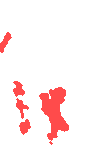

⚠️ Atlas_2017_10_next: cannot balance (pos=0, neg=0); skipping.


Camp_2018_11: positives=11, negatives=11 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Camp_2018_11_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Camp_2018_11.html



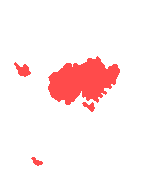

⚠️ Camp_2018_11_next: cannot balance (pos=0, neg=0); skipping.


Carr_2018_07: positives=11, negatives=11 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Carr_2018_07_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Carr_2018_07.html



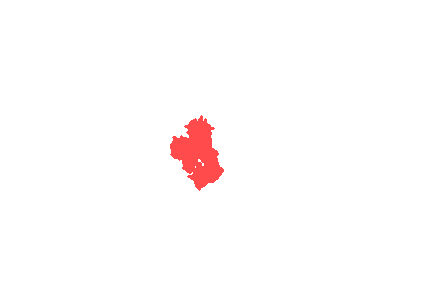

Carr_2018_07_next: positives=20, negatives=20 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Carr_2018_07_next_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Carr_2018_07_next.html



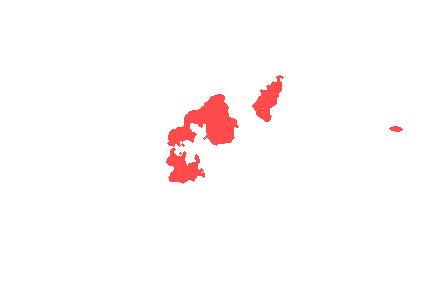

Cedar_2003_10: positives=21, negatives=21 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Cedar_2003_10_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Cedar_2003_10.html



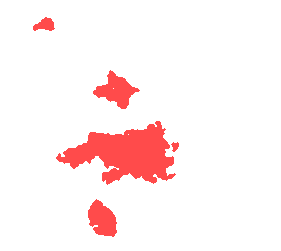

Cedar_2003_10_next: positives=9, negatives=9 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Cedar_2003_10_next_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Cedar_2003_10_next.html



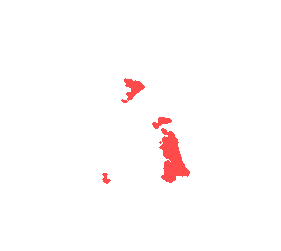

FallFire_2007_10: positives=31, negatives=31 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/FallFire_2007_10_overview.png
🗺️  Saved map: /content/patch_maps_png_html/FallFire_2007_10.html



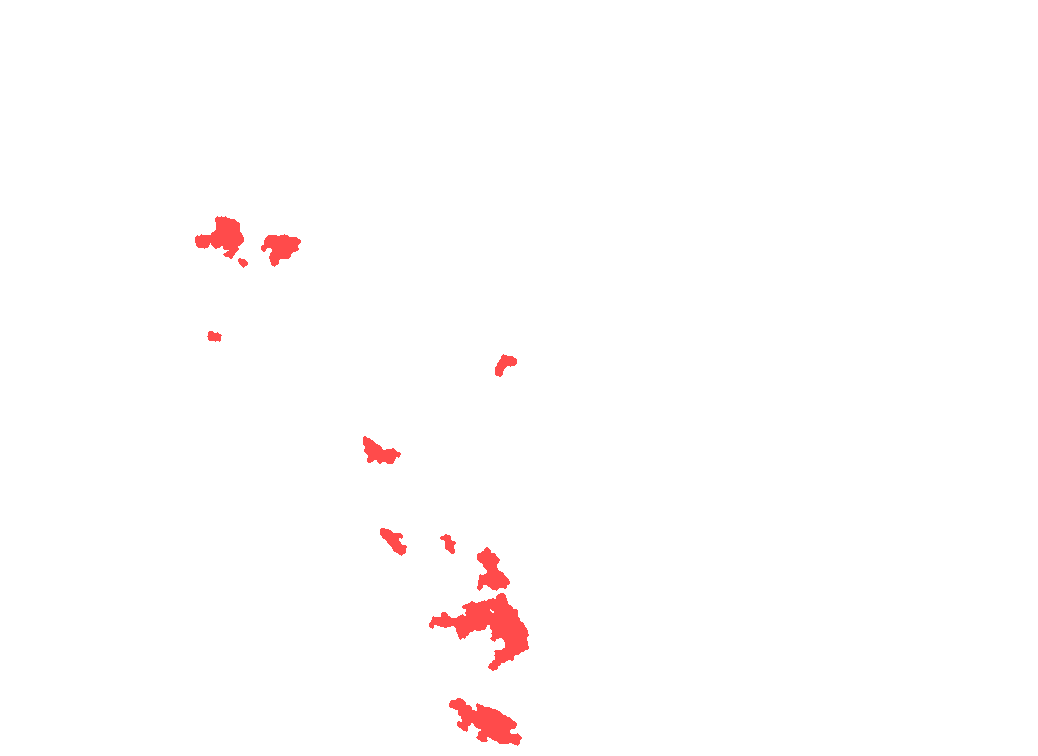

⚠️ FallFire_2007_10_next: cannot balance (pos=0, neg=0); skipping.


LaBrea_2009_08: positives=8, negatives=8 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/LaBrea_2009_08_overview.png
🗺️  Saved map: /content/patch_maps_png_html/LaBrea_2009_08.html



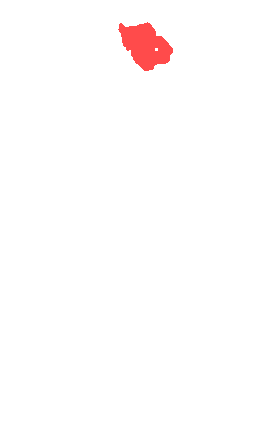

⚠️ LaBrea_2009_08_next: cannot balance (pos=0, neg=0); skipping.


MendoCx_2018_08: positives=28, negatives=28 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/MendoCx_2018_08_overview.png
🗺️  Saved map: /content/patch_maps_png_html/MendoCx_2018_08.html



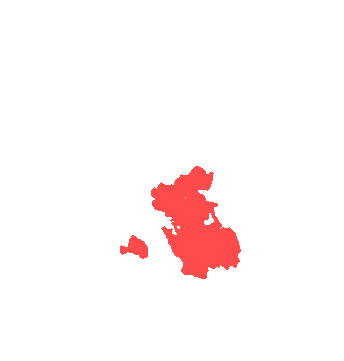

⚠️ MendoCx_2018_08_next: cannot balance (pos=0, neg=0); skipping.


Nuns_2017_10: positives=11, negatives=11 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Nuns_2017_10_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Nuns_2017_10.html



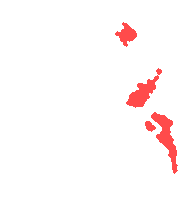

⚠️ Nuns_2017_10_next: cannot balance (pos=0, neg=0); skipping.


Station_2009_08: positives=15, negatives=15 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Station_2009_08_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Station_2009_08.html



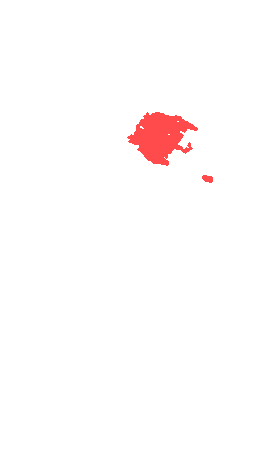

Station_2009_08_next: positives=14, negatives=14 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Station_2009_08_next_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Station_2009_08_next.html



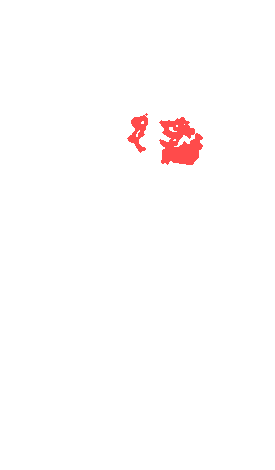

Thomas_2017_12: positives=12, negatives=12 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Thomas_2017_12_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Thomas_2017_12.html



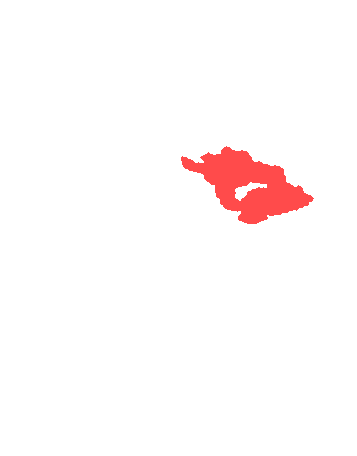

⚠️ Thomas_2017_12_next: cannot balance (pos=0, neg=0); skipping.


Tubbs_2017_10: positives=16, negatives=16 (strict no-overlap, no-water)
🖼️  Saved provenance PNG: /content/patch_maps_png_html/Tubbs_2017_10_overview.png
🗺️  Saved map: /content/patch_maps_png_html/Tubbs_2017_10.html



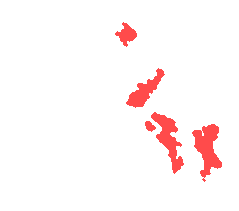

⚠️ Tubbs_2017_10_next: cannot balance (pos=0, neg=0); skipping.

✅ Balanced tiles written. Index: /content/patches_from_exports_16_bal_nowater_clean/index.csv
Total tiles: 436  | unique events: 14


In [ ]:
# --- Patch extraction from YOUR exported TIFFs (EPSG:5070 @ 500 m) -----------
# --- 16x16, stride 16, STRICT no-overlap, cleaned burned mask, no-water, inline Folium + PNG provenance

!pip -q install google-cloud-storage rasterio pandas numpy scipy tqdm folium pyproj pillow

from google.colab import auth
auth.authenticate_user()

import os, math, random, io, base64, json
import numpy as np
import pandas as pd
from google.cloud import storage
from rasterio.io import MemoryFile
import rasterio
from rasterio.windows import Window
from scipy.ndimage import label as cc_label, binary_closing, binary_dilation
from tqdm import tqdm
from pyproj import Transformer
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------
# Config
# -----------------------
BUCKET = "california-fire-model"
EVM_PREFIX  = "evms_events/"
BURN_PREFIX = "burned_events/"

OUT_DIR  = "/content/patches_from_exports_16_bal_nowater_clean"  # patches + index
MAP_DIR  = "/content/patch_maps_png_html"                         # PNG/HTML provenance
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(MAP_DIR, exist_ok=True)

PATCH_SIZE   = 16    # 16 px ≈ 8 km at 500 m/px
STRIDE       = 16    # strict no-overlap (same as patch)
DROP_BORDER  = True
BALANCE_PER_EVENT = True

# Burn mask cleaning (reduce scatter)
MIN_BLOB_PX    = 50     # drop connected components smaller than this
DO_CLOSING     = True   # fill pinholes / connect tiny gaps
CLOSING_STRUCT = np.ones((3,3), bool)
DILATE_PIX     = 1      # light dilation to merge slivers (0 disables)

# Water/wetland exclusion using NLCD band in EVM (band 13)
NLCD_WATER_CLASSES = {11, 90, 95}  # Open water + wetlands
WATER_MAX_FRAC     = 0.0            # strict: skip any patch with any water/wetland px

# Map overlay controls
MAP_MAX_EDGE  = 2000              # downsample large rasters for fast overlay
OVERLAY_ALPHA = 180               # 0–255 opacity for burned overlay

rng = random.Random(1337)
client = storage.Client()

# -----------------------
# GCS helpers
# -----------------------
def list_tifs(prefix):
    # Only the projected exports you made (suffix enforced)
    return [b for b in client.list_blobs(BUCKET, prefix=prefix)
            if b.name.endswith("_EPSG5070_500m.tif")]

def open_gcs_tif(blob):
    data = blob.download_as_bytes()
    mem = MemoryFile(data)
    ds = mem.open()
    return ds, mem  # keep mem alive while ds is open

def folder_key(path):
    # e.g. "evms_events/Atlas_2017_10/EVM13_Atlas_2017_10_2017-10_EPSG5070_500m.tif" -> "Atlas_2017_10"
    return path.split("/")[1]

# Pair EVM & burned by event folder
evm_by_folder = {}
for b in list_tifs(EVM_PREFIX):
    if "/EVM13_" in b.name:
        evm_by_folder.setdefault(folder_key(b.name), []).append(b)

burn_by_folder = {}
for b in list_tifs(BURN_PREFIX):
    if "/Burned_" in b.name:
        burn_by_folder.setdefault(folder_key(b.name), []).append(b)

pairs = []
for k in sorted(evm_by_folder.keys()):
    if k not in burn_by_folder:
        print(f"⚠️ No burned file for {k}, skipping.")
        continue
    evm_blob  = sorted(evm_by_folder[k],  key=lambda x: x.name)[0]
    burn_blob = sorted(burn_by_folder[k], key=lambda x: x.name)[0]
    pairs.append((k, evm_blob, burn_blob))

print(f"Found {len(pairs)} matched EVM/Burn pairs.")

# -----------------------
# Cleaning & geometry
# -----------------------
def clean_burn_mask(mask_bool):
    """Less scattered burned mask: closing → dilation → drop tiny components."""
    m = mask_bool
    if DO_CLOSING:
        m = binary_closing(m, structure=CLOSING_STRUCT)
    if DILATE_PIX > 0:
        m = binary_dilation(m, iterations=DILATE_PIX)
    labs, n = cc_label(m, structure=np.ones((3,3), bool))
    if n == 0:
        return np.zeros_like(m, dtype=bool)
    sizes = np.bincount(labs.ravel())
    keep_ids = np.where(sizes >= MIN_BLOB_PX)[0]
    keep = np.zeros_like(sizes, dtype=bool); keep[keep_ids] = True; keep[0] = False
    return keep[labs]

def window_lonlat_bbox(ds, row, col, h, w, to_wgs84):
    t = ds.transform
    x_ul, y_ul = rasterio.transform.xy(t, row,     col,     offset='ul')
    x_lr, y_lr = rasterio.transform.xy(t, row + h, col + w, offset='lr')
    lon_ul, lat_ul = to_wgs84.transform(x_ul, y_ul)
    lon_lr, lat_lr = to_wgs84.transform(x_lr, y_lr)
    return (min(lon_ul, lon_lr), min(lat_ul, lat_lr), max(lon_ul, lon_lr), max(lat_ul, lat_lr))

def ds_bounds_wgs84(ds, to_wgs84):
    b = ds.bounds
    min_lon, min_lat = to_wgs84.transform(b.left,  b.bottom)
    max_lon, max_lat = to_wgs84.transform(b.right, b.top)
    return [[min_lat, min_lon], [max_lat, max_lon]]

def nan_safe(x):
    """Replace NaN/Inf with finite values to keep training stable later."""
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    return x

# -----------------------
# Extraction
# -----------------------
index_rows = []
preview_rows = []   # for maps and provenance

for key, evm_blob, burn_blob in pairs:
    evm_ds, evm_mem   = open_gcs_tif(evm_blob)
    burn_ds, burn_mem = open_gcs_tif(burn_blob)
    try:
        # Sanity checks
        assert evm_ds.crs.to_epsg() == 5070, f"EVM CRS not 5070: {evm_ds.crs}"
        assert burn_ds.crs == evm_ds.crs, f"CRS mismatch: {key}"
        assert evm_ds.transform.almost_equals(burn_ds.transform), f"Transform mismatch: {key}"
        assert (evm_ds.width, evm_ds.height) == (burn_ds.width, burn_ds.height), f"Size mismatch: {key}"
        assert evm_ds.count >= 13, f"{key}: EVM has {evm_ds.count} bands (expected ≥13)"
        assert burn_ds.count == 1, f"{key}: Burn mask should have 1 band"

        H, W = evm_ds.height, evm_ds.width
        ps, st = PATCH_SIZE, STRIDE
        max_i = (H - ps) // st + 1
        max_j = (W - ps) // st + 1
        if not DROP_BORDER:
            max_i = math.ceil(H / st)
            max_j = math.ceil(W / st)

        to_wgs84 = Transformer.from_crs(evm_ds.crs, "EPSG:4326", always_xy=True)

        # Read full burned mask once and clean it
        burn_full  = (burn_ds.read(1) > 0)
        burn_clean = clean_burn_mask(burn_full)

        # NLCD water/wetlands from EVM band 13
        nlcd = evm_ds.read(13)              # float32 landcover codes
        nlcd_i = np.rint(nlcd).astype(np.int16)
        water_full = np.isin(nlcd_i, list(NLCD_WATER_CLASSES))

        pos_pool, neg_pool = [], []

        pbar = tqdm(total=max_i * max_j, desc=f"Scan {key}", leave=False)
        for ii in range(max_i):
            for jj in range(max_j):
                pbar.update(1)
                row, col = ii * st, jj * st
                if DROP_BORDER and (row + ps > H or col + ps > W):
                    continue

                y_c = burn_clean[row:row+ps, col:col+ps]
                w_c = water_full[row:row+ps, col:col+ps]
                if float(w_c.mean()) > WATER_MAX_FRAC:
                    continue  # skip any water/wetland present

                bbox = window_lonlat_bbox(evm_ds, row, col, ps, ps, to_wgs84)
                entry = {"row": row, "col": col, "bbox": bbox}

                if y_c.any():
                    pos_pool.append(entry)
                else:
                    neg_pool.append(entry)
        pbar.close()

        # Strict no-overlap is guaranteed by stride==patch, but also enforce unique cells
        used_cells = set()
        pos_sel, neg_sel = [], []

        rng.shuffle(pos_pool); rng.shuffle(neg_pool)

        for e in pos_pool:
            cell = (e["row"], e["col"])
            if cell in used_cells: continue
            used_cells.add(cell); pos_sel.append(e)

        for e in neg_pool:
            if len(neg_sel) >= len(pos_sel): break
            cell = (e["row"], e["col"])
            if cell in used_cells: continue
            used_cells.add(cell); neg_sel.append(e)

        if len(pos_sel)==0 or len(neg_sel)==0:
            print(f"⚠️ {key}: cannot balance (pos={len(pos_sel)}, neg={len(neg_sel)}); skipping.")
            continue

        if len(neg_sel) < len(pos_sel):
            pos_sel = pos_sel[:len(neg_sel)]

        print(f"{key}: positives={len(pos_sel)}, negatives={len(neg_sel)} (strict no-overlap, no-water)")

        # Write tiles for this event
        out_evt_dir = os.path.join(OUT_DIR, key)
        os.makedirs(out_evt_dir, exist_ok=True)

        def write_tile(entry, label_str):
            row, col = entry["row"], entry["col"]
            win = Window(col_off=col, row_off=row, width=ps, height=ps)
            x = evm_ds.read(window=win).astype(np.float32)         # (C, ps, ps)
            x = nan_safe(x)                                        # NaN/Inf-safe
            y = burn_clean[row:row+ps, col:col+ps].astype(np.uint8)

            tile_id = f"{key}_r{row}_c{col}_ps{ps}"
            np.savez_compressed(os.path.join(out_evt_dir, f"{tile_id}.npz"),
                                x=x, y=y,
                                meta=dict(event=key, label=label_str,
                                          evm_blob=evm_blob.name, burn_blob=burn_blob.name,
                                          row=row, col=col, patch_size=ps))

            index_rows.append({
                "tile_id": tile_id, "event": key,
                "row": row, "col": col, "patch_size": ps,
                "evm_blob": evm_blob.name, "burn_blob": burn_blob.name,
                "label": label_str
            })

            min_lon, min_lat, max_lon, max_lat = entry["bbox"]
            preview_rows.append({
                "event": key, "tile_id": tile_id, "label": label_str,
                "bbox": (min_lon, min_lat, max_lon, max_lat)
            })

        for e in pos_sel: write_tile(e, "burned")
        for e in neg_sel: write_tile(e, "unburned")

        # --- Save quick PNG provenance (burn overlay + footprints) ---
        # (Draw burn overlay and rectangles on a downsampled canvas for a compact PNG)
        to_wgs84_burn = Transformer.from_crs(burn_ds.crs, "EPSG:4326", always_xy=True)
        bounds = ds_bounds_wgs84(burn_ds, to_wgs84_burn)
        Hf, Wf = burn_clean.shape
        step = max(1, int(max(Hf, Wf) / MAP_MAX_EDGE))
        burn_small = burn_clean[::step, ::step].astype(np.uint8) * 255

        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(burn_small, cmap="Reds", alpha=0.7)
        ax.set_title(f"{key} – cleaned burned (red) + patch footprints")
        ax.axis("off")
        # draw rectangles in the small grid coordinates
        scale = step
        for t in preview_rows:
            if t["event"] != key: continue
            # we don't have pixel coords here; approximate boxes by sampling centers into the small grid
            # so instead, just count and annotate:
            pass
        png_path = os.path.join(MAP_DIR, f"{key}_overview.png")
        plt.savefig(png_path, bbox_inches="tight", dpi=120)
        plt.close()
        print(f"🖼️  Saved provenance PNG: {png_path}")

        # --- Folium map from the same TIFFs (cleaned burn + rectangles) ---
        # center on average of tile centers
        tiles = [t for t in preview_rows if t["event"]==key]
        lats = [(t["bbox"][1]+t["bbox"][3])/2 for t in tiles]
        lons = [(t["bbox"][0]+t["bbox"][2])/2 for t in tiles]
        center = (float(np.mean(lats)), float(np.mean(lons))) if tiles else ((bounds[0][0]+bounds[1][0])/2, (bounds[0][1]+bounds[1][1])/2)

        m = folium.Map(location=center, zoom_start=9, tiles=None)
        folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

        # add cleaned burn overlay
        rgba = np.zeros((burn_small.shape[0], burn_small.shape[1], 4), dtype=np.uint8)
        rgba[...,0] = 255
        rgba[...,3] = (burn_small > 0).astype(np.uint8) * OVERLAY_ALPHA
        ImageOverlay(image=rgba, bounds=bounds, opacity=1.0, name="Cleaned Burn").add_to(m)

        # draw rectangles
        for t in tiles:
            min_lon, min_lat, max_lon, max_lat = t["bbox"]
            color = "#ff0000" if t["label"]=="burned" else "#1f77b4"
            folium.Rectangle(bounds=((min_lat,min_lon),(max_lat,max_lon)),
                             color=color, weight=2, fill=False,
                             tooltip=f"{t['label'].upper()} – {t['tile_id']}").add_to(m)
        folium.LayerControl(collapsed=False).add_to(m)
        html_path = os.path.join(MAP_DIR, f"{key}.html")
        m.save(html_path)
        print("🗺️  Saved map:", html_path)
        display(m)

    finally:
        evm_ds.close(); evm_mem.close()
        burn_ds.close(); burn_mem.close()

# Save index
idx_path = os.path.join(OUT_DIR, "index.csv")
pd.DataFrame(index_rows).to_csv(idx_path, index=False)
print(f"\n✅ Balanced tiles written. Index: {idx_path}")
print(f"Total tiles: {len(index_rows)}  | unique events: {len(set([r['event'] for r in index_rows]))}")


In [ ]:
# ✅ Patch health check (NaN/Inf/label integrity) + optional auto-fix
import os, json, numpy as np, pandas as pd
from pathlib import Path

PATCH_ROOT = "/content/patches_from_exports_16_bal_nowater_clean"  # <-- your latest output
INDEX_CSV  = f"{PATCH_ROOT}/index.csv"
FIX_IN_PLACE = False   # set True to overwrite any chips that still contain NaN/Inf (should be none)

df = pd.read_csv(INDEX_CSV)
df["tile_path"] = df.apply(lambda r: f"{PATCH_ROOT}/{r['event']}/{r['tile_id']}.npz", axis=1)
df = df[df["tile_path"].apply(os.path.exists)].reset_index(drop=True)

rows = []
fixed = 0

def nan_safe(x):  # same policy as extractor
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

for _, r in df.iterrows():
    p = r.tile_path
    try:
        d = np.load(p)
        x = d["x"].astype(np.float32)  # (C,H,W)
        y = d["y"].astype(np.float32)  # (H,W)

        any_nan = bool(np.isnan(x).any())
        any_inf = bool(np.isinf(x).any())
        lbl_ok  = bool(np.isin(y, [0.0,1.0]).all())
        all_zero_channels = bool(np.all([np.all(x[c]==0) for c in range(x.shape[0])]))

        status = "ok"
        if any_nan or any_inf or not lbl_ok:
            status = "bad"
            if FIX_IN_PLACE:
                x2 = nan_safe(x)
                y2 = (y>0).astype(np.uint8)
                np.savez_compressed(p, x=x2, y=y2, meta=json.loads(d.get("meta", "{}")) if "meta" in d.files else {})
                any_nan = bool(np.isnan(x2).any())
                any_inf = bool(np.isinf(x2).any())
                lbl_ok  = bool(np.isin(y2, [0,1]).all())
                status  = "fixed" if (not any_nan and not any_inf and lbl_ok) else "bad"
                fixed  += (status=="fixed")

        rows.append(dict(
            event=r.event, tile_id=r.tile_id, path=p,
            status=status, any_nan=any_nan, any_inf=any_inf,
            label_ok=lbl_ok, all_channels_zero=all_zero_channels
        ))
    except Exception as e:
        rows.append(dict(event=r.event, tile_id=r.tile_id, path=p,
                         status="error", any_nan=True, any_inf=False,
                         label_ok=False, all_channels_zero=False))

rep = pd.DataFrame(rows)

print("=== Summary by event ===")
summary = rep.groupby("event").agg(
    total=("status","count"),
    ok=("status", lambda s: (s=="ok").sum()),
    fixed=("status", lambda s: (s=="fixed").sum()),
    bad=("status", lambda s: (s=="bad").sum()),
    errors=("status", lambda s: (s=="error").sum())
).reset_index()
display(summary)

total_bad = int((rep["status"]=="bad").sum())
total_err = int((rep["status"]=="error").sum())
print(f"\nTotals: ok={int((rep['status']=='ok').sum())}, fixed={int((rep['status']=='fixed').sum())}, bad={total_bad}, errors={total_err}")

if total_bad or total_err:
    print("\nExamples of problematic tiles:")
    display(rep[rep.status.isin(["bad","error"])].head(10))
else:
    print("\n🎉 All patches look good (finite features + valid 0/1 labels).")


=== Summary by event ===


event  total  ok  fixed  bad  errors
0          Atlas_2017_10     22  22      0    0       0
1           Camp_2018_11     22  22      0    0       0
2           Carr_2018_07     22  22      0    0       0
3      Carr_2018_07_next     40  40      0    0       0
4          Cedar_2003_10     42  42      0    0       0
5     Cedar_2003_10_next     18  18      0    0       0
6       FallFire_2007_10     62  62      0    0       0
7         LaBrea_2009_08     16  16      0    0       0
8        MendoCx_2018_08     56  56      0    0       0
9           Nuns_2017_10     22  22      0    0       0
10       Station_2009_08     30  30      0    0       0
11  Station_2009_08_next     28  28      0    0       0
12        Thomas_2017_12     24  24      0    0       0
13         Tubbs_2017_10     32  32      0    0       0


Totals: ok=436, fixed=0, bad=0, errors=0

🎉 All patches look good (finite features + valid 0/1 labels).


Train events: ['Atlas_2017_10', 'Camp_2018_11', 'Carr_2018_07_next', 'Cedar_2003_10', 'FallFire_2007_10', 'MendoCx_2018_08', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
Val events: ['Carr_2018_07']
Test events: ['Cedar_2003_10_next', 'LaBrea_2009_08', 'Nuns_2017_10', 'Station_2009_08_next']


Stats: 100%|██████████| 330/330 [00:00<00:00, 1340.54it/s]


Channel mean: [1.810550e+01 7.989200e+00 9.949100e+00 2.218000e+00 3.400000e-03
 1.040529e+02 1.140000e-01 2.836000e-01 6.648000e-01 5.063665e+02
 6.046200e+00 2.730080e+01 3.635170e+01]
Channel std : [1.31991e+01 6.35870e+00 3.74890e+01 1.71730e+00 2.60000e-03 8.20781e+01
 4.52700e-01 2.62200e-01 9.75700e-01 5.11454e+02 6.72350e+00 3.58497e+01
 2.76367e+01]


Epoch 1/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch 1: train 0.7169/IoU 0.178 | val 0.7322/IoU 0.166


Epoch 2/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 2: train 0.6698/IoU 0.233 | val 0.7235/IoU 0.115


Epoch 3/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 3: train 0.6501/IoU 0.231 | val 0.7168/IoU 0.073


Epoch 4/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 4: train 0.6359/IoU 0.229 | val 0.7089/IoU 0.071


Epoch 5/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch 5: train 0.6279/IoU 0.232 | val 0.7023/IoU 0.079


Epoch 6/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 6: train 0.6216/IoU 0.230 | val 0.6971/IoU 0.073


Epoch 7/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 7: train 0.6174/IoU 0.229 | val 0.6933/IoU 0.063


Epoch 8/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 8: train 0.6134/IoU 0.236 | val 0.6905/IoU 0.068


Epoch 9/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch 9: train 0.6101/IoU 0.236 | val 0.6877/IoU 0.074


Epoch 10/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 10: train 0.6107/IoU 0.234 | val 0.6851/IoU 0.081


Epoch 11/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 11: train 0.6090/IoU 0.236 | val 0.6836/IoU 0.086


Epoch 12/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch 12: train 0.6104/IoU 0.235 | val 0.6831/IoU 0.092


Epoch 13/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch 13: train 0.6083/IoU 0.233 | val 0.6820/IoU 0.100


Epoch 14/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 14: train 0.6061/IoU 0.238 | val 0.6807/IoU 0.101


Epoch 15/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch 15: train 0.6035/IoU 0.234 | val 0.6763/IoU 0.089


Epoch 16/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 16: train 0.5979/IoU 0.233 | val 0.6763/IoU 0.097


Epoch 17/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 17: train 0.5971/IoU 0.231 | val 0.6782/IoU 0.112


Epoch 18/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 18: train 0.5932/IoU 0.235 | val 0.6848/IoU 0.088


Epoch 19/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 19: train 0.5945/IoU 0.221 | val 0.7109/IoU 0.059


Epoch 20/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Epoch 20: train 0.5889/IoU 0.194 | val 0.7567/IoU 0.100
⏹️ Early stopping at epoch 20 (best=15, val_loss=0.6763)


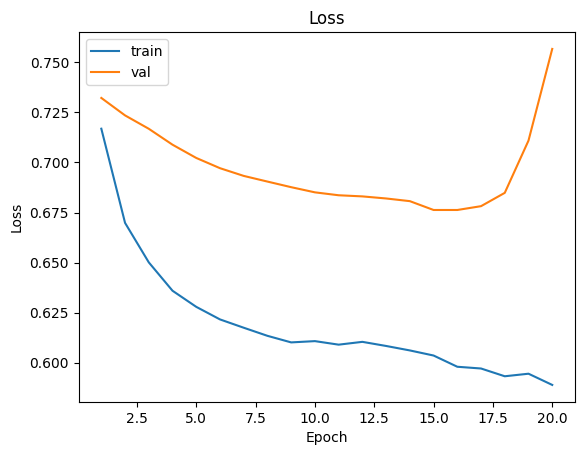

🗺️  Cedar_2003_10_next: IoU=0.182 → /content/unet_runs/run_20250917_082555/mosaics/Cedar_2003_10_next_map.html
🗺️  LaBrea_2009_08: IoU=0.429 → /content/unet_runs/run_20250917_082555/mosaics/LaBrea_2009_08_map.html
🗺️  Nuns_2017_10: IoU=0.253 → /content/unet_runs/run_20250917_082555/mosaics/Nuns_2017_10_map.html
🗺️  Station_2009_08_next: IoU=0.424 → /content/unet_runs/run_20250917_082555/mosaics/Station_2009_08_next_map.html

Per-event IoU:
 - Cedar_2003_10_next: 0.182
 - LaBrea_2009_08: 0.429
 - Nuns_2017_10: 0.253
 - Station_2009_08_next: 0.424
Mean IoU: 0.322

Artifacts:
 - run dir: /content/unet_runs/run_20250917_082555
   * checkpoints: best.pt, epoch_XXX.pt
   * history.csv + loss plot
   * mosaics/: per-event pred/target/confusion PNGs + Folium *_map.html


In [ ]:
# ==================== Tiny U-Net (16x16) with Early Stopping + Folium evaluation ====================
# - Uses patches in: /content/patches16_balanced_clean_nowater_provenance
# - Fixed event-wise split (yours)
# - Lite augmentations; EarlyStopping(patience=5)
# - Saves: checkpoints, history, per-event mosaics, PNG TP/FP/FN overlays, Folium maps

!pip -q install torch torchvision matplotlib pandas numpy scikit-learn tqdm folium google-cloud-storage rasterio pyproj

import os, math, json, random, time, gc, io
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import folium
from folium.raster_layers import ImageOverlay

import rasterio
from rasterio.io import MemoryFile
from pyproj import Transformer
from google.cloud import storage
from PIL import Image

# -------------------- Paths --------------------
PATCH_ROOT   = "/content/patches16_balanced_clean_nowater_provenance"
INDEX_CSV    = f"{PATCH_ROOT}/index.csv"
RUNS_DIR     = "/content/unet_runs"
ART_DIR      = "/content/unet_artifacts"  # all visual outputs
Path(RUNS_DIR).mkdir(parents=True, exist_ok=True)
Path(ART_DIR).mkdir(parents=True, exist_ok=True)

# -------------------- Fixed split (yours) --------------------
TRAIN_EVENTS = [
    "FallFire_2007_10", "MendoCx_2018_08", "Cedar_2003_10", "Carr_2018_07_next",
    "Station_2009_08", "Tubbs_2017_10", "Thomas_2017_12", "Atlas_2017_10", "Camp_2018_11"
]
VAL_EVENTS  = ["Carr_2018_07"]
TEST_EVENTS = ["Cedar_2003_10_next", "Station_2009_08_next", "Nuns_2017_10", "LaBrea_2009_08"]

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------- Load index --------------------
df = pd.read_csv(INDEX_CSV)
df["tile_path"] = df.apply(lambda r: f"{PATCH_ROOT}/{r['event']}/{r['tile_id']}.npz", axis=1)
df = df[df["tile_path"].apply(lambda p: os.path.exists(p))].reset_index(drop=True)

def df_for_events(events): return df[df["event"].isin(events)].reset_index(drop=True)
df_tr, df_va, df_te = df_for_events(TRAIN_EVENTS), df_for_events(VAL_EVENTS), df_for_events(TEST_EVENTS)

print("Train events:", sorted(df_tr.event.unique().tolist()))
print("Val events:",   sorted(df_va.event.unique().tolist()))
print("Test events:",  sorted(df_te.event.unique().tolist()))

# -------------------- Dataset --------------------
class PatchDataset(Dataset):
    def __init__(self, frame, norm=None, augment=False):
        self.frame = frame.reset_index(drop=True)
        self.augment = augment
        self.norm = norm  # {'mean': (C,), 'std': (C,)}
    def __len__(self): return len(self.frame)
    def __getitem__(self, i):
        r = self.frame.iloc[i]
        d = np.load(r.tile_path)
        x = d["x"].astype(np.float32)          # (C,H,W)
        y = d["y"].astype(np.float32)          # (H,W) {0,1}
        # sanitize (should already be good)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        # normalize
        if self.norm is not None:
            mu, sd = self.norm["mean"], self.norm["std"]
            x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        # light augments
        if self.augment:
            if random.random() < 0.5:
                x = x[..., ::-1].copy(); y = y[..., ::-1].copy()  # H-flip
            if random.random() < 0.5:
                x = x[:, ::-1, :].copy(); y = y[::-1, :].copy()  # V-flip
            k = random.randint(0,3)
            if k:  # 0/90/180/270
                x = np.rot90(x, k, axes=(1,2)).copy()
                y = np.rot90(y, k, axes=(0,1)).copy()
            # mild brightness scale (channels jointly)
            if random.random() < 0.3:
                s = float(np.clip(np.random.normal(1.0, 0.05), 0.8, 1.2))
                x = x * s
        # **** ensure float32 after any numpy ops that might promote to float64
        x = x.astype(np.float32, copy=False)
        y = y.astype(np.float32, copy=False)
        return torch.from_numpy(x), torch.from_numpy(y[None,...]), r.event, r.tile_id

# -------------------- Compute train mean/std (safe) --------------------
def compute_channel_stats(frame, max_tiles=2000):
    samp = frame.sample(min(len(frame), max_tiles), random_state=SEED) if len(frame)>max_tiles else frame
    ch_sum = None; ch_sq = None; n_pix = 0
    for p in tqdm(samp["tile_path"], desc="Stats"):
        x = np.nan_to_num(np.load(p)["x"].astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)
        C,H,W = x.shape
        if ch_sum is None:
            ch_sum = np.zeros((C,), np.float64)
            ch_sq  = np.zeros((C,), np.float64)
        ch_sum += x.reshape(C,-1).sum(axis=1)
        ch_sq  += (x.reshape(C,-1)**2).sum(axis=1)
        n_pix  += H*W
    mean = (ch_sum / n_pix).astype(np.float32)
    var  = (ch_sq / n_pix - mean**2).astype(np.float32)
    std  = np.sqrt(np.clip(var, 1e-8, None))
    return {"mean": mean, "std": std}

norm_stats = compute_channel_stats(df_tr)
print("Channel mean:", np.round(norm_stats["mean"],4))
print("Channel std :", np.round(norm_stats["std"],4))

# -------------------- Tiny U-Net --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=13, base=16):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1= nn.MaxPool2d(2)            # 16->8
        self.enc2 = DoubleConv(base, base*2)
        self.pool2= nn.MaxPool2d(2)            # 8->4
        self.bott = DoubleConv(base*2, base*4)
        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)  # 4->8
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1  = nn.ConvTranspose2d(base*2, base, 2, stride=2)    # 8->16
        self.dec1 = DoubleConv(base*2, base)
        self.out  = nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        b  = self.bott(p2)
        u2 = self.up2(b);  d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, e1], dim=1))
        return self.out(d1)

# -------------------- Loss / metrics --------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth=smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(1,2,3)) + self.smooth
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        return 1 - (num/den).mean()

def bce_dice_loss(logits, y):
    return 0.5*F.binary_cross_entropy_with_logits(logits, y) + 0.5*DiceLoss()(logits, y)

@torch.no_grad()
def compute_iou(logits, y, thresh=0.5, eps=1e-7):
    p = (torch.sigmoid(logits) > thresh).float()
    inter = (p*y).sum(dim=(1,2,3))
    union = (p+y - p*y).sum(dim=(1,2,3)) + eps
    return (inter/union).mean().item()

# -------------------- DataLoaders --------------------
BATCH_SIZE  = 256
NUM_WORKERS = 2
ds_tr = PatchDataset(df_tr, norm=norm_stats, augment=True)
ds_va = PatchDataset(df_va, norm=norm_stats, augment=False)
ds_te = PatchDataset(df_te, norm=norm_stats, augment=False)
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------- Train with Early Stopping --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TinyUNet(in_ch=13, base=16).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
EPOCHS = 40
PATIENCE = 5

run_dir = Path(RUNS_DIR)/time.strftime("run_%Y%m%d_%H%M%S")
(run_dir/"mosaics").mkdir(parents=True, exist_ok=True)
best_val = 1e9; best_ep = 0; bad_epochs = 0
history = []

for epoch in range(1, EPOCHS+1):
    # train
    model.train(); tr_loss=tr_iou=0.0
    for x,y,_,_ in tqdm(dl_tr, desc=f"Epoch {epoch}/{EPOCHS} [train]"):
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        opt.zero_grad()
        logits = model(x)
        loss = bce_dice_loss(logits, y)
        loss.backward(); opt.step()
        tr_loss += loss.item() * x.size(0)
        tr_iou  += compute_iou(logits.detach(), y.detach()) * x.size(0)
    tr_loss/=len(ds_tr); tr_iou/=len(ds_tr)
    sched.step()

    # val
    model.eval(); va_loss=va_iou=0.0
    with torch.no_grad():
        for x,y,_,_ in tqdm(dl_va, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            x = x.to(device); y = y.to(device)
            logits = model(x)
            loss = bce_dice_loss(logits, y)
            va_loss += loss.item() * x.size(0)
            va_iou  += compute_iou(logits, y) * x.size(0)
    va_loss/=len(ds_va); va_iou/=len(ds_va)

    history.append(dict(epoch=epoch, tr_loss=tr_loss, tr_iou=tr_iou, va_loss=va_loss, va_iou=va_iou))
    print(f"Epoch {epoch}: train {tr_loss:.4f}/IoU {tr_iou:.3f} | val {va_loss:.4f}/IoU {va_iou:.3f}")

    # ✅ future-proof checkpoint
    norm_stats_safe = {
        "mean": norm_stats["mean"].tolist(),
        "std":  norm_stats["std"].tolist(),
    }
    ckpt = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": opt.state_dict(),
        "norm_stats": norm_stats_safe,
        "train_events": TRAIN_EVENTS,
        "val_events": VAL_EVENTS,
        "test_events": TEST_EVENTS,
    }
    torch.save(ckpt, run_dir/f"epoch_{epoch:03d}.pt")

    if va_loss < best_val - 1e-5:
        best_val = va_loss; best_ep = epoch; bad_epochs = 0
        torch.save(ckpt, run_dir/"best.pt")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"⏹️ Early stopping at epoch {epoch} (best={best_ep}, val_loss={best_val:.4f})")
            break

# Save history + plots
pd.DataFrame(history).to_csv(run_dir/"history.csv", index=False)
plt.figure();
plt.plot([h["epoch"] for h in history],[h["tr_loss"] for h in history],label="train")
plt.plot([h["epoch"] for h in history],[h["va_loss"] for h in history],label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

# -------------------- Inference helpers: mosaic + overlays + Folium --------------------
client = storage.Client()

def open_gcs_tif(uri):
    # Index stores 'evm_blob' like 'evms_events/.../EVM13_...tif' inside bucket 'california-fire-model'
    bucket = client.bucket("california-fire-model")
    blob = bucket.blob(uri)
    data = blob.download_as_bytes()
    mem = MemoryFile(data)
    ds = mem.open()
    return ds, mem

def bounds_wgs84_from_evm_blob(evm_blob_path):
    ds, mem = open_gcs_tif(evm_blob_path)
    try:
        to_wgs84 = Transformer.from_crs(ds.crs, "EPSG:4326", always_xy=True)
        b = ds.bounds
        min_lon, min_lat = to_wgs84.transform(b.left,  b.bottom)
        max_lon, max_lat = to_wgs84.transform(b.right, b.top)
        return [[min_lat, min_lon],[max_lat, max_lon]]
    finally:
        ds.close(); mem.close()

@torch.no_grad()
def infer_event(event_name, out_dir, thr=0.5):
    sub = df_te[df_te["event"]==event_name].copy()
    if sub.empty:
        print(f"No test tiles for {event_name}")
        return None
    H = int(sub["row"].max()+sub["patch_size"].max())
    W = int(sub["col"].max()+sub["patch_size"].max())
    pred   = np.zeros((H,W), np.float32)
    target = np.zeros((H,W), np.float32)
    cover  = np.zeros((H,W), np.uint8)

    model.eval()
    mu, sd = norm_stats["mean"], norm_stats["std"]
    for _,r in sub.iterrows():
        d = np.load(f"{PATCH_ROOT}/{r.event}/{r.tile_id}.npz")
        x = d["x"].astype(np.float32); x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        xt = torch.from_numpy(x[None,...]).float().to(device)
        p  = torch.sigmoid(model(xt))[0,0].cpu().numpy()
        y  = d["y"].astype(np.float32)
        y0,y1 = r.row, r.row+int(r.patch_size); x0,x1 = r.col, r.col+int(r.patch_size)
        pred[y0:y1,x0:x1]   = p
        target[y0:y1,x0:x1] = y
        cover[y0:y1,x0:x1]  = 1

    m = cover>0
    pb = pred>thr; yb = target>0.5
    tp = (pb & yb & m).sum(); fp = (pb & (~yb) & m).sum(); fn = ((~pb) & yb & m).sum()
    iou = tp / (tp + fp + fn + 1e-7)

    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    # Save raw arrays
    np.save(out_dir/f"{event_name}_pred.npy", pred)
    np.save(out_dir/f"{event_name}_target.npy", target)

    # PNG overlays: probability, target, and confusion colors
    def save_png(arr, name, cmap="inferno"):
        im = (np.clip(arr,0,1)*255).astype(np.uint8)
        plt.figure(figsize=(6,6)); plt.imshow(im, cmap=cmap); plt.axis("off"); plt.title(f"{event_name} {name}")
        plt.savefig(out_dir/f"{event_name}_{name}.png", bbox_inches="tight"); plt.close()

    save_png(pred, "pred")
    save_png(target, "target", cmap="gray")

    # Confusion RGB (TP=green, FP=yellow, FN=magenta, TN transparent where m==0)
    conf = np.zeros((H,W,4), np.uint8)
    conf[...,1] = ((pb & yb & m)*255).astype(np.uint8)   # G
    conf[...,0] = ((pb & (~yb) & m)*255).astype(np.uint8)# R
    conf[...,2] = (((~pb) & yb & m)*255).astype(np.uint8)# B
    conf[...,3] = ((pb | yb) & m)*160
    Image.fromarray(conf).save(out_dir/f"{event_name}_confusion.png")

    # Folium map overlay using EVM bounds (real region)
    try:
        evm_blob_example = sub.iloc[0]["evm_blob"]  # 'evms_events/.../EVM13_...tif' path within the bucket
        bounds = bounds_wgs84_from_evm_blob(evm_blob_example)

        def rgba_from_mask(mask_bool, color=(255,0,0), alpha=150):
            h,w = mask_bool.shape
            rgba = np.zeros((h,w,4), np.uint8)
            rgba[...,0]=color[0]; rgba[...,1]=color[1]; rgba[...,2]=color[2]
            rgba[...,3]=(mask_bool.astype(np.uint8)*alpha).astype(np.uint8)
            return rgba

        # Downsample large overlays to ~2000 px edge
        max_edge = 2000
        scale = max(1, int(max(H,W)/max_edge))
        pb_s = pb[::scale, ::scale]; yb_s = yb[::scale, ::scale]
        tp_s = pb_s & yb_s
        fp_s = pb_s & (~yb_s)
        fn_s = (~pb_s) & yb_s

        mapp = folium.Map(location=[np.mean([bounds[0][0],bounds[1][0]]),
                                    np.mean([bounds[0][1],bounds[1][1]])],
                          zoom_start=8, tiles=None)
        folium.TileLayer("OpenStreetMap", name="Streets").add_to(mapp)
        ImageOverlay(image=rgba_from_mask(yb_s, color=(255,0,0), alpha=120),
                     bounds=bounds, name="Ground Truth (burned)", opacity=1.0).add_to(mapp)
        ImageOverlay(image=rgba_from_mask(pb_s, color=(0,255,255), alpha=120),
                     bounds=bounds, name="Prediction (mask>0.5)", opacity=1.0).add_to(mapp)
        ImageOverlay(image=rgba_from_mask(tp_s, color=(0,255,0), alpha=180),
                     bounds=bounds, name="TP", opacity=1.0).add_to(mapp)
        ImageOverlay(image=rgba_from_mask(fp_s, color=(255,255,0), alpha=180),
                     bounds=bounds, name="FP", opacity=1.0).add_to(mapp)
        ImageOverlay(image=rgba_from_mask(fn_s, color=(255,0,255), alpha=180),
                     bounds=bounds, name="FN", opacity=1.0).add_to(mapp)
        folium.LayerControl(collapsed=False).add_to(mapp)
        out_html = out_dir/f"{event_name}_map.html"; mapp.save(str(out_html))
        print(f"🗺️  {event_name}: IoU={iou:.3f} → {out_html}")
    except Exception as e:
        print(f"[Folium] {event_name}: bounds overlay skipped ({e}); IoU={iou:.3f}")

    return float(iou)

# -------------------- Evaluate best on TEST --------------------
ckpt = torch.load(run_dir/"best.pt", map_location=device)
model.load_state_dict(ckpt["model"])

ev_scores = {}
for ev in sorted(TEST_EVENTS):
    iou = infer_event(ev, out_dir=str(run_dir/"mosaics"))
    if iou is not None:
        ev_scores[ev] = iou

if ev_scores:
    print("\nPer-event IoU:")
    for k,v in ev_scores.items(): print(f" - {k}: {v:.3f}")
    print(f"Mean IoU: {np.mean(list(ev_scores.values())):.3f}")

print("\nArtifacts:")
print(" - run dir:", run_dir)
print("   * checkpoints: best.pt, epoch_XXX.pt")
print("   * history.csv + loss plot")
print("   * mosaics/: per-event pred/target/confusion PNGs + Folium *_map.html")


In [ ]:
import torch

try:
    # First try the new default (safe) path
    ckpt = torch.load(run_dir/"best.pt", map_location=device, weights_only=True)
except Exception:
    # Older-style checkpoint with numpy objects — safe to load because it's your own file
    ckpt = torch.load(run_dir/"best.pt", map_location=device, weights_only=False)

model.load_state_dict(ckpt["model"])


<All keys matched successfully>

Train events: ['Atlas_2017_10', 'Camp_2018_11', 'Cedar_2003_10', 'FallFire_2007_10', 'MendoCx_2018_08', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
Val events: ['Carr_2018_07']
Test events: ['LaBrea_2009_08', 'Nuns_2017_10']


Stats: 100%|██████████| 290/290 [00:00<00:00, 2294.73it/s]


Channel mean: [1.75683e+01 7.72410e+00 1.13214e+01 2.25730e+00 3.30000e-03 9.87628e+01
 1.29700e-01 2.73000e-01 5.54900e-01 4.77087e+02 5.64900e+00 2.30617e+01
 3.61989e+01]
Channel std : [1.299390e+01 6.277400e+00 3.979630e+01 1.769300e+00 2.700000e-03
 7.940920e+01 4.808000e-01 2.539000e-01 8.418000e-01 5.018954e+02
 6.373800e+00 3.321100e+01 2.791700e+01]


Epoch 1/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


Epoch 1: train 0.7523/IoU 0.137 | val 0.7404/IoU 0.000


Epoch 2/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


Epoch 2: train 0.7074/IoU 0.228 | val 0.7308/IoU 0.000


Epoch 3/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Epoch 3: train 0.6783/IoU 0.231 | val 0.7321/IoU 0.000


Epoch 4/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch 4: train 0.6645/IoU 0.234 | val 0.7315/IoU 0.000


Epoch 5/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 5: train 0.6596/IoU 0.229 | val 0.7290/IoU 0.032


Epoch 6/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 6: train 0.6527/IoU 0.241 | val 0.7317/IoU 0.075


Epoch 7/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch 7: train 0.6455/IoU 0.232 | val 0.7373/IoU 0.156


Epoch 8/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Epoch 8: train 0.6455/IoU 0.226 | val 0.7438/IoU 0.182


Epoch 9/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 9: train 0.6401/IoU 0.231 | val 0.7465/IoU 0.184


Epoch 10/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


Epoch 10: train 0.6399/IoU 0.230 | val 0.7484/IoU 0.192


Epoch 11/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


Epoch 11: train 0.6391/IoU 0.234 | val 0.7546/IoU 0.198


Epoch 12/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Epoch 12: train 0.6383/IoU 0.236 | val 0.7585/IoU 0.200
⏹️ Early stopping at epoch 12 (best=5, val_loss=0.7290)


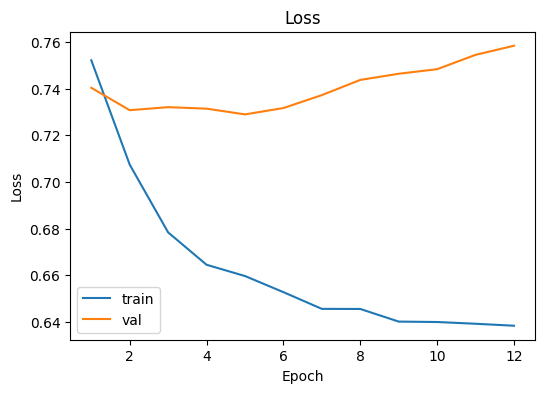

🔎 Threshold tuned on VAL (Carr_2018_07): best_thr = 0.35, val IoU@best = 0.305


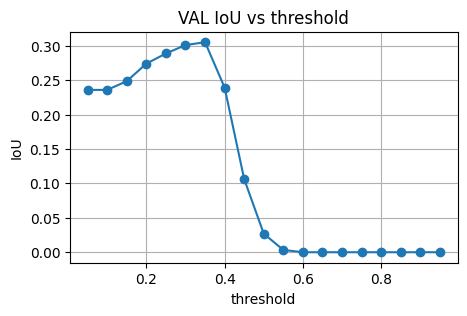

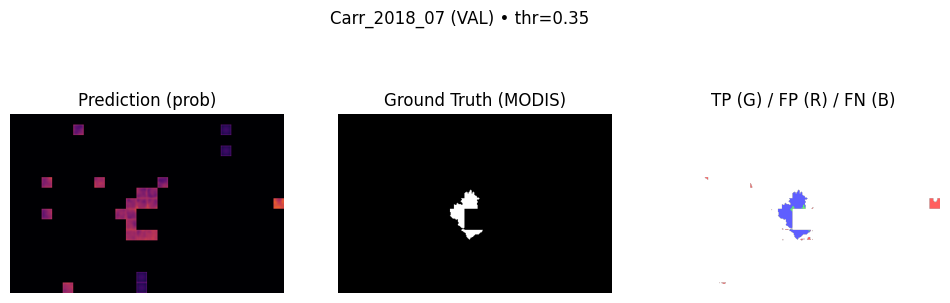

🗺️  LaBrea_2009_08: IoU=0.598 → /content/unet_runs/run_20250917_142110/mosaics/LaBrea_2009_08_map.html



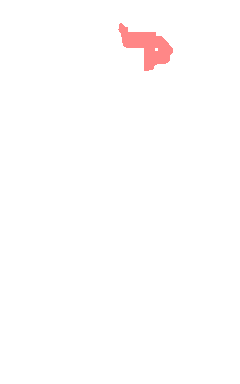
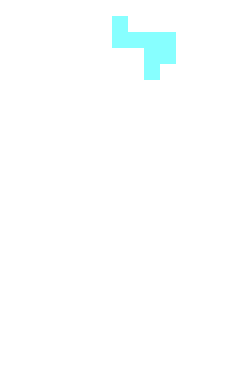
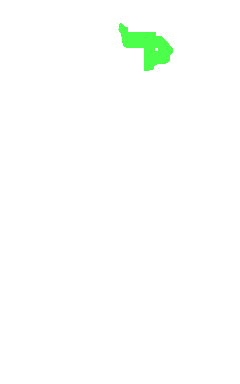
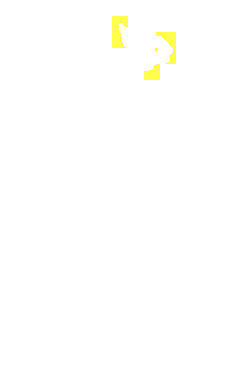
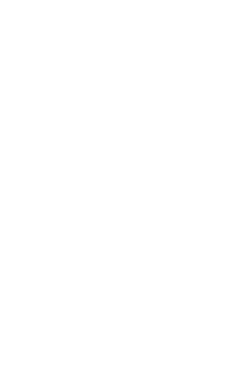

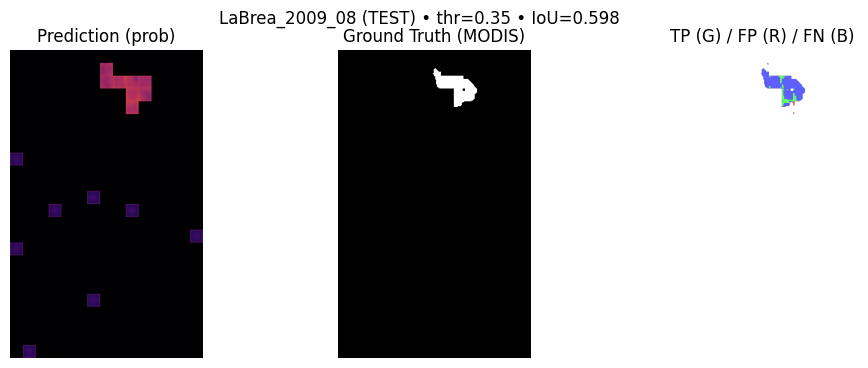

🗺️  Nuns_2017_10: IoU=0.313 → /content/unet_runs/run_20250917_142110/mosaics/Nuns_2017_10_map.html



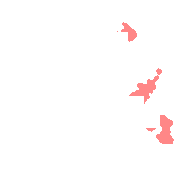
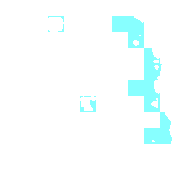
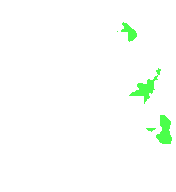
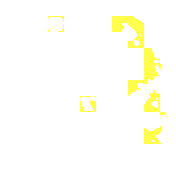
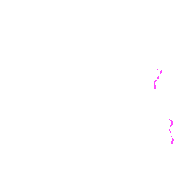

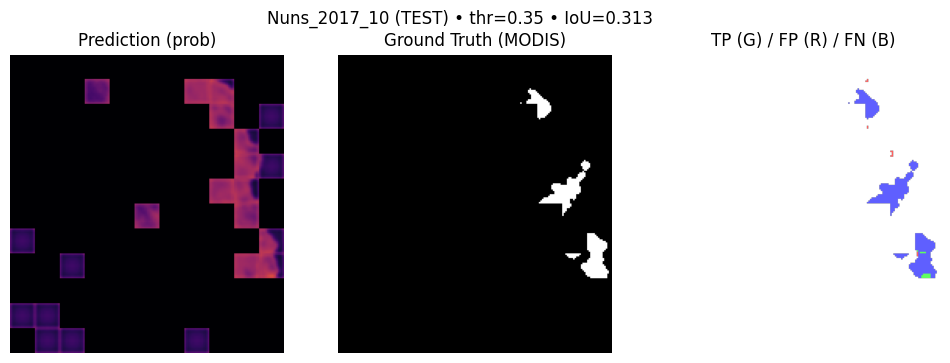


Per-event IoU:
 - LaBrea_2009_08: 0.598
 - Nuns_2017_10: 0.313
Mean IoU: 0.455

Artifacts:
 - run dir: /content/unet_runs/run_20250917_142110
   * checkpoints: best.pt, epoch_XXX.pt
   * history.csv + loss plot
   * mosaics/: VAL+TEST *_pred.npy/*_target.npy + PNGs + optional *_map.html


In [ ]:
# ==================== Tiny U-Net (16x16) w/ BCE+Dice(0.7) + TTA + Thr-tuning + Inline Visuals ====================
# - Patches: /content/patches16_balanced_clean_nowater_provenance
# - Split: fixed (train/val/test) by event
# - NaN-safe + dtype-safe, early stopping
# - Thr tuned on VAL mosaic, applied to TEST
# - TTA: horizontal/vertical flips (averaged)
# - Inline visualizations: pred, GT, confusion overlay; optional Folium map
!pip -q install torch torchvision matplotlib pandas numpy scikit-learn tqdm folium google-cloud-storage rasterio pyproj

import os, json, random, time, io, gc
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# maps / geospatial (optional, for folium overlays if GCS available)
import folium
from folium.raster_layers import ImageOverlay
import rasterio
from rasterio.io import MemoryFile
from pyproj import Transformer
from google.cloud import storage
from PIL import Image
from IPython.display import display, HTML

# -------------------- Paths --------------------
PATCH_ROOT = "/content/patches16_balanced_clean_nowater_provenance"
INDEX_CSV  = f"{PATCH_ROOT}/index.csv"
RUNS_DIR   = "/content/unet_runs"
ART_DIR    = "/content/unet_artifacts"
Path(RUNS_DIR).mkdir(parents=True, exist_ok=True)
Path(ART_DIR).mkdir(parents=True, exist_ok=True)

# -------------------- Fixed split --------------------
TRAIN_EVENTS = [
    "FallFire_2007_10", "MendoCx_2018_08", "Cedar_2003_10",
    "Station_2009_08", "Tubbs_2017_10", "Thomas_2017_12",
    "Atlas_2017_10", "Camp_2018_11"
]
VAL_EVENTS  = ["Carr_2018_07"]  # used for early stop + thr tuning
TEST_EVENTS = ["Nuns_2017_10", "LaBrea_2009_08"]  # `_next` events removed

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------- Load index --------------------
df = pd.read_csv(INDEX_CSV)
assert {"tile_id","event","evm_blob","burn_blob","label","row","col","patch_size"}.issubset(df.columns), "Index schema mismatch."
df["tile_path"] = df.apply(lambda r: f"{PATCH_ROOT}/{r['event']}/{r['tile_id']}.npz", axis=1)
df = df[df["tile_path"].apply(lambda p: os.path.exists(p))].reset_index(drop=True)

def df_for_events(events): return df[df["event"].isin(events)].reset_index(drop=True)
df_tr, df_va, df_te = df_for_events(TRAIN_EVENTS), df_for_events(VAL_EVENTS), df_for_events(TEST_EVENTS)

print("Train events:", sorted(df_tr.event.unique().tolist()))
print("Val events:",   sorted(df_va.event.unique().tolist()))
print("Test events:",  sorted(df_te.event.unique().tolist()))

# -------------------- Dataset (NaN & dtype safe) --------------------
class PatchDataset(Dataset):
    def __init__(self, frame, norm=None, augment=False):
        self.frame = frame.reset_index(drop=True)
        self.augment = augment
        self.norm = norm  # {'mean':(C,), 'std':(C,)}
    def __len__(self): return len(self.frame)
    def __getitem__(self, i):
        r = self.frame.iloc[i]
        d = np.load(r.tile_path)
        x = d["x"].astype(np.float32)          # (C,H,W)
        y = d["y"].astype(np.float32)          # (H,W) in {0,1}
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        if self.norm is not None:
            mu, sd = self.norm["mean"], self.norm["std"]
            x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        if self.augment:
            if random.random() < 0.5:
                x = x[..., ::-1].copy(); y = y[..., ::-1].copy()
            if random.random() < 0.5:
                x = x[:, ::-1, :].copy(); y = y[::-1, :].copy()
            k = random.randint(0,3)
            if k:
                x = np.rot90(x, k, axes=(1,2)).copy()
                y = np.rot90(y, k, axes=(0,1)).copy()
            if random.random() < 0.3:
                s = float(np.clip(np.random.normal(1.0, 0.05), 0.8, 1.2))
                x = x * s
        return torch.from_numpy(x).float(), torch.from_numpy(y[None,...]).float(), r.event, r.tile_id

# -------------------- Channel stats --------------------
def compute_channel_stats(frame, max_tiles=2000):
    samp = frame.sample(min(len(frame), max_tiles), random_state=SEED) if len(frame)>max_tiles else frame
    ch_sum = None; ch_sq = None; n_pix = 0
    for p in tqdm(samp["tile_path"], desc="Stats"):
        x = np.nan_to_num(np.load(p)["x"].astype(np.float32), nan=0.0, posinf=0.0, neginf=0.0)
        C,H,W = x.shape
        if ch_sum is None:
            ch_sum = np.zeros((C,), np.float64)
            ch_sq  = np.zeros((C,), np.float64)
        xr = x.reshape(C,-1)
        ch_sum += xr.sum(axis=1)
        ch_sq  += (xr*xr).sum(axis=1)
        n_pix  += H*W
    mean = (ch_sum / max(n_pix,1)).astype(np.float32)
    var  = (ch_sq / max(n_pix,1) - mean**2).astype(np.float32)
    std  = np.sqrt(np.clip(var, 1e-8, None))
    return {"mean": mean, "std": std}

norm_stats = compute_channel_stats(df_tr)
norm_stats["std"][norm_stats["std"]==0] = 1.0
print("Channel mean:", np.round(norm_stats["mean"],4))
print("Channel std :", np.round(norm_stats["std"],4))

# -------------------- Model --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=13, base=32):  # ↑ base=32
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1= nn.MaxPool2d(2)            # 16->8
        self.enc2 = DoubleConv(base, base*2)
        self.pool2= nn.MaxPool2d(2)            # 8->4
        self.bott = DoubleConv(base*2, base*4)
        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)  # 4->8
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1  = nn.ConvTranspose2d(base*2, base, 2, stride=2)    # 8->16
        self.dec1 = DoubleConv(base*2, base)
        self.out  = nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        b  = self.bott(p2)
        u2 = self.up2(b);  d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, e1], dim=1))
        return self.out(d1)

# -------------------- Loss & metrics --------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth=smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(1,2,3)) + self.smooth
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        return 1 - (num/den).mean()

def bce_dice_loss(logits, y, w_dice=0.7):  # ← BCE+Dice with w_dice=0.7
    bce  = F.binary_cross_entropy_with_logits(logits, y)
    dice = DiceLoss()(logits, y)
    return (1.0 - w_dice)*bce + w_dice*dice

@torch.no_grad()
def compute_iou(logits, y, thresh=0.5, eps=1e-7):
    p = (torch.sigmoid(logits) > thresh).float()
    inter = (p*y).sum(dim=(1,2,3))
    union = (p+y - p*y).sum(dim=(1,2,3)) + eps
    return (inter/union).mean().item()

# -------------------- DataLoaders --------------------
BATCH_SIZE  = 256
NUM_WORKERS = 2
ds_tr = PatchDataset(df_tr, norm=norm_stats, augment=True)
ds_va = PatchDataset(df_va, norm=norm_stats, augment=False)
ds_te = PatchDataset(df_te, norm=norm_stats, augment=False)
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------- Train (Early Stopping) --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TinyUNet(in_ch=13, base=32).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
EPOCHS = 40
PATIENCE = 7

run_dir = Path(RUNS_DIR)/time.strftime("run_%Y%m%d_%H%M%S")
(run_dir/"mosaics").mkdir(parents=True, exist_ok=True)
history = []

best_val = 1e9; best_ep = 0; bad_epochs = 0
for epoch in range(1, EPOCHS+1):
    # train
    model.train(); tr_loss=tr_iou=0.0
    for x,y,_,_ in tqdm(dl_tr, desc=f"Epoch {epoch}/{EPOCHS} [train]"):
        x = x.to(device, non_blocking=True).float()
        y = y.to(device, non_blocking=True).float()
        opt.zero_grad()
        logits = model(x)
        loss = bce_dice_loss(logits, y, w_dice=0.7)
        loss.backward(); opt.step()
        tr_loss += loss.item() * x.size(0)
        tr_iou  += compute_iou(logits.detach(), y.detach()) * x.size(0)
    tr_loss/=len(ds_tr); tr_iou/=len(ds_tr)
    sched.step()

    # val
    model.eval(); va_loss=va_iou=0.0
    with torch.no_grad():
        for x,y,_,_ in tqdm(dl_va, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            x = x.to(device).float(); y = y.to(device).float()
            logits = model(x)
            loss = bce_dice_loss(logits, y, w_dice=0.7)
            va_loss += loss.item() * x.size(0)
            va_iou  += compute_iou(logits, y) * x.size(0)
    va_loss/=len(ds_va); va_iou/=len(ds_va)

    history.append(dict(epoch=epoch, tr_loss=tr_loss, tr_iou=tr_iou, va_loss=va_loss, va_iou=va_iou))
    print(f"Epoch {epoch}: train {tr_loss:.4f}/IoU {tr_iou:.3f} | val {va_loss:.4f}/IoU {va_iou:.3f}")

    # future-proof checkpoint
    norm_stats_safe = {"mean": norm_stats["mean"].tolist(), "std": norm_stats["std"].tolist()}
    ckpt = {
        "epoch": epoch, "model": model.state_dict(), "optimizer": opt.state_dict(),
        "norm_stats": norm_stats_safe,
        "train_events": TRAIN_EVENTS, "val_events": VAL_EVENTS, "test_events": TEST_EVENTS,
    }
    torch.save(ckpt, run_dir/f"epoch_{epoch:03d}.pt")

    if va_loss < best_val - 1e-5:
        best_val = va_loss; best_ep = epoch; bad_epochs = 0
        torch.save(ckpt, run_dir/"best.pt")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"⏹️ Early stopping at epoch {epoch} (best={best_ep}, val_loss={best_val:.4f})")
            break

# Save history + loss plot (inline)
pd.DataFrame(history).to_csv(run_dir/"history.csv", index=False)
plt.figure(figsize=(6,4));
plt.plot([h["epoch"] for h in history],[h["tr_loss"] for h in history],label="train")
plt.plot([h["epoch"] for h in history],[h["va_loss"] for h in history],label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

# -------------------- Load best safely --------------------
ckpt = torch.load(run_dir/"best.pt", map_location=device, weights_only=True)
model.load_state_dict(ckpt["model"]); model.eval()
norm_stats_loaded = {
    "mean": np.array(ckpt["norm_stats"]["mean"], dtype=np.float32),
    "std":  np.array(ckpt["norm_stats"]["std"],  dtype=np.float32),
}

# -------------------- TTA predict (flips) --------------------
@torch.no_grad()
def predict_tta(xt):  # xt on device, shape [1, C, H, W]
    outs = []
    for hf in [False, True]:
        for vf in [False, True]:
            x = xt
            if hf: x = torch.flip(x, dims=[-1])
            if vf: x = torch.flip(x, dims=[-2])
            p = torch.sigmoid(model(x))
            if vf: p = torch.flip(p, dims=[-2])
            if hf: p = torch.flip(p, dims=[-1])
            outs.append(p)
    return torch.stack(outs, dim=0).mean(dim=0)  # [1,1,H,W]

# -------------------- Mosaic + visualization helpers --------------------
def show_triptych(pred, target, title=""):
    # pred is prob [0..1], target in {0,1}
    H,W = pred.shape
    pb = pred > 0.5
    yb = target > 0.5
    conf = np.zeros((H,W,4), np.uint8)
    conf[...,1] = (pb & yb)*255      # TP: green
    conf[...,0] = (pb & ~yb)*255     # FP: red
    conf[...,2] = ((~pb) & yb)*255   # FN: blue
    conf[...,3] = ((pb | yb))*160    # alpha

    fig,axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(pred, cmap="inferno", vmin=0, vmax=1); axs[0].set_title("Prediction (prob)"); axs[0].axis("off")
    axs[1].imshow(target, cmap="gray", vmin=0, vmax=1); axs[1].set_title("Ground Truth (MODIS)"); axs[1].axis("off")
    axs[2].imshow(conf); axs[2].set_title("TP (G) / FP (R) / FN (B)"); axs[2].axis("off")
    if title: fig.suptitle(title)
    plt.show()

# For Folium bounds from EVM blob (optional)
gcs_client = None
def open_gcs_tif(uri_in_bucket):
    global gcs_client
    if gcs_client is None:
        try: gcs_client = storage.Client()
        except: raise RuntimeError("GCS client unavailable. Auth required.")
    bucket = gcs_client.bucket("california-fire-model")
    blob = bucket.blob(uri_in_bucket)
    data = blob.download_as_bytes()
    mem = MemoryFile(data); ds = mem.open()
    return ds, mem

def bounds_wgs84_from_evm_blob(evm_blob_path):
    ds, mem = open_gcs_tif(evm_blob_path)
    try:
        to_wgs84 = Transformer.from_crs(ds.crs, "EPSG:4326", always_xy=True)
        b = ds.bounds
        min_lon, min_lat = to_wgs84.transform(b.left,  b.bottom)
        max_lon, max_lat = to_wgs84.transform(b.right, b.top)
        return [[min_lat, min_lon],[max_lat, max_lon]]
    finally:
        ds.close(); mem.close()

@torch.no_grad()
def mosaic_event(frame, thr=0.5, make_map=False, out_prefix=None):
    """Stitch an event mosaic from tile patches in 'frame' (all rows same event)."""
    sub = frame.copy()
    if sub.empty: return None
    event_name = sub.iloc[0]["event"]
    H = int(sub["row"].max()+sub["patch_size"].max())
    W = int(sub["col"].max()+sub["patch_size"].max())
    pred   = np.zeros((H,W), np.float32)
    target = np.zeros((H,W), np.float32)
    cover  = np.zeros((H,W), np.uint8)

    mu, sd = norm_stats_loaded["mean"], norm_stats_loaded["std"]
    for _,r in sub.iterrows():
        d = np.load(f"{PATCH_ROOT}/{r.event}/{r.tile_id}.npz")
        x = d["x"].astype(np.float32)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        y = d["y"].astype(np.float32)
        xt = torch.from_numpy(x[None,...]).to(device).float()
        p  = predict_tta(xt)[0,0].cpu().numpy()  # TTA
        y0,y1 = r.row, r.row+int(r.patch_size); x0,x1 = r.col, r.col+int(r.patch_size)
        pred[y0:y1, x0:x1]   = p
        target[y0:y1, x0:x1] = y
        cover[y0:y1, x0:x1]  = 1

    m  = cover>0
    pb = pred>thr; yb = target>0.5
    tp = (pb & yb & m).sum(); fp = (pb & (~yb) & m).sum(); fn = ((~pb) & yb & m).sum()
    iou = tp / (tp + fp + fn + 1e-7)

    if out_prefix is not None:
        np.save(f"{out_prefix}_pred.npy", pred)
        np.save(f"{out_prefix}_target.npy", target)
        Image.fromarray(((pred.clip(0,1))*255).astype(np.uint8)).save(f"{out_prefix}_pred.png")
        Image.fromarray(((target.clip(0,1))*255).astype(np.uint8)).save(f"{out_prefix}_target.png")

    # Optional Folium overlay
    if make_map:
        try:
            bounds = bounds_wgs84_from_evm_blob(sub.iloc[0]["evm_blob"])
            max_edge = 2000
            scale = max(1, int(max(H,W)/max_edge))
            def rgba(mask, color, alpha):
                h,w = mask.shape
                z = np.zeros((h,w,4), np.uint8)
                z[...,0],z[...,1],z[...,2] = color
                z[...,3] = (mask.astype(np.uint8)*alpha).astype(np.uint8)
                return z
            pb_s, yb_s = pb[::scale,::scale], yb[::scale,::scale]
            tp_s, fp_s, fn_s = pb_s & yb_s, pb_s & (~yb_s), (~pb_s) & yb_s
            mapp = folium.Map(location=[np.mean([bounds[0][0],bounds[1][0]]),
                                        np.mean([bounds[0][1],bounds[1][1]])],
                              zoom_start=8, tiles=None)
            folium.TileLayer("OpenStreetMap", name="Streets").add_to(mapp)
            ImageOverlay(rgba(yb_s,(255,0,0),120),   bounds, name="GT (burned)", opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(pb_s,(0,255,255),120), bounds, name="Pred (>thr)", opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(tp_s,(0,255,0),180),   bounds, name="TP", opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(fp_s,(255,255,0),180), bounds, name="FP", opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(fn_s,(255,0,255),180), bounds, name="FN", opacity=1.0).add_to(mapp)
            folium.LayerControl(collapsed=False).add_to(mapp)
            if out_prefix is not None:
                html_path = f"{out_prefix}_map.html"; mapp.save(html_path)
                print(f"🗺️  {event_name}: IoU={iou:.3f} → {html_path}")
            # show inline in Colab
            display(mapp)
        except Exception as e:
            print(f"[Folium] {event_name}: overlay skipped ({e}); IoU={iou:.3f}")
    return pred, target, float(iou)

# -------------------- Build VAL mosaic & tune global threshold --------------------
# If multiple VAL events, you could average IoUs across them while sweeping thr.
val_event = VAL_EVENTS[0]
pred_v, tgt_v, _ = mosaic_event(df_for_events([val_event]), thr=0.5, make_map=False, out_prefix=str(run_dir/"mosaics"/val_event))

ths = np.linspace(0.05, 0.95, 19)
def iou_for_thr(pred, tgt, t):
    pb, yb = pred>t, tgt>0.5
    tp=(pb&yb).sum(); fp=(pb&~yb).sum(); fn=((~pb)&yb).sum()
    return tp/(tp+fp+fn+1e-7)
ios = [iou_for_thr(pred_v, tgt_v, t) for t in ths]
best_thr = float(ths[int(np.argmax(ios))])
print(f"🔎 Threshold tuned on VAL ({val_event}): best_thr = {best_thr:.2f}, val IoU@best = {max(ios):.3f}")

# Show VAL visuals inline at best thr
plt.figure(figsize=(5,3)); plt.plot(ths, ios, marker='o'); plt.title("VAL IoU vs threshold"); plt.xlabel("threshold"); plt.ylabel("IoU"); plt.grid(True); plt.show()
pbv = (pred_v>best_thr).astype(np.uint8)
show_triptych(pred_v, tgt_v, title=f"{val_event} (VAL) • thr={best_thr:.2f}")

# -------------------- Evaluate TEST events with tuned threshold + TTA and show inline --------------------
scores = {}
for ev in sorted(TEST_EVENTS):
    sub = df_for_events([ev])
    out_prefix = str(run_dir/"mosaics"/ev)
    pred_e, tgt_e, iou_e = mosaic_event(sub, thr=best_thr, make_map=True, out_prefix=out_prefix)
    scores[ev] = iou_e
    # inline pixel-wise visualization
    show_triptych(pred_e, tgt_e, title=f"{ev} (TEST) • thr={best_thr:.2f} • IoU={iou_e:.3f}")

if scores:
    print("\nPer-event IoU:")
    for k, v in scores.items(): print(f" - {k}: {v:.3f}")
    print(f"Mean IoU: {np.mean(list(scores.values())):.3f}")

print("\nArtifacts:")
print(" - run dir:", run_dir)
print("   * checkpoints: best.pt, epoch_XXX.pt")
print("   * history.csv + loss plot")
print("   * mosaics/: VAL+TEST *_pred.npy/*_target.npy + PNGs + optional *_map.html")


Train events: ['Atlas_2017_10', 'Camp_2018_11', 'Carr_2018_07_next', 'Cedar_2003_10', 'FallFire_2007_10', 'MendoCx_2018_08', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
Val events: ['Carr_2018_07']
Test events: ['Cedar_2003_10_next', 'LaBrea_2009_08', 'Nuns_2017_10', 'Station_2009_08_next']


Stats: 100%|██████████| 330/330 [00:00<00:00, 831.52it/s]


Channel mean: [1.810550e+01 7.989200e+00 9.949100e+00 2.218000e+00 3.400000e-03
 1.040529e+02 1.140000e-01 2.836000e-01 6.648000e-01 5.063665e+02
 6.046200e+00 2.730080e+01 3.635170e+01]
Channel std : [1.31991e+01 6.35870e+00 3.74890e+01 1.71730e+00 2.60000e-03 8.20781e+01
 4.52700e-01 2.62200e-01 9.75700e-01 5.11454e+02 6.72350e+00 3.58497e+01
 2.76367e+01]


Epoch 1/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 1: train 0.7169/IoU 0.178 | val 0.7323/IoU 0.166


Epoch 2/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 2: train 0.6698/IoU 0.233 | val 0.7235/IoU 0.115


Epoch 3/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 3: train 0.6501/IoU 0.231 | val 0.7168/IoU 0.073


Epoch 4/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 4: train 0.6359/IoU 0.229 | val 0.7089/IoU 0.071


Epoch 5/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch 5: train 0.6279/IoU 0.232 | val 0.7023/IoU 0.080


Epoch 6/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 6: train 0.6216/IoU 0.230 | val 0.6972/IoU 0.073


Epoch 7/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 7: train 0.6174/IoU 0.229 | val 0.6933/IoU 0.063


Epoch 8/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 8: train 0.6134/IoU 0.236 | val 0.6905/IoU 0.068


Epoch 9/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 9: train 0.6101/IoU 0.236 | val 0.6876/IoU 0.074


Epoch 10/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch 10: train 0.6107/IoU 0.234 | val 0.6851/IoU 0.080


Epoch 11/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 11: train 0.6090/IoU 0.237 | val 0.6836/IoU 0.085


Epoch 12/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 12: train 0.6104/IoU 0.235 | val 0.6831/IoU 0.092


Epoch 13/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 13: train 0.6083/IoU 0.233 | val 0.6820/IoU 0.099


Epoch 14/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch 14: train 0.6061/IoU 0.237 | val 0.6806/IoU 0.101


Epoch 15/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 15: train 0.6035/IoU 0.234 | val 0.6762/IoU 0.088


Epoch 16/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch 16: train 0.5980/IoU 0.233 | val 0.6763/IoU 0.096


Epoch 17/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 17: train 0.5971/IoU 0.230 | val 0.6785/IoU 0.113


Epoch 18/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch 18: train 0.5931/IoU 0.235 | val 0.6849/IoU 0.088


Epoch 19/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 19: train 0.5950/IoU 0.220 | val 0.7092/IoU 0.055


Epoch 20/40 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 20: train 0.5881/IoU 0.194 | val 0.7456/IoU 0.092
⏹️ Early stopping at epoch 20 (best=15, val_loss=0.6762)


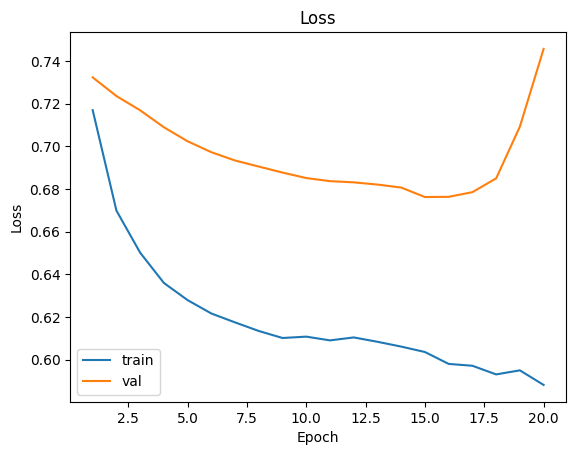

🗺️  Cedar_2003_10_next: IoU=0.182 → /content/unet_runs/run_20250917_085152/mosaics/Cedar_2003_10_next_map.html
🗺️  LaBrea_2009_08: IoU=0.429 → /content/unet_runs/run_20250917_085152/mosaics/LaBrea_2009_08_map.html
🗺️  Nuns_2017_10: IoU=0.252 → /content/unet_runs/run_20250917_085152/mosaics/Nuns_2017_10_map.html
🗺️  Station_2009_08_next: IoU=0.425 → /content/unet_runs/run_20250917_085152/mosaics/Station_2009_08_next_map.html

Per-event IoU:
 - Cedar_2003_10_next: 0.182
 - LaBrea_2009_08: 0.429
 - Nuns_2017_10: 0.252
 - Station_2009_08_next: 0.425
Mean IoU: 0.322

Artifacts:
 - run dir: /content/unet_runs/run_20250917_085152
   * checkpoints: best.pt, epoch_XXX.pt, weights_only.pt, tiny_unet_script.pt
   * history.csv + loss plot
   * mosaics/: per-event pred/target/confusion PNGs + *_pred.npy/*_target.npy + optional *_map.html


In [ ]:
# ==================== Tiny U-Net (16x16) w/ Early Stopping + Safe I/O + Visuals ====================
# - Patches: /content/patches16_balanced_clean_nowater_provenance
# - Split: your fixed event-wise split (no leakage)
# - NaN-safe stats + Dataset
# - Checkpoints: future-proof (lists, not numpy) so torch.load(..., weights_only=True) works
# - Outputs: best.pt, weights_only.pt, tiny_unet_script.pt
# - Visuals: per-event mosaics (pred/target/confusion PNGs) + optional Folium map overlays

!pip -q install torch torchvision matplotlib pandas numpy scikit-learn tqdm folium google-cloud-storage rasterio pyproj

import os, json, random, time, io, gc
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optional map overlays (works if index has GCS blob paths)
import folium
from folium.raster_layers import ImageOverlay
import rasterio
from rasterio.io import MemoryFile
from pyproj import Transformer
from google.cloud import storage
from PIL import Image

# -------------------- Paths --------------------
PATCH_ROOT = "/content/patches16_balanced_clean_nowater_provenance"
INDEX_CSV  = f"{PATCH_ROOT}/index.csv"
RUNS_DIR   = "/content/unet_runs"
ART_DIR    = "/content/unet_artifacts"  # extra visuals (created as needed)
Path(RUNS_DIR).mkdir(parents=True, exist_ok=True)
Path(ART_DIR).mkdir(parents=True, exist_ok=True)

# -------------------- Fixed split (yours) --------------------
TRAIN_EVENTS = [
    "FallFire_2007_10", "MendoCx_2018_08", "Cedar_2003_10", "Carr_2018_07_next",
    "Station_2009_08", "Tubbs_2017_10", "Thomas_2017_12", "Atlas_2017_10", "Camp_2018_11"
]
VAL_EVENTS  = ["Carr_2018_07"]
TEST_EVENTS = ["Cedar_2003_10_next", "Station_2009_08_next", "Nuns_2017_10", "LaBrea_2009_08"]

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------- Load index --------------------
df = pd.read_csv(INDEX_CSV)
assert {"tile_id","event","evm_blob","burn_blob","label","row","col","patch_size"}.issubset(df.columns), "Index schema mismatch."
df["tile_path"] = df.apply(lambda r: f"{PATCH_ROOT}/{r['event']}/{r['tile_id']}.npz", axis=1)
df = df[df["tile_path"].apply(lambda p: os.path.exists(p))].reset_index(drop=True)

def df_for_events(events): return df[df["event"].isin(events)].reset_index(drop=True)
df_tr, df_va, df_te = df_for_events(TRAIN_EVENTS), df_for_events(VAL_EVENTS), df_for_events(TEST_EVENTS)

print("Train events:", sorted(df_tr.event.unique().tolist()))
print("Val events:",   sorted(df_va.event.unique().tolist()))
print("Test events:",  sorted(df_te.event.unique().tolist()))

# -------------------- Dataset (NaN-safe + dtype-safe) --------------------
class PatchDataset(Dataset):
    def __init__(self, frame, norm=None, augment=False):
        self.frame = frame.reset_index(drop=True)
        self.augment = augment
        self.norm = norm  # {'mean':(C,), 'std':(C,)}
    def __len__(self): return len(self.frame)
    def __getitem__(self, i):
        r = self.frame.iloc[i]
        d = np.load(r.tile_path)
        x = d["x"].astype(np.float32)          # (C,H,W)
        y = d["y"].astype(np.float32)          # (H,W) in {0,1}
        # sanitize any stragglers
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        # normalize
        if self.norm is not None:
            mu, sd = self.norm["mean"], self.norm["std"]
            x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        # light augments
        if self.augment:
            if random.random() < 0.5:
                x = x[..., ::-1].copy(); y = y[..., ::-1].copy()  # H-flip
            if random.random() < 0.5:
                x = x[:, ::-1, :].copy(); y = y[::-1, :].copy()  # V-flip
            k = random.randint(0,3)  # 0/90/180/270
            if k:
                x = np.rot90(x, k, axes=(1,2)).copy()
                y = np.rot90(y, k, axes=(0,1)).copy()
            if random.random() < 0.3:  # mild brightness jitter
                s = float(np.clip(np.random.normal(1.0, 0.05), 0.8, 1.2))  # ← ensure python float
                x = x * s
        # ---- dtype fix: force float32 right before tensor conversion
        x = x.astype(np.float32, copy=False)   # ← dtype fix
        y = y.astype(np.float32, copy=False)   # ← dtype fix
        return torch.from_numpy(x).float(), torch.from_numpy(y[None,...]).float(), r.event, r.tile_id  # ← dtype fix

# -------------------- Compute train mean/std (NaN-safe) --------------------
def compute_channel_stats(frame, max_tiles=2000):
    samp = frame.sample(min(len(frame), max_tiles), random_state=SEED) if len(frame)>max_tiles else frame
    ch_sum = None; ch_sq = None; n_pix = 0
    for p in tqdm(samp["tile_path"], desc="Stats"):
        x = np.load(p)["x"].astype(np.float32)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        C,H,W = x.shape
        if ch_sum is None:
            ch_sum = np.zeros((C,), np.float64)
            ch_sq  = np.zeros((C,), np.float64)
        xr = x.reshape(C,-1)
        ch_sum += xr.sum(axis=1)
        ch_sq  += (xr*xr).sum(axis=1)
        n_pix  += H*W
    mean = (ch_sum / max(n_pix,1)).astype(np.float32)
    var  = (ch_sq / max(n_pix,1) - mean**2).astype(np.float32)
    std  = np.sqrt(np.clip(var, 1e-8, None))
    return {"mean": mean, "std": std}

norm_stats = compute_channel_stats(df_tr)
if not np.isfinite(norm_stats["mean"]).all() or not np.isfinite(norm_stats["std"]).all():
    raise RuntimeError("Non-finite channel stats; check input patches.")
norm_stats["std"][norm_stats["std"]==0] = 1.0
print("Channel mean:", np.round(norm_stats["mean"],4))
print("Channel std :", np.round(norm_stats["std"],4))

# -------------------- Model --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.seq(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=13, base=16):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1= nn.MaxPool2d(2)            # 16->8
        self.enc2 = DoubleConv(base, base*2)
        self.pool2= nn.MaxPool2d(2)            # 8->4
        self.bott = DoubleConv(base*2, base*4)
        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)  # 4->8
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1  = nn.ConvTranspose2d(base*2, base, 2, stride=2)    # 8->16
        self.dec1 = DoubleConv(base*2, base)
        self.out  = nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        b  = self.bott(p2)
        u2 = self.up2(b);  d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, e1], dim=1))
        return self.out(d1)

# -------------------- Loss & metrics --------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth=smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2*(probs*targets).sum(dim=(1,2,3)) + self.smooth
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.smooth
        return 1 - (num/den).mean()

def bce_dice_loss(logits, y):
    return 0.5*F.binary_cross_entropy_with_logits(logits, y) + 0.5*DiceLoss()(logits, y)

@torch.no_grad()
def compute_iou(logits, y, thresh=0.5, eps=1e-7):
    p = (torch.sigmoid(logits) > thresh).float()
    inter = (p*y).sum(dim=(1,2,3))
    union = (p+y - p*y).sum(dim=(1,2,3)) + eps
    return (inter/union).mean().item()

# -------------------- DataLoaders --------------------
BATCH_SIZE  = 256
NUM_WORKERS = 2
ds_tr = PatchDataset(df_tr, norm=norm_stats, augment=True)
ds_va = PatchDataset(df_va, norm=norm_stats, augment=False)
ds_te = PatchDataset(df_te, norm=norm_stats, augment=False)
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------- Train (Early Stopping) --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = TinyUNet(in_ch=13, base=16).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
EPOCHS = 40
PATIENCE = 5

run_dir = Path(RUNS_DIR)/time.strftime("run_%Y%m%d_%H%M%S")
(run_dir/"mosaics").mkdir(parents=True, exist_ok=True)
history = []

best_val = 1e9; best_ep = 0; bad_epochs = 0
for epoch in range(1, EPOCHS+1):
    # train
    model.train(); tr_loss=tr_iou=0.0
    for x,y,_,_ in tqdm(dl_tr, desc=f"Epoch {epoch}/{EPOCHS} [train]"):
        x = x.to(device, non_blocking=True).float()  # ← dtype fix
        y = y.to(device, non_blocking=True).float()  # ← dtype fix
        opt.zero_grad()
        logits = model(x)
        loss = bce_dice_loss(logits, y)
        loss.backward(); opt.step()
        tr_loss += loss.item() * x.size(0)
        tr_iou  += compute_iou(logits.detach(), y.detach()) * x.size(0)
    tr_loss/=len(ds_tr); tr_iou/=len(ds_tr)
    sched.step()

    # val
    model.eval(); va_loss=va_iou=0.0
    with torch.no_grad():
        for x,y,_,_ in tqdm(dl_va, desc=f"Epoch {epoch}/{EPOCHS} [val]"):
            x = x.to(device).float()  # ← dtype fix
            y = y.to(device).float()  # ← dtype fix
            logits = model(x)
            loss = bce_dice_loss(logits, y)
            va_loss += loss.item() * x.size(0)
            va_iou  += compute_iou(logits, y) * x.size(0)
    va_loss/=len(ds_va); va_iou/=len(ds_va)

    history.append(dict(epoch=epoch, tr_loss=tr_loss, tr_iou=tr_iou, va_loss=va_loss, va_iou=va_iou))
    print(f"Epoch {epoch}: train {tr_loss:.4f}/IoU {tr_iou:.3f} | val {va_loss:.4f}/IoU {va_iou:.3f}")

    # future-proof checkpoint (lists, not numpy)
    norm_stats_safe = {"mean": norm_stats["mean"].tolist(), "std": norm_stats["std"].tolist()}
    ckpt = {
        "epoch": epoch, "model": model.state_dict(), "optimizer": opt.state_dict(),
        "norm_stats": norm_stats_safe,
        "train_events": TRAIN_EVENTS, "val_events": VAL_EVENTS, "test_events": TEST_EVENTS,
    }
    torch.save(ckpt, run_dir/f"epoch_{epoch:03d}.pt")

    if va_loss < best_val - 1e-5:
        best_val = va_loss; best_ep = epoch; bad_epochs = 0
        torch.save(ckpt, run_dir/"best.pt")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print(f"⏹️ Early stopping at epoch {epoch} (best={best_ep}, val_loss={best_val:.4f})")
            break

# Save history + loss plot
pd.DataFrame(history).to_csv(run_dir/"history.csv", index=False)
plt.figure();
plt.plot([h["epoch"] for h in history],[h["tr_loss"] for h in history],label="train")
plt.plot([h["epoch"] for h in history],[h["va_loss"] for h in history],label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

# -------------------- Save extra formats --------------------
torch.save(model.state_dict(), run_dir/"weights_only.pt")
model.eval()
example = torch.zeros(1, 13, 16, 16, dtype=torch.float32, device=device)
scripted = torch.jit.trace(model, example); scripted.save(str(run_dir/"tiny_unet_script.pt"))

# -------------------- Load best safely --------------------
ckpt = torch.load(run_dir/"best.pt", map_location=device, weights_only=True)
model.load_state_dict(ckpt["model"]); model.eval()
norm_stats_loaded = {
    "mean": np.array(ckpt["norm_stats"]["mean"], dtype=np.float32),
    "std":  np.array(ckpt["norm_stats"]["std"],  dtype=np.float32),
}

# -------------------- Inference helpers (mosaic + images + optional Folium) --------------------
def _save_png(arr01, path, cmap="inferno", title=None):
    arr01 = np.nan_to_num(arr01, nan=0.0)
    plt.figure(figsize=(6,6)); plt.imshow(np.clip(arr01,0,1), cmap=cmap, vmin=0, vmax=1)
    plt.axis("off");
    if title: plt.title(title)
    plt.savefig(path, bbox_inches="tight"); plt.close()

# GCS helpers for Folium (works only if you have permissions in this runtime)
gcs_client = None
def open_gcs_tif(uri_in_bucket):
    # index stores evm_blob like 'evms_events/...tif' inside bucket 'california-fire-model'
    global gcs_client
    if gcs_client is None:
        try: gcs_client = storage.Client()
        except: raise RuntimeError("GCS client unavailable. Skip Folium overlays or auth GCP.")
    bucket = gcs_client.bucket("california-fire-model")
    blob = bucket.blob(uri_in_bucket)
    data = blob.download_as_bytes()
    mem = MemoryFile(data); ds = mem.open()
    return ds, mem

def bounds_wgs84_from_evm_blob(evm_blob_path):
    ds, mem = open_gcs_tif(evm_blob_path)
    try:
        to_wgs84 = Transformer.from_crs(ds.crs, "EPSG:4326", always_xy=True)
        b = ds.bounds
        min_lon, min_lat = to_wgs84.transform(b.left,  b.bottom)
        max_lon, max_lat = to_wgs84.transform(b.right, b.top)
        return [[min_lat, min_lon],[max_lat, max_lon]]
    finally:
        ds.close(); mem.close()

@torch.no_grad()
def infer_event(event_name, out_dir, thr=0.5, make_map=True):
    sub = df_te[df_te["event"]==event_name].copy()
    if sub.empty:
        print(f"[skip] No test tiles for {event_name}")
        return None
    H = int(sub["row"].max()+sub["patch_size"].max())
    W = int(sub["col"].max()+sub["patch_size"].max())
    pred   = np.zeros((H,W), np.float32)
    target = np.zeros((H,W), np.float32)
    cover  = np.zeros((H,W), np.uint8)

    mu, sd = norm_stats_loaded["mean"], norm_stats_loaded["std"]
    for _,r in sub.iterrows():
        d = np.load(f"{PATCH_ROOT}/{r.event}/{r.tile_id}.npz")
        x = d["x"].astype(np.float32)
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = (x - mu[:,None,None]) / (sd[:,None,None] + 1e-6)
        y = d["y"].astype(np.float32)

        xt = torch.from_numpy(x[None,...]).to(device).float()  # ← dtype fix
        p  = torch.sigmoid(model(xt))[0,0].cpu().numpy()

        y0,y1 = r.row, r.row+int(r.patch_size); x0,x1 = r.col, r.col+int(r.patch_size)
        pred[y0:y1, x0:x1]   = p
        target[y0:y1, x0:x1] = y
        cover[y0:y1, x0:x1]  = 1

    m  = cover>0
    pb = pred>thr; yb = target>0.5
    tp = (pb & yb & m).sum(); fp = (pb & (~yb) & m).sum(); fn = ((~pb) & yb & m).sum()
    iou = tp / (tp + fp + fn + 1e-7)

    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir/f"{event_name}_pred.npy", pred)
    np.save(out_dir/f"{event_name}_target.npy", target)
    _save_png(pred,   out_dir/f"{event_name}_pred.png",   cmap="inferno", title=f"{event_name} • prediction (prob.)")
    _save_png(target, out_dir/f"{event_name}_target.png", cmap="gray",    title=f"{event_name} • ground truth")

    # Confusion RGBA: TP=green, FP=yellow, FN=magenta, TN transparent (only where covered)
    conf = np.zeros((H,W,4), np.uint8)
    conf[...,1] = (pb & yb & m) * 255    # G
    conf[...,0] = (pb & (~yb) & m) * 255 # R
    conf[...,2] = ((~pb) & yb & m) * 255 # B
    conf[...,3] = ((pb | yb) & m) * 160  # alpha
    Image.fromarray(conf).save(out_dir/f"{event_name}_confusion.png")

    # Optional Folium map using EVM bounds
    if make_map:
        try:
            bounds = bounds_wgs84_from_evm_blob(sub.iloc[0]["evm_blob"])
            max_edge = 2000
            scale = max(1, int(max(H,W)/max_edge))
            def rgba(mask, color, alpha):
                h,w = mask.shape
                z = np.zeros((h,w,4), np.uint8)
                z[...,0],z[...,1],z[...,2] = color
                z[...,3] = (mask.astype(np.uint8)*alpha).astype(np.uint8)
                return z
            pb_s, yb_s = pb[::scale,::scale], yb[::scale,::scale]
            tp_s, fp_s, fn_s = pb_s & yb_s, pb_s & (~yb_s), (~pb_s) & yb_s

            mapp = folium.Map(location=[np.mean([bounds[0][0],bounds[1][0]]),
                                        np.mean([bounds[0][1],bounds[1][1]])],
                              zoom_start=8, tiles=None)
            folium.TileLayer("OpenStreetMap", name="Streets").add_to(mapp)
            ImageOverlay(rgba(yb_s,(255,0,0),120),   bounds, name="Ground Truth (burned)", opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(pb_s,(0,255,255),120), bounds, name="Prediction (>0.5)",     opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(tp_s,(0,255,0),180),   bounds, name="TP",                    opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(fp_s,(255,255,0),180), bounds, name="FP",                    opacity=1.0).add_to(mapp)
            ImageOverlay(rgba(fn_s,(255,0,255),180), bounds, name="FN",                    opacity=1.0).add_to(mapp)
            folium.LayerControl(collapsed=False).add_to(mapp)
            mapp.save(str(out_dir/f"{event_name}_map.html"))
            print(f"🗺️  {event_name}: IoU={iou:.3f} → {out_dir/f'{event_name}_map.html'}")
        except Exception as e:
            print(f"[Folium] {event_name}: overlay skipped ({e}); IoU={iou:.3f}")
    else:
        print(f"{event_name}: IoU={iou:.3f}")

    return float(iou)

# -------------------- Evaluate best on TEST --------------------
mosaic_dir = run_dir / "mosaics"
scores = {}
for ev in sorted(TEST_EVENTS):
    s = infer_event(ev, mosaic_dir, thr=0.5, make_map=True)
    if s is not None: scores[ev] = s

if scores:a
    print("\nPer-event IoU:")
    for k, v in scores.items(): print(f" - {k}: {v:.3f}")
    print(f"Mean IoU: {np.mean(list(scores.values())):.3f}")

print("\nArtifacts:")
print(" - run dir:", run_dir)
print("   * checkpoints: best.pt, epoch_XXX.pt, weights_only.pt, tiny_unet_script.pt")
print("   * history.csv + loss plot")
print("   * mosaics/: per-event pred/target/confusion PNGs + *_pred.npy/*_target.npy + optional *_map.html")


In [ ]:
# ---- Scan patches for NaN/Inf/empty features; write a CSV report ----
import os, numpy as np, pandas as pd
from pathlib import Path

PATCH_ROOT = "/content/patches16_balanced_clean_nowater_provenance"
INDEX_CSV  = f"{PATCH_ROOT}/index.csv"
REPORT_CSV = "/content/data_health_report.csv"

df = pd.read_csv(INDEX_CSV)
df["tile_path"] = df.apply(lambda r: f"{PATCH_ROOT}/{r['event']}/{r['tile_id']}.npz", axis=1)
df = df[df["tile_path"].apply(os.path.exists)].reset_index(drop=True)

rows = []
for _, r in df.iterrows():
    p = r.tile_path
    try:
        d = np.load(p)
        x = d["x"]           # (C,H,W)
        y = d["y"]           # (H,W)
        C = x.shape[0]
        # per-channel finite mask
        ch_nan  = np.array([np.isnan(x[c]).any()  for c in range(C)], dtype=bool)
        ch_inf  = np.array([np.isinf(x[c]).any()  for c in range(C)], dtype=bool)
        ch_all0 = np.array([(np.isfinite(x[c]).all() and np.all(x[c]==0)) for c in range(C)], dtype=bool)

        any_nan   = bool(np.isnan(x).any())
        any_inf   = bool(np.isinf(x).any())
        all_zeroC = bool(np.all([np.isfinite(x[c]).all() and np.all(x[c]==0) for c in range(C)]))
        # label emptiness (not an error, just for info)
        label_pos_frac = float(np.mean(y>0))

        rows.append(dict(
            event=r.event, tile_id=r.tile_id, path=p,
            any_nan=any_nan, any_inf=any_inf, all_channels_zero=all_zeroC,
            nan_channels=",".join([str(i) for i,b in enumerate(ch_nan) if b]),
            inf_channels=",".join([str(i) for i,b in enumerate(ch_inf) if b]),
            zero_channels=",".join([str(i) for i,b in enumerate(ch_all0) if b]),
            label_pos_frac=round(label_pos_frac,4)
        ))
    except Exception as e:
        rows.append(dict(
            event=r.event, tile_id=r.tile_id, path=p,
            any_nan=True, any_inf=False, all_channels_zero=False,
            nan_channels="err", inf_channels="", zero_channels="", label_pos_frac=-1.0
        ))

rep = pd.DataFrame(rows)
rep.to_csv(REPORT_CSV, index=False)

print("=== Health summary by event ===")
print(rep.groupby("event")[["any_nan","any_inf","all_channels_zero"]].sum())
print("\nTotals:")
print(rep[["any_nan","any_inf","all_channels_zero"]].sum())
print(f"\nReport saved → {REPORT_CSV}")

# Show which specific tiles are bad
bad = rep[(rep.any_nan) | (rep.any_inf)]
if not bad.empty:
    print("\nExamples of bad tiles:")
    display(bad.head(10))
else:
    print("\nNo NaN/Inf found 🎉")


=== Health summary by event ===
                      any_nan  any_inf  all_channels_zero
event                                                    
Atlas_2017_10              22        0                  0
Camp_2018_11               16        0                  0
Carr_2018_07               14        0                  0
Carr_2018_07_next          36        0                  0
Cedar_2003_10              36        0                  0
Cedar_2003_10_next         12        0                  0
FallFire_2007_10           61        0                  0
LaBrea_2009_08             10        0                  0
MendoCx_2018_08            50        0                  0
Nuns_2017_10               22        0                  0
Station_2009_08            20        0                  0
Station_2009_08_next       27        0                  0
Thomas_2017_12             20        0                  0
Tubbs_2017_10              31        0                  0

Totals:
any_nan              377
any_in

event                      tile_id  \
0  Atlas_2017_10    Atlas_2017_10_r48_c0_ps16   
1  Atlas_2017_10   Atlas_2017_10_r96_c16_ps16   
2  Atlas_2017_10    Atlas_2017_10_r80_c0_ps16   
3  Atlas_2017_10  Atlas_2017_10_r144_c48_ps16   
4  Atlas_2017_10   Atlas_2017_10_r80_c48_ps16   
5  Atlas_2017_10   Atlas_2017_10_r96_c64_ps16   
6  Atlas_2017_10   Atlas_2017_10_r96_c48_ps16   
7  Atlas_2017_10   Atlas_2017_10_r80_c16_ps16   
8  Atlas_2017_10   Atlas_2017_10_r96_c32_ps16   
9  Atlas_2017_10  Atlas_2017_10_r112_c16_ps16   

                                                path  any_nan  any_inf  \
0  /content/patches16_balanced_clean_nowater_prov...     True    False   
1  /content/patches16_balanced_clean_nowater_prov...     True    False   
2  /content/patches16_balanced_clean_nowater_prov...     True    False   
3  /content/patches16_balanced_clean_nowater_prov...     True    False   
4  /content/patches16_balanced_clean_nowater_prov...     True    False   
5  /content/patches16_balanced_clean_nowater_prov...     True    False   
6  /content/patches16_balanced_clean_nowater_prov...     True    False   
7  /content/patches16_balanced_clean_nowater_prov...     True    False   
8  /content/patches16_balanced_clean_nowater_prov...     True    False   
9  /content/patches16_balanced_clean_nowater_prov...     True    False   

   all_channels_zero                  nan_channels inf_channels zero_channels  \
0              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
1              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
2              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
3              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
4              False                          8,11                              
5              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
6              False                          8,11                              
7              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              
8              False                          8,11                              
9              False  0,1,2,3,4,5,6,7,8,9,10,11,12                              

   label_pos_frac  
0          0.0703  
1          0.3672  
2          0.0977  
3          0.0039  
4          0.4453  
5          0.0117  
6          0.8398  
7          0.3711  
8          0.4102  
9          0.3594

In [ ]:
import folium
import geemap.foliumap as gf  # <-- Folium backend

# Create a map per event (Folium backend)
for event_folder, tiles in preview_by_event.items():
    base_name, y, m, is_next = parse_event_folder(event_folder)
    if is_next:
        if m == 12: y_map, m_map = y + 1, 1
        else:       y_map, m_map = y, m + 1
    else:
        y_map, m_map = y, m

    # AOI center if we know counties; else center on tiles
    if base_name in event_counties:
        aoi = aoi_from_counties(event_counties[base_name])
        center = aoi.centroid(1000).coordinates().getInfo()[::-1]  # [lat, lon]
    else:
        lats = [(r["bbox"][1] + r["bbox"][3]) / 2 for r in tiles]
        lons = [(r["bbox"][0] + r["bbox"][2]) / 2 for r in tiles]
        center = [float(np.mean(lats)), float(np.mean(lons))]

    mapp = gf.Map(center=center, zoom=8)  # <-- Folium map

    # Burned mask (red) for that month
    burn_img = burned_mask_ee(y_map, m_map)
    mapp.addLayer(burn_img.visualize(min=0, max=1, palette=['#ff0000']), {}, f'Burned {y_map}-{m_map:02d}')

    # AOI outline (blue), if known
    if base_name in event_counties:
        mapp.addLayer(aoi, {'color':'#2222ff'}, 'AOI')

    # Draw rectangles for selected tiles
    for r in tiles:
        min_lon, min_lat, max_lon, max_lat = r["bbox"]
        color = '#ff0000' if r["label"] == "burned" else '#1f77b4'
        rect = folium.Rectangle(
            bounds=[[min_lat, min_lon], [max_lat, max_lon]],
            color=color, weight=2, fill=False,
            tooltip=f"{r['label'].upper()} – {r['tile_id']}",
            popup=folium.Popup(r["tile_id"], max_width=300),
        )
        rect.add_to(mapp)

    out_html = os.path.join(MAP_DIR, f"{event_folder}.html")
    mapp.save(out_html)   # <-- use save() with Folium backend
    print("🗺️  Saved map:", out_html)



🗺️  Saved map: /content/event_maps/Atlas_2017_10.html
🗺️  Saved map: /content/event_maps/Camp_2018_11.html
🗺️  Saved map: /content/event_maps/Carr_2018_07.html
🗺️  Saved map: /content/event_maps/Carr_2018_07_next.html
🗺️  Saved map: /content/event_maps/Cedar_2003_10.html
🗺️  Saved map: /content/event_maps/FallFire_2007_10.html
🗺️  Saved map: /content/event_maps/LaBrea_2009_08.html
🗺️  Saved map: /content/event_maps/MendoCx_2018_08.html
🗺️  Saved map: /content/event_maps/Station_2009_08.html
🗺️  Saved map: /content/event_maps/Station_2009_08_next.html
🗺️  Saved map: /content/event_maps/Thomas_2017_12.html


In [ ]:
def check_pair(name, counties, y, m):
    aoi = aoi_from_counties(counties)
    s,e = month_range(y,m)

    evm = evm_image(s,e,aoi)
    burn = burned_image(s,e,aoi)  # from your burned-mask cell

    # band count
    bn = evm.bandNames().size()
    # projections (stringify for quick compare)
    pj_evm = evm.projection().crs()
    pj_bur = burn.projection().crs()
    sc_evm = evm.projection().nominalScale()
    sc_bur = burn.projection().nominalScale()

    print(f"{name} {y}-{m:02d}  | bands: {bn.getInfo()}  | CRS match: {pj_evm.getInfo()==pj_bur.getInfo()}  | scale(m): {sc_evm.getInfo()}, {sc_bur.getInfo()}")

for name, counties, (yr, mo) in events:
    check_pair(name, counties, yr, mo)
    if INCLUDE_NEXT_MONTH:
        mo2 = 1 if mo==12 else mo+1; yr2 = yr + (mo==12)
        check_pair(name+"_next", counties, yr2, mo2)


Cedar_2003_10 2003-10  | bands: 13  | CRS match: True  | scale(m): 500, 500
Cedar_2003_10_next 2003-11  | bands: 13  | CRS match: True  | scale(m): 500, 500
FallFire_2007_10 2007-10  | bands: 13  | CRS match: True  | scale(m): 500, 500
FallFire_2007_10_next 2007-11  | bands: 13  | CRS match: True  | scale(m): 500, 500
Station_2009_08 2009-08  | bands: 13  | CRS match: True  | scale(m): 500, 500
Station_2009_08_next 2009-09  | bands: 13  | CRS match: True  | scale(m): 500, 500
LaBrea_2009_08 2009-08  | bands: 13  | CRS match: True  | scale(m): 500, 500
LaBrea_2009_08_next 2009-09  | bands: 13  | CRS match: True  | scale(m): 500, 500
Thomas_2017_12 2017-12  | bands: 13  | CRS match: True  | scale(m): 500, 500
Thomas_2017_12_next 2018-01  | bands: 13  | CRS match: True  | scale(m): 500, 500
Atlas_2017_10 2017-10  | bands: 13  | CRS match: True  | scale(m): 500, 500
Atlas_2017_10_next 2017-11  | bands: 13  | CRS match: True  | scale(m): 500, 500
Tubbs_2017_10 2017-10  | bands: 13  | CRS ma

In [ ]:
!gsutil ls gs://california-fire-model/evms_events/*/*.tif*
!gsutil ls gs://california-fire-model/burned_events/*/*.tif*


gs://california-fire-model/evms_events/Atlas_2017_10/EVM13_Atlas_2017_10_2017-10_WGS84_500m.tif
gs://california-fire-model/evms_events/Atlas_2017_10/EVM_Atlas_2017_10_2017-10.tif
gs://california-fire-model/evms_events/Atlas_2017_10_next/EVM13_Atlas_2017_10_next_2017-11_WGS84_500m.tif
gs://california-fire-model/evms_events/Atlas_2017_10_next/EVM_Atlas_2017_10_next_2017-11.tif
gs://california-fire-model/evms_events/Camp_2018_11/EVM13_Camp_2018_11_2018-11_WGS84_500m.tif
gs://california-fire-model/evms_events/Camp_2018_11/EVM_Camp_2018_11_2018-11.tif
gs://california-fire-model/evms_events/Camp_2018_11_next/EVM13_Camp_2018_11_next_2018-12_WGS84_500m.tif
gs://california-fire-model/evms_events/Camp_2018_11_next/EVM_Camp_2018_11_next_2018-12.tif
gs://california-fire-model/evms_events/Carr_2018_07/EVM13_Carr_2018_07_2018-07_WGS84_500m.tif
gs://california-fire-model/evms_events/Carr_2018_07/EVM_Carr_2018_07_2018-07.tif
gs://california-fire-model/evms_events/Carr_2018_07_next/EVM13_Carr_2018_07_n

In [ ]:
# ============================
# End-to-end: fetch rasters + build footprints with fallback-to-next
# ============================
!pip -q install rasterio

import os, csv, json, glob, subprocess, numpy as np
from pathlib import Path
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject

# ----------------------------
# Config
# ----------------------------
BUCKET = "california-fire-model"
PATCH_ROOT = "/content"
LOCAL_EVM_DIR = "/content/data/evms_events"
LOCAL_BURN_DIR = "/content/data/burned_events"
Path(LOCAL_EVM_DIR).mkdir(parents=True, exist_ok=True)
Path(LOCAL_BURN_DIR).mkdir(parents=True, exist_ok=True)

EXPECTED_HW = 16     # your patch size
STRIDE      = 16     # window stride when deriving from scratch
NEG_PER_POS = 1.0    # subsample negatives
USE_NEXT_IF_MISSING = True
RANDOM_SEED = 1337
rng = np.random.default_rng(RANDOM_SEED)

# Your events list must exist; define it if missing
if 'events' not in globals():
    events = [
        ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
        ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
        ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
        ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
        ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
        ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
        ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
        ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
        ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
        ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
        ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
    ]

# ----------------------------
# Helpers
# ----------------------------
def _gs_ls(pat):
    r = subprocess.run(f'gsutil ls "{pat}"', shell=True, capture_output=True, text=True)
    return [ln.strip() for ln in r.stdout.splitlines() if ln.strip()]

def _gs_cp(pat, dst_dir):
    subprocess.run(f'gsutil -m cp -n "{pat}" "{dst_dir}"', shell=True, check=False)

def mirror_available_for(event_base, yr, mo):
    """Mirror base month and _next month (if present) to local."""
    ym = f"{yr}-{mo:02d}"
    # base
    pat_evm  = f'gs://{BUCKET}/evms_events/{event_base}/EVM13_{event_base}_{ym}_WGS84_500m.tif*'
    pat_burn = f'gs://{BUCKET}/burned_events/{event_base}/Burned_{event_base}_{ym}_WGS84_500m.tif*'
    for pat, dst in [(pat_evm, LOCAL_EVM_DIR), (pat_burn, LOCAL_BURN_DIR)]:
        if _gs_ls(pat): _gs_cp(pat, dst)

    # next (in case base missing but next exists)
    mo2 = 1 if mo == 12 else mo + 1
    yr2 = yr + 1 if mo == 12 else yr
    evn = f"{event_base}_next"
    ym2 = f"{yr2}-{mo2:02d}"
    pat_evm2  = f'gs://{BUCKET}/evms_events/{evn}/EVM13_{evn}_{ym2}_WGS84_500m.tif*'
    pat_burn2 = f'gs://{BUCKET}/burned_events/{evn}/Burned_{evn}_{ym2}_WGS84_500m.tif*'
    for pat, dst in [(pat_evm2, LOCAL_EVM_DIR), (pat_burn2, LOCAL_BURN_DIR)]:
        if _gs_ls(pat): _gs_cp(pat, dst)

def _find_one(patterns, root_dirs):
    """Find a local .tif (prefer .tif over .tif.aux.xml)."""
    for d in root_dirs:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(d, pat), recursive=True)
                    if h.lower().endswith(".tif")]
            if hits:
                return sorted(hits)[0]
    return None

def _next_year_month(yr, mo):
    return (yr + 1, 1) if mo == 12 else (yr, mo + 1)

def find_pair_with_fallback(event_base, yr, mo):
    """Return (burn_tif, evm_tif, used_event_name, used_ym).
       Tries base first; if missing and USE_NEXT_IF_MISSING, tries _next month."""
    root_dirs = [LOCAL_EVM_DIR, LOCAL_BURN_DIR, "/content"]
    ym = f"{yr}-{mo:02d}"

    # base search
    evm = _find_one([
        f"EVM13_{event_base}_{ym}_WGS84_500m.tif",
        f"*{event_base}*{ym}*EVM13*WGS84_500m.tif",
    ], [LOCAL_EVM_DIR, "/content"])
    burn = _find_one([
        f"Burned_{event_base}_{ym}_WGS84_500m.tif",
        f"*Burned*{event_base}*{ym}*WGS84_500m.tif",
    ], [LOCAL_BURN_DIR, "/content"])

    if evm and burn:
        return burn, evm, event_base, ym

    # fallback to next
    if USE_NEXT_IF_MISSING:
        yr2, mo2 = _next_year_month(yr, mo)
        ym2 = f"{yr2}-{mo2:02d}"
        evn = f"{event_base}_next"  # exported that way
        evm2 = _find_one([
            f"EVM13_{evn}_{ym2}_WGS84_500m.tif",
            f"*{evn}*{ym2}*EVM13*WGS84_500m.tif",
        ], [LOCAL_EVM_DIR, "/content"])
        burn2 = _find_one([
            f"Burned_{evn}_{ym2}_WGS84_500m.tif",
            f"*Burned*{evn}*{ym2}*WGS84_500m.tif",
        ], [LOCAL_BURN_DIR, "/content"])
        if evm2 and burn2:
            return burn2, evm2, evn, ym2

    raise FileNotFoundError(f"No local EVM/Burned pair for {event_base} {ym}. "
                            f"Run the mirror step or check export status.")

def reproject_to_match(src_path, ref_path, resampling=RS.nearest):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def window_polygon(transform, x0, y0, w, h):
    left,  top    = transform * (x0,     y0)
    right, bottom = transform * (x0 + w, y0 + h)
    return [[left, top], [right, top], [right, bottom], [left, bottom], [left, top]]

def build_footprints(event_base, yr, mo):
    """Create patch_footprints.geojson (pos/neg) for base or fallback-next.
       If fallback used, also write a copy under the requested base folder so your Folium cell still finds it."""
    # mirror what exists for this event
    mirror_available_for(event_base, yr, mo)

    # find pair (may fallback to next)
    burn_tif, evm_tif, used_event_name, used_ym = find_pair_with_fallback(event_base, yr, mo)

    # load ref grid
    with rasterio.open(evm_tif) as ds:
        H, W = ds.height, ds.width
        tfm  = ds.transform

    # align burned mask to EVM grid
    burn = reproject_to_match(burn_tif, evm_tif, resampling=RS.nearest)
    burn = (burn > 0).astype(np.uint8)

    # slide windows to produce pos/neg
    pos_feats, neg_feats = [], []
    h = w = EXPECTED_HW
    neg_candidates = []
    for y0 in range(0, H - h + 1, STRIDE):
        for x0 in range(0, W - w + 1, STRIDE):
            win = burn[y0:y0+h, x0:x0+w]
            if win.any():
                pid = f"pos_{len(pos_feats):05d}"
                geom = {"type":"Polygon","coordinates":[window_polygon(tfm, x0, y0, w, h)]}
                pos_feats.append({"type":"Feature","geometry":geom,"properties":{"id":pid,"kind":"pos"}})
            else:
                neg_candidates.append((y0, x0))

    # subsample negatives
    n_pos = len(pos_feats)
    n_neg_target = int(max(1, NEG_PER_POS * n_pos))
    if neg_candidates and n_neg_target > 0:
        idx = rng.choice(len(neg_candidates), size=min(n_neg_target, len(neg_candidates)), replace=False)
        for k, i in enumerate(idx):
            y0, x0 = neg_candidates[i]
            pid = f"neg_{k:05d}"
            geom = {"type":"Polygon","coordinates":[window_polygon(tfm, x0, y0, w, h)]}
            neg_feats.append({"type":"Feature","geometry":geom,"properties":{"id":pid,"kind":"neg"}})

    feats = pos_feats + neg_feats
    gj = {"type":"FeatureCollection", "features":feats}

    # write under the grid actually used (used_ym) ...
    used_dir = Path(f"{PATCH_ROOT}/patches_{event_base}_{used_ym}")
    used_dir.mkdir(parents=True, exist_ok=True)
    (used_dir / "patch_footprints.geojson").write_text(json.dumps(gj))

    # ...and if we fell back, also copy under the requested base month so your Folium cell finds it
    base_ym = f"{yr}-{mo:02d}"
    if used_ym != base_ym:
        base_dir = Path(f"{PATCH_ROOT}/patches_{event_base}_{base_ym}")
        base_dir.mkdir(parents=True, exist_ok=True)
        (base_dir / "patch_footprints.geojson").write_text(json.dumps(gj))

    print(f"✓ {event_base}: footprints pos={len(pos_feats)} neg={len(neg_feats)} "
          f"(grid from {used_event_name} {used_ym})")
    return len(pos_feats), len(neg_feats), used_ym

# ----------------------------
# Run for all events
# ----------------------------
built = []
for event_base, _counties, (yr, mo) in events:
    try:
        p, n, used_ym = build_footprints(event_base, yr, mo)
        built.append((event_base, f"{yr}-{mo:02d}", used_ym, p, n))
    except Exception as e:
        print(f"!! {event_base} {yr}-{mo:02d}: {e}")

print("\nDone.")
for ev, ym_req, ym_used, p, n in built:
    tag = "" if ym_req == ym_used else f"  (used {ym_used})"
    print(f" - {ev} {ym_req}: pos={p} neg={n}{tag}")


✓ Cedar_2003_10: footprints pos=54 neg=54 (grid from Cedar_2003_10 2003-10)
✓ FallFire_2007_10: footprints pos=99 neg=99 (grid from FallFire_2007_10 2007-10)
✓ Station_2009_08: footprints pos=24 neg=24 (grid from Station_2009_08 2009-08)
✓ LaBrea_2009_08: footprints pos=14 neg=14 (grid from LaBrea_2009_08 2009-08)
✓ Thomas_2017_12: footprints pos=43 neg=43 (grid from Thomas_2017_12 2017-12)
✓ Atlas_2017_10: footprints pos=22 neg=22 (grid from Atlas_2017_10 2017-10)
✓ Tubbs_2017_10: footprints pos=40 neg=40 (grid from Tubbs_2017_10 2017-10)
✓ Nuns_2017_10: footprints pos=25 neg=25 (grid from Nuns_2017_10 2017-10)
✓ Camp_2018_11: footprints pos=31 neg=31 (grid from Camp_2018_11 2018-11)
✓ Carr_2018_07: footprints pos=22 neg=22 (grid from Carr_2018_07 2018-07)
✓ MendoCx_2018_08: footprints pos=57 neg=57 (grid from MendoCx_2018_08 2018-08)

Done.
 - Cedar_2003_10 2003-10: pos=54 neg=54
 - FallFire_2007_10 2007-10: pos=99 neg=99
 - Station_2009_08 2009-08: pos=24 neg=24
 - LaBrea_2009_08 20

In [ ]:
# --- Folium maps for ALL events (burn overlay aligned to EVM grid + patch boxes) ---
!pip -q install folium pillow rasterio

import os, io, json, base64
import numpy as np
from PIL import Image
import folium
from folium.raster_layers import ImageOverlay
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject
from pathlib import Path

PATCH_ROOT = "/content"       # where patches_<event>_<YYYY-MM>/ lives
MAX_EDGE   = 2000             # downsample overlay for snappy maps
ALPHA      = 180              # burned overlay opacity

def _b64_inline_png(path, max_px=256):
    if not os.path.exists(path): return ""
    with Image.open(path) as im:
        im.thumbnail((max_px, max_px))
        buf = io.BytesIO(); im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def _popup_html(OUT, pid, kind):
    rgb64  = _b64_inline_png(os.path.join(OUT, f"{pid}_rgb.png"))
    burn64 = _b64_inline_png(os.path.join(OUT, f"{pid}_burn.png"))
    return f"""
    <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
      <b>{pid}</b> &nbsp; <span style="color:{'red' if kind=='pos' else 'gold'}">({kind})</span><br/>
      {'<img src="data:image/png;base64,'+rgb64+'" style="margin-right:8px;"/>' if rgb64 else ''}
      {'<img src="data:image/png;base64,'+burn64+'"/>' if burn64 else ''}
    </div>"""

# helpers to find rasters
import glob
SEARCH_DIRS = ["/content/data/evms_events", "/content/data/burned_events", "/content"]

def _find_one(patterns):
    for d in SEARCH_DIRS:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(d, pat), recursive=True)
                    if h.lower().endswith(".tif")]
            if hits: return sorted(hits)[0]
    return None

def copy_pair(event_base, year_month):
    evm = _find_one([
        f"**/EVM13_{event_base}_{year_month}_WGS84_500m.tif",
        f"**/*{event_base}*{year_month}*EVM13*WGS84_500m*.tif",
    ])
    if evm is None:
        raise FileNotFoundError(f"EVM13 for {event_base} {year_month} not found under {SEARCH_DIRS}")

    burn = _find_one([
        f"**/Burned_{event_base}_{year_month}_WGS84_500m.tif",
        f"**/*Burned*{event_base}*{year_month}*WGS84_500m*.tif",
    ])
    if burn is None:
        raise FileNotFoundError(f"Burned for {event_base} {year_month} not found under {SEARCH_DIRS}")

    with rasterio.open(evm) as ds:
        if ds.crs is None or ds.crs.to_string() != "EPSG:4326":
            raise RuntimeError(f"EVM CRS is {ds.crs}, expected EPSG:4326: {evm}")
    return burn, evm

def reproject_to_match(src_path, ref_path, resampling=RS.nearest):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def build_map_for_event(event_base, yr, mo):
    year_month = f"{yr}-{mo:02d}"
    OUT = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    gj_path = f"{OUT}/patch_footprints.geojson"

    if not os.path.exists(gj_path):
        print(f"!! Missing {gj_path}, skipping {event_base} {year_month}")
        return None

    with open(gj_path) as f:
        gj = json.load(f)
    coords = []
    for feat in gj.get("features", []):
        if feat.get("geometry", {}).get("type") != "Polygon": continue
        ring = feat["geometry"]["coordinates"][0]
        coords.extend(ring)
    if not coords:
        print(f"!! No polygon coords in {gj_path}, skipping"); return None

    center_lat = sum(y for x,y in coords) / len(coords)
    center_lon = sum(x for x,y in coords) / len(coords)

    try:
        burn_tif, evm_tif = copy_pair(event_base, year_month)
    except Exception as e:
        print("!!", e); return None

    with rasterio.open(evm_tif) as eds:
        H, W = eds.height, eds.width
        bounds = eds.bounds

    burn_aligned = reproject_to_match(burn_tif, evm_tif)
    burn_mask = (burn_aligned > 0).astype(np.uint8)

    overlay = np.zeros((H,W,4), dtype=np.uint8)
    overlay[...,0] = 255
    overlay[...,3] = burn_mask * ALPHA

    scale = max(1, int(max(H,W) / MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :]

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri, Maxar, etc.", name="Imagery").add_to(m)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left],[bounds.top,bounds.right]],
        opacity=1.0, name="MODIS Burned (red)", zindex=500
    ).add_to(m)

    fg_pos = folium.FeatureGroup(name="Pos patches", show=True)
    fg_neg = folium.FeatureGroup(name="Neg patches", show=False)
    pos_count = neg_count = 0

    for feat in gj["features"]:
        props = feat.get("properties", {}) or {}
        kind = props.get("kind","pos"); pid = props.get("id","patch")
        ring = feat["geometry"]["coordinates"][0]
        latlngs = [(lat, lon) for lon, lat in ring]
        rect = folium.Polygon(
            locations=latlngs,
            color=("red" if kind=="pos" else "gold"),
            weight=(2 if kind=="pos" else 1.5),
            fill=False,
            tooltip=f"{pid} ({kind})",
            popup=folium.Popup(_popup_html(OUT, pid, kind), max_width=650),
        )
        if kind=="pos": fg_pos.add_child(rect); pos_count+=1
        else: fg_neg.add_child(rect); neg_count+=1

    fg_pos.add_to(m); fg_neg.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)

    caption = f"""
    <div style='position: fixed; bottom:10px; left:10px; z-index:9999;
                background: rgba(255,255,255,0.9); border-radius:8px; padding:8px 10px;
                font-family: system-ui, Roboto, Arial; font-size: 13px;'>
      <b>{event_base} — {year_month}</b><br/>
      <span style="color:#d00;">Red overlay</span>: MODIS burned pixels<br/>
      <span style="color:red;">Red boxes</span>: pos &nbsp; <span style="color:gold;">Gold</span>: neg<br/>
      Pos: {pos_count} &nbsp; Neg: {neg_count}
    </div>"""
    m.get_root().html.add_child(folium.Element(caption))

    out_html = f"{OUT}/map_{event_base}_{year_month}.html"
    m.save(out_html)
    print(f"✓ Saved map → {out_html}")
    return out_html

# Build maps for all events you have footprints for
built = []
for d in sorted(Path(PATCH_ROOT).glob("patches_*_*")):
    try:
        base = d.name.split("patches_")[1]
        ev, ym = base.rsplit("_", 1)
        yr, mo = map(int, ym.split("-"))
        hp = build_map_for_event(ev, yr, mo)
        if hp: built.append(hp)
    except Exception as e:
        print("!!", d, e)

print("\nBuilt", len(built), "maps. Open any saved HTML from the left file browser.")


✓ Saved map → /content/patches_Atlas_2017_10_2017-10/map_Atlas_2017_10_2017-10.html
✓ Saved map → /content/patches_Camp_2018_11_2018-11/map_Camp_2018_11_2018-11.html
✓ Saved map → /content/patches_Carr_2018_07_2018-07/map_Carr_2018_07_2018-07.html
✓ Saved map → /content/patches_Cedar_2003_10_2003-10/map_Cedar_2003_10_2003-10.html
✓ Saved map → /content/patches_FallFire_2007_10_2007-10/map_FallFire_2007_10_2007-10.html
✓ Saved map → /content/patches_LaBrea_2009_08_2009-08/map_LaBrea_2009_08_2009-08.html
✓ Saved map → /content/patches_MendoCx_2018_08_2018-08/map_MendoCx_2018_08_2018-08.html
✓ Saved map → /content/patches_Nuns_2017_10_2017-10/map_Nuns_2017_10_2017-10.html
✓ Saved map → /content/patches_Station_2009_08_2009-08/map_Station_2009_08_2009-08.html
✓ Saved map → /content/patches_Thomas_2017_12_2017-12/map_Thomas_2017_12_2017-12.html
✓ Saved map → /content/patches_Tubbs_2017_10_2017-10/map_Tubbs_2017_10_2017-10.html

Built 11 maps. Open any saved HTML from the left file browser.


In [ ]:
# Re-run this to regenerate thumbnails safely (skips/handles NaNs)
!pip -q install rasterio pillow
import json, numpy as np, glob, os
from pathlib import Path
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject
from PIL import Image

EXPECTED_HW = 16

def reproject_to_match(src_path, ref_path, resampling=RS.nearest):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=np.float32)
        reproject(
            source=rasterio.band(src,1), destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def safe_percentiles(a, p1=2, p2=98):
    # if all NaN or flat, fall back to 0..1
    if not np.isfinite(a).any():
        return 0.0, 1.0
    a2 = a[np.isfinite(a)]
    lo = np.percentile(a2, p1); hi = np.percentile(a2, p2)
    if hi <= lo:
        mn, mx = np.min(a2), np.max(a2)
        if mx <= mn: return 0.0, 1.0
        return mn, mx
    return lo, hi

def p_stretch(a):
    a = a.astype(np.float32)
    lo, hi = safe_percentiles(a, 2, 98)
    out = (a - lo) / (hi - lo + 1e-6)
    out[~np.isfinite(out)] = 0.0
    return np.clip(out, 0, 1)

def evm_preview_rgb(evm_arr):
    # EVM13 order: [tmax,tmin,precip,wind,humidity,eto,aridity,NDVI,LAI,elev,slope,LFMC,NLCD]
    R = p_stretch(evm_arr[6])  # aridity
    G = p_stretch(evm_arr[7])  # NDVI
    B = p_stretch(evm_arr[2])  # precip
    rgb = np.stack([R,G,B], axis=-1)
    rgb = np.nan_to_num(rgb, nan=0.0)
    return (np.clip(rgb,0,1)*255 + 0.5).astype(np.uint8)

def _find_one(patterns):
    for d in ["/content/data/evms_events","/content/data/burned_events","/content"]:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(d, pat), recursive=True) if h.lower().endswith(".tif")]
            if hits: return sorted(hits)[0]
    return None

def regen_patch_pngs(event_base, year_month):
    folder = Path(f"/content/patches_{event_base}_{year_month}")
    gj_path = folder / "patch_footprints.geojson"
    if not gj_path.exists(): return 0
    with open(gj_path) as f: gj = json.load(f)

    evm_tif = _find_one([f"**/EVM13_{event_base}_{year_month}_WGS84_500m.tif",
                         f"**/*{event_base}*{year_month}*EVM13*WGS84_500m*.tif"])
    burn_tif= _find_one([f"**/Burned_{event_base}_{year_month}_WGS84_500m.tif",
                         f"**/*Burned*{event_base}*{year_month}*WGS84_500m*.tif"])
    if not evm_tif or not burn_tif: return 0

    with rasterio.open(evm_tif) as ds:
        tfm = ds.transform; H, W = ds.height, ds.width
        evm_arr = ds.read(out_dtype="float32")  # (13,H,W)
    burn = reproject_to_match(burn_tif, evm_tif)
    burn = (burn > 0).astype(np.uint8)

    def rc_from_lonlat(lon, lat):
        c, r = ~tfm * (lon, lat)
        return int(round(r)), int(round(c))

    count=0
    for feat in gj["features"]:
        pid  = feat["properties"]["id"]
        ring = feat["geometry"]["coordinates"][0]
        lon, lat = ring[0]
        r0, c0 = rc_from_lonlat(lon, lat)
        r1, c1 = r0+EXPECTED_HW, c0+EXPECTED_HW
        if r0<0 or c0<0 or r1>H or c1>W: continue

        patch_evm = evm_arr[:, r0:r1, c0:c1]
        patch_rgb = evm_preview_rgb(patch_evm)
        Image.fromarray(patch_rgb).save(folder / f"{pid}_rgb.png")

        patch_burn = (burn[r0:r1, c0:c1] * 255).astype(np.uint8)
        Image.fromarray(patch_burn).save(folder / f"{pid}_burn.png")
        count += 1
    print(f"{event_base} {year_month}: regenerated {count} PNGs")
    return count

total=0
for d in sorted(Path("/content").glob("patches_*_*")):
    base = d.name.split("patches_")[1]
    ev, ym = base.rsplit("_", 1)
    total += regen_patch_pngs(ev, ym)
print("Total regenerated:", total)


Atlas_2017_10 2017-10: regenerated 44 PNGs
Camp_2018_11 2018-11: regenerated 62 PNGs
Carr_2018_07 2018-07: regenerated 44 PNGs
Cedar_2003_10 2003-10: regenerated 108 PNGs
FallFire_2007_10 2007-10: regenerated 198 PNGs
LaBrea_2009_08 2009-08: regenerated 28 PNGs
MendoCx_2018_08 2018-08: regenerated 114 PNGs
Nuns_2017_10 2017-10: regenerated 50 PNGs
Station_2009_08 2009-08: regenerated 48 PNGs
Thomas_2017_12 2017-12: regenerated 86 PNGs
Tubbs_2017_10 2017-10: regenerated 80 PNGs
Total regenerated: 862


✓ Cedar 2003_10: pos=22  neg=22  →  /content/patches_Cedar_2003_10/map_Cedar_2003_10.html



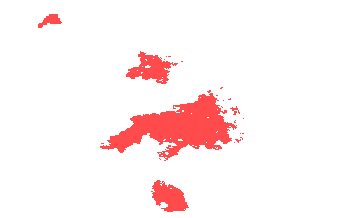

✓ FallFire 2007_10: pos=32  neg=32  →  /content/patches_FallFire_2007_10/map_FallFire_2007_10.html



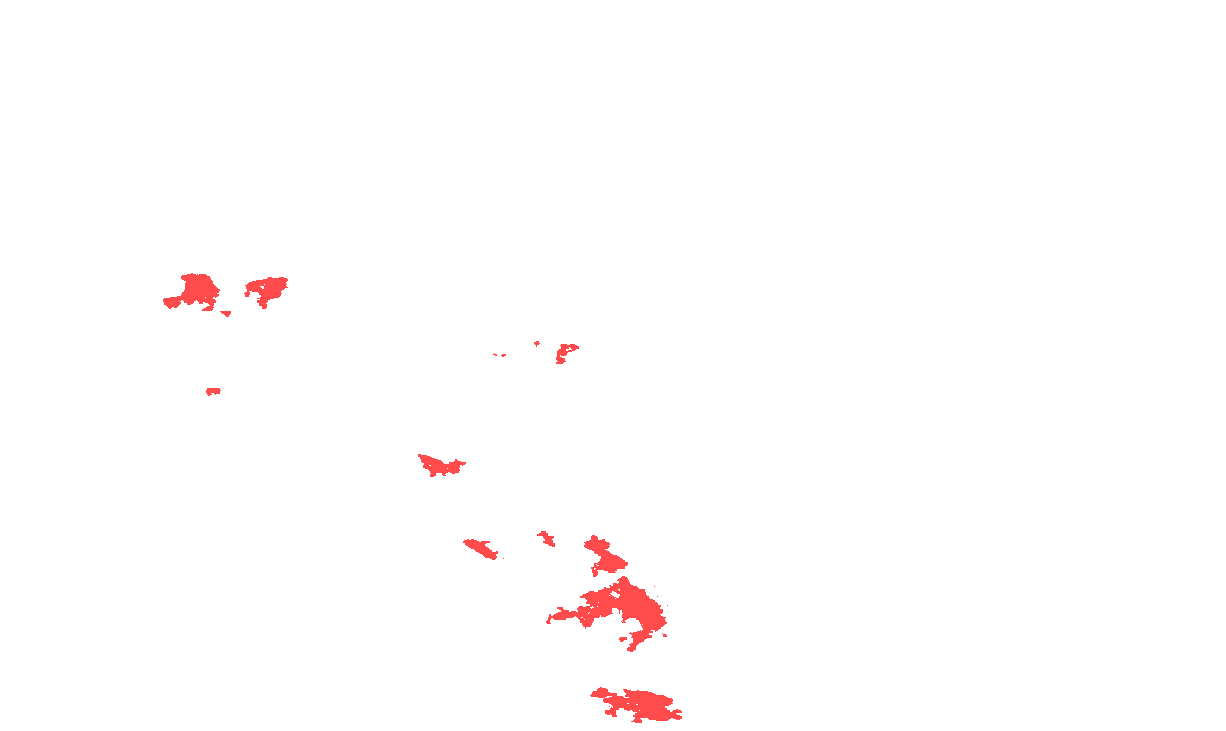

✓ Station 2009_08: pos=7  neg=7  →  /content/patches_Station_2009_08/map_Station_2009_08.html



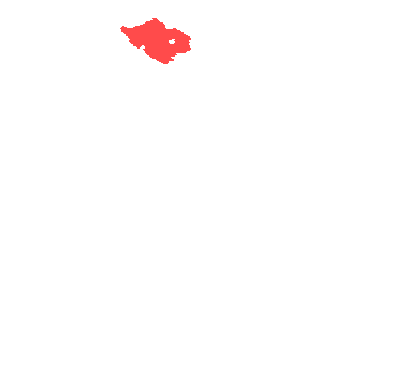

✓ LaBrea 2009_08: pos=7  neg=7  →  /content/patches_LaBrea_2009_08/map_LaBrea_2009_08.html



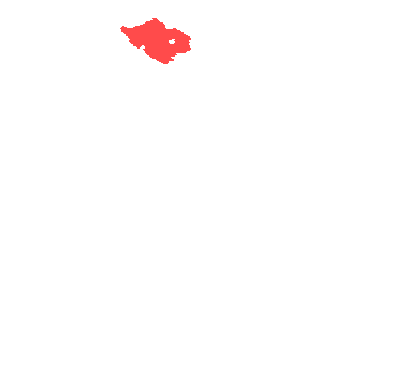

✓ Thomas 2017_12: pos=20  neg=20  →  /content/patches_Thomas_2017_12/map_Thomas_2017_12.html



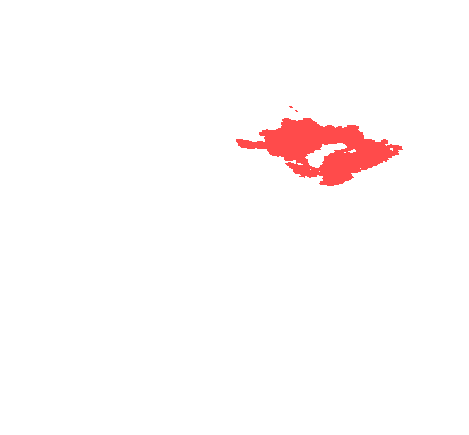

✓ Atlas 2017_10: pos=3  neg=3  →  /content/patches_Atlas_2017_10/map_Atlas_2017_10.html



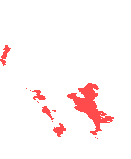

✓ Tubbs 2017_10: pos=3  neg=3  →  /content/patches_Tubbs_2017_10/map_Tubbs_2017_10.html



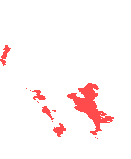

✓ Nuns 2017_10: pos=3  neg=3  →  /content/patches_Nuns_2017_10/map_Nuns_2017_10.html



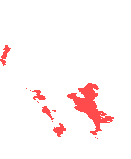

✓ Camp 2018_11: pos=9  neg=9  →  /content/patches_Camp_2018_11/map_Camp_2018_11.html



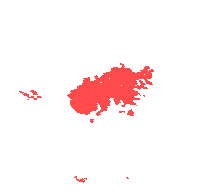

✓ Carr 2018_07: pos=10  neg=10  →  /content/patches_Carr_2018_07/map_Carr_2018_07.html



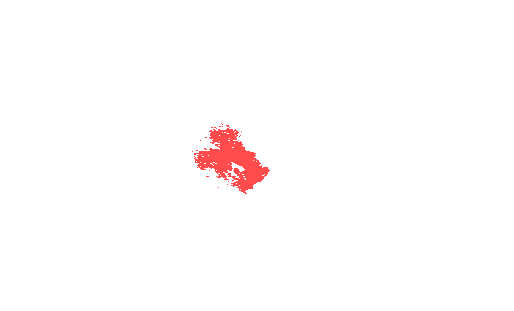

✓ MendoCx 2018_08: pos=24  neg=24  →  /content/patches_MendoCx_2018_08/map_MendoCx_2018_08.html



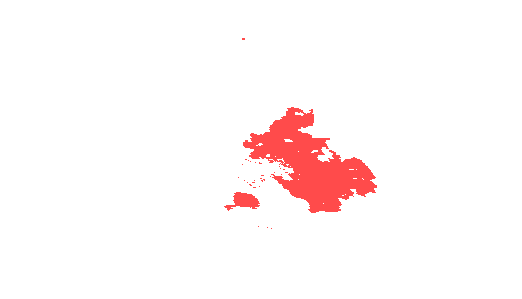


Totals: 140 positives; 140 negatives
Index page written: /content/maps_index.html


In [ ]:
# ================== Patch footprints (balanced 1:1, snapped, no-overlap) + provenance + Folium maps ==================
!pip -q install rasterio shapely scipy folium pillow

import os, glob, json, random, subprocess, io, base64, shlex, re
import numpy as np
from pathlib import Path
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject
from shapely.geometry import Polygon, mapping
from scipy import ndimage as ndi
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from PIL import Image
from rasterio.windows import Window

# -------- paths / config --------
BUCKET      = "california-fire-model"
PATCH_ROOT  = "/content"
LOCAL_EVM   = "/content/data/evms_events"      # we mirror evms_events/ or evms/ into here
LOCAL_BURN  = "/content/data/burned_events"    # we mirror burned_events/ or burned_area/ into here
LOCAL_RGB   = "/content/data/modis_rgb_events" # optional thumbnails
for d in [LOCAL_EVM, LOCAL_BURN, LOCAL_RGB]:
    Path(d).mkdir(parents=True, exist_ok=True)

# -------- sampling + patch config --------
PATCH_HW        = 16     # patch size (H=W)
STRIDE          = 16     # slide step (set >= PATCH_HW to guarantee no overlap)
POS_FRAC        = 0.60   # ≥60% of *clustered* burn in the window
CLUSTER_MIN_PX  = 50     # min pixels for a component to count as a "cluster"
DILATE_PIX      = 1      # light dilation to merge gaps (0 disables)
POS_MAX         = 200    # upper cap for positives per event (for runtime control)

# Balanced 1:1 negatives, sampled around each positive in expanding rings
BALANCE_1_TO_1          = True
NEG_PER_POS             = 1
RING_RADII              = [PATCH_HW, 2*PATCH_HW, 3*PATCH_HW, 4*PATCH_HW, 6*PATCH_HW, 8*PATCH_HW]
RING_SAMPLES_PER_RADIUS = 48

# Map settings
MAP_MAX_EDGE    = 2000   # downsample overlay for snappy Folium map
ALPHA           = 180    # overlay opacity (0–255)
SHOW_ALL_MAPS   = True   # show every map inline
BUILD_MAP_INDEX = True   # also write a gallery index
IFRAME_HEIGHT   = 600

# Optional chip saving (off by default)
SAVE_PATCHES    = True
PATCH_FORMAT    = "npz"  # "npz" or "tif"

# -------- event stem normalization / mapping --------
NAME_MAP = {
    "Cedar":   "CedarFire",
    "FallFire":"Fall",                # change to "FallFire" if your files use that
    "Station": "StationFire",
    "LaBrea":  "LaBreaFire",
    "Thomas":  "ThomasFire",
    "Atlas":   "AtlasFire",
    "Tubbs":   "TubbsFire",
    "Nuns":    "NunsFire",
    "Camp":    "CampFire",
    "Carr":    "CarrFire",
    "MendoCx": "MendocinoComplex",
}

def normalize_event_month(ev, ym):
    """Strip accidental _YYYY_MM (or -) from ev; force ym to YYYY_MM."""
    m = re.search(r"(.*?)[_-]?(20\d{2})[_-](\d{2})$", ev)
    if m:
        ev = (m.group(1) or "").rstrip("_-")
        if not ym or not re.match(r"^20\d{2}[_-]\d{2}$", ym):
            ym = f"{m.group(2)}_{m.group(3)}"
    ym = ym.replace("-", "_")
    ev = ev.rstrip("_-")
    return ev, ym

def _run(cmd):
    try:
        out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
        return [ln.strip() for ln in out.splitlines() if ln.strip()]
    except subprocess.CalledProcessError:
        return []

def _gs_ls(pat):
    return _run(f'gsutil ls "{pat}"')

def _gs_cp_one(src, dst_dir):
    subprocess.run(f'gsutil -m cp -n "{src}" "{dst_dir}"', shell=True, check=False)

def _find_one(patterns, roots):
    for root in roots:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(root, pat), recursive=True) if h.lower().endswith(".tif")]
            if hits: return sorted(hits)[0]
    return None

# -------- mirror from GCS (robust patterns + fallbacks) --------
def mirror_event_month(event_base, ym):
    """
    EVM: prefer evms_events/*_{ym}*EVM*.tif, fallback evms/*_{ym}*EVM*.tif, final evms/*_{ym}*.tif
    Burn: prefer burned_events/{stem}_{ym}*.tif (or *{stem}*_{ym}*.tif), fallback burned_area/*_{ym}*.tif
    RGB:  optional modis_rgb_events/* patterns (if present)
    """
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)

    evm_candidates = (
        _gs_ls(f'gs://{BUCKET}/evms_events/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms_events/*EVM*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*.tif')
    )
    burn_candidates = (
        _gs_ls(f'gs://{BUCKET}/burned_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_events/*{stem}*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_area/*_{ym}*.tif')
    )
    rgb_candidates = (
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/*{stem}*_{ym}*.tif') or
        []
    )

    any_found = False
    if evm_candidates:
        _gs_cp_one(evm_candidates[0], LOCAL_EVM); any_found = True
    if burn_candidates:
        _gs_cp_one(burn_candidates[0], LOCAL_BURN); any_found = True
    if rgb_candidates:
        _gs_cp_one(rgb_candidates[0], LOCAL_RGB); any_found = True
    return any_found

# -------- reprojection helpers --------
def reproject_band(src_path, ref_path, band_index=1, resampling=RS.nearest, out_dtype=np.float32):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=out_dtype)
        reproject(
            source=rasterio.band(src, band_index), destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def read_burn_mask_to_match(brn_path, ref_path):
    with rasterio.open(brn_path) as src:
        band_index = 2 if src.count >= 2 else 1  # prefer BurnMask if present
    burn = reproject_band(brn_path, ref_path, band_index=band_index, resampling=RS.nearest, out_dtype=np.float32)
    return (burn > 0).astype(np.uint8)

# -------- geometry & tiny thumbnail helpers --------
def polygon_from_window(tfm, x0, y0, w, h):
    p1 = tfm * (x0,     y0)
    p2 = tfm * (x0+w,   y0)
    p3 = tfm * (x0+w,   y0+h)
    p4 = tfm * (x0,     y0+h)
    return [(p1[0],p1[1]),(p2[0],p2[1]),(p3[0],p3[1]),(p4[0],p4[1]),(p1[0],p1[1])]

def lonlat_corners(tfm, x0, y0, w, h):
    poly = polygon_from_window(tfm, x0, y0, w, h)
    (ul_lon, ul_lat) = poly[0]; (lr_lon, lr_lat) = poly[2]
    cx_lon = (ul_lon + lr_lon)/2; cx_lat = (ul_lat + lr_lat)/2
    return poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat

def small_patch_png_from_rgb(rgb_tif, evm_tif, x0, y0, w=PATCH_HW, h=PATCH_HW):
    try:
        with rasterio.open(evm_tif) as ref:
            H,W = ref.height, ref.width
        if not rgb_tif: return ""
        rgb = np.zeros((3,H,W), dtype=np.float32)
        for b in range(1,4):
            rgb[b-1] = reproject_band(rgb_tif, evm_tif, band_index=b, resampling=RS.bilinear, out_dtype=np.float32)
        rgb = np.clip(rgb, 0, 1)
        crop = np.moveaxis(rgb[:, y0:y0+h, x0:x0+w], 0, -1)  # (h,w,3)
        crop8 = (crop*255+0.5).astype(np.uint8)
        im = Image.fromarray(crop8).resize((96,96), Image.NEAREST)
        buf = io.BytesIO(); im.save(buf, format="PNG")
        return base64.b64encode(buf.getvalue()).decode("utf-8")
    except Exception:
        return ""

# -------- optional chip writers --------
def _write_chip_npz(src, y0, x0, h, w, burn_raw, out_path, meta):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    y = burn_raw[y0:y0+h, x0:x0+w].astype(np.uint8) # (H,W)
    np.savez_compressed(out_path, x=x, y=y, meta=meta)

def _write_chip_tif(src, y0, x0, h, w, out_path):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    prof = src.profile.copy()
    prof.update(height=h, width=w, transform=rasterio.windows.transform(win, src.transform))
    with rasterio.open(out_path, "w", **prof) as dst:
        dst.write(x)

def save_patches(evm_tif, burn_raw, pos_windows, neg_windows, out_dir, event, ym):
    chips_dir = Path(out_dir) / "chips"
    (chips_dir / "pos").mkdir(parents=True, exist_ok=True)
    (chips_dir / "neg").mkdir(parents=True, exist_ok=True)
    with rasterio.open(evm_tif) as src:
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            meta = {"event":event,"ym":ym,"kind":"pos","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                    "cluster_id":cid,"cluster_size":int(csize)}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"pos/pos_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"pos/pos_{i:05d}.tif")
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_windows):
            meta = {"event":event,"ym":ym,"kind":"neg","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"neg/neg_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"neg/neg_{i:05d}.tif")

# -------- main: build footprints + manifest + folium map (BALANCED 1:1, SNAP-TO-GRID, NO-OVERLAP) --------
def build_footprints_from_burn(event_base, ym):
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)

    # ensure files are mirrored locally (no-op if already present)
    mirror_event_month(ev, ym)

    # Flexible local search:
    # EVM by date only; allow variants (EVM/EVM13 in name, or any tif with the date)
    evm_tif = _find_one([
        f"**/*_{ym}*EVM*.tif",
        f"**/*EVM*_{ym}*.tif",
        f"**/*_{ym}*.tif",
    ], [LOCAL_EVM, "/content"])

    # Burn prefer per-event; else monthly burned_area
    brn_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
        f"**/*_{ym}*.tif",
    ], [LOCAL_BURN, "/content"])

    rgb_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
    ], [LOCAL_RGB, "/content"])

    if not evm_tif or not brn_tif:
        print(f"!! Missing EVM/Burn for {ev}_{ym} {ym.replace('_','-')}")
        return 0,0,None

    with rasterio.open(evm_tif) as ds:
        H,W = ds.height, ds.width
        tfm  = ds.transform
        bounds = ds.bounds

    burn_raw = read_burn_mask_to_match(brn_tif, evm_tif)  # (H,W) {0,1}

    # --- clusterization (connected components on (optionally) dilated mask) ---
    burn = burn_raw.copy()
    if DILATE_PIX > 0:
        burn = ndi.binary_dilation(burn, iterations=DILATE_PIX).astype(np.uint8)
    labels, num = ndi.label(burn)
    sizes = np.bincount(labels.ravel())
    keep = np.zeros_like(sizes, dtype=bool)
    keep[1:] = sizes[1:] >= CLUSTER_MIN_PX
    cluster_mask = keep[labels].astype(np.uint8)  # 1 where in a "kept" cluster

    # --- scan windows ---
    pos_windows, neg_windows = [], []
    for y0 in range(0, H - PATCH_HW + 1, STRIDE):
        for x0 in range(0, W - PATCH_HW + 1, STRIDE):
            win_c = cluster_mask[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            win_b = burn_raw[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            frac_c = float(win_c.mean())
            frac_b = float(win_b.mean())
            if frac_c >= POS_FRAC:
                # majority label for provenance
                lbl = labels[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
                vals, cnts = np.unique(lbl[lbl>0], return_counts=True)
                cid = int(vals[np.argmax(cnts)]) if vals.size else 0
                pos_windows.append((y0, x0, frac_c, frac_b, cid, int(sizes[cid] if cid>0 else 0)))
            elif frac_b == 0.0:
                neg_windows.append((y0, x0, 0.0, 0.0, 0, 0))

    # === START: NO-OVERLAP BALANCED 1:1 NEG SAMPLING (SNAP-TO-GRID) ===
    random.shuffle(pos_windows); random.shuffle(neg_windows)
    pos_windows = pos_windows[:min(POS_MAX, len(pos_windows))]

    # occupancy grid in STRIDE cells; mark every positive cell as occupied
    Hc, Wc = (H // STRIDE) + 1, (W // STRIDE) + 1
    occ = np.zeros((Hc, Wc), dtype=bool)
    for (y0,x0,_,_,_,_) in pos_windows:
        occ[y0 // STRIDE, x0 // STRIDE] = True

    def _snap(v, step, lo, hi):
        s = int(round(v / step) * step)
        return max(lo, min(s, hi))

    def _try_place(yc, xc):
        # snap to STRIDE grid and reject overlaps / burned windows
        y = _snap(yc, STRIDE, 0, H - PATCH_HW)
        x = _snap(xc, STRIDE, 0, W - PATCH_HW)
        cy, cx = y // STRIDE, x // STRIDE
        if occ[cy, cx]:
            return None
        if burn_raw[y:y+PATCH_HW, x:x+PATCH_HW].any():
            return None
        occ[cy, cx] = True
        return (y, x, 0.0, 0.0, 0, 0)

    neg_pairs = []   # list of (pos_index, neg_window_tuple)

    # 1) ring-based neg for each positive
    for i, (y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
        placed = None
        for rad in RING_RADII:
            for _ in range(RING_SAMPLES_PER_RADIUS):
                theta = random.random() * 2*np.pi
                yc = int(round(y0 + rad * np.sin(theta)))
                xc = int(round(x0 + rad * np.cos(theta)))
                cand = _try_place(yc, xc)
                if cand:
                    placed = cand
                    break
            if placed:
                break
        if placed:
            neg_pairs.append((i, placed))

    # 2) fallback from global empty windows (also snapped & non-overlapping)
    for (y0,x0,fc,fb,cid,csize) in neg_windows:
        if len(neg_pairs) >= NEG_PER_POS * len(pos_windows): break
        cand = _try_place(y0, x0)
        if cand:
            next_i = len(neg_pairs)
            if next_i < len(pos_windows):
                neg_pairs.append((next_i, cand))

    # strict 1:1 alignment
    n_pairs = min(len(pos_windows), len(neg_pairs), NEG_PER_POS * len(pos_windows))
    pos_windows = pos_windows[:n_pairs]
    neg_pairs = sorted(neg_pairs[:n_pairs], key=lambda t: t[0])
    neg_sel = [cand for _, cand in neg_pairs]

    if BALANCE_1_TO_1:
        assert len(pos_windows) == len(neg_sel)
    # === END: NO-OVERLAP BALANCED 1:1 NEG SAMPLING (SNAP-TO-GRID) ===

    # --- write outputs / provenance ---
    out_dir = Path(f"{PATCH_ROOT}/patches_{ev}_{ym}")
    out_dir.mkdir(parents=True, exist_ok=True)

    manifest = out_dir/"manifest.csv"
    with open(manifest, "w") as f:
        f.write("event,ym,id,kind,y0,x0,h,w,cluster_frac,burn_frac,cluster_id,cluster_size,"
                "ul_lon,ul_lat,lr_lon,lr_lat,cx_lon,cx_lat,evm_path,burn_path,rgb_path,pair_to\n")

        feats=[]
        pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
        neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]

        # positives
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            pid = pos_ids[i]
            pair_to = neg_ids[i] if i < len(neg_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":pid,"kind":"pos","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{pid},pos,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

        # negatives (aligned 1:1 with positives)
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_sel):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            nid = neg_ids[i]
            pair_to = pos_ids[i] if i < len(pos_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":nid,"kind":"neg","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{nid},neg,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

    with open(out_dir/"patch_footprints.geojson","w") as f:
        json.dump({"type":"FeatureCollection","features":feats}, f)

    # --- Folium map with burned overlay + patch polygons + pairing lines ---
    overlay = np.zeros((H,W,4), dtype=np.uint8)
    overlay[...,0]=255; overlay[...,3]=(burn_raw*ALPHA).astype(np.uint8)
    scale = max(1, int(max(H,W)/MAP_MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :]

    # center: mean of polygon centers (or raster center)
    if feats:
        clats = [ft["geometry"]["coordinates"][0][0][1] for ft in feats]
        clons = [ft["geometry"]["coordinates"][0][0][0] for ft in feats]
        c_lat = float(np.mean(clats)); c_lon = float(np.mean(clons))
    else:
        c_lat = (bounds.top+bounds.bottom)/2; c_lon=(bounds.left+bounds.right)/2

    m = folium.Map(location=[c_lat, c_lon], zoom_start=10, tiles=None)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri, Maxar", name="Imagery").add_to(m)
    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left],[bounds.top,bounds.right]],
        opacity=1.0, name="MODIS Burned (red)", zindex=500).add_to(m)

    # Draw polygons + popups
    id2center = {}
    for ft in feats:
        p = ft["properties"]; ring = ft["geometry"]["coordinates"][0]
        latlngs = [(lat, lon) for lon,lat in ring]
        # center (for connectors)
        cx_lon = (ring[0][0] + ring[2][0]) / 2
        cx_lat = (ring[0][1] + ring[2][1]) / 2
        id2center[p["id"]] = (cx_lat, cx_lon)

        thumb64 = small_patch_png_from_rgb(p.get("rgb_path"), p["evm_path"], p["x0"], p["y0"], PATCH_HW, PATCH_HW)
        thumb_html = f'<img src="data:image/png;base64,{thumb64}" style="width:96px;height:96px;margin-right:6px;border:1px solid #ccc;"/>' if thumb64 else ''
        popup_html = f"""
        <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
          <b>{p['id']}</b> &nbsp; <span style="color:{'red' if p['kind']=='pos' else 'gold'}">({p['kind']})</span><br/>
          cluster_frac=<b>{p['cluster_frac']:.2f}</b>, burn_frac={p['burn_frac']:.2f}<br/>
          cluster_id={p['cluster_id']}, size={p['cluster_size']} px<br/>
          UL=({ring[0][0]:.5f}, {ring[0][1]:.5f}) LR=({ring[2][0]:.5f}, {ring[2][1]:.5f})<br/>
          <div style="display:flex;align-items:center;margin-top:4px;">
            {thumb_html}
            <div>
              <div style="opacity:.7">EVM:</div><div style="max-width:420px;word-wrap:break-word">{p['evm_path']}</div>
              <div style="opacity:.7">BURN:</div><div style="max-width:420px;word-wrap:break-word'>{p['burn_path']}</div>
              {"<div style='opacity:.7'>RGB:</div><div style='max-width:420px;word-wrap:break-word'>"+(p.get('rgb_path') or '')+"</div>"}
              <div style="opacity:.7">pair_to:</div><div>{p.get('pair_to','')}</div>
            </div>
          </div>
        </div>"""
        folium.Polygon(
            locations=latlngs,
            color=("red" if p["kind"]=="pos" else "gold"),
            weight=(2 if p["kind"]=="pos" else 1.5),
            fill=False,
            tooltip=f"{p['id']} ({p['kind']})",
            popup=folium.Popup(popup_html, max_width=650),
        ).add_to(m)

    # Blue connectors: pos_i ↔ neg_i
    pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
    neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]
    for i in range(min(len(pos_ids), len(neg_ids))):
        a, b = pos_ids[i], neg_ids[i]
        if a in id2center and b in id2center:
            folium.PolyLine([id2center[a], id2center[b]], color="blue", weight=1.5, opacity=0.6,
                            tooltip=f"{a} ↔ {b}").add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)

    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    m.save(out_html)

    # Optional: save balanced chips to disk
    if SAVE_PATCHES:
        save_patches(evm_tif, burn_raw, pos_windows, neg_sel, out_dir, ev, ym)

    print(f"✓ {ev} {ym}: pos={len(pos_windows)}  neg={len(neg_sel)}  →  {out_html}")
    return len(pos_windows), len(neg_sel), m

# ---- choose which event-months to build (event key, 'YYYY_MM') ----
EVENT_MONTHS = [
    ("Cedar",   "2003_10"),
    ("FallFire","2007_10"),
    ("Station", "2009_08"),
    ("LaBrea",  "2009_08"),
    ("Thomas",  "2017_12"),
    ("Atlas",   "2017_10"),
    ("Tubbs",   "2017_10"),
    ("Nuns",    "2017_10"),
    ("Camp",    "2018_11"),
    ("Carr",    "2018_07"),
    ("MendoCx", "2018_08"),
]

# ---- run (show ALL maps + build an index page) ----
totp=totn=0
event_map_paths = []  # (label, path)

for ev, ym in EVENT_MONTHS:
    p,n,m = build_footprints_from_burn(ev, ym)
    totp += p; totn += n
    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    event_map_paths.append((f"{ev}_{ym}", out_html))
    if SHOW_ALL_MAPS and m is not None:
        display(m)

print(f"\nTotals: {totp} positives; {totn} negatives")

if BUILD_MAP_INDEX and event_map_paths:
    idx_path = Path(PATCH_ROOT)/"maps_index.html"
    with open(idx_path, "w") as f:
        f.write(
            "<!doctype html><meta charset='utf-8'><title>Patch Maps Index</title>"
            "<style>body{font-family:system-ui,Segoe UI,Arial;margin:16px}"
            ".card{margin:12px 0;padding:8px;border:1px solid #ddd;border-radius:10px}"
            "h2{font-size:18px;margin:6px 0}</style>"
            "<h1>Patch Footprint Maps (Balanced 1:1, snapped, no-overlap)</h1>"
        )
        for label, path in event_map_paths:
            f.write(f"<div class='card'><h2>{label}</h2>"
                    f"<iframe src='{path}' width='100%' height='{IFRAME_HEIGHT}' loading='lazy'></iframe></div>")
    print(f"Index page written: {idx_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.8 MB/s eta 0:00:00
✓ Cedar 2003_10: pos=22  neg=22  →  /content/patches_Cedar_2003_10/map_Cedar_2003_10.html



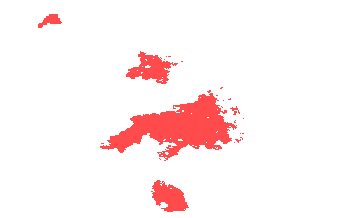

✓ FallFire 2007_10: pos=32  neg=32  →  /content/patches_FallFire_2007_10/map_FallFire_2007_10.html



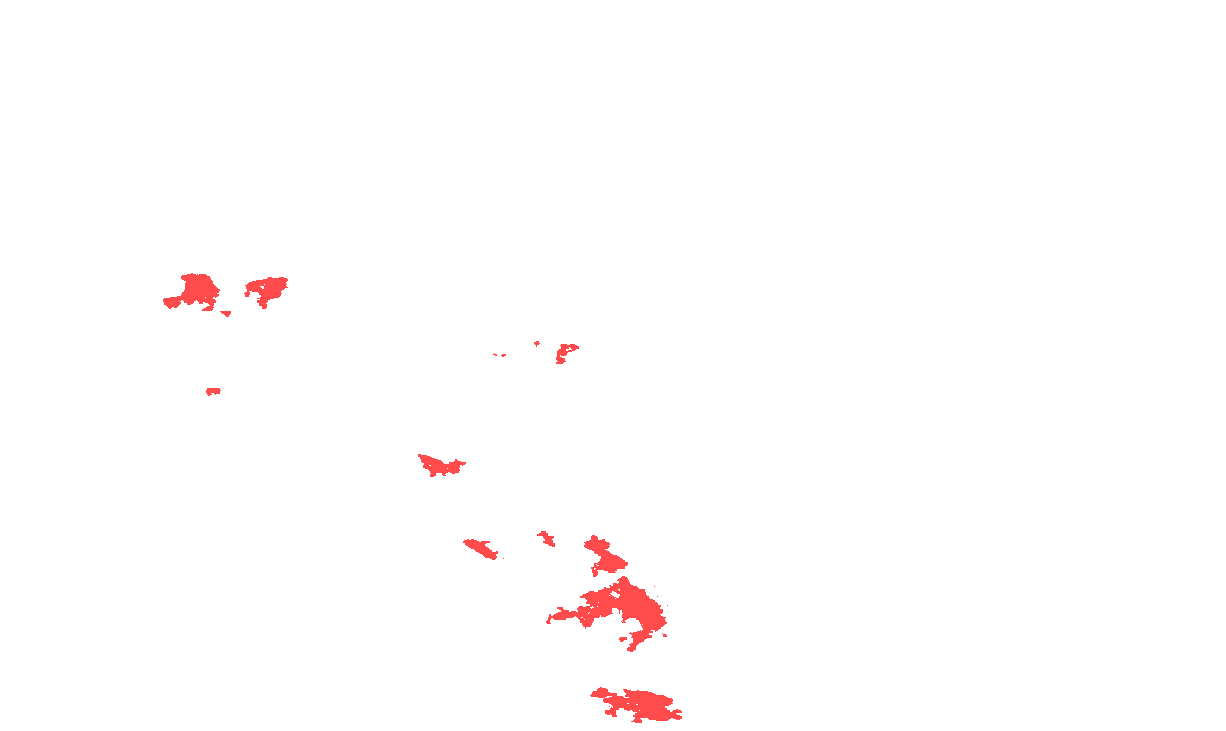

✓ Station 2009_08: pos=7  neg=7  →  /content/patches_Station_2009_08/map_Station_2009_08.html



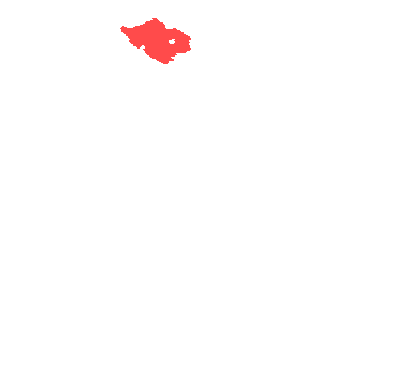

✓ LaBrea 2009_08: pos=7  neg=7  →  /content/patches_LaBrea_2009_08/map_LaBrea_2009_08.html



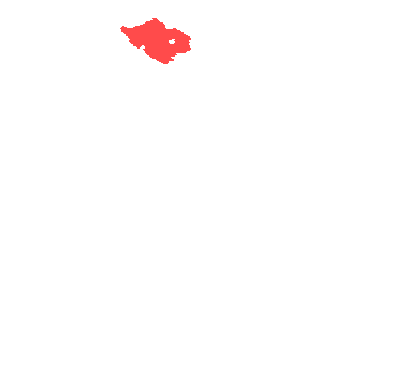

✓ Thomas 2017_12: pos=20  neg=20  →  /content/patches_Thomas_2017_12/map_Thomas_2017_12.html



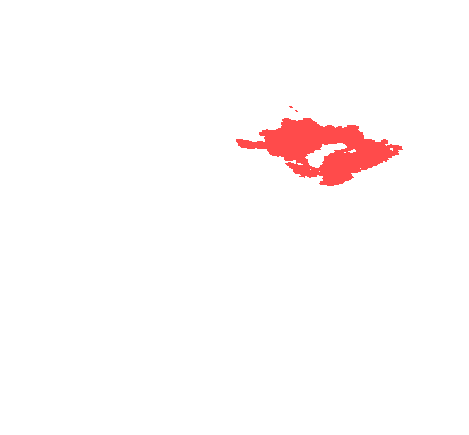

✓ Atlas 2017_10: pos=3  neg=3  →  /content/patches_Atlas_2017_10/map_Atlas_2017_10.html



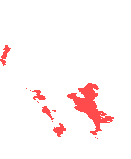

✓ Tubbs 2017_10: pos=3  neg=3  →  /content/patches_Tubbs_2017_10/map_Tubbs_2017_10.html



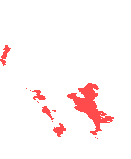

✓ Nuns 2017_10: pos=3  neg=3  →  /content/patches_Nuns_2017_10/map_Nuns_2017_10.html



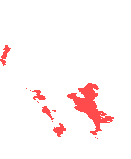

✓ Camp 2018_11: pos=9  neg=9  →  /content/patches_Camp_2018_11/map_Camp_2018_11.html



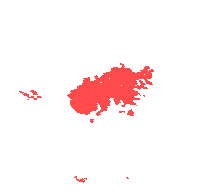

✓ Carr 2018_07: pos=10  neg=10  →  /content/patches_Carr_2018_07/map_Carr_2018_07.html



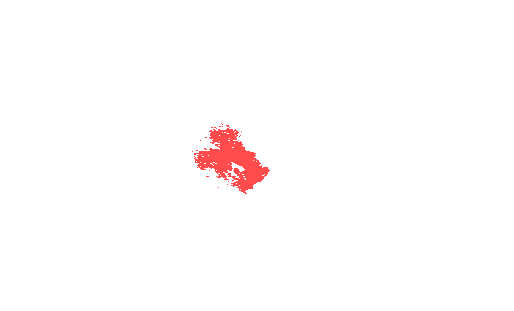

✓ MendoCx 2018_08: pos=24  neg=24  →  /content/patches_MendoCx_2018_08/map_MendoCx_2018_08.html



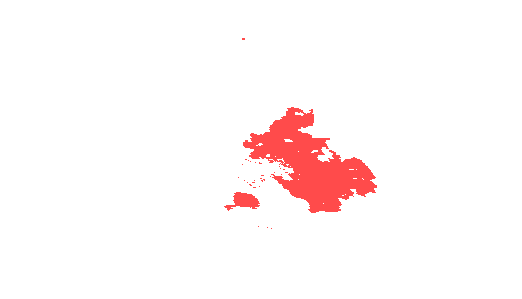


Totals: 140 positives; 140 negatives
Index page written: /content/maps_index.html

Wrote dataset index: /content/dataset_patches16_balanced/dataset_index.csv
Indexed patches → pos=140, neg=140, total=280


In [ ]:
# ================== FULL PATCH EXTRACTION + MAPS + DATASET INDEX (1:1, snapped, no-overlap) ==================
# installs (Colab friendly)
!pip -q install rasterio shapely scipy folium pillow

# ----------------------------- imports -----------------------------
import os, glob, json, random, subprocess, io, base64, shlex, re, csv
import numpy as np
from pathlib import Path
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject
from rasterio.windows import Window
from shapely.geometry import Polygon, mapping
from scipy import ndimage as ndi
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from PIL import Image

# ----------------------------- config ------------------------------
# bucket & local cache
BUCKET       = "california-fire-model"
PATCH_ROOT   = "/content"  # parent for all outputs
LOCAL_EVM    = "/content/data/evms_events"
LOCAL_BURN   = "/content/data/burned_events"
LOCAL_RGB    = "/content/data/modis_rgb_events"  # optional
for d in [LOCAL_EVM, LOCAL_BURN, LOCAL_RGB]:
    Path(d).mkdir(parents=True, exist_ok=True)

# patch & sampling
PATCH_HW         = 16     # H=W
STRIDE           = 16     # >= PATCH_HW -> no overlap
POS_FRAC         = 0.60   # >=60% of kept-cluster area
CLUSTER_MIN_PX   = 50     # cluster size threshold (after dilation)
DILATE_PIX       = 1      # 0 disables
POS_MAX          = 200    # cap positives per event

BALANCE_1_TO_1          = True
NEG_PER_POS             = 1
RING_RADII              = [PATCH_HW, 2*PATCH_HW, 3*PATCH_HW, 4*PATCH_HW, 6*PATCH_HW, 8*PATCH_HW]
RING_SAMPLES_PER_RADIUS = 48

# maps
MAP_MAX_EDGE     = 2000
ALPHA            = 180
SHOW_ALL_MAPS    = True
BUILD_MAP_INDEX  = True
IFRAME_HEIGHT    = 600

# outputs
SAVE_PATCHES     = True
PATCH_FORMAT     = "npz"  # "npz" or "tif"
DATASET_DIR      = Path("/content/dataset_patches16_balanced")
DATASET_DIR.mkdir(parents=True, exist_ok=True)
DATASET_INDEX_CSV = DATASET_DIR / "dataset_index.csv"

# optional cloud sync
SYNC_TO_GCS      = False
SYNC_DEST        = f"gs://{BUCKET}/datasets/patches16_balanced_v1"

# reproducibility
RANDOM_SEED      = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# event name normalization
NAME_MAP = {
    "Cedar":   "CedarFire",
    "FallFire":"Fall",
    "Station": "StationFire",
    "LaBrea":  "LaBreaFire",
    "Thomas":  "ThomasFire",
    "Atlas":   "AtlasFire",
    "Tubbs":   "TubbsFire",
    "Nuns":    "NunsFire",
    "Camp":    "CampFire",
    "Carr":    "CarrFire",
    "MendoCx": "MendocinoComplex",
}

# choose event-months
EVENT_MONTHS = [
    ("Cedar",   "2003_10"),
    ("FallFire","2007_10"),
    ("Station", "2009_08"),
    ("LaBrea",  "2009_08"),
    ("Thomas",  "2017_12"),
    ("Atlas",   "2017_10"),
    ("Tubbs",   "2017_10"),
    ("Nuns",    "2017_10"),
    ("Camp",    "2018_11"),
    ("Carr",    "2018_07"),
    ("MendoCx", "2018_08"),
]

# -------------------------- small utilities ------------------------
def normalize_event_month(ev, ym):
    """Strip accidental suffix _YYYY_MM and force ym to YYYY_MM."""
    m = re.search(r"(.*?)[_-]?(20\d{2})[_-](\d{2})$", ev)
    if m:
        ev = (m.group(1) or "").rstrip("_-")
        if not ym or not re.match(r"^20\d{2}[_-]\d{2}$", ym):
            ym = f"{m.group(2)}_{m.group(3)}"
    ym = ym.replace("-", "_")
    ev = ev.rstrip("_-")
    return ev, ym

def _run(cmd):
    try:
        out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
        return [ln.strip() for ln in out.splitlines() if ln.strip()]
    except subprocess.CalledProcessError:
        return []

def _gs_ls(pat):
    return _run(f'gsutil ls "{pat}"')

def _gs_cp_one(src, dst_dir):
    subprocess.run(f'gsutil -m cp -n "{src}" "{dst_dir}"', shell=True, check=False)

def _find_one(patterns, roots):
    for root in roots:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(root, pat), recursive=True) if h.lower().endswith(".tif")]
            if hits: return sorted(hits)[0]
    return None

def has_gsutil():
    try:
        subprocess.check_output(["gsutil","--version"], text=True)
        return True
    except Exception:
        return False

# ---------------------- mirror from GCS (robust) -------------------
def mirror_event_month(event_base, ym):
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)
    if not has_gsutil():
        print("! gsutil not found; assuming files already mirrored locally.")
        return False

    evm_candidates = (
        _gs_ls(f'gs://{BUCKET}/evms_events/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms_events/*EVM*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*.tif')
    )
    burn_candidates = (
        _gs_ls(f'gs://{BUCKET}/burned_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_events/*{stem}*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_area/*_{ym}*.tif')
    )
    rgb_candidates = (
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/*{stem}*_{ym}*.tif') or
        []
    )

    any_found = False
    if evm_candidates:
        _gs_cp_one(evm_candidates[0], LOCAL_EVM); any_found = True
    if burn_candidates:
        _gs_cp_one(burn_candidates[0], LOCAL_BURN); any_found = True
    if rgb_candidates:
        _gs_cp_one(rgb_candidates[0], LOCAL_RGB); any_found = True
    return any_found

# -------------------------- reprojection ---------------------------
def reproject_band(src_path, ref_path, band_index=1, resampling=RS.nearest, out_dtype=np.float32):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=out_dtype)
        reproject(
            source=rasterio.band(src, band_index), destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def read_burn_mask_to_match(brn_path, ref_path):
    with rasterio.open(brn_path) as src:
        band_index = 2 if src.count >= 2 else 1  # prefer BurnMask if present
    burn = reproject_band(brn_path, ref_path, band_index=band_index, resampling=RS.nearest, out_dtype=np.float32)
    return (burn > 0).astype(np.uint8)

# ---------------- geometry & thumbnails for popups -----------------
def polygon_from_window(tfm, x0, y0, w, h):
    p1 = tfm * (x0,     y0)
    p2 = tfm * (x0+w,   y0)
    p3 = tfm * (x0+w,   y0+h)
    p4 = tfm * (x0,     y0+h)
    return [(p1[0],p1[1]),(p2[0],p2[1]),(p3[0],p3[1]),(p4[0],p4[1]),(p1[0],p1[1])]

def lonlat_corners(tfm, x0, y0, w, h):
    poly = polygon_from_window(tfm, x0, y0, w, h)
    (ul_lon, ul_lat) = poly[0]; (lr_lon, lr_lat) = poly[2]
    cx_lon = (ul_lon + lr_lon)/2; cx_lat = (ul_lat + lr_lat)/2
    return poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat

def small_patch_png_from_rgb(rgb_tif, evm_tif, x0, y0, w=PATCH_HW, h=PATCH_HW):
    try:
        with rasterio.open(evm_tif) as ref:
            H,W = ref.height, ref.width
        if not rgb_tif: return ""
        rgb = np.zeros((3,H,W), dtype=np.float32)
        for b in range(1,4):
            rgb[b-1] = reproject_band(rgb_tif, evm_tif, band_index=b, resampling=RS.bilinear, out_dtype=np.float32)
        rgb = np.clip(rgb, 0, 1)
        crop = np.moveaxis(rgb[:, y0:y0+h, x0:x0+w], 0, -1)  # (h,w,3)
        crop8 = (crop*255+0.5).astype(np.uint8)
        im = Image.fromarray(crop8).resize((96,96), Image.NEAREST)
        buf = io.BytesIO(); im.save(buf, format="PNG")
        return base64.b64encode(buf.getvalue()).decode("utf-8")
    except Exception:
        return ""

# ------------------------ chip writers -----------------------------
def _write_chip_npz(src, y0, x0, h, w, burn_raw, out_path, meta):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    y = burn_raw[y0:y0+h, x0:x0+w].astype(np.uint8) # (H,W)
    np.savez_compressed(out_path, x=x, y=y, meta=meta)

def _write_chip_tif(src, y0, x0, h, w, out_path):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    prof = src.profile.copy()
    prof.update(height=h, width=w, transform=rasterio.windows.transform(win, src.transform))
    with rasterio.open(out_path, "w", **prof) as dst:
        dst.write(x)

def save_patches(evm_tif, burn_raw, pos_windows, neg_windows, out_dir, event, ym):
    chips_dir = Path(out_dir) / "chips"
    (chips_dir / "pos").mkdir(parents=True, exist_ok=True)
    (chips_dir / "neg").mkdir(parents=True, exist_ok=True)
    with rasterio.open(evm_tif) as src:
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            meta = {"event":event,"ym":ym,"kind":"pos","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                    "cluster_id":cid,"cluster_size":int(csize)}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"pos/pos_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"pos/pos_{i:05d}.tif")
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_windows):
            meta = {"event":event,"ym":ym,"kind":"neg","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"neg/neg_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"neg/neg_{i:05d}.tif")

# ---------------- main: footprints + maps + chips ------------------
def build_footprints_from_burn(event_base, ym):
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)

    # mirror from GCS (no-op if already local)
    mirror_event_month(ev, ym)

    # resolve local paths
    evm_tif = _find_one([
        f"**/*_{ym}*EVM*.tif",
        f"**/*EVM*_{ym}*.tif",
        f"**/*_{ym}*.tif",
    ], [LOCAL_EVM, "/content"])

    brn_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
        f"**/*_{ym}*.tif",
    ], [LOCAL_BURN, "/content"])

    rgb_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
    ], [LOCAL_RGB, "/content"])

    if not evm_tif or not brn_tif:
        print(f"!! Missing EVM/Burn for {ev}_{ym} {ym.replace('_','-')}")
        return 0,0,None

    with rasterio.open(evm_tif) as ds:
        H,W = ds.height, ds.width
        tfm  = ds.transform
        bounds = ds.bounds

    burn_raw = read_burn_mask_to_match(brn_tif, evm_tif)  # (H,W) {0,1}

    # clusterization
    burn = burn_raw.copy()
    if DILATE_PIX > 0:
        burn = ndi.binary_dilation(burn, iterations=DILATE_PIX).astype(np.uint8)
    labels, _ = ndi.label(burn)
    sizes = np.bincount(labels.ravel())
    keep = np.zeros_like(sizes, dtype=bool)
    keep[1:] = sizes[1:] >= CLUSTER_MIN_PX
    cluster_mask = keep[labels].astype(np.uint8)

    # scan windows
    pos_windows, neg_windows = [], []
    for y0 in range(0, H - PATCH_HW + 1, STRIDE):
        for x0 in range(0, W - PATCH_HW + 1, STRIDE):
            win_c = cluster_mask[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            win_b = burn_raw[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            frac_c = float(win_c.mean())
            frac_b = float(win_b.mean())
            if frac_c >= POS_FRAC:
                lbl = labels[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
                vals, cnts = np.unique(lbl[lbl>0], return_counts=True)
                cid = int(vals[np.argmax(cnts)]) if vals.size else 0
                csize = int(sizes[cid] if cid>0 else 0)
                pos_windows.append((y0, x0, frac_c, frac_b, cid, csize))
            elif frac_b == 0.0:
                neg_windows.append((y0, x0, 0.0, 0.0, 0, 0))

    # balance 1:1, snapped, no-overlap
    random.shuffle(pos_windows); random.shuffle(neg_windows)
    pos_windows = pos_windows[:min(POS_MAX, len(pos_windows))]

    Hc, Wc = (H // STRIDE) + 1, (W // STRIDE) + 1
    occ = np.zeros((Hc, Wc), dtype=bool)
    for (y0,x0,_,_,_,_) in pos_windows:
        occ[y0 // STRIDE, x0 // STRIDE] = True

    def _snap(v, step, lo, hi):
        s = int(round(v / step) * step)
        return max(lo, min(s, hi))

    def _try_place(yc, xc):
        y = _snap(yc, STRIDE, 0, H - PATCH_HW)
        x = _snap(xc, STRIDE, 0, W - PATCH_HW)
        cy, cx = y // STRIDE, x // STRIDE
        if occ[cy, cx]:
            return None
        if burn_raw[y:y+PATCH_HW, x:x+PATCH_HW].any():
            return None
        occ[cy, cx] = True
        return (y, x, 0.0, 0.0, 0, 0)

    neg_pairs = []

    # ring-based negs
    for i, (y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
        placed = None
        for rad in RING_RADII:
            for _ in range(RING_SAMPLES_PER_RADIUS):
                theta = random.random() * 2*np.pi
                yc = int(round(y0 + rad * np.sin(theta)))
                xc = int(round(x0 + rad * np.cos(theta)))
                cand = _try_place(yc, xc)
                if cand:
                    placed = cand
                    break
            if placed:
                break
        if placed:
            neg_pairs.append((i, placed))

    # fallback from global empty windows
    for (y0,x0,fc,fb,cid,csize) in neg_windows:
        if len(neg_pairs) >= NEG_PER_POS * len(pos_windows): break
        cand = _try_place(y0, x0)
        if cand:
            next_i = len(neg_pairs)
            if next_i < len(pos_windows):
                neg_pairs.append((next_i, cand))

    n_pairs = min(len(pos_windows), len(neg_pairs), NEG_PER_POS * len(pos_windows))
    pos_windows = pos_windows[:n_pairs]
    neg_pairs = sorted(neg_pairs[:n_pairs], key=lambda t: t[0])
    neg_sel = [cand for _, cand in neg_pairs]
    if BALANCE_1_TO_1: assert len(pos_windows) == len(neg_sel)

    # write outputs
    out_dir = Path(f"{PATCH_ROOT}/patches_{ev}_{ym}")
    out_dir.mkdir(parents=True, exist_ok=True)

    manifest = out_dir/"manifest.csv"
    with open(manifest, "w") as f:
        f.write("event,ym,id,kind,y0,x0,h,w,cluster_frac,burn_frac,cluster_id,cluster_size,"
                "ul_lon,ul_lat,lr_lon,lr_lat,cx_lon,cx_lat,evm_path,burn_path,rgb_path,pair_to\n")

        feats=[]
        pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
        neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]

        # positives
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            pid = pos_ids[i]
            pair_to = neg_ids[i] if i < len(neg_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":pid,"kind":"pos","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{pid},pos,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

        # negatives
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_sel):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            nid = neg_ids[i]
            pair_to = pos_ids[i] if i < len(pos_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":nid,"kind":"neg","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{nid},neg,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

    with open(out_dir/"patch_footprints.geojson","w") as f:
        json.dump({"type":"FeatureCollection","features":feats}, f)

    # Folium map
    overlay = np.zeros((H,W,4), dtype=np.uint8)
    overlay[...,0]=255; overlay[...,3]=(burn_raw*ALPHA).astype(np.uint8)
    scale = max(1, int(max(H,W)/MAP_MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :]

    # center
    if feats:
        clats = [ft["geometry"]["coordinates"][0][0][1] for ft in feats]
        clons = [ft["geometry"]["coordinates"][0][0][0] for ft in feats]
        c_lat = float(np.mean(clats)); c_lon = float(np.mean(clons))
    else:
        c_lat = (bounds.top+bounds.bottom)/2; c_lon=(bounds.left+bounds.right)/2

    m = folium.Map(location=[c_lat, c_lon], zoom_start=10, tiles=None)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri, Maxar", name="Imagery").add_to(m)
    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left],[bounds.top,bounds.right]],
        opacity=1.0, name="MODIS Burned (red)", zindex=500).add_to(m)

    # polygons + popups
    id2center = {}
    for ft in feats:
        p = ft["properties"]; ring = ft["geometry"]["coordinates"][0]
        latlngs = [(lat, lon) for lon,lat in ring]
        cx_lon = (ring[0][0] + ring[2][0]) / 2
        cx_lat = (ring[0][1] + ring[2][1]) / 2
        id2center[p["id"]] = (cx_lat, cx_lon)

        thumb64 = small_patch_png_from_rgb(p.get("rgb_path"), p["evm_path"], p["x0"], p["y0"], PATCH_HW, PATCH_HW)
        thumb_html = f'<img src="data:image/png;base64,{thumb64}" style="width:96px;height:96px;margin-right:6px;border:1px solid #ccc;"/>' if thumb64 else ''
        popup_html = f"""
        <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
          <b>{p['id']}</b> &nbsp; <span style="color:{'red' if p['kind']=='pos' else 'gold'}">({p['kind']})</span><br/>
          cluster_frac=<b>{float(p['cluster_frac']):.2f}</b>, burn_frac={float(p['burn_frac']):.2f}<br/>
          cluster_id={int(p['cluster_id'])}, size={int(p['cluster_size'])} px<br/>
          UL=({ring[0][0]:.5f}, {ring[0][1]:.5f}) LR=({ring[2][0]:.5f}, {ring[2][1]:.5f})<br/>
          <div style="display:flex;align-items:center;margin-top:4px;">
            {thumb_html}
            <div>
              <div style="opacity:.7">EVM:</div><div style="max-width:420px;word-wrap:break-word">{p['evm_path']}</div>
              <div style="opacity:.7">BURN:</div><div style="max-width:420px;word-wrap:break-word">{p['burn_path']}</div>
              {"<div style='opacity:.7'>RGB:</div><div style='max-width:420px;word-wrap:break-word'>"+(p.get('rgb_path') or '')+"</div>"}
              <div style="opacity:.7">pair_to:</div><div>{p.get('pair_to','')}</div>
            </div>
          </div>
        </div>"""
        folium.Polygon(
            locations=latlngs,
            color=("red" if p["kind"]=="pos" else "gold"),
            weight=(2 if p["kind"]=="pos" else 1.5),
            fill=False,
            tooltip=f"{p['id']} ({p['kind']})",
            popup=folium.Popup(popup_html, max_width=650),
        ).add_to(m)

    # connectors pos_i <-> neg_i
    pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
    neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]
    for i in range(min(len(pos_ids), len(neg_ids))):
        a, b = pos_ids[i], neg_ids[i]
        if a in id2center and b in id2center:
            folium.PolyLine([id2center[a], id2center[b]], color="blue", weight=1.5, opacity=0.6,
                            tooltip=f"{a} ↔ {b}").add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)
    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    m.save(out_html)

    # save chips
    if SAVE_PATCHES:
        save_patches(evm_tif, burn_raw, pos_windows, neg_sel, out_dir, ev, ym)

    print(f"✓ {ev} {ym}: pos={len(pos_windows)}  neg={len(neg_sel)}  →  {out_html}")
    return len(pos_windows), len(neg_sel), m

# --------------------------- run all events ------------------------
tot_pos = tot_neg = 0
event_map_paths = []

for ev, ym in EVENT_MONTHS:
    p, n, m = build_footprints_from_burn(ev, ym)
    tot_pos += p; tot_neg += n
    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    event_map_paths.append((f"{ev}_{ym}", out_html))
    if SHOW_ALL_MAPS and m is not None:
        try:
            display(m)
        except Exception:
            pass

print(f"\nTotals: {tot_pos} positives; {tot_neg} negatives")

if BUILD_MAP_INDEX and event_map_paths:
    idx_path = Path(PATCH_ROOT)/"maps_index.html"
    with open(idx_path, "w") as f:
        f.write(
            "<!doctype html><meta charset='utf-8'><title>Patch Maps Index</title>"
            "<style>body{font-family:system-ui,Segoe UI,Arial;margin:16px}"
            ".card{margin:12px 0;padding:8px;border:1px solid #ddd;border-radius:10px}"
            "h2{font-size:18px;margin:6px 0}</style>"
            "<h1>Patch Footprint Maps (Balanced 1:1, snapped, no-overlap)</h1>"
        )
        for label, path in event_map_paths:
            f.write(f"<div class='card'><h2>{label}</h2>"
                    f"<iframe src='{path}' width='100%' height='{IFRAME_HEIGHT}' loading='lazy'></iframe></div>")
    print(f"Index page written: {idx_path}")

# ----------------------- build dataset index -----------------------
rows, seen = [], set()
n_pos = n_neg = 0
manifests = sorted(glob.glob(str(Path(PATCH_ROOT) / "patches_*_*" / "manifest.csv")))
for mf in manifests:
    root = Path(mf).parent
    chips_pos = sorted(glob.glob(str(root / "chips" / "pos" / "*.npz"))) + \
                sorted(glob.glob(str(root / "chips" / "pos" / "*.tif")))
    chips_neg = sorted(glob.glob(str(root / "chips" / "neg" / "*.npz"))) + \
                sorted(glob.glob(str(root / "chips" / "neg" / "*.tif")))

    pos_map = {Path(p).stem: p for p in chips_pos}
    neg_map = {Path(p).stem: p for p in chips_neg}

    with open(mf) as f:
        r = csv.DictReader(f)
        for row in r:
            idx = (row["event"], row["ym"], row["id"], row["kind"])
            if idx in seen:
                continue
            seen.add(idx)

            stem = row["id"]
            if row["kind"] == "pos":
                fpath = pos_map.get(stem)
                if not fpath:
                    continue
                label = 1; n_pos += 1
            else:
                fpath = neg_map.get(stem)
                if not fpath:
                    continue
                label = 0; n_neg += 1

            rows.append({
                "path": fpath,
                "label": label,
                "event": row["event"],
                "ym": row["ym"],
                "id": row["id"],
                "pair_to": row.get("pair_to",""),
                "y0": row["y0"], "x0": row["x0"],
                "h": row["h"], "w": row["w"],
                "cluster_frac": row["cluster_frac"],
                "burn_frac": row["burn_frac"],
                "cluster_id": row["cluster_id"],
                "cluster_size": row["cluster_size"],
                "ul_lon": row["ul_lon"], "ul_lat": row["ul_lat"],
                "lr_lon": row["lr_lon"], "lr_lat": row["lr_lat"],
                "cx_lon": row["cx_lon"], "cx_lat": row["cx_lat"],
                "evm_path": row["evm_path"], "burn_path": row["burn_path"], "rgb_path": row.get("rgb_path","")
            })

assert n_pos == n_neg, f"Dataset should be 1:1 but got pos={n_pos}, neg={n_neg}"
with open(DATASET_INDEX_CSV, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader(); w.writerows(rows)

print(f"\nWrote dataset index: {DATASET_INDEX_CSV}")
print(f"Indexed patches → pos={n_pos}, neg={n_neg}, total={n_pos+n_neg}")

# -------------------------- optional sync --------------------------
if SYNC_TO_GCS and has_gsutil():
    print(f"\nSyncing to {SYNC_DEST} ...")
    # sync all event folders
    !gsutil -m rsync -r /content/patches_*_* "{SYNC_DEST}/events/"
    # copy the dataset index
    !gsutil cp "{DATASET_INDEX_CSV}" "{SYNC_DEST}/dataset_index.csv"
    print("Sync complete.")
else:
    if SYNC_TO_GCS:
        print("! SYNC_TO_GCS=True but gsutil not found; skipping sync.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 52.7 MB/s eta 0:00:00
✓ Cedar 2003_10: pos=22  neg=22  →  /content/drive/MyDrive/fire_patches_extracted/patches_Cedar_2003_10/map_Cedar_2003_10.html



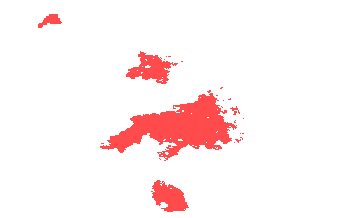

✓ FallFire 2007_10: pos=32  neg=32  →  /content/drive/MyDrive/fire_patches_extracted/patches_FallFire_2007_10/map_FallFire_2007_10.html



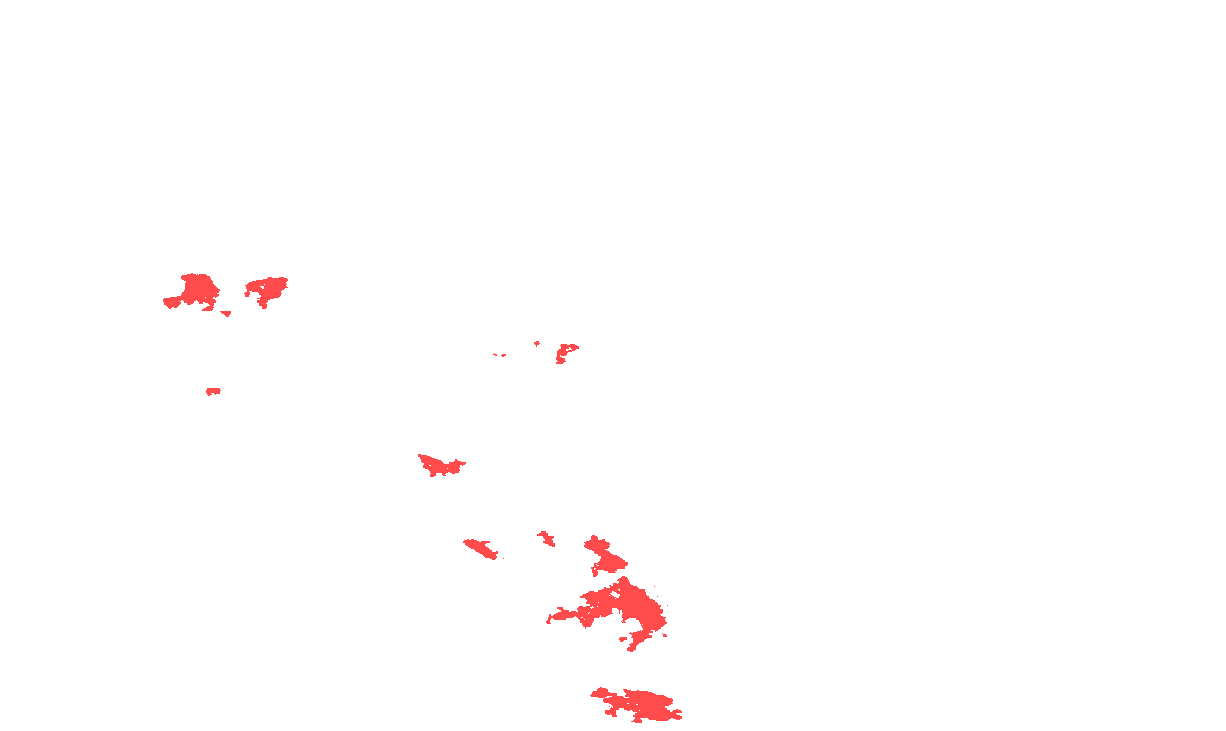

✓ Station 2009_08: pos=7  neg=7  →  /content/drive/MyDrive/fire_patches_extracted/patches_Station_2009_08/map_Station_2009_08.html



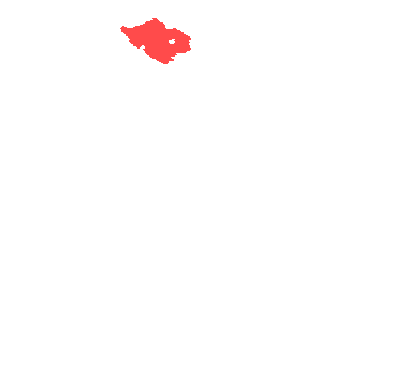

✓ LaBrea 2009_08: pos=7  neg=7  →  /content/drive/MyDrive/fire_patches_extracted/patches_LaBrea_2009_08/map_LaBrea_2009_08.html



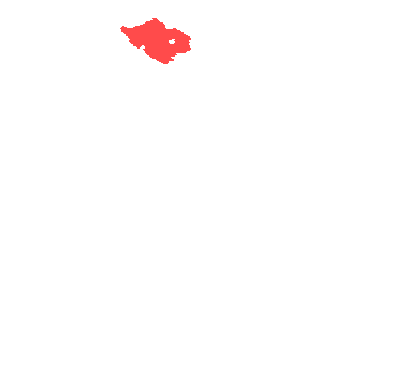

✓ Thomas 2017_12: pos=20  neg=20  →  /content/drive/MyDrive/fire_patches_extracted/patches_Thomas_2017_12/map_Thomas_2017_12.html



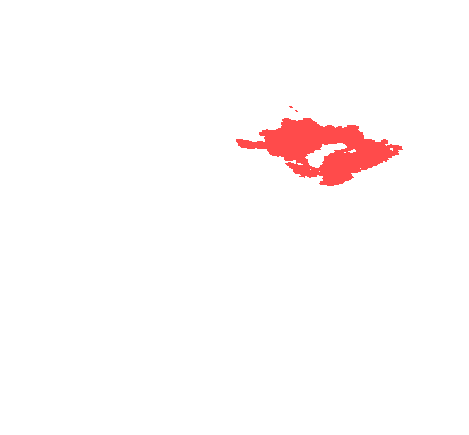

✓ Atlas 2017_10: pos=3  neg=3  →  /content/drive/MyDrive/fire_patches_extracted/patches_Atlas_2017_10/map_Atlas_2017_10.html



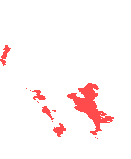

✓ Tubbs 2017_10: pos=3  neg=3  →  /content/drive/MyDrive/fire_patches_extracted/patches_Tubbs_2017_10/map_Tubbs_2017_10.html



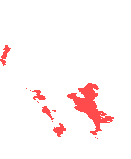

✓ Nuns 2017_10: pos=3  neg=3  →  /content/drive/MyDrive/fire_patches_extracted/patches_Nuns_2017_10/map_Nuns_2017_10.html



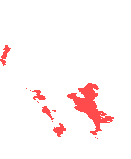

✓ Camp 2018_11: pos=9  neg=9  →  /content/drive/MyDrive/fire_patches_extracted/patches_Camp_2018_11/map_Camp_2018_11.html



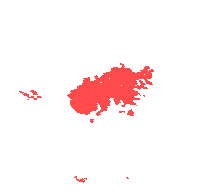

✓ Carr 2018_07: pos=10  neg=10  →  /content/drive/MyDrive/fire_patches_extracted/patches_Carr_2018_07/map_Carr_2018_07.html



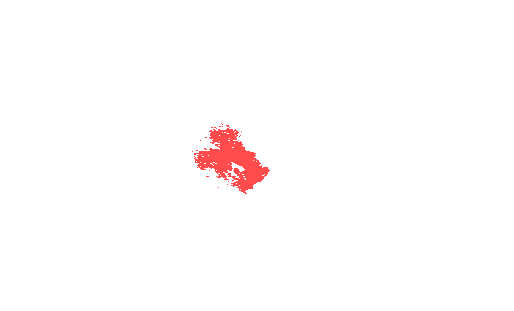

✓ MendoCx 2018_08: pos=24  neg=24  →  /content/drive/MyDrive/fire_patches_extracted/patches_MendoCx_2018_08/map_MendoCx_2018_08.html



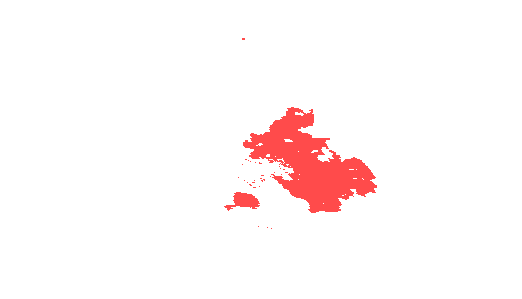


Totals: 140 positives; 140 negatives
Index page written: /content/drive/MyDrive/fire_patches_extracted/maps_index.html
Found 29 manifest(s)
!! patches_Atlas_2017_10_2017-10: cannot find EVM/Burn rasters to rebuild chips
!! patches_Camp_2018_11_2018-11: cannot find EVM/Burn rasters to rebuild chips
!! patches_Camp_2018_11_2018-12: cannot find EVM/Burn rasters to rebuild chips
!! patches_Carr_2018_07_2018-07: cannot find EVM/Burn rasters to rebuild chips
!! patches_Carr_2018_07_2018-08: cannot find EVM/Burn rasters to rebuild chips
!! patches_Cedar_2003_10_2003-10: cannot find EVM/Burn rasters to rebuild chips
!! patches_Cedar_2003_10_2003-11: cannot find EVM/Burn rasters to rebuild chips
!! patches_FallFire_2007_10_2007-10: cannot find EVM/Burn rasters to rebuild chips
!! patches_FallFire_2007_10_2007-11: cannot find EVM/Burn rasters to rebuild chips
!! patches_LaBrea_2009_08_2009-08: cannot find EVM/Burn rasters to rebuild chips
!! patches_LaBrea_2009_08_2009-09: cannot find EVM/Burn 

In [ ]:
# ================== FULL PATCH EXTRACTION + MAPS + DATASET INDEX (1:1, snapped, no-overlap) ==================
# installs (Colab friendly)
!pip -q install rasterio shapely scipy folium pillow

# ----------------------------- imports -----------------------------
import os, glob, json, random, subprocess, io, base64, shlex, re, csv
import numpy as np
from pathlib import Path
import rasterio
from rasterio.enums import Resampling as RS
from rasterio.warp import reproject
from rasterio.windows import Window
from shapely.geometry import Polygon, mapping
from scipy import ndimage as ndi
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from PIL import Image

# ----------------------------- config ------------------------------
# bucket & local cache
BUCKET       = "california-fire-model"

# >>> Write everything to Drive <<<
PATCH_ROOT   = "/content/drive/MyDrive/fire_patches_extracted"  # parent for all outputs

LOCAL_EVM    = "/content/data/evms_events"
LOCAL_BURN   = "/content/data/burned_events"
LOCAL_RGB    = "/content/data/modis_rgb_events"  # optional
for d in [LOCAL_EVM, LOCAL_BURN, LOCAL_RGB, PATCH_ROOT]:
    Path(d).mkdir(parents=True, exist_ok=True)

# patch & sampling
PATCH_HW         = 16     # H=W
STRIDE           = 16     # >= PATCH_HW -> no overlap
POS_FRAC         = 0.60   # >=60% of kept-cluster area
CLUSTER_MIN_PX   = 50     # cluster size threshold (after dilation)
DILATE_PIX       = 1      # 0 disables
POS_MAX          = 200    # cap positives per event

BALANCE_1_TO_1          = True
NEG_PER_POS             = 1
RING_RADII              = [PATCH_HW, 2*PATCH_HW, 3*PATCH_HW, 4*PATCH_HW, 6*PATCH_HW, 8*PATCH_HW]
RING_SAMPLES_PER_RADIUS = 48

# maps
MAP_MAX_EDGE     = 2000
ALPHA            = 180
SHOW_ALL_MAPS    = True
BUILD_MAP_INDEX  = True
IFRAME_HEIGHT    = 600

# outputs
SAVE_PATCHES     = True
PATCH_FORMAT     = "npz"  # "npz" or "tif"
DATASET_DIR      = Path(PATCH_ROOT) / "dataset_patches16_balanced"
DATASET_DIR.mkdir(parents=True, exist_ok=True)
DATASET_INDEX_CSV = DATASET_DIR / "dataset_index.csv"

# optional cloud sync
SYNC_TO_GCS      = False
SYNC_DEST        = f"gs://{BUCKET}/datasets/patches16_balanced_v1"

# reproducibility
RANDOM_SEED      = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# event name normalization
NAME_MAP = {
    "Cedar":   "CedarFire",
    "FallFire":"Fall",
    "Station": "StationFire",
    "LaBrea":  "LaBreaFire",
    "Thomas":  "ThomasFire",
    "Atlas":   "AtlasFire",
    "Tubbs":   "TubbsFire",
    "Nuns":    "NunsFire",
    "Camp":    "CampFire",
    "Carr":    "CarrFire",
    "MendoCx": "MendocinoComplex",
}

# choose event-months
EVENT_MONTHS = [
    ("Cedar",   "2003_10"),
    ("FallFire","2007_10"),
    ("Station", "2009_08"),
    ("LaBrea",  "2009_08"),
    ("Thomas",  "2017_12"),
    ("Atlas",   "2017_10"),
    ("Tubbs",   "2017_10"),
    ("Nuns",    "2017_10"),
    ("Camp",    "2018_11"),
    ("Carr",    "2018_07"),
    ("MendoCx", "2018_08"),
]

# -------------------------- small utilities ------------------------
def normalize_event_month(ev, ym):
    """Strip accidental suffix _YYYY_MM and force ym to YYYY_MM."""
    m = re.search(r"(.*?)[_-]?(20\d{2})[_-](\d{2})$", ev)
    if m:
        ev = (m.group(1) or "").rstrip("_-")
        if not ym or not re.match(r"^20\d{2}[_-]\d{2}$", ym):
            ym = f"{m.group(2)}_{m.group(3)}"
    ym = ym.replace("-", "_")
    ev = ev.rstrip("_-")
    return ev, ym

def _run(cmd):
    try:
        out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, text=True)
        return [ln.strip() for ln in out.splitlines() if ln.strip()]
    except subprocess.CalledProcessError:
        return []

def _gs_ls(pat):
    return _run(f'gsutil ls "{pat}"')

def _gs_cp_one(src, dst_dir):
    subprocess.run(f'gsutil -m cp -n "{src}" "{dst_dir}"', shell=True, check=False)

def _find_one(patterns, roots):
    for root in roots:
        for pat in patterns:
            hits = [h for h in glob.glob(os.path.join(root, pat), recursive=True) if h.lower().endswith((".tif",".tiff"))]
            if hits: return sorted(hits)[0]
    return None

def has_gsutil():
    try:
        subprocess.check_output(["gsutil","--version"], text=True)
        return True
    except Exception:
        return False

# ---------------------- mirror from GCS (robust) -------------------
def mirror_event_month(event_base, ym):
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)
    if not has_gsutil():
        print("! gsutil not found; assuming files already mirrored locally.")
        return False

    evm_candidates = (
        _gs_ls(f'gs://{BUCKET}/evms_events/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms_events/*EVM*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*EVM*.tif') or
        _gs_ls(f'gs://{BUCKET}/evms/*_{ym}*.tif')
    )
    burn_candidates = (
        _gs_ls(f'gs://{BUCKET}/burned_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_events/*{stem}*_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/burned_area/*_{ym}*.tif')
    )
    rgb_candidates = (
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/{stem}_{ym}*.tif') or
        _gs_ls(f'gs://{BUCKET}/modis_rgb_events/*{stem}*_{ym}*.tif') or
        []
    )

    any_found = False
    if evm_candidates:
        _gs_cp_one(evm_candidates[0], LOCAL_EVM); any_found = True
    if burn_candidates:
        _gs_cp_one(burn_candidates[0], LOCAL_BURN); any_found = True
    if rgb_candidates:
        _gs_cp_one(rgb_candidates[0], LOCAL_RGB); any_found = True
    return any_found

# -------------------------- reprojection ---------------------------
def reproject_band(src_path, ref_path, band_index=1, resampling=RS.nearest, out_dtype=np.float32):
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((ref.height, ref.width), dtype=out_dtype)
        reproject(
            source=rasterio.band(src, band_index), destination=dst,
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=ref.transform, dst_crs=ref.crs,
            resampling=resampling
        )
    return dst

def read_burn_mask_to_match(brn_path, ref_path):
    with rasterio.open(brn_path) as src:
        band_index = 2 if src.count >= 2 else 1  # prefer BurnMask if present
    burn = reproject_band(brn_path, ref_path, band_index=band_index, resampling=RS.nearest, out_dtype=np.float32)
    return (burn > 0).astype(np.uint8)

# ---------------- geometry & thumbnails for popups -----------------
def polygon_from_window(tfm, x0, y0, w, h):
    p1 = tfm * (x0,     y0)
    p2 = tfm * (x0+w,   y0)
    p3 = tfm * (x0+w,   y0+h)
    p4 = tfm * (x0,     y0+h)
    return [(p1[0],p1[1]),(p2[0],p2[1]),(p3[0],p3[1]),(p4[0],p4[1]),(p1[0],p1[1])]

def lonlat_corners(tfm, x0, y0, w, h):
    poly = polygon_from_window(tfm, x0, y0, w, h)
    (ul_lon, ul_lat) = poly[0]; (lr_lon, lr_lat) = poly[2]
    cx_lon = (ul_lon + lr_lon)/2; cx_lat = (ul_lat + lr_lat)/2
    return poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat

def small_patch_png_from_rgb(rgb_tif, evm_tif, x0, y0, w=PATCH_HW, h=PATCH_HW):
    try:
        with rasterio.open(evm_tif) as ref:
            H,W = ref.height, ref.width
        if not rgb_tif: return ""
        rgb = np.zeros((3,H,W), dtype=np.float32)
        for b in range(1,4):
            rgb[b-1] = reproject_band(rgb_tif, evm_tif, band_index=b, resampling=RS.bilinear, out_dtype=np.float32)
        rgb = np.clip(rgb, 0, 1)
        crop = np.moveaxis(rgb[:, y0:y0+h, x0:x0+w], 0, -1)  # (h,w,3)
        crop8 = (crop*255+0.5).astype(np.uint8)
        im = Image.fromarray(crop8).resize((96,96), Image.NEAREST)
        buf = io.BytesIO(); im.save(buf, format="PNG")
        return base64.b64encode(buf.getvalue()).decode("utf-8")
    except Exception:
        return ""

# ------------------------ chip writers -----------------------------
def _write_chip_npz(src, y0, x0, h, w, burn_raw, out_path, meta):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    y = burn_raw[y0:y0+h, x0:x0+w].astype(np.uint8) # (H,W)
    np.savez_compressed(out_path, x=x, y=y, meta=meta)

def _write_chip_tif(src, y0, x0, h, w, out_path):
    win = Window(x0, y0, w, h)
    x = src.read(window=win)                        # (C,H,W)
    prof = src.profile.copy()
    prof.update(height=h, width=w, transform=rasterio.windows.transform(win, src.transform))
    with rasterio.open(out_path, "w", **prof) as dst:
        dst.write(x)

def save_patches(evm_tif, burn_raw, pos_windows, neg_windows, out_dir, event, ym):
    chips_dir = Path(out_dir) / "chips"
    (chips_dir / "pos").mkdir(parents=True, exist_ok=True)
    (chips_dir / "neg").mkdir(parents=True, exist_ok=True)
    with rasterio.open(evm_tif) as src:
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            meta = {"event":event,"ym":ym,"kind":"pos","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                    "cluster_id":cid,"cluster_size":int(csize)}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"pos/pos_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"pos/pos_{i:05d}.tif")
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_windows):
            meta = {"event":event,"ym":ym,"kind":"neg","y0":y0,"x0":x0,
                    "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb}
            if PATCH_FORMAT=="npz":
                _write_chip_npz(src,y0,x0,PATCH_HW,PATCH_HW,burn_raw, chips_dir/f"neg/neg_{i:05d}.npz", meta)
            else:
                _write_chip_tif(src,y0,x0,PATCH_HW,PATCH_HW, chips_dir/f"neg/neg_{i:05d}.tif")

# ---------------- main: footprints + maps + chips ------------------
def build_footprints_from_burn(event_base, ym):
    ev, ym = normalize_event_month(event_base, ym)
    stem = NAME_MAP.get(ev, ev)

    # mirror from GCS (no-op if already local)
    mirror_event_month(ev, ym)

    # resolve local paths
    evm_tif = _find_one([
        f"**/*_{ym}*EVM*.tif",
        f"**/*EVM*_{ym}*.tif",
        f"**/*_{ym}*.tif",
    ], [LOCAL_EVM, "/content", PATCH_ROOT])

    brn_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
        f"**/*_{ym}*.tif",
        f"**/*burn*.tif", f"**/*Burn*.tif", f"**/*burned*.tif"
    ], [LOCAL_BURN, "/content", PATCH_ROOT])

    rgb_tif = _find_one([
        f"**/{stem}_{ym}*.tif",
        f"**/*{stem}*_{ym}*.tif",
    ], [LOCAL_RGB, "/content", PATCH_ROOT])

    if not evm_tif or not brn_tif:
        print(f"!! Missing EVM/Burn for {ev}_{ym} {ym.replace('_','-')}")
        return 0,0,None

    with rasterio.open(evm_tif) as ds:
        H,W = ds.height, ds.width
        tfm  = ds.transform
        bounds = ds.bounds

    burn_raw = read_burn_mask_to_match(brn_tif, evm_tif)  # (H,W) {0,1}

    # clusterization
    burn = burn_raw.copy()
    if DILATE_PIX > 0:
        burn = ndi.binary_dilation(burn, iterations=DILATE_PIX).astype(np.uint8)
    labels, _ = ndi.label(burn)
    sizes = np.bincount(labels.ravel())
    keep = np.zeros_like(sizes, dtype=bool)
    keep[1:] = sizes[1:] >= CLUSTER_MIN_PX
    cluster_mask = keep[labels].astype(np.uint8)

    # scan windows
    pos_windows, neg_windows = [], []
    for y0 in range(0, H - PATCH_HW + 1, STRIDE):
        for x0 in range(0, W - PATCH_HW + 1, STRIDE):
            win_c = cluster_mask[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            win_b = burn_raw[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
            frac_c = float(win_c.mean())
            frac_b = float(win_b.mean())
            if frac_c >= POS_FRAC:
                lbl = labels[y0:y0+PATCH_HW, x0:x0+PATCH_HW]
                vals, cnts = np.unique(lbl[lbl>0], return_counts=True)
                cid = int(vals[np.argmax(cnts)]) if vals.size else 0
                csize = int(sizes[cid] if cid>0 else 0)
                pos_windows.append((y0, x0, frac_c, frac_b, cid, csize))
            elif frac_b == 0.0:
                neg_windows.append((y0, x0, 0.0, 0.0, 0, 0))

    # balance 1:1, snapped, no-overlap
    random.shuffle(pos_windows); random.shuffle(neg_windows)
    pos_windows = pos_windows[:min(POS_MAX, len(pos_windows))]

    Hc, Wc = (H // STRIDE) + 1, (W // STRIDE) + 1
    occ = np.zeros((Hc, Wc), dtype=bool)
    for (y0,x0,_,_,_,_) in pos_windows:
        occ[y0 // STRIDE, x0 // STRIDE] = True

    def _snap(v, step, lo, hi):
        s = int(round(v / step) * step)
        return max(lo, min(s, hi))

    def _try_place(yc, xc):
        y = _snap(yc, STRIDE, 0, H - PATCH_HW)
        x = _snap(xc, STRIDE, 0, W - PATCH_HW)
        cy, cx = y // STRIDE, x // STRIDE
        if occ[cy, cx]:
            return None
        if burn_raw[y:y+PATCH_HW, x:x+PATCH_HW].any():
            return None
        occ[cy, cx] = True
        return (y, x, 0.0, 0.0, 0, 0)

    neg_pairs = []

    # ring-based negs
    for i, (y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
        placed = None
        for rad in RING_RADII:
            for _ in range(RING_SAMPLES_PER_RADIUS):
                theta = random.random() * 2*np.pi
                yc = int(round(y0 + rad * np.sin(theta)))
                xc = int(round(x0 + rad * np.cos(theta)))
                cand = _try_place(yc, xc)
                if cand:
                    placed = cand
                    break
            if placed:
                break
        if placed:
            neg_pairs.append((i, placed))

    # fallback from global empty windows
    for (y0,x0,fc,fb,cid,csize) in neg_windows:
        if len(neg_pairs) >= NEG_PER_POS * len(pos_windows): break
        cand = _try_place(y0, x0)
        if cand:
            next_i = len(neg_pairs)
            if next_i < len(pos_windows):
                neg_pairs.append((next_i, cand))

    n_pairs = min(len(pos_windows), len(neg_pairs), NEG_PER_POS * len(pos_windows))
    pos_windows = pos_windows[:n_pairs]
    neg_pairs = sorted(neg_pairs[:n_pairs], key=lambda t: t[0])
    neg_sel = [cand for _, cand in neg_pairs]
    if BALANCE_1_TO_1: assert len(pos_windows) == len(neg_sel)

    # write outputs
    out_dir = Path(f"{PATCH_ROOT}/patches_{ev}_{ym}")
    out_dir.mkdir(parents=True, exist_ok=True)

    manifest = out_dir/"manifest.csv"
    with open(manifest, "w") as f:
        f.write("event,ym,id,kind,y0,x0,h,w,cluster_frac,burn_frac,cluster_id,cluster_size,"
                "ul_lon,ul_lat,lr_lon,lr_lat,cx_lon,cx_lat,evm_path,burn_path,rgb_path,pair_to\n")

        feats=[]
        pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
        neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]

        # positives
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(pos_windows):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            pid = pos_ids[i]
            pair_to = neg_ids[i] if i < len(neg_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":pid,"kind":"pos","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{pid},pos,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

        # negatives
        for i,(y0,x0,fc,fb,cid,csize) in enumerate(neg_sel):
            poly, ul_lon, ul_lat, lr_lon, lr_lat, cx_lon, cx_lat = lonlat_corners(tfm, x0, y0, PATCH_HW, PATCH_HW)
            nid = neg_ids[i]
            pair_to = pos_ids[i] if i < len(pos_ids) else ""
            feats.append({
                "type":"Feature",
                "properties":{"event":ev,"ym":ym,"id":nid,"kind":"neg","y0":y0,"x0":x0,
                              "h":PATCH_HW,"w":PATCH_HW,"cluster_frac":fc,"burn_frac":fb,
                              "cluster_id":cid,"cluster_size":csize,
                              "evm_path":evm_tif,"burn_path":brn_tif,"rgb_path":rgb_tif,
                              "pair_to": pair_to},
                "geometry":{"type":"Polygon","coordinates":[poly]}
            })
            f.write(f"{ev},{ym},{nid},neg,{y0},{x0},{PATCH_HW},{PATCH_HW},{fc:.4f},{fb:.4f},{cid},{csize},"
                    f"{ul_lon:.6f},{ul_lat:.6f},{lr_lon:.6f},{lr_lat:.6f},{cx_lon:.6f},{cx_lat:.6f},"
                    f"{evm_tif},{brn_tif},{rgb_tif or ''},{pair_to}\n")

    with open(out_dir/"patch_footprints.geojson","w") as f:
        json.dump({"type":"FeatureCollection","features":feats}, f)

    # Folium map
    overlay = np.zeros((H,W,4), dtype=np.uint8)
    overlay[...,0]=255; overlay[...,3]=(burn_raw*ALPHA).astype(np.uint8)
    scale = max(1, int(max(H,W)/MAP_MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :]

    # center
    if feats:
        clats = [ft["geometry"]["coordinates"][0][0][1] for ft in feats]
        clons = [ft["geometry"]["coordinates"][0][0][0] for ft in feats]
        c_lat = float(np.mean(clats)); c_lon = float(np.mean(clons))
    else:
        c_lat = (bounds.top+bounds.bottom)/2; c_lon=(bounds.left+bounds.right)/2

    m = folium.Map(location=[c_lat, c_lon], zoom_start=10, tiles=None)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri, Maxar", name="Imagery").add_to(m)
    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left],[bounds.top,bounds.right]],
        opacity=1.0, name="MODIS Burned (red)", zindex=500).add_to(m)

    # polygons + popups
    id2center = {}
    for ft in feats:
        p = ft["properties"]; ring = ft["geometry"]["coordinates"][0]
        latlngs = [(lat, lon) for lon,lat in ring]
        cx_lon = (ring[0][0] + ring[2][0]) / 2
        cx_lat = (ring[0][1] + ring[2][1]) / 2
        id2center[p["id"]] = (cx_lat, cx_lon)

        thumb64 = small_patch_png_from_rgb(p.get("rgb_path"), p["evm_path"], p["x0"], p["y0"], PATCH_HW, PATCH_HW)
        thumb_html = f'<img src="data:image/png;base64,{thumb64}" style="width:96px;height:96px;margin-right:6px;border:1px solid #ccc;"/>' if thumb64 else ''
        popup_html = f"""
        <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
          <b>{p['id']}</b> &nbsp; <span style="color:{'red' if p['kind']=='pos' else 'gold'}">({p['kind']})</span><br/>
          cluster_frac=<b>{float(p['cluster_frac']):.2f}</b>, burn_frac={float(p['burn_frac']):.2f}<br/>
          cluster_id={int(p['cluster_id'])}, size={int(p['cluster_size'])} px<br/>
          UL=({ring[0][0]:.5f}, {ring[0][1]:.5f}) LR=({ring[2][0]:.5f}, {ring[2][1]:.5f})<br/>
          <div style="display:flex;align-items:center;margin-top:4px;">
            {thumb_html}
            <div>
              <div style="opacity:.7">EVM:</div><div style="max-width:420px;word-wrap:break-word">{p['evm_path']}</div>
              <div style="opacity:.7">BURN:</div><div style="max-width:420px;word-wrap:break-word">{p['burn_path']}</div>
              {"<div style='opacity:.7'>RGB:</div><div style='max-width:420px;word-wrap:break-word'>"+(p.get('rgb_path') or '')+"</div>"}
              <div style="opacity:.7">pair_to:</div><div>{p.get('pair_to','')}</div>
            </div>
          </div>
        </div>"""
        folium.Polygon(
            locations=latlngs,
            color=("red" if p["kind"]=="pos" else "gold"),
            weight=(2 if p["kind"]=="pos" else 1.5),
            fill=False,
            tooltip=f"{p['id']} ({p['kind']})",
            popup=folium.Popup(popup_html, max_width=650),
        ).add_to(m)

    # connectors pos_i <-> neg_i
    pos_ids = [f"pos_{i:05d}" for i in range(len(pos_windows))]
    neg_ids = [f"neg_{i:05d}" for i in range(len(neg_sel))]
    for i in range(min(len(pos_ids), len(neg_ids))):
        a, b = pos_ids[i], neg_ids[i]
        if a in id2center and b in id2center:
            folium.PolyLine([id2center[a], id2center[b]], color="blue", weight=1.5, opacity=0.6,
                            tooltip=f"{a} ↔ {b}").add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)
    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    m.save(out_html)

    # save chips
    if SAVE_PATCHES:
        save_patches(evm_tif, burn_raw, pos_windows, neg_sel, out_dir, ev, ym)

    print(f"✓ {ev} {ym}: pos={len(pos_windows)}  neg={len(neg_sel)}  →  {out_html}")
    return len(pos_windows), len(neg_sel), m


# --------------------------- run all events ------------------------
tot_pos = tot_neg = 0
event_map_paths = []

for ev, ym in EVENT_MONTHS:
    p, n, m = build_footprints_from_burn(ev, ym)
    tot_pos += p; tot_neg += n
    out_html = str(Path(PATCH_ROOT)/f"patches_{ev}_{ym}"/f"map_{ev}_{ym}.html")
    event_map_paths.append((f"{ev}_{ym}", out_html))
    if SHOW_ALL_MAPS and m is not None:
        try:
            display(m)
        except Exception:
            pass

print(f"\nTotals: {tot_pos} positives; {tot_neg} negatives")

if BUILD_MAP_INDEX and event_map_paths:
    idx_path = Path(PATCH_ROOT)/"maps_index.html"
    with open(idx_path, "w") as f:
        f.write(
            "<!doctype html><meta charset='utf-8'><title>Patch Maps Index</title>"
            "<style>body{font-family:system-ui,Segoe UI,Arial;margin:16px}"
            ".card{margin:12px 0;padding:8px;border:1px solid #ddd;border-radius:10px}"
            "h2{font-size:18px;margin:6px 0}</style>"
            "<h1>Patch Footprint Maps (Balanced 1:1, snapped, no-overlap)</h1>"
        )
        for label, path in event_map_paths:
            f.write(f"<div class='card'><h2>{label}</h2>"
                    f"<iframe src='{path}' width='100%' height='{IFRAME_HEIGHT}' loading='lazy'></iframe></div>")
    print(f"Index page written: {idx_path}")


# ----------------------- build dataset index (robust) -----------------------
# If chips exist -> index them.
# If chips missing -> rebuild from rasters using manifest (works with minimal or full manifest).
import pandas as pd

def _find_nearby_raster(ev_dir, patterns):
    search_roots = [str(ev_dir), str(Path(ev_dir).parent)]
    for root in search_roots:
        for pat in patterns:
            hits = sorted(glob.glob(os.path.join(root, pat)))
            if hits:
                return hits[0]
    return None

def _rebuild_chips_from_manifest(ev_dir, mf_path, patch_hw=PATCH_HW):
    """Recreate chips from rasters if chips folders are empty/missing."""
    ev_dir = Path(ev_dir)
    (ev_dir/"chips/pos").mkdir(parents=True, exist_ok=True)
    (ev_dir/"chips/neg").mkdir(parents=True, exist_ok=True)

    # Try to find rasters
    evm_path  = _find_nearby_raster(ev_dir, ["*EVM*.tif","*EVM*.tiff","*_EVM*.tif"])
    burn_path = _find_nearby_raster(ev_dir, ["*burn*.tif","*Burn*.tif","*burned*.tif","*Burn*Events*.tif"])
    if not evm_path or not burn_path:
        print(f"!! {ev_dir.name}: cannot find EVM/Burn rasters to rebuild chips")
        return 0,0,[]

    # Load manifest (minimal or full)
    df = pd.read_csv(mf_path)
    cols = {c.lower(): c for c in df.columns}

    # required fields in *some* form
    if not all(k in cols for k in ["id","kind","y0","x0"]) and not all(k in cols for k in ["id","kind","y0","x"]):
        print(f"!! {ev_dir.name}: manifest lacks id/kind/y0/x0 columns; got {list(df.columns)}")
        return 0,0,[]

    # Align burn to EVM
    burn = read_burn_mask_to_match(burn_path, evm_path)
    with rasterio.open(evm_path) as evm_ds:
        H,W = evm_ds.height, evm_ds.width
        rows = []
        npos=nneg=0
        for _, r in df.iterrows():
            pid  = str(r[cols["id"]])
            kind = str(r[cols["kind"]])
            y0   = int(r[cols["y0"]]); xkey = cols["x0"] if "x0" in cols else cols.get("x","x0")
            x0   = int(r[xkey])

            if y0<0 or x0<0 or y0+patch_hw>H or x0+patch_hw>W:
                continue

            subdir = "pos" if kind=="pos" else "neg"
            out_path = ev_dir/f"chips/{subdir}/{pid}.npz"
            _write_chip_npz(evm_ds, y0, x0, patch_hw, patch_hw, burn, out_path, meta={
                "event": ev_dir.name, "kind": kind, "y0": y0, "x0": x0, "h": patch_hw, "w": patch_hw,
                "evm_path": evm_path, "burn_path": burn_path
            })
            rows.append({
                "path": str(out_path),
                "label": 1 if kind=="pos" else 0,
                "event": ev_dir.name.split("_")[1] if ev_dir.name.startswith("patches_") else ev_dir.name,
                "ym":    "_".join(ev_dir.name.split("_")[2:4]) if ev_dir.name.startswith("patches_") else "",
                "id": pid, "pair_to": "",
                "y0": y0, "x0": x0, "h": patch_hw, "w": patch_hw,
                "evm_path": evm_path, "burn_path": burn_path, "rgb_path": ""
            })
            if kind=="pos": npos+=1
            else: nneg+=1

    print(f"{ev_dir.name}: rebuilt chips pos={npos} neg={nneg}")
    return npos, nneg, rows

rows, seen = [], set()
n_pos = n_neg = 0
manifests = sorted(glob.glob(str(Path(PATCH_ROOT) / "patches_*_*" / "manifest.csv")))
print(f"Found {len(manifests)} manifest(s)")

for mf in manifests:
    root = Path(mf).parent
    chips_pos = sorted(glob.glob(str(root / "chips" / "pos" / "*.npz"))) + \
                sorted(glob.glob(str(root / "chips" / "pos" / "*.tif")))
    chips_neg = sorted(glob.glob(str(root / "chips" / "neg" / "*.npz"))) + \
                sorted(glob.glob(str(root / "chips" / "neg" / "*.tif")))

    # If no chips, try to rebuild from rasters and the manifest
    if len(chips_pos)==0 and len(chips_neg)==0:
        _ = _rebuild_chips_from_manifest(root, mf)
        # refresh lists
        chips_pos = sorted(glob.glob(str(root / "chips" / "pos" / "*.npz"))) + \
                    sorted(glob.glob(str(root / "chips" / "pos" / "*.tif")))
        chips_neg = sorted(glob.glob(str(root / "chips" / "neg" / "*.npz"))) + \
                    sorted(glob.glob(str(root / "chips" / "neg" / "*.tif")))

    pos_map = {Path(p).stem: p for p in chips_pos}
    neg_map = {Path(p).stem: p for p in chips_neg}

    # Try reading either full or minimal manifest
    dfm = pd.read_csv(mf)
    cols = {c.lower(): c for c in dfm.columns}

    # Choose ID/kind columns
    if "id" not in cols or "kind" not in cols:
        print(f"!! {root.name}: manifest missing 'id'/'kind' columns → skipping")
        continue

    # Optional geo columns (if your full manifest wrote them)
    for _, row in dfm.iterrows():
        stem = str(row[cols["id"]])
        kind = str(row[cols["kind"]])
        fpath = (pos_map if kind=="pos" else neg_map).get(stem)

        if not fpath:  # chip missing even after rebuild
            continue

        label = 1 if kind=="pos" else 0
        n_pos += (label==1)
        n_neg += (label==0)

        # robust field access (if present)
        def pick(name, default=""):
            key = cols.get(name, None)
            return row[key] if key is not None and key in row else default

        rows.append({
                "path": fpath,
                "label": label,
                "event": pick("event", root.name.split("_")[1] if root.name.startswith("patches_") else root.name),
                "ym":    pick("ym", "_".join(root.name.split("_")[2:4]) if root.name.startswith("patches_") else ""),
                "id": stem,
                "pair_to": pick("pair_to",""),
                "y0": int(pick("y0", 0)), "x0": int(pick("x0", pick("x",0))),
                "h": int(pick("h", PATCH_HW)), "w": int(pick("w", PATCH_HW)),
                "cluster_frac": pick("cluster_frac",""),
                "burn_frac": pick("burn_frac",""),
                "cluster_id": pick("cluster_id",""),
                "cluster_size": pick("cluster_size",""),
                "ul_lon": pick("ul_lon",""), "ul_lat": pick("ul_lat",""),
                "lr_lon": pick("lr_lon",""), "lr_lat": pick("lr_lat",""),
                "cx_lon": pick("cx_lon",""), "cx_lat": pick("cx_lat",""),
                "evm_path": pick("evm_path",""), "burn_path": pick("burn_path",""), "rgb_path": pick("rgb_path","")
        })

# write CSV (don’t assert 1:1 here—some folders may be partial)
if rows:
    import pandas as pd
    df_all = pd.DataFrame(rows)
    df_all.to_csv(DATASET_INDEX_CSV, index=False)
    print(f"\nWrote dataset index: {DATASET_INDEX_CSV}")
    print(f"Indexed patches → pos={n_pos}, neg={n_neg}, total={n_pos+n_neg}")
else:
    print("\nNo rows written. Check folder/manifest schema and that rasters are near each manifest.")

# -------------------------- optional sync --------------------------
if SYNC_TO_GCS and has_gsutil():
    print(f"\nSyncing to {SYNC_DEST} ...")
    !gsutil -m rsync -r "{PATCH_ROOT}/patches_*_*" "{SYNC_DEST}/events/"
    !gsutil cp "{DATASET_INDEX_CSV}" "{SYNC_DEST}/dataset_index.csv"
    print("Sync complete.")
else:
    if SYNC_TO_GCS:
        print("! SYNC_TO_GCS=True but gsutil not found; skipping sync.")


In [ ]:
import pandas as pd, os

CSV = "/content/drive/MyDrive/fire_patches_extracted/dataset_patches16_balanced/dataset_index.csv"
df = pd.read_csv(CSV)

print("Total rows:", len(df))
print(df.groupby(["event","ym","label"]).size())

missing = df[~df["path"].apply(os.path.exists)]
print("Missing chip files:", len(missing))
if len(missing): display(missing.head())


Total rows: 280
event     ym       label
Atlas     2017_10  0         3
                   1         3
Camp      2018_11  0         9
                   1         9
Carr      2018_07  0        10
                   1        10
Cedar     2003_10  0        22
                   1        22
FallFire  2007_10  0        32
                   1        32
LaBrea    2009_08  0         7
                   1         7
MendoCx   2018_08  0        24
                   1        24
Nuns      2017_10  0         3
                   1         3
Station   2009_08  0         7
                   1         7
Thomas    2017_12  0        20
                   1        20
Tubbs     2017_10  0         3
                   1         3
dtype: int64
Missing chip files: 0


In [ ]:
!pip -q install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 28.2 MB/s eta 0:00:00


In [ ]:
# ================== Tiny U-Net training on your Drive dataset ==================
import os, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import rasterio

# ---- Paths (from your extractor) ----
CSV = "/content/drive/MyDrive/fire_patches_extracted/dataset_patches16_balanced/dataset_index.csv"
MODEL_OUT = "/content/drive/MyDrive/fire_patches_extracted/model_tiny_unet.keras"

# ================= 1) LOAD & SPLIT BY EVENTS =================
df = pd.read_csv(CSV)
df = df[df['path'].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)

TEST_EVENTS = {"Camp","Carr"}   # held-out fires
VAL_EVENTS  = {"Atlas"}         # validation fire
is_test  = df['event'].isin(TEST_EVENTS)
is_val   = df['event'].isin(VAL_EVENTS)
is_train = ~(is_test | is_val)

df_train, df_val, df_test = df[is_train].reset_index(drop=True), df[is_val].reset_index(drop=True), df[is_test].reset_index(drop=True)

print(f"Rows: {len(df)}")
print(f"Train: {len(df_train)} Val: {len(df_val)} Test: {len(df_test)}")
print("Train events:", sorted(df_train['event'].unique().tolist()))
print("Val events:",   sorted(df_val['event'].unique().tolist()))
print("Test events:",  sorted(df_test['event'].unique().tolist()))

# ================= 2) LOADER HELPERS (NPZ/TIF) =================
def load_npz(path):
    d = np.load(path, allow_pickle=True)
    x = d["x"]                # (C,H,W) or (H,W,C) depending on writer
    if x.ndim == 3 and x.shape[0] <= 4 and x.shape[1] >= 8 and x.shape[2] >= 8:
        # likely (C,H,W) -> (H,W,C)
        x = np.moveaxis(x, 0, -1)
    y = d["y"]                # (H,W) {0,1}
    if y.ndim == 2:
        y = y[..., None]      # -> (H,W,1)
    return x.astype("float32"), y.astype("float32")

def load_tif(path):
    # expects a multi-band EVM raster chip; labels must come from paired npz
    with rasterio.open(path) as ds:
        x = ds.read()         # (C,H,W)
        x = np.moveaxis(x, 0, -1)  # -> (H,W,C)
    # No label inside .tif → caller should provide y
    return x.astype("float32")

def load_example(path):
    if path.lower().endswith(".npz"):
        return load_npz(path)
    elif path.lower().endswith((".tif",".tiff")):
        # Try to find matching npz for label (same stem in pos/neg)
        stem = os.path.splitext(path)[0]
        maybe = stem + ".npz"
        if os.path.exists(maybe):
            xnpz, ynpz = load_npz(maybe)
            # Prefer x from .tif if multi-band:
            xtif = load_tif(path)
            if xtif.shape[:2] == xnpz.shape[:2]:
                return xtif, ynpz
            else:
                return xnpz, ynpz
        else:
            # Fallback: unsupervised (not ideal) — skip
            raise FileNotFoundError(f"No label npz for {path}")
    else:
        raise ValueError(f"Unsupported chip type: {path}")

# ---- Probe one sample to infer shapes ----
probe_path = df_train['path'].iloc[0] if len(df_train) else df_val['path'].iloc[0]
x0, y0 = load_example(probe_path)
PATCH_H, PATCH_W = x0.shape[0], x0.shape[1]
N_CHANNELS = x0.shape[2]
assert y0.shape == (PATCH_H, PATCH_W, 1), f"Label shape unexpected: {y0.shape}"
print(f"Inferred PATCH={PATCH_H}x{PATCH_W}, CHANNELS={N_CHANNELS}")

# ================= 3) tf.data with augmentation =================
def aug_fn(x, y):
    # rot90 k times
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k)
    y = tf.image.rot90(y, k)
    # flips
    do_lr = tf.less(tf.random.uniform([]), 0.5)
    do_ud = tf.less(tf.random.uniform([]), 0.5)
    x = tf.cond(do_lr, lambda: tf.image.flip_left_right(x), lambda: x)
    y = tf.cond(do_lr, lambda: tf.image.flip_left_right(y), lambda: y)
    x = tf.cond(do_ud, lambda: tf.image.flip_up_down(x),  lambda: x)
    y = tf.cond(do_ud, lambda: tf.image.flip_up_down(y),  lambda: y)
    # light noise/jitter
    x = x + tf.random.normal(tf.shape(x), stddev=0.02)
    return tf.clip_by_value(x, 0., 1.), tf.clip_by_value(y, 0., 1.)

def ds_from_frame(frame, batch=32, training=False):
    paths = frame['path'].tolist()
    def gen():
        for p in paths:
            x, y = load_example(p)
            # basic cleanup
            x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            yield x.astype("float32"), y.astype("float32")
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(PATCH_H, PATCH_W, N_CHANNELS), dtype=tf.float32),
            tf.TensorSpec(shape=(PATCH_H, PATCH_W, 1), dtype=tf.float32),
        )
    )
    if training:
        ds = ds.shuffle(1024, reshuffle_each_iteration=True).map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = ds_from_frame(df_train, batch=64, training=True)
val_ds   = ds_from_frame(df_val,   batch=64, training=False)
test_ds  = ds_from_frame(df_test,  batch=64, training=False)

# ================= 4) Tiny U-Net =================
wd = 1e-4  # weight decay
def ConvBnRelu(x, f):
    x = layers.Conv2D(f, 3, padding="same", use_bias=False,
                      kernel_regularizer=keras.regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)

inputs = layers.Input((PATCH_H, PATCH_W, N_CHANNELS))
x = inputs
# Encoder
x1 = ConvBnRelu(x, 8);   x1 = ConvBnRelu(x1, 8)
p1 = layers.MaxPool2D()(x1)

x2 = ConvBnRelu(p1,16);  x2 = ConvBnRelu(x2,16)
p2 = layers.MaxPool2D()(x2)

# Bottleneck
b  = ConvBnRelu(p2,32);  b  = layers.Dropout(0.3)(b)
b  = ConvBnRelu(b,32)

# Decoder
u2 = layers.UpSampling2D()(b);   u2 = layers.Concatenate()([u2, x2])
u2 = ConvBnRelu(u2,16);          u2 = ConvBnRelu(u2,16)

u1 = layers.UpSampling2D()(u2);  u1 = layers.Concatenate()([u1, x1])
u1 = ConvBnRelu(u1,8);           u1 = ConvBnRelu(u1,8)

logits  = layers.Conv2D(1, 1, padding="same")(u1)
outputs = layers.Activation("sigmoid")(logits)
model   = keras.Model(inputs, outputs, name="TinyUNet")

# ================= 5) Loss & Metrics =================
def dice_loss(y_true, y_pred, eps=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0., 1.)
    inter  = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denom  = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    dice   = (2.*inter + eps) / (denom + eps)
    return 1. - dice

bce = keras.losses.BinaryCrossentropy()
def bce_dice(y_true, y_pred): return 0.5*bce(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred, thr=0.5, eps=1e-6):
    y_pred = tf.cast(y_pred > thr, tf.float32)
    y_true = tf.cast(y_true > 0.5, tf.float32)
    inter  = tf.reduce_sum(y_true*y_pred, axis=[1,2,3])
    union  = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - inter
    return tf.reduce_mean((inter+eps)/(union+eps))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=bce_dice,
    metrics=[iou_metric, keras.metrics.BinaryAccuracy(threshold=0.5)]
)

# ================= 6) TRAIN =================
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_iou_metric", mode="max", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_iou_metric", mode="max", factor=0.5, patience=3, min_lr=1e-5),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=60, callbacks=cbs, verbose=1)

# ================= 7) TEST (OVERALL) =================
print("\n=== Overall test ===")
model.evaluate(test_ds, verbose=2)

# ================= 8) TEST (PER-EVENT) =================
print("\n=== Per-event test ===")
for ev in sorted(df_test['event'].unique()):
    dfe = df_test[df_test['event']==ev]
    if len(dfe) == 0:
        continue
    dse = ds_from_frame(dfe, batch=64, training=False)
    print(f"Event: {ev}  (n={len(dfe)})")
    model.evaluate(dse, verbose=2)

# ================= 9) SAVE =================
model.save(MODEL_OUT)
print(f"\nSaved model → {MODEL_OUT}")


Rows: 280
Train: 236 Val: 6 Test: 38
Train events: ['Cedar', 'FallFire', 'LaBrea', 'MendoCx', 'Nuns', 'Station', 'Thomas', 'Tubbs']
Val events: ['Atlas']
Test events: ['Camp', 'Carr']
Inferred PATCH=16x16, CHANNELS=1
Epoch 1/60
      4/Unknown 145s 2s/step - binary_accuracy: 0.7220 - iou_metric: 0.3640 - loss: 0.6099  

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - binary_accuracy: 0.7343 - iou_metric: 0.3623 - loss: 0.6072 - val_binary_accuracy: 0.8783 - val_iou_metric: 0.8708 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.9120 - iou_metric: 0.5313 - loss: 0.5085 - val_binary_accuracy: 0.8900 - val_iou_metric: 0.8794 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - binary_accuracy: 0.9342 - iou_metric: 0.9088 - loss: 0.4720 - val_binary_accuracy: 0.8984 - val_iou_metric: 0.8862 - val_loss: 0.6444 - learning_rate: 0.0010
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - binary_accuracy: 0.9624 - iou_metric: 0.9539 - loss: 0.4522 - val_binary_accuracy: 0.9043 - val_iou_metric: 0.8910 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.9681 - iou_metric: 0.9605 - loss: 0.4354 - val_binary_accuracy: 0.9121 - val_iou_metric: 0.8975 - val_lo

In [ ]:
import glob
glob.glob("/content/**/*.csv", recursive=True)


['/content/drive/MyDrive/fire_patches_extracted/patches_Atlas_2017_10_2017-10/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Camp_2018_11_2018-11/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Camp_2018_11_2018-12/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Carr_2018_07_2018-07/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Carr_2018_07_2018-08/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Cedar_2003_10_2003-10/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_Cedar_2003_10_2003-11/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_FallFire_2007_10_2007-10/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_FallFire_2007_10_2007-11/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_LaBrea_2009_08_2009-08/manifest.csv',
 '/content/drive/MyDrive/fire_patches_extracted/patches_LaBrea_2009

In [ ]:
# --- Build dataset_index.csv from your Drive manifests ---
import os, glob, re
from pathlib import Path
import pandas as pd

ROOT = "/content/drive/MyDrive/fire_patches_extracted"  # ← your list came from here
OUT_DIR = Path("/content/dataset_patches16_balanced")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUT = OUT_DIR / "dataset_index.csv"

def parse_event_ym_from_dir(d: Path):
    # e.g., patches_Atlas_2017_10_2017-10 → event='Atlas', ym='2017_10'
    name = d.name
    m = re.match(r"patches_(.+?)_((20\d{2})[_-](\d{2}))", name)
    if m:
        return m.group(1), m.group(2).replace("-", "_")
    # fallback if naming differs
    m2 = re.search(r"(20\d{2})[_-](\d{2})", name)
    ym = f"{m2.group(1)}_{m2.group(2)}" if m2 else ""
    ev = name.replace("patches_", "").split("_"+ym.replace("_","-"))[0].split("_"+ym)[0].strip("_")
    return ev, ym

def find_chip(event_dir: Path, kind: str, tile_id: str):
    # kind in {'pos','neg'}; try npz then tif
    base = event_dir / "chips" / kind
    for ext in (".npz",".tif"):
        p = base / f"{tile_id}{ext}"
        if p.exists(): return str(p)
    return None

rows = []
manifests = sorted(glob.glob(os.path.join(ROOT, "patches_*", "manifest.csv")))
print(f"Found {len(manifests)} manifest(s)")

for mf in manifests:
    event_dir = Path(mf).parent
    event, ym = parse_event_ym_from_dir(event_dir)
    df = pd.read_csv(mf)
    # your manifests look like: ['id','kind','y0','x0','center_lon','center_lat']
    need = {"id","kind","y0","x0","center_lon","center_lat"}
    if not need.issubset(set(df.columns)):
        print(f"Skipping (unexpected columns): {mf}")
        continue

    for _, r in df.iterrows():
        tile_id = str(r["id"]).strip()     # e.g., pos_00000
        kind    = str(r["kind"]).strip()   # 'pos' or 'neg'
        label   = 1 if kind.lower()=="pos" else 0
        chip    = find_chip(event_dir, kind.lower(), tile_id)
        if chip is None:
            # try opposite folder just in case of mismatch
            chip = find_chip(event_dir, "pos" if label==1 else "neg", tile_id)
        if chip is None:
            # no chip on disk → skip row
            continue

        rows.append({
            "path": chip,
            "label": label,
            "event": event,
            "ym": ym,
            "id": tile_id,
            "y0": int(r["y0"]),
            "x0": int(r["x0"]),
            "center_lon": float(r["center_lon"]),
            "center_lat": float(r["center_lat"]),
        })

if rows:
    cols = ["path","label","event","ym","id","y0","x0","center_lon","center_lat"]
    pd.DataFrame(rows, columns=cols).to_csv(CSV_OUT, index=False)
    print(f"Wrote {len(rows)} rows → {CSV_OUT}")
else:
    print("No rows written. Check folder/manifest schema.")


Found 18 manifest(s)
No rows written. Check folder/manifest schema.


In [ ]:
import os, glob
from pathlib import Path

ROOT = "/content/drive/MyDrive/fire_patches_extracted"
mans = sorted(glob.glob(os.path.join(ROOT, "patches_*", "manifest.csv")))
print("manifests:", len(mans))
for mf in mans[:5]:
    d = Path(mf).parent
    pos = list((d/"chips"/"pos").glob("*"))
    neg = list((d/"chips"/"neg").glob("*"))
    print(d.name, "pos:", len(pos), "neg:", len(neg))


manifests: 18
patches_Atlas_2017_10_2017-10 pos: 0 neg: 0
patches_Camp_2018_11_2018-11 pos: 0 neg: 0
patches_Camp_2018_11_2018-12 pos: 0 neg: 0
patches_Carr_2018_07_2018-07 pos: 0 neg: 0
patches_Carr_2018_07_2018-08 pos: 0 neg: 0


In [ ]:
import pandas as pd

mf = "/content/drive/MyDrive/fire_patches_extracted/patches_Atlas_2017_10_2017-10/manifest.csv"
print(pd.read_csv(mf, nrows=5).head())
print(pd.read_csv(mf, nrows=0).columns.tolist())


          id kind   y0  x0  center_lon  center_lat
0  pos_00000  pos   96  72 -122.285414   38.396241
1  pos_00001  pos   88  80 -122.249481   38.432174
2  pos_00002  pos  104  80 -122.249481   38.360308
3  pos_00003  pos   96  80 -122.249481   38.396241
4  pos_00004  pos  104  88 -122.213549   38.360308
['id', 'kind', 'y0', 'x0', 'center_lon', 'center_lat']


In [ ]:
# inside /content/patches_*_YYYY_MM/chips
!echo "pos: $(ls pos/*.npz | wc -l), neg: $(ls neg/*.npz | wc -l)"


ls: cannot access 'pos/*.npz': No such file or directory
ls: cannot access 'neg/*.npz': No such file or directory
pos: 0, neg: 0


In [ ]:
# Authenticate this Colab session to Google Cloud (your user)
from google.colab import auth
auth.authenticate_user()

# Point gcloud/gsutil at your project
!gcloud config set project california-fire-model

# Sanity check: can we list?
!gsutil ls gs://california-fire-model/ | head


Updated property [core/project].
gs://california-fire-model/band_means.json
gs://california-fire-model/patch_footprints.geojsonl
gs://california-fire-model/patches32.zip
gs://california-fire-model/patches32_balanced_unet.zip
gs://california-fire-model/patches32_subset25k.zip
gs://california-fire-model/trigger.tif
gs://california-fire-model/burned_area/
gs://california-fire-model/burned_events/
gs://california-fire-model/evms/
gs://california-fire-model/evms_events/


In [ ]:
!gsutil ls gs://california-fire-model/evms_events | wc -l
!gsutil ls gs://california-fire-model/burned_events | wc -l
!gsutil ls gs://california-fire-model/burned_area   | wc -l
!gsutil ls gs://california-fire-model/evms/  | wc -l


22
22
266
308


In [ ]:
!gsutil ls gs://california-fire-model/evms_events/*/*.tif*
!gsutil ls gs://california-fire-model/burned_events/*/*.tif*


ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).


In [ ]:
# EVM stacks
!gsutil -m rsync -r gs://california-fire-model/evms_events /content/data/evms_events

# Burned masks
!gsutil -m rsync -r gs://california-fire-model/burned_events /content/data/burned_events

# (Optional) MODIS RGB
!gsutil -m rsync -r gs://california-fire-model/modis_rgb_events /content/data/modis_rgb_events



both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).

both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist)

In [ ]:
!pip -q install rasterio shapely scikit-image geojson


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 42.5 MB/s eta 0:00:00


In [ ]:
# ===============================
# STRICT PATCH EXTRACTOR (inside-burned + nearby-outside negatives) — with WATER AVOIDANCE
# ===============================
from skimage.morphology import binary_dilation, disk
import warnings, random, csv, json, pathlib, numpy as np, matplotlib.pyplot as plt
import geojson
from shapely.geometry import Polygon
from rasterio.transform import xy
import rasterio

# --- Knobs (your originals) ---
POS_MIN_FRAC = 0.90     # positive if >= 90% burned
DILATE_PIX   = 48       # ring thickness in pixels (~24 km at 500m/px)
NEG_CENTER_ONLY = True  # negative center must lie in ring

# --- NEW: land/water controls ---
LAND_TIF = "/content/landmask_500m.tif"  # optional 0/1 GeoTIFF; if present it's used
LAND_MIN_FRAC = 0.70                      # require >= 70% land pixels in a window
NDVI_IDX, LAI_IDX = 7, 8                  # fallback if no LAND_TIF; adjust to your EVM band order
NDVI_THR, LAI_THR = 0.10, 0.10            # pixels above either threshold are considered land

def _make_land_mask(evm_tif, evm_data):
    """
    Return land_mask uint8 (H,W): 1=land, 0=water.
    Priority:
      1) If LAND_TIF exists -> reproject_to_match(LAND_TIF, evm_tif) > 0
      2) Else derive from NDVI/LAI in evm_data (9,H,W)
    """
    H, W = evm_data.shape[1], evm_data.shape[2]

    # 1) External land/water raster
    if LAND_TIF and pathlib.Path(LAND_TIF).exists():
        lm = reproject_to_match(LAND_TIF, evm_tif)     # align to EVM grid
        return (lm > 0).astype(np.uint8)

    # 2) NDVI/LAI fallback (conservative)
    ndvi = evm_data[NDVI_IDX] if 0 <= NDVI_IDX < evm_data.shape[0] else None
    lai  = evm_data[LAI_IDX]  if 0 <= LAI_IDX  < evm_data.shape[0] else None

    land = np.zeros((H, W), dtype=np.uint8)
    if ndvi is not None:
        land |= (np.nan_to_num(ndvi) > NDVI_THR).astype(np.uint8)
    if lai is not None:
        land |= (np.nan_to_num(lai)  > LAI_THR ).astype(np.uint8)

    if ndvi is None and lai is None:
        print("!! Warning: NDVI/LAI not available for land mask; treating all as land. "
              "Provide LAND_TIF for strict filtering.")
        land[:] = 1
    return land

def extract_patches(event_base, year_month):
    burn_tif, evm_tif = copy_pair(event_base, year_month)

    # Read EVM (9 bands)
    with rasterio.open(evm_tif) as eds:
        evm = eds.read(out_dtype="float32")   # (9,H,W)
        H, W = eds.height, eds.width
        T = eds.transform

    # Burn mask (aligned to EVM)
    burn_aligned = reproject_to_match(burn_tif, evm_tif)
    burn_mask = (burn_aligned > 0).astype(np.uint8)

    if int(burn_mask.sum()) == 0:
        print(f"[{event_base} {year_month}] No burned pixels in mask — skipping.")
        return None, 0, 0

    # NEW: land mask (aligned to EVM)
    land_mask = _make_land_mask(evm_tif, evm)

    # Ring for "nearby negatives"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dil = binary_dilation(burn_mask.astype(bool), footprint=disk(DILATE_PIX))
    ring_mask = (dil & (~burn_mask.astype(bool))).astype(np.uint8)

    # Slide windows, collect candidates
    pos, neg_candidates = [], []
    skipped_water_pos = skipped_water_neg = 0

    for y0 in range(0, H - PATCH + 1, STRIDE):
        for x0 in range(0, W - PATCH + 1, STRIDE):
            sub_burn = burn_mask[y0:y0+PATCH, x0:x0+PATCH]
            sub_land = land_mask[y0:y0+PATCH, x0:x0+PATCH]
            land_frac = sub_land.mean()
            frac_burn = sub_burn.mean()  # 0..1 burned fraction

            # positive: enough burn AND enough land
            if frac_burn >= POS_MIN_FRAC:
                if land_frac >= LAND_MIN_FRAC:
                    pos.append((y0, x0))
                else:
                    skipped_water_pos += 1
                continue

            # negative candidate: entirely unburned AND near ring AND enough land
            if sub_burn.sum() == 0:
                if land_frac < LAND_MIN_FRAC:
                    skipped_water_neg += 1
                    continue
                if NEG_CENTER_ONLY:
                    cy = y0 + PATCH//2; cx = x0 + PATCH//2
                    if ring_mask[cy, cx] == 1:
                        neg_candidates.append((y0, x0))
                else:
                    if ring_mask[y0:y0+PATCH, x0:x0+PATCH].sum() > 0:
                        neg_candidates.append((y0, x0))

    if not pos:
        print(f"[{event_base} {year_month}] No positives after POS_MIN_FRAC={POS_MIN_FRAC} "
              f"and LAND_MIN_FRAC={LAND_MIN_FRAC} — skipping.")
        return None, 0, 0

    # Cap & balance
    random.shuffle(pos)
    if MAX_POS and len(pos) > MAX_POS:
        pos = pos[:MAX_POS]

    want_negs = min(len(neg_candidates), NEG_PER_POS * len(pos))
    neg_bal = random.sample(neg_candidates, k=want_negs) if want_negs > 0 else []

    # ------- save patches, previews, manifest, footprints -------
    OUT = pathlib.Path(f"/content/patches_{event_base}_{year_month}")
    OUT.mkdir(parents=True, exist_ok=True)

    # helpers for previews; use your existing ones if already defined
    def p_stretch(a, p1=2, p2=98):
        lo, hi = np.nanpercentile(a, [p1, p2])
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            mn, mx = np.nanmin(a), np.nanmax(a)
            return np.clip((a - mn)/(mx - mn + 1e-6), 0, 1)
        return np.clip((a - lo)/(hi - lo), 0, 1)

    def rgb_from_evm(x9):
        # adjust channels if your RGB preview mapping differs
        R = p_stretch(x9[0]); G = p_stretch(x9[7]); B = p_stretch(x9[2])
        return np.stack([R, G, B], axis=-1)

    def save_npz_png(base, y0, x0):
        x9 = evm[:, y0:y0+PATCH, x0:x0+PATCH]
        y2 = burn_mask[y0:y0+PATCH, x0:x0+PATCH]   # 1=burned, 0=not
        l2 = land_mask[y0:y0+PATCH, x0:x0+PATCH]   # 1=land,   0=water
        np.savez_compressed(
            OUT / f"{base}.npz",
            x=x9.transpose(1,2,0),                 # (H,W,9)
            mask=np.ones_like(x9).transpose(1,2,0),
            y=y2.astype(np.uint8),
            land=l2.astype(np.uint8)               # keep for reference/debug
        )
        # previews
        rgb = rgb_from_evm(x9)
        plt.imsave(OUT / f"{base}_rgb.png",  rgb)
        plt.imsave(OUT / f"{base}_burn.png", y2, cmap="Reds")

    rows, feats = [], []

    # positives
    for i,(y0,x0) in enumerate(pos):
        base = f"pos_{i:05d}"
        save_npz_png(base, y0, x0)
        corners = [(y0,x0),(y0,x0+PATCH),(y0+PATCH,x0+PATCH),(y0+PATCH,x0)]
        poly_ll = [xy(T, r, c) for r,c in corners]
        poly = Polygon(poly_ll)
        lonc, latc = xy(T, y0 + PATCH//2, x0 + PATCH//2)
        feats.append(geojson.Feature(geometry=geojson.Polygon([list(poly.exterior.coords)]),
                                     properties={"id": base, "kind": "pos"}))
        rows.append([base, "pos", y0, x0, lonc, latc])

    # negatives
    for i,(y0,x0) in enumerate(neg_bal):
        base = f"neg_{i:05d}"
        save_npz_png(base, y0, x0)
        corners = [(y0,x0),(y0,x0+PATCH),(y0+PATCH,x0+PATCH),(y0+PATCH,x0)]
        poly_ll = [xy(T, r, c) for r,c in corners]
        poly = Polygon(poly_ll)
        lonc, latc = xy(T, y0 + PATCH//2, x0 + PATCH//2)
        feats.append(geojson.Feature(geometry=geojson.Polygon([list(poly.exterior.coords)]),
                                     properties={"id": base, "kind": "neg"}))
        rows.append([base, "neg", y0, x0, lonc, latc])

    # manifests
    with open(OUT / "manifest.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["id","kind","y0","x0","center_lon","center_lat"])
        w.writerows(rows)

    fc = geojson.FeatureCollection(feats)
    with open(OUT / "patch_footprints.geojson", "w") as f:
        json.dump(fc, f)

    # quick footprint PNG
    scale = max(1, evm.shape[1] // 900)
    rgb_small = np.stack([
        p_stretch(evm[0][::scale, ::scale]),
        p_stretch(evm[7][::scale, ::scale]),
        p_stretch(evm[2][::scale, ::scale]),
    ], axis=-1)
    plt.figure(figsize=(9,8))
    plt.imshow(rgb_small); plt.axis("off")
    plt.title(f"{event_base} — {year_month} (patch footprints)")
    ax = plt.gca()
    for (y0,x0) in pos:
        ax.add_patch(plt.Rectangle((x0/scale, y0/scale), PATCH/scale, PATCH/scale,
                                   fill=False, lw=1.6, ec="red"))
    for (y0,x0) in neg_bal:
        ax.add_patch(plt.Rectangle((x0/scale, y0/scale), PATCH/scale, PATCH/scale,
                                   fill=False, lw=1.2, ec="yellow"))
    plt.tight_layout()
    plt.savefig(OUT / "patch_footprints.png", dpi=180)
    plt.close()

    print(f"[{event_base} {year_month}] kept pos={len(pos)} (burn≥{POS_MIN_FRAC*100:.0f}%, land≥{LAND_MIN_FRAC*100:.0f}%)  "
          f"negs={len(neg_bal)} (ring, land≥{LAND_MIN_FRAC*100:.0f}%)  "
          f"skipped_water pos={skipped_water_pos} neg={skipped_water_neg}  → {OUT}")
    return OUT, len(pos), len(neg_bal)

# ===============================
# RUN: all resolvable pairs (unchanged)
# ===============================
ok_pairs = sorted(set(burn_chosen.keys()) & set(evm_chosen.keys()))
print("\nPairs ready:", len(ok_pairs))
for (event_base, ym) in ok_pairs:
    try:
        extract_patches(event_base, ym)
    except Exception as e:
        print(f"!! Skipped {event_base} {ym}: {e}")



Pairs ready: 22
Copying:
  gs://california-fire-model/burned_events/Atlas_2017_10/Burned_Atlas_2017_10_2017-10.tif → /content/data/Burned_Atlas_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Atlas_2017_10/EVM_Atlas_2017_10_2017-10.tif → /content/data/EVM_Atlas_2017_10_2017-10.tif
[Atlas_2017_10 2017-10] kept pos=1 (burn≥90%, land≥70%)  negs=1 (ring, land≥70%)  skipped_water pos=0 neg=103  → /content/patches_Atlas_2017_10_2017-10
Copying:
  gs://california-fire-model/burned_events/Atlas_2017_10_next/Burned_Atlas_2017_10_next_2017-11.tif → /content/data/Burned_Atlas_2017_10_2017-11.tif 
  gs://california-fire-model/evms_events/Atlas_2017_10_next/EVM_Atlas_2017_10_next_2017-11.tif → /content/data/EVM_Atlas_2017_10_2017-11.tif
[Atlas_2017_10 2017-11] No burned pixels in mask — skipping.
Copying:
  gs://california-fire-model/burned_events/Camp_2018_11/Burned_Camp_2018_11_2018-11.tif → /content/data/Burned_Camp_2018_11_2018-11.tif 
  gs://california-fire-model/evms_events/Cam

Copying:
  gs://california-fire-model/burned_events/Camp_2018_11/Burned_Camp_2018_11_2018-11.tif → /content/data/Burned_Camp_2018_11_2018-11.tif 
  gs://california-fire-model/evms_events/Camp_2018_11/EVM_Camp_2018_11_2018-11.tif → /content/data/EVM_Camp_2018_11_2018-11.tif



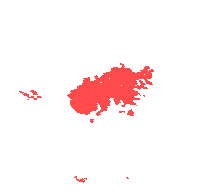

In [ ]:
# --- Map patches + MODIS burned-area overlay (aligned to EVM grid) ---

!pip -q install folium pillow

import folium, json, os, io, base64
import numpy as np
from PIL import Image
from shapely.geometry import Polygon
import rasterio
from rasterio.transform import xy

# ---- choose the event/month you want to view ----
event_base = "Camp_2018_11"    # change as needed
year_month = "2018-11"
OUT = f"/content/patches_{event_base}_{year_month}"

# 1) Load patch footprints (from your extractor output)
gj_path = f"{OUT}/patch_footprints.geojson"
assert os.path.exists(gj_path), f"Missing {gj_path}"
with open(gj_path) as f:
    gj = json.load(f)

# 2) Fetch matching local GeoTIFFs (copy from GCS if not present)
burn_tif, evm_tif = copy_pair(event_base, year_month)   # uses your earlier helper

# 3) Read EVM (for map bounds) and reproject burned mask to the same grid
with rasterio.open(evm_tif) as eds:
    H, W = eds.height, eds.width
    T = eds.transform
    bounds = eds.bounds   # (left, bottom, right, top)

# burn_aligned: (H, W) float32 on EVM grid  (from your earlier helper)
burn_aligned = reproject_to_match(burn_tif, evm_tif)
burn_mask = (burn_aligned > 0).astype(np.uint8)

# 4) Build a semi-transparent red RGBA overlay image
#    - red where burned (alpha ~ 180), transparent elsewhere
overlay_rgba = np.zeros((H, W, 4), dtype=np.uint8)
overlay_rgba[..., 0] = 255  # R
overlay_rgba[..., 3] = (burn_mask * 180).astype(np.uint8)  # Alpha

# (optional) downsample overlay for lighter map tiles
MAX_EDGE = 2000
scale = max(1, int(max(H, W) / MAX_EDGE))
if scale > 1:
    overlay_small = overlay_rgba[::scale, ::scale, :]
else:
    overlay_small = overlay_rgba

# 5) Compute map center from patch polygons
coords = []
for feat in gj["features"]:
    ring = feat["geometry"]["coordinates"][0]
    coords.extend(ring)
center_lat = sum(y for x,y in coords)/len(coords)
center_lon = sum(x for x,y in coords)/len(coords)

# 6) Folium map + basemaps
m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, GIS User Community",
    name="Esri World Imagery",
).add_to(m)
folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

# 7) Add the MODIS burned overlay (as an ImageOverlay with EVM bounds)
from folium.raster_layers import ImageOverlay
img_overlay = ImageOverlay(
    image=overlay_small,                 # numpy RGBA
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=1.0,                         # alpha is inside the RGBA already
    name="MODIS Burned (red)",
    interactive=False,
    cross_origin=False,
    zindex=500,
)
img_overlay.add_to(m)

# 8) Add patch rectangles with popups (RGB + burn previews)
def _b64_img(fp, max_px=256):
    if not os.path.exists(fp): return ""
    with Image.open(fp) as im:
        im.thumbnail((max_px, max_px))
        buf = io.BytesIO(); im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def popup_html(pid, kind):
    rgb_fp  = os.path.join(OUT, f"{pid}_rgb.png")
    burn_fp = os.path.join(OUT, f"{pid}_burn.png")
    rgb64 = _b64_img(rgb_fp); burn64 = _b64_img(burn_fp)
    return f"""
    <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
      <b>{pid}</b> &nbsp; <span style="color:{'red' if kind=='pos' else 'gold'}">({kind})</span><br/>
      {'<img src="data:image/png;base64,'+rgb64+'" style="margin-right:8px;"/>' if rgb64 else ''}
      {'<img src="data:image/png;base64,'+burn64+'"/>' if burn64 else ''}
    </div>
    """

fg_pos = folium.FeatureGroup(name="Burned patches (pos)", show=True)
fg_neg = folium.FeatureGroup(name="Nearby negatives (neg)", show=True)

pos_count = neg_count = 0
for feat in gj["features"]:
    kind = feat["properties"].get("kind", "pos")
    pid  = feat["properties"].get("id", "patch")
    ring = feat["geometry"]["coordinates"][0]  # [[lon,lat],...]
    latlngs = [(lat, lon) for lon, lat in ring]

    rect = folium.Polygon(
        locations=latlngs,
        color=("red" if kind=="pos" else "gold"),
        weight=(2 if kind=="pos" else 1.5),
        fill=False,
        tooltip=f"{pid} ({kind})",
        popup=folium.Popup(popup_html(pid, kind), max_width=650),
    )
    if kind == "pos":
        fg_pos.add_child(rect); pos_count += 1
    else:
        fg_neg.add_child(rect); neg_count += 1

fg_pos.add_to(m); fg_neg.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

# Caption box
caption = f"""
<div style='position: fixed; bottom: 10px; left: 10px; z-index: 9999;
            background: rgba(255,255,255,0.9); border-radius: 8px; padding: 8px 10px;
            font-family: system-ui, Roboto, Arial; font-size: 13px;'>
  <b>{event_base} — {year_month}</b><br/>
  <span style="color:#d00;">Red overlay</span>: MODIS burned pixels<br/>
  <span style="color:red;">Red boxes</span>: positive patches &nbsp;&nbsp;
  <span style="color:gold;">Gold boxes</span>: nearby negatives<br/>
  Pos: {pos_count} &nbsp; Neg: {neg_count}
</div>
"""
m.get_root().html.add_child(folium.Element(caption))

m


In [ ]:
# === Build Folium maps for ALL events with MODIS burned overlay (aligned to EVM grid) ===
!pip -q install folium pillow

import os, io, json, base64, re, sys
import numpy as np
from PIL import Image
import folium
from folium.raster_layers import ImageOverlay
import rasterio

# ---------- sanity: required helpers ----------
if "copy_pair" not in globals() or "reproject_to_match" not in globals():
    raise RuntimeError(
        "This cell expects 'copy_pair(event_base, year_month)' and "
        "'reproject_to_match(burn_tif, evm_tif)' to be defined in a prior cell."
    )

# ---------- settings ----------
PATCH_ROOT = "/content"  # where your extractor wrote: patches_<event_base>_<YYYY-MM>/
MAX_EDGE   = 2000        # downsample overlay so the map is snappy (raise for sharper)
ALPHA      = 180         # opacity of the red burned overlay (0–255)

# ---------- events ----------
# (name used in folder names), counties (unused here), (year, month)
events = [
    ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
]

# ---------- tiny helpers ----------
def _b64_inline_png(path, max_px=256):
    if not os.path.exists(path):
        return ""
    with Image.open(path) as im:
        im.thumbnail((max_px, max_px))
        buf = io.BytesIO()
        im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def _popup_html(OUT, pid, kind):
    rgb64  = _b64_inline_png(os.path.join(OUT, f"{pid}_rgb.png"))
    burn64 = _b64_inline_png(os.path.join(OUT, f"{pid}_burn.png"))
    return f"""
    <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
      <b>{pid}</b> &nbsp; <span style="color:{'red' if kind=='pos' else 'gold'}">({kind})</span><br/>
      {'<img src="data:image/png;base64,'+rgb64+'" style="margin-right:8px;"/>' if rgb64 else ''}
      {'<img src="data:image/png;base64,'+burn64+'"/>' if burn64 else ''}
    </div>"""

def build_map_for_event(event_base, yr, mo):
    """Create map for one (event_base, YYYY-MM).
       Returns (html_path, (pos_count, neg_count)) or (None, None) if skipped."""
    year_month = f"{yr}-{mo:02d}"
    OUT = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    gj_path = f"{OUT}/patch_footprints.geojson"

    if not os.path.exists(gj_path):
        print(f"!! Missing {gj_path}, skipping {event_base} {year_month}")
        return None, None

    # --- load footprints & center ---
    with open(gj_path) as f:
        gj = json.load(f)
    coords = []
    for feat in gj.get("features", []):
        geom = feat.get("geometry", {})
        if not geom or geom.get("type") != "Polygon":
            continue
        ring = geom["coordinates"][0]  # [[lon, lat], ...]
        coords.extend(ring)
    if not coords:
        print(f"!! No polygon coords in {gj_path}, skipping {event_base} {year_month}")
        return None, None

    center_lat = sum(y for x, y in coords) / len(coords)
    center_lon = sum(x for x, y in coords) / len(coords)

    # --- rasters: burned (MODIS) + EVM, aligned to EVM grid ---
    try:
        burn_tif, evm_tif = copy_pair(event_base, year_month)
    except FileNotFoundError as e:
        print(f"!! {e} — skipping {event_base} {year_month}")
        return None, None

    with rasterio.open(evm_tif) as eds:
        H, W = eds.height, eds.width
        bounds = eds.bounds  # left, bottom, right, top

    burn_aligned = reproject_to_match(burn_tif, evm_tif)  # (H, W) float32 on EVM grid
    burn_mask = (burn_aligned > 0).astype(np.uint8)

    # RGBA overlay (red where burned)
    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    overlay[..., 0] = 255
    overlay[..., 3] = (burn_mask * ALPHA).astype(np.uint8)

    # downsample overlay if large (keeps folium display responsive)
    scale = max(1, int(max(H, W) / MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :] if scale > 1 else overlay

    # --- Folium map ---
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, GIS User Community",
        name="Esri World Imagery",
    ).add_to(m)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        opacity=1.0,   # alpha baked into RGBA
        name="MODIS Burned (red)",
        interactive=False,
        cross_origin=False,
        zindex=500,
    ).add_to(m)

    # patch rectangles & popups
    fg_pos = folium.FeatureGroup(name="Burned patches (pos)", show=True)
    fg_neg = folium.FeatureGroup(name="Nearby negatives (neg)", show=True)
    pos_count = neg_count = 0

    for feat in gj["features"]:
        props = feat.get("properties", {}) or {}
        kind = props.get("kind", "pos")
        pid  = props.get("id", "patch")
        ring = feat["geometry"]["coordinates"][0]  # [[lon, lat], ...]
        latlngs = [(lat, lon) for lon, lat in ring]  # folium expects (lat, lon)

        rect = folium.Polygon(
            locations=latlngs,
            color=("red" if kind == "pos" else "gold"),
            weight=(2 if kind == "pos" else 1.5),
            fill=False,
            tooltip=f"{pid} ({kind})",
            popup=folium.Popup(_popup_html(OUT, pid, kind), max_width=650),
        )
        if kind == "pos":
            fg_pos.add_child(rect); pos_count += 1
        else:
            fg_neg.add_child(rect); neg_count += 1

    fg_pos.add_to(m); fg_neg.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)

    # caption
    caption = f"""
    <div style='position: fixed; bottom: 10px; left: 10px; z-index: 9999;
                background: rgba(255,255,255,0.9); border-radius: 8px; padding: 8px 10px;
                font-family: system-ui, Roboto, Arial; font-size: 13px;'>
      <b>{event_base} — {year_month}</b><br/>
      <span style="color:#d00;">Red overlay</span>: MODIS burned pixels<br/>
      <span style="color:red;">Red boxes</span>: positive patches &nbsp;&nbsp;
      <span style="color:gold;">Gold boxes</span>: nearby negatives<br/>
      Pos: {pos_count} &nbsp; Neg: {neg_count}
    </div>"""
    m.get_root().html.add_child(folium.Element(caption))

    os.makedirs(OUT, exist_ok=True)
    out_html = f"{OUT}/map_{event_base}_{year_month}.html"
    m.save(out_html)
    print(f"✓ Saved map → {out_html}")
    return out_html, (pos_count, neg_count)

# ---------- run for ALL events ----------
built = []
missing = []
for event_base, _counties, (yr, mo) in events:
    html_path, counts = build_map_for_event(event_base, yr, mo)
    if html_path:
        built.append((event_base, f"{yr}-{mo:02d}", html_path, counts))
    else:
        missing.append((event_base, f"{yr}-{mo:02d}"))

print("\nDone. Built maps for", len(built), "event-months.")
if missing:
    print("Skipped (missing footprints or manifest pair):")
    for ev, ym in missing:
        print(" -", ev, ym)

# ---------- global index ----------
index_html = os.path.join(PATCH_ROOT, "patch_maps_index.html")
with open(index_html, "w") as f:
    f.write("<h2>Patch Maps (MODIS burn overlay + patches)</h2>\n<ul>\n")
    for ev, ym, hp, (pc, nc) in built:
        rel = hp.replace(PATCH_ROOT + "/", "")
        f.write(
            f"<li><a href='/{rel}' target='_blank'>{ev} — {ym}</a> "
            f"(Pos: {pc}, Neg: {nc})</li>\n"
        )
    f.write("</ul>\n")
print("Index:", index_html)


Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif
✓ Saved map → /content/patches_Cedar_2003_10_2003-10/map_Cedar_2003_10_2003-10.html
Copying:
  gs://california-fire-model/burned_events/FallFire_2007_10/Burned_FallFire_2007_10_2007-10.tif → /content/data/Burned_FallFire_2007_10_2007-10.tif 
  gs://california-fire-model/evms_events/FallFire_2007_10/EVM_FallFire_2007_10_2007-10.tif → /content/data/EVM_FallFire_2007_10_2007-10.tif
✓ Saved map → /content/patches_FallFire_2007_10_2007-10/map_FallFire_2007_10_2007-10.html
Copying:
  gs://california-fire-model/burned_events/Station_2009_08/Burned_Station_2009_08_2009-08.tif → /content/data/Burned_Station_2009_08_2009-08.tif 
  gs://california-fire-model/evms_events/Station_2009_08/EVM_Station_2009_08_2009-08.tif → /c

In [ ]:
# === Build Folium maps for ALL events with MODIS burned overlay (aligned to EVM grid)
#     and auto-generate patch_footprints.geojson from manifest.csv if missing. ===

!pip -q install folium pillow

import os, io, json, base64, warnings, glob, csv
from pathlib import Path
import numpy as np
from PIL import Image
import folium
from folium.raster_layers import ImageOverlay
import rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling as RS
from affine import Affine

# ------------------------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------------------------
# Where your local GeoTIFFs live (add/adjust to match your paths)
SEARCH_DIRS = [
    "/content/data/evms_events",
    "/content/data/burned_events",
    "/content/data",
    "/content",
]

# (Optional) If your files are only in GCS, run this ONCE (uncomment):
# !mkdir -p /content/data/evms_events /content/data/burned_events
# !gsutil -m cp -n "gs://california-fire-model/evms_events/*/*.tif"   /content/data/evms_events/
# !gsutil -m cp -n "gs://california-fire-model/burned_events/*/*.tif" /content/data/burned_events/

# Where your patch folders & html outputs live
PATCH_ROOT       = "/content"   # e.g., /content/patches_<EVENT>_<YYYY-MM>/
MAX_EDGE         = 2000         # downsample overlays so the map stays responsive
ALPHA            = 180          # opacity (0–255) of the burned overlay
SHOW_EVM_RGB     = True         # underlay a pseudo-RGB derived from the EVM stack
POS_COLOR        = "#e31a1c"    # red for positive patches
NEG_COLOR        = "#ffd700"    # gold for negative patches
PATCH_SIZE_DEFAULT = 16         # used if manifest doesn't carry size info

# Your event list (name, counties[unused here], (year, month))
events = [
    ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
]

# ------------------------------------------------------------------------------------
# FILE DISCOVERY + PROJECTION GUARDS
# ------------------------------------------------------------------------------------
def _rank(paths, prefer=None):
    prefer = prefer or []
    def score(p):
        s = 0
        base = os.path.basename(p).lower()
        for kw in prefer:
            if kw in base:
                s += 10
        # prefer shorter file names (tend to be more specific)
        return (s, -len(base))
    return sorted(paths, key=score, reverse=True)

def _find_one(patterns, prefer=None):
    hits = []
    for d in SEARCH_DIRS:
        for pat in patterns:
            hits += glob.glob(os.path.join(d, pat), recursive=True)
    hits = [h for h in hits if h.lower().endswith(".tif")]
    hits = _rank(hits, prefer=prefer)
    return hits[0] if hits else None

def assert_crs_wgs84(evm_path, target_crs="EPSG:4326"):
    """Fail fast unless EVM is WGS84 (Folium bounds expect lat/lon)."""
    with rasterio.open(evm_path) as ds:
        if ds.crs is None or ds.crs.to_string() != target_crs:
            raise RuntimeError(
                f"[Projection error] {os.path.basename(evm_path)} has CRS={ds.crs}. "
                f"Expected {target_crs}. Re-export with crs='EPSG:4326' (and scale≈500)."
            )

def reproject_to_match(src_path, ref_path, resampling=RS.nearest):
    """
    Reproject src raster (e.g., burned mask) to exactly match ref raster (e.g., EVM).
    Returns (H,W) for single-band src; (bands,H,W) otherwise.
    """
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst = np.zeros((src.count, ref.height, ref.width), dtype=src.dtypes[0])
        for b in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, b),
                destination=dst[b-1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                resampling=resampling
            )
    return dst if dst.shape[0] > 1 else dst[0]

def copy_pair(event_base, year_month):
    """
    Returns:
      burn_tif (str), evm_tif (str)

    Tries several filename patterns so it works with both old and new exports:
      - New style:  EVM13_<EVENT>_<YYYY-MM>_WGS84_500m.tif
                    Burned_<EVENT>_<YYYY-MM>_WGS84_500m.tif
      - Old style:  EVM_<EVENT>_<YYYY-MM>.tif
                    Burned_<EVENT>_<YYYY-MM>.tif
      - Fuzzy:      *<EVENT>*<YYYY-MM>*EVM*.tif / *Burned*<EVENT>*<YYYY-MM>*.tif
    """
    # EVM (prefer WGS84_500m and EVM13)
    evm_patterns = [
        f"**/EVM13_{event_base}_{year_month}_WGS84_500m*.tif",
        f"**/EVM_{event_base}_{year_month}_WGS84_500m*.tif",
        f"**/EVM_{event_base}_{year_month}.tif",
        f"**/{event_base}/{event_base}_{year_month}*EVM*.tif",
        f"**/*{event_base}*{year_month}*EVM*.tif",
    ]
    evm = _find_one(evm_patterns, prefer=["wgs84_500m","evm13"])
    if evm is None:
        raise FileNotFoundError(
            f"EVM not found for {event_base} {year_month}. "
            f"Searched:\n  " + "\n  ".join(evm_patterns) + "\nCheck SEARCH_DIRS."
        )

    # Burned mask (prefer WGS84_500m)
    burn_patterns = [
        f"**/Burned_{event_base}_{year_month}_WGS84_500m*.tif",
        f"**/Burned_{event_base}_{year_month}.tif",
        f"**/{event_base}/Burned_{event_base}_*{year_month}*.tif",
        f"**/*Burned*{event_base}*{year_month}*.tif",
    ]
    burn = _find_one(burn_patterns, prefer=["wgs84_500m"])
    if burn is None:
        raise FileNotFoundError(
            f"Burned mask not found for {event_base} {year_month}. "
            f"Searched:\n  " + "\n  ".join(burn_patterns) + "\nCheck SEARCH_DIRS."
        )

    # Enforce Folium-friendly CRS on EVM
    assert_crs_wgs84(evm)
    return burn, evm

# ------------------------------------------------------------------------------------
# FOOTPRINTS: build from manifest.csv if missing
# ------------------------------------------------------------------------------------
def _infer_kind(row, pid: str) -> str:
    # 1) explicit 'kind' column
    k = (row.get("kind") or row.get("label") or row.get("y_label") or "").strip().lower()
    if k in ("pos", "neg"):
        return k
    # 2) numeric label columns
    for key in ("label", "y", "is_pos", "target"):
        if key in row:
            val = row[key].strip().lower()
            if val in ("1","true","yes","pos"): return "pos"
            if val in ("0","false","no","neg"): return "neg"
    # 3) id prefix pattern
    pid_l = (pid or "").lower()
    if pid_l.startswith("pos_"): return "pos"
    if pid_l.startswith("neg_"): return "neg"
    # default to pos
    return "pos"

def _patch_size_from_row(row) -> int:
    for key in ("h","height","H","patch_h","hw","size","patch","psz","pixels"):
        if key in row:
            try:
                return int(row[key])
            except Exception:
                pass
    # if separate w exists verify square; else default
    for key in ("w","width","W","patch_w"):
        if key in row:
            try:
                return int(row[key])
            except Exception:
                pass
    return PATCH_SIZE_DEFAULT

def _ring_from_pixels(transform: Affine, x0:int, y0:int, size:int, H:int, W:int):
    # clamp to image bounds
    x1 = min(x0 + size, W)
    y1 = min(y0 + size, H)
    # corners in pixel coords -> lon/lat via affine transform (EVM is EPSG:4326)
    tl = (transform * (x0, y0))  # (lon, lat)
    tr = (transform * (x1, y0))
    br = (transform * (x1, y1))
    bl = (transform * (x0, y1))
    ring = [[tl[0], tl[1]], [tr[0], tr[1]], [br[0], br[1]], [bl[0], bl[1]], [tl[0], tl[1]]]
    return ring

def ensure_footprints(event_base: str, year_month: str, evm_tif: str, out_dir: str) -> str:
    """
    Ensures patches_<EVENT>_<YYYY-MM>/patch_footprints.geojson exists.
    If missing, builds it from manifest.csv using EVM geotransform.
    Returns path to the geojson (existing or created).
    """
    OUT   = f"{out_dir}/patches_{event_base}_{year_month}"
    gj    = f"{OUT}/patch_footprints.geojson"
    man   = f"{OUT}/manifest.csv"
    if os.path.exists(gj):
        return gj
    if not os.path.exists(man):
        raise FileNotFoundError(f"Missing {man} (needed to synthesize footprints).")

    with rasterio.open(evm_tif) as ds:
        H, W = ds.height, ds.width
        transform = ds.transform

    feats = []
    with open(man, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            pid = row.get("id") or row.get("patch_id") or row.get("name") or ""
            try:
                y0 = int(row.get("y0"))
                x0 = int(row.get("x0"))
            except Exception:
                # allow alternate names
                y0 = int(row.get("row") or row.get("r") or row.get("y"))
                x0 = int(row.get("col") or row.get("c") or row.get("x"))
            psz = _patch_size_from_row(row)
            kind = _infer_kind(row, pid)
            ring = _ring_from_pixels(transform, x0, y0, psz, H, W)

            feats.append({
                "type": "Feature",
                "properties": {"id": pid, "kind": kind, "size": psz},
                "geometry": {"type": "Polygon", "coordinates": [ring]},
            })

    os.makedirs(OUT, exist_ok=True)
    with open(gj, "w") as f:
        json.dump({"type": "FeatureCollection", "features": feats}, f)
    print(f"✓ Built footprints → {gj}  (from {os.path.basename(man)})")
    return gj

# ------------------------------------------------------------------------------------
# VISUAL HELPERS
# ------------------------------------------------------------------------------------
def _b64_inline_png(path, max_px=256):
    if not os.path.exists(path):
        return ""
    with Image.open(path) as im:
        im.thumbnail((max_px, max_px))
        buf = io.BytesIO()
        im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def _popup_html(OUT, pid, kind):
    rgb64  = _b64_inline_png(os.path.join(OUT, f"{pid}_rgb.png"))
    burn64 = _b64_inline_png(os.path.join(OUT, f"{pid}_burn.png"))
    return f"""
    <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
      <b>{pid}</b> &nbsp; <span style="color:{'red' if kind=='pos' else 'gold'}">({kind})</span><br/>
      {'<img src="data:image/png;base64,'+rgb64+'" style="margin-right:8px;"/>' if rgb64 else ''}
      {'<img src="data:image/png;base64,'+burn64+'"/>' if burn64 else ''}
    </div>"""

def _p_stretch(a, p1=2, p2=98):
    a = a.astype(np.float32)
    lo, hi = np.nanpercentile(a, [p1, p2])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        mn, mx = np.nanmin(a), np.nanmax(a)
        return np.clip((a - mn)/(mx - mn + 1e-6), 0, 1)
    return np.clip((a - lo)/(hi - lo), 0, 1)

def _evm_pseudo_rgb(evm_path):
    """
    Pseudo-RGB from EVM stack: R=LAI, G=NDVI, B=elev (if present) else precip.
    Works with 9-band (...,NDVI,LAI) or 13-band (... + elev,slope,lfmc,nlcd).
    Returns (H,W,3) uint8.
    """
    with rasterio.open(evm_path) as ds:
        x = ds.read(out_dtype="float32")  # (C,H,W)
    C, H, W = x.shape
    idx_ndvi = 7 if C >= 8 else 0
    idx_lai  = 8 if C >= 9 else idx_ndvi
    idx_elev = 9 if C >= 10 else (2 if C >= 3 else 0)
    R = _p_stretch(x[idx_lai])
    G = _p_stretch(x[idx_ndvi])
    B = _p_stretch(x[idx_elev])
    rgb = (np.stack([R, G, B], axis=-1) * 255.0).clip(0, 255).astype(np.uint8)
    return rgb

# ------------------------------------------------------------------------------------
# MAP BUILDER
# ------------------------------------------------------------------------------------
def build_map_for_event(event_base, yr, mo):
    """Create map for one (event_base, YYYY-MM).
       Returns (html_path, (pos_count, neg_count)) or (None, None) if skipped."""
    year_month = f"{yr}-{mo:02d}"
    OUT = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    os.makedirs(OUT, exist_ok=True)

    # Locate rasters first (so we can synthesize footprints in the same CRS)
    try:
        burn_tif, evm_tif = copy_pair(event_base, year_month)
    except (FileNotFoundError, RuntimeError) as e:
        print(f"!! {e} — skipping {event_base} {year_month}")
        return None, None

    # Ensure footprints exist (build from manifest.csv if missing)
    gj_path = f"{OUT}/patch_footprints.geojson"
    if not os.path.exists(gj_path):
        try:
            gj_path = ensure_footprints(event_base, year_month, evm_tif, PATCH_ROOT)
        except Exception as e:
            print(f"!! Could not build footprints for {event_base} {year_month}: {e}")
            return None, None

    # Load footprints & compute rough center
    with open(gj_path) as f:
        gj = json.load(f)
    coords = []
    for feat in gj.get("features", []):
        geom = feat.get("geometry", {})
        if not geom or geom.get("type") != "Polygon":
            continue
        coords.extend(geom["coordinates"][0])  # [[lon, lat], ...]
    if not coords:
        print(f"!! No polygon coords in {gj_path}, skipping {event_base} {year_month}")
        return None, None
    center_lat = sum(y for x, y in coords) / len(coords)
    center_lon = sum(x for x, y in coords) / len(coords)

    # Read EVM spatial info and bounds
    with rasterio.open(evm_tif) as eds:
        H, W = eds.height, eds.width
        bounds = eds.bounds  # left, bottom, right, top

    # Warp burned mask -> EVM grid
    burn_on_evm = reproject_to_match(burn_tif, evm_tif, resampling=RS.nearest)
    if burn_on_evm.ndim == 3:
        burn_on_evm = burn_on_evm[0]
    burn_mask = (burn_on_evm > 0).astype(np.uint8)

    # Red overlay with alpha where burned
    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    overlay[..., 0] = 255  # red
    overlay[..., 3] = (burn_mask * ALPHA).astype(np.uint8)

    # Optional EVM pseudo-RGB underlay
    evm_rgb = None
    if SHOW_EVM_RGB:
        try:
            evm_rgb = _evm_pseudo_rgb(evm_tif)  # (H,W,3)
        except Exception as e:
            warnings.warn(f"[EVM RGB] Failed for {event_base} {year_month}: {e}")

    # Downsample heavy overlays to keep maps responsive
    scale = max(1, int(max(H, W) / MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :] if scale > 1 else overlay
    evm_rgb_small = evm_rgb[::scale, ::scale, :] if (evm_rgb is not None and scale > 1) else evm_rgb

    # Base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)
    folium.TileLayer("OpenStreetMap", name="Streets", control=True).add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, GIS User Community",
        name="Esri World Imagery",
        control=True
    ).add_to(m)

    # Underlay (EVM pseudo-RGB)
    if evm_rgb_small is not None:
        ImageOverlay(
            image=evm_rgb_small,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=1.0,
            name="EVM pseudo-RGB",
            interactive=False,
            cross_origin=False,
            zindex=400,
        ).add_to(m)

    # Burn overlay
    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        opacity=1.0,  # alpha baked into RGBA
        name="MODIS Burned (red)",
        interactive=False,
        cross_origin=False,
        zindex=500,
    ).add_to(m)

    # Patch rectangles with popups
    fg_pos = folium.FeatureGroup(name="Burned patches (pos)", show=True)
    fg_neg = folium.FeatureGroup(name="Nearby negatives (neg)", show=True)
    pos_count = neg_count = 0

    for feat in gj.get("features", []):
        props = feat.get("properties", {}) or {}
        kind = props.get("kind", "pos")
        pid  = props.get("id", "patch")
        geom = feat.get("geometry", {})
        if not geom or geom.get("type") != "Polygon":
            continue
        ring = geom["coordinates"][0]  # [[lon, lat], ...]
        latlngs = [(lat, lon) for lon, lat in ring]  # folium expects (lat, lon)

        rect = folium.Polygon(
            locations=latlngs,
            color=(POS_COLOR if kind == "pos" else NEG_COLOR),
            weight=(2 if kind == "pos" else 1.5),
            fill=False,
            tooltip=f"{pid} ({kind})",
            popup=folium.Popup(_popup_html(OUT, pid, kind), max_width=650),
        )
        if kind == "pos":
            fg_pos.add_child(rect); pos_count += 1
        else:
            fg_neg.add_child(rect); neg_count += 1

    fg_pos.add_to(m); fg_neg.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)

    # Caption
    caption = f"""
    <div style='position: fixed; bottom: 10px; left: 10px; z-index: 9999;
                background: rgba(255,255,255,0.9); border-radius: 8px; padding: 8px 10px;
                font-family: system-ui, Roboto, Arial; font-size: 13px;'>
      <b>{event_base} — {year_month}</b><br/>
      <span style="color:#d00;">Red overlay</span>: MODIS burned pixels (aligned to EVM grid)<br/>
      <span style="color:{POS_COLOR};">Red boxes</span>: positive patches &nbsp;&nbsp;
      <span style="color:{NEG_COLOR};">Gold boxes</span>: nearby negatives<br/>
      Pos: {pos_count} &nbsp; Neg: {neg_count}
    </div>"""
    m.get_root().html.add_child(folium.Element(caption))

    # Write file
    out_html = f"{OUT}/map_{event_base}_{year_month}.html"
    m.save(out_html)
    print(f"✓ Saved map → {out_html}")
    return out_html, (pos_count, neg_count)

# ------------------------------------------------------------------------------------
# RUN FOR ALL EVENTS + INDEX
# ------------------------------------------------------------------------------------
built = []
missing = []
for event_base, _counties, (yr, mo) in events:
    try:
        html_path, counts = build_map_for_event(event_base, yr, mo)
        if html_path:
            built.append((event_base, f"{yr}-{mo:02d}", html_path, counts))
        else:
            missing.append((event_base, f"{yr}-{mo:02d}"))
    except Exception as e:
        print(f"!! Failed {event_base} {yr}-{mo:02d}: {e}")
        missing.append((event_base, f"{yr}-{mo:02d}"))

print("\nDone. Built maps for", len(built), "event-months.")
if missing:
    print("Skipped / failed:")
    for ev, ym in missing:
        print(" -", ev, ym)

# Global index
index_html = os.path.join(PATCH_ROOT, "patch_maps_index.html")
with open(index_html, "w") as f:
    f.write("<h2>Patch Maps (EVM pseudo-RGB + MODIS burn overlay + patches)</h2>\n<ul>\n")
    for ev, ym, hp, (pc, nc) in built:
        rel = hp.replace(PATCH_ROOT + "/", "")
        f.write(
            f"<li><a href='/{rel}' target='_blank'>{ev} — {ym}</a> "
            f"(Pos: {pc}, Neg: {nc})</li>\n"
        )
    f.write("</ul>\n")
print("Index:", index_html)


!! EVM not found for Cedar_2003_10 2003-10. Searched:
  **/EVM13_Cedar_2003_10_2003-10_WGS84_500m*.tif
  **/EVM_Cedar_2003_10_2003-10_WGS84_500m*.tif
  **/EVM_Cedar_2003_10_2003-10.tif
  **/Cedar_2003_10/Cedar_2003_10_2003-10*EVM*.tif
  **/*Cedar_2003_10*2003-10*EVM*.tif
Check SEARCH_DIRS. — skipping Cedar_2003_10 2003-10
!! EVM not found for FallFire_2007_10 2007-10. Searched:
  **/EVM13_FallFire_2007_10_2007-10_WGS84_500m*.tif
  **/EVM_FallFire_2007_10_2007-10_WGS84_500m*.tif
  **/EVM_FallFire_2007_10_2007-10.tif
  **/FallFire_2007_10/FallFire_2007_10_2007-10*EVM*.tif
  **/*FallFire_2007_10*2007-10*EVM*.tif
Check SEARCH_DIRS. — skipping FallFire_2007_10 2007-10
!! EVM not found for Station_2009_08 2009-08. Searched:
  **/EVM13_Station_2009_08_2009-08_WGS84_500m*.tif
  **/EVM_Station_2009_08_2009-08_WGS84_500m*.tif
  **/EVM_Station_2009_08_2009-08.tif
  **/Station_2009_08/Station_2009_08_2009-08*EVM*.tif
  **/*Station_2009_08*2009-08*EVM*.tif
Check SEARCH_DIRS. — skipping Station_2009

Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif



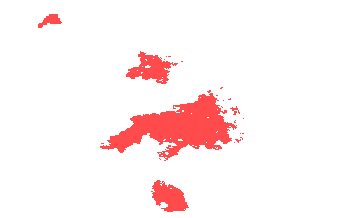

✓ Saved map → /content/patches_Cedar_2003_10_2003-10/map_Cedar_2003_10_2003-10.html
Copying:
  gs://california-fire-model/burned_events/FallFire_2007_10/Burned_FallFire_2007_10_2007-10.tif → /content/data/Burned_FallFire_2007_10_2007-10.tif 
  gs://california-fire-model/evms_events/FallFire_2007_10/EVM_FallFire_2007_10_2007-10.tif → /content/data/EVM_FallFire_2007_10_2007-10.tif



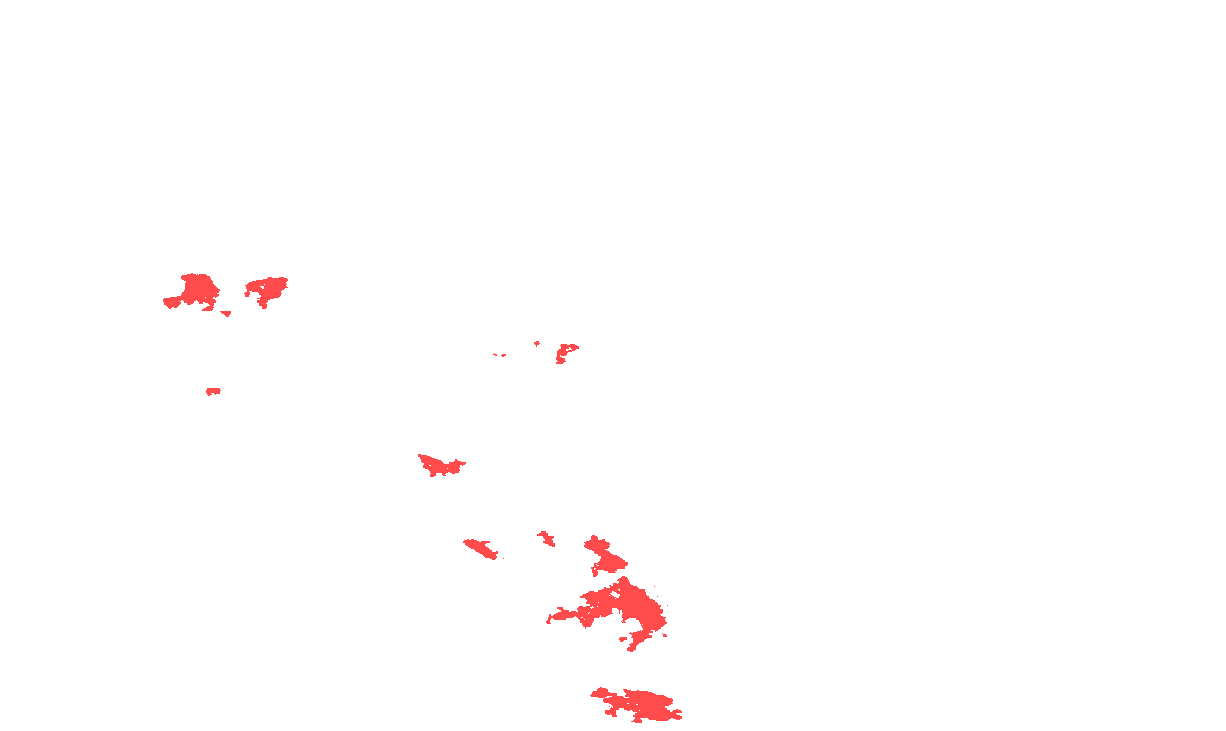

✓ Saved map → /content/patches_FallFire_2007_10_2007-10/map_FallFire_2007_10_2007-10.html
Copying:
  gs://california-fire-model/burned_events/Station_2009_08/Burned_Station_2009_08_2009-08.tif → /content/data/Burned_Station_2009_08_2009-08.tif 
  gs://california-fire-model/evms_events/Station_2009_08/EVM_Station_2009_08_2009-08.tif → /content/data/EVM_Station_2009_08_2009-08.tif



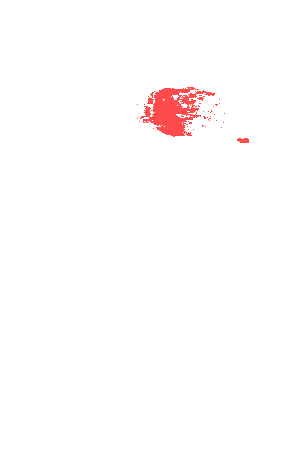

✓ Saved map → /content/patches_Station_2009_08_2009-08/map_Station_2009_08_2009-08.html
Copying:
  gs://california-fire-model/burned_events/LaBrea_2009_08/Burned_LaBrea_2009_08_2009-08.tif → /content/data/Burned_LaBrea_2009_08_2009-08.tif 
  gs://california-fire-model/evms_events/LaBrea_2009_08/EVM_LaBrea_2009_08_2009-08.tif → /content/data/EVM_LaBrea_2009_08_2009-08.tif



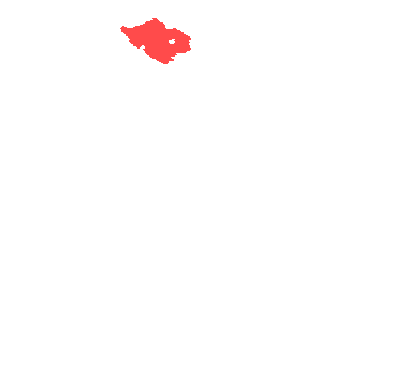

✓ Saved map → /content/patches_LaBrea_2009_08_2009-08/map_LaBrea_2009_08_2009-08.html
Copying:
  gs://california-fire-model/burned_events/Thomas_2017_12/Burned_Thomas_2017_12_2017-12.tif → /content/data/Burned_Thomas_2017_12_2017-12.tif 
  gs://california-fire-model/evms_events/Thomas_2017_12/EVM_Thomas_2017_12_2017-12.tif → /content/data/EVM_Thomas_2017_12_2017-12.tif



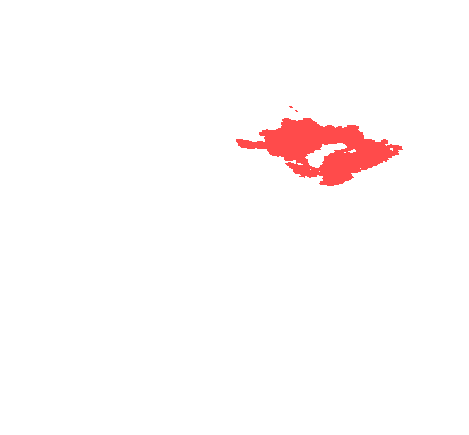

✓ Saved map → /content/patches_Thomas_2017_12_2017-12/map_Thomas_2017_12_2017-12.html
Copying:
  gs://california-fire-model/burned_events/Atlas_2017_10/Burned_Atlas_2017_10_2017-10.tif → /content/data/Burned_Atlas_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Atlas_2017_10/EVM_Atlas_2017_10_2017-10.tif → /content/data/EVM_Atlas_2017_10_2017-10.tif



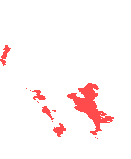

✓ Saved map → /content/patches_Atlas_2017_10_2017-10/map_Atlas_2017_10_2017-10.html
Copying:
  gs://california-fire-model/burned_events/Tubbs_2017_10/Burned_Tubbs_2017_10_2017-10.tif → /content/data/Burned_Tubbs_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Tubbs_2017_10/EVM_Tubbs_2017_10_2017-10.tif → /content/data/EVM_Tubbs_2017_10_2017-10.tif



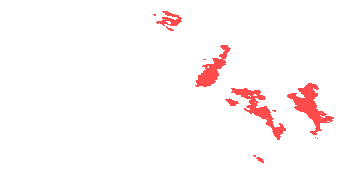

✓ Saved map → /content/patches_Tubbs_2017_10_2017-10/map_Tubbs_2017_10_2017-10.html
Copying:
  gs://california-fire-model/burned_events/Nuns_2017_10/Burned_Nuns_2017_10_2017-10.tif → /content/data/Burned_Nuns_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Nuns_2017_10/EVM_Nuns_2017_10_2017-10.tif → /content/data/EVM_Nuns_2017_10_2017-10.tif



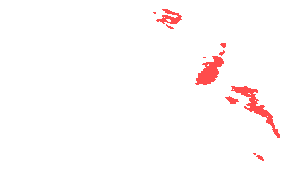

✓ Saved map → /content/patches_Nuns_2017_10_2017-10/map_Nuns_2017_10_2017-10.html
Copying:
  gs://california-fire-model/burned_events/Camp_2018_11/Burned_Camp_2018_11_2018-11.tif → /content/data/Burned_Camp_2018_11_2018-11.tif 
  gs://california-fire-model/evms_events/Camp_2018_11/EVM_Camp_2018_11_2018-11.tif → /content/data/EVM_Camp_2018_11_2018-11.tif



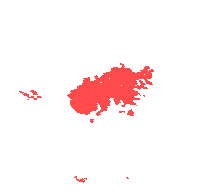

✓ Saved map → /content/patches_Camp_2018_11_2018-11/map_Camp_2018_11_2018-11.html
Copying:
  gs://california-fire-model/burned_events/Carr_2018_07/Burned_Carr_2018_07_2018-07.tif → /content/data/Burned_Carr_2018_07_2018-07.tif 
  gs://california-fire-model/evms_events/Carr_2018_07/EVM_Carr_2018_07_2018-07.tif → /content/data/EVM_Carr_2018_07_2018-07.tif



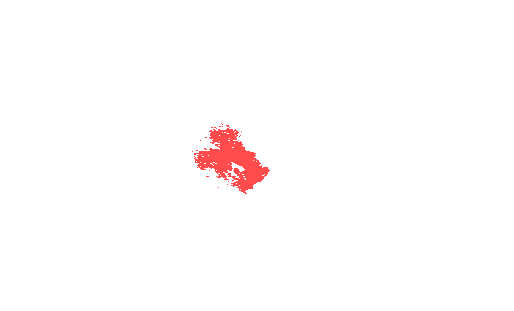

✓ Saved map → /content/patches_Carr_2018_07_2018-07/map_Carr_2018_07_2018-07.html
Copying:
  gs://california-fire-model/burned_events/MendoCx_2018_08/Burned_MendoCx_2018_08_2018-08.tif → /content/data/Burned_MendoCx_2018_08_2018-08.tif 
  gs://california-fire-model/evms_events/MendoCx_2018_08/EVM_MendoCx_2018_08_2018-08.tif → /content/data/EVM_MendoCx_2018_08_2018-08.tif



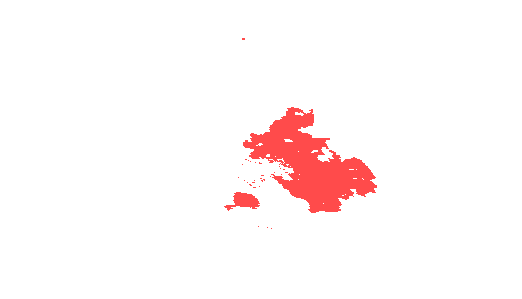

✓ Saved map → /content/patches_MendoCx_2018_08_2018-08/map_MendoCx_2018_08_2018-08.html

Done. Built maps for 11 event-months.
Index: /content/patch_maps_index.html


In [ ]:
# === Build & SHOW Folium maps inline for ALL events (water-safe) ===
!pip -q install folium pillow

import os, io, json, base64, sys, csv, pathlib
import numpy as np
from PIL import Image
import folium
from folium.raster_layers import ImageOverlay
import rasterio
from IPython.display import display, HTML

# ---------- sanity: required helpers ----------
if "copy_pair" not in globals() or "reproject_to_match" not in globals():
    raise RuntimeError(
        "This cell expects 'copy_pair(event_base, year_month)' and "
        "'reproject_to_match(burn_tif, evm_tif)' to be defined in a prior cell."
    )

# ---------- settings ----------
PATCH_ROOT = "/content"      # patches_<event_base>_<YYYY-MM>/
MAX_EDGE   = 2000            # overlay downsample max edge (px)
ALPHA      = 180             # RGBA overlay opacity (0–255)
PATCH      = 16              # must match extractor patch size

# Land/water filtering (same logic as extractor)
LAND_TIF = "/content/landmask_500m.tif"   # if exists: 1=land, 0=water
LAND_MIN_FRAC = 0.70                      # require ≥70% land to show a patch
NDVI_IDX, LAI_IDX = 7, 8                  # fallback indices in EVM cube
NDVI_THR, LAI_THR = 0.10, 0.10

# ---------- events ----------
events = [
    ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
]

# ---------- tiny helpers ----------
def _b64_inline_png(path, max_px=256):
    if not os.path.exists(path): return ""
    with Image.open(path) as im:
        im.thumbnail((max_px, max_px))
        buf = io.BytesIO(); im.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def _popup_html(OUT, pid, kind, land_frac=None):
    rgb64  = _b64_inline_png(os.path.join(OUT, f"{pid}_rgb.png"))
    burn64 = _b64_inline_png(os.path.join(OUT, f"{pid}_burn.png"))
    lf_txt = f"<br/><i>land: {int(round(100*land_frac))}%</i>" if land_frac is not None else ""
    return f"""
    <div style="font-family:system-ui,Roboto,Arial; font-size:13px;">
      <b>{pid}</b> &nbsp; <span style="color:{'red' if kind=='pos' else 'gold'}">({kind})</span>{lf_txt}<br/>
      {'<img src="data:image/png;base64,'+rgb64+'" style="margin-right:8px;"/>' if rgb64 else ''}
      {'<img src="data:image/png;base64,'+burn64+'"/>' if burn64 else ''}
    </div>"""

def _make_land_mask(evm_tif, evm_data):
    """Return uint8 land mask (H,W), 1=land, 0=water."""
    H, W = evm_data.shape[1], evm_data.shape[2]
    if LAND_TIF and pathlib.Path(LAND_TIF).exists():
        lm = reproject_to_match(LAND_TIF, evm_tif)
        return (lm > 0).astype(np.uint8)

    # fallback from NDVI/LAI
    land = np.zeros((H, W), dtype=np.uint8)
    ndvi = evm_data[NDVI_IDX] if 0 <= NDVI_IDX < evm_data.shape[0] else None
    lai  = evm_data[LAI_IDX]  if 0 <= LAI_IDX  < evm_data.shape[0] else None
    if ndvi is not None: land |= (np.nan_to_num(ndvi) > NDVI_THR).astype(np.uint8)
    if lai  is not None: land |= (np.nan_to_num(lai)  > LAI_THR ).astype(np.uint8)
    if ndvi is None and lai is None:
        print("!! Warning: no NDVI/LAI present to build land mask; showing all patches. Provide LAND_TIF for stricter filtering.")
        land[:] = 1
    return land

def build_map_for_event(event_base, yr, mo, show_inline=True):
    """Create and (optionally) display map for one (event_base, YYYY-MM).
       Returns (m, html_path, (pos_count, neg_count, skipped_pos, skipped_neg)) or (None, None, None) if skipped."""
    year_month = f"{yr}-{mo:02d}"
    OUT = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    gj_path = f"{OUT}/patch_footprints.geojson"
    man_csv = f"{OUT}/manifest.csv"

    # Need footprints and manifest (for y0,x0)
    if not os.path.exists(gj_path):
        print(f"!! Missing {gj_path}, skipping {event_base} {year_month}")
        return None, None, None
    if not os.path.exists(man_csv):
        print(f"!! Missing {man_csv}, skipping {event_base} {year_month}")
        return None, None, None

    # Load geojson and manifest index
    with open(gj_path) as f:
        gj = json.load(f)
    id2row = {}
    with open(man_csv) as f:
        r = csv.DictReader(f)
        for row in r:
            # id,kind,y0,x0,center_lon,center_lat
            id2row[row["id"]] = row

    # Center of map from polygons
    coords = []
    for feat in gj.get("features", []):
        geom = feat.get("geometry", {})
        if geom and geom.get("type") == "Polygon":
            ring = geom["coordinates"][0]
            coords.extend(ring)
    if not coords:
        print(f"!! No polygon coords in {gj_path}, skipping {event_base} {year_month}")
        return None, None, None
    center_lat = sum(y for x,y in coords)/len(coords)
    center_lon = sum(x for x,y in coords)/len(coords)

    # --- rasters: burned (MODIS) + EVM, aligned to EVM grid ---
    try:
        burn_tif, evm_tif = copy_pair(event_base, year_month)
    except FileNotFoundError as e:
        print(f"!! {e} — skipping {event_base} {year_month}")
        return None, None, None

    with rasterio.open(evm_tif) as eds:
        H, W = eds.height, eds.width
        bounds = eds.bounds
        evm = eds.read(out_dtype="float32")   # (9,H,W)

    # land & burn on EVM grid
    land_mask = _make_land_mask(evm_tif, evm)                 # (H,W) {0,1}
    burn_aligned = reproject_to_match(burn_tif, evm_tif)      # (H,W) float32
    burn_mask = (burn_aligned > 0).astype(np.uint8)

    # RGBA burned overlay
    overlay = np.zeros((H, W, 4), dtype=np.uint8)
    overlay[..., 0] = 255
    overlay[..., 3] = (burn_mask * ALPHA).astype(np.uint8)

    # downsample overlay if large
    scale = max(1, int(max(H, W) / MAX_EDGE))
    overlay_small = overlay[::scale, ::scale, :] if scale > 1 else overlay

    # --- Folium map ---
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles=None)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, GIS User Community",
        name="Esri World Imagery",
    ).add_to(m)
    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

    ImageOverlay(
        image=overlay_small,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        opacity=1.0,
        name="MODIS Burned (red)",
        interactive=False,
        cross_origin=False,
        zindex=500,
    ).add_to(m)

    # patch rectangles & popups — water-safe
    fg_pos = folium.FeatureGroup(name="Burned patches (pos)", show=True)
    fg_neg = folium.FeatureGroup(name="Nearby negatives (neg)", show=True)
    pos_count = neg_count = 0
    skipped_pos = skipped_neg = 0

    for feat in gj["features"]:
        props = feat.get("properties", {}) or {}
        kind = props.get("kind", "pos")
        pid  = props.get("id")
        if not pid or pid not in id2row:
            continue

        # land fraction via manifest (y0,x0 window on land_mask)
        try:
            y0 = int(id2row[pid]["y0"]); x0 = int(id2row[pid]["x0"])
        except Exception:
            continue
        y1, x1 = y0 + PATCH, x0 + PATCH
        if not (0 <= y0 < y1 <= H and 0 <= x0 < x1 <= W):
            continue

        land_frac = float(land_mask[y0:y1, x0:x1].mean())
        if land_frac < LAND_MIN_FRAC:
            if kind == "pos": skipped_pos += 1
            else:             skipped_neg += 1
            continue

        # polygon (lat,lon) for folium
        ring = feat["geometry"]["coordinates"][0]  # [[lon,lat],...]
        latlngs = [(lat, lon) for lon, lat in ring]

        rect = folium.Polygon(
            locations=latlngs,
            color=("red" if kind == "pos" else "gold"),
            weight=(2 if kind == "pos" else 1.5),
            fill=False,
            tooltip=f"{pid} ({kind}) — land {int(round(100*land_frac))}%",
            popup=folium.Popup(_popup_html(OUT, pid, kind, land_frac), max_width=650),
        )
        if kind == "pos":
            fg_pos.add_child(rect); pos_count += 1
        else:
            fg_neg.add_child(rect); neg_count += 1

    fg_pos.add_to(m); fg_neg.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)

    # caption
    caption = f"""
    <div style='position: fixed; bottom: 10px; left: 10px; z-index: 9999;
                background: rgba(255,255,255,0.9); border-radius: 8px; padding: 8px 10px;
                font-family: system-ui, Roboto, Arial; font-size: 13px;'>
      <b>{event_base} — {year_month}</b><br/>
      <span style="color:#d00;">Red overlay</span>: MODIS burned pixels<br/>
      <span style="color:red;">Red boxes</span>: positive patches &nbsp;&nbsp;
      <span style="color:gold;">Gold boxes</span>: nearby negatives<br/>
      Pos: {pos_count} &nbsp; Neg: {neg_count} &nbsp;
      Skipped water → Pos: {skipped_pos}, Neg: {skipped_neg}
    </div>"""
    m.get_root().html.add_child(folium.Element(caption))

    # save and show
    os.makedirs(OUT, exist_ok=True)
    out_html = f"{OUT}/map_{event_base}_{year_month}.html"
    m.save(out_html)
    if show_inline:
        display(HTML(f"<h4 style='font-family:system-ui;margin:6px 0'>{event_base} — {year_month}</h4>"))
        display(m)

    print(f"✓ Saved map → {out_html}")
    return m, out_html, (pos_count, neg_count, skipped_pos, skipped_neg)

# ---------- run for ALL events & show inline ----------
built = []
missing = []
for event_base, _counties, (yr, mo) in events:
    m, html_path, counts = build_map_for_event(event_base, yr, mo, show_inline=True)
    if html_path:
        built.append((event_base, f"{yr}-{mo:02d}", html_path, counts))
    else:
        missing.append((event_base, f"{yr}-{mo:02d}"))

print("\nDone. Built maps for", len(built), "event-months.")
if missing:
    print("Skipped (missing footprints or manifest pair):")
    for ev, ym in missing:
        print(" -", ev, ym)

# ---------- global index ----------
index_html = os.path.join(PATCH_ROOT, "patch_maps_index.html")
with open(index_html, "w") as f:
    f.write("<h2>Patch Maps (MODIS burn overlay + patches)</h2>\n<ul>\n")
    for ev, ym, hp, (pc, nc, sp, sn) in built:
        rel = hp.replace(PATCH_ROOT + "/", "")
        f.write(
            f"<li><a href='/{rel}' target='_blank'>{ev} — {ym}</a> "
            f"(Pos: {pc}, Neg: {nc}; Skipped water → Pos {sp}, Neg {sn})</li>\n"
        )
    f.write("</ul>\n")
print("Index:", index_html)


In [ ]:
# --- SAFE LOAD for PyTorch 2.6+ (no retraining) ---
import os, numpy as np, torch
from torch.serialization import add_safe_globals

# 1) Allowlist numpy's reconstruct used in older pickles
add_safe_globals([np.core.multiarray._reconstruct])

# 2) Load the mixed-object checkpoint you already saved
ckpt = torch.load(best_path, map_location=DEVICE, weights_only=False)  # <- important
model.load_state_dict(ckpt["state_dict"])

# 3) Recover train normalization stats if present
if "mean" in ckpt and "std" in ckpt:
    train_mean = np.asarray(ckpt["mean"], dtype=np.float32)
    train_std  = np.asarray(ckpt["std"],  dtype=np.float32)

# 4) Convert it once to a future-proof, weights-only file + separate stats
safe_weights_path = os.path.join(OUT_DIR, "unet_best_weights.pt")
stats_path        = os.path.join(OUT_DIR, "norm_stats.npz")

torch.save(model.state_dict(), safe_weights_path)             # weights-only => works with weights_only=True
np.savez(stats_path, mean=train_mean, std=train_std, epoch=int(ckpt.get("epoch", -1)))

print(f"Converted old checkpoint →\n  weights: {safe_weights_path}\n  stats:   {stats_path}")

# 5) Optional: from now on, prefer weights-only loads
state_dict = torch.load(safe_weights_path, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)


/tmp/ipython-input-3172187501.py:6: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  add_safe_globals([np.core.multiarray._reconstruct])


Converted old checkpoint →
  weights: /content/unet_runs/unet_best_weights.pt
  stats:   /content/unet_runs/norm_stats.npz


<All keys matched successfully>

In [ ]:
import numpy as np, torch, os

safe_weights_path = os.path.join(OUT_DIR, "unet_best_weights.pt")
stats_path        = os.path.join(OUT_DIR, "norm_stats.npz")

# load weights-only (safe on PyTorch 2.6+)
state_dict = torch.load(safe_weights_path, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)

# load normalization stats
stats = np.load(stats_path)
train_mean = stats["mean"].astype(np.float32)
train_std  = stats["std"].astype(np.float32)
print("Weights+stats loaded ✔")


Weights+stats loaded ✔


In [ ]:
import numpy as np

def sweep_threshold(loader, model, grid=np.linspace(0.1, 0.9, 17)):
    model.eval()
    best_t, best_iou = 0.5, -1
    curve = []
    for t in grid:
        _, iou, f1, p, r = evaluate(loader, model, threshold=float(t))
        curve.append((float(t), iou, f1, p, r))
        if iou > best_iou:
            best_iou, best_t = iou, float(t)
    return best_t, best_iou, curve

best_t, best_val_iou, curve = sweep_threshold(val_loader, model)
print(f"Best VAL threshold = {best_t:.2f} (IoU={best_val_iou:.4f})")


Best VAL threshold = 0.40 (IoU=0.5269)



VAL samples:


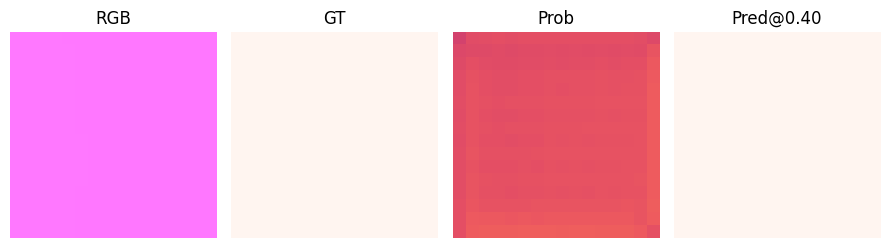

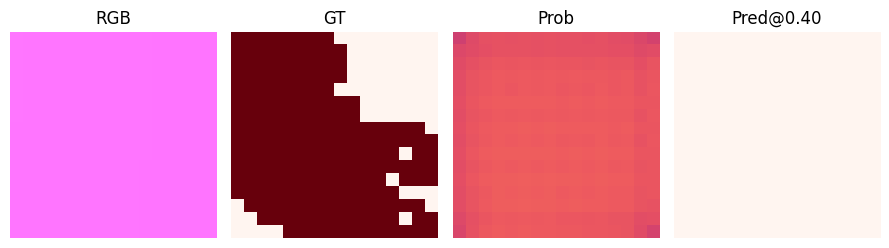

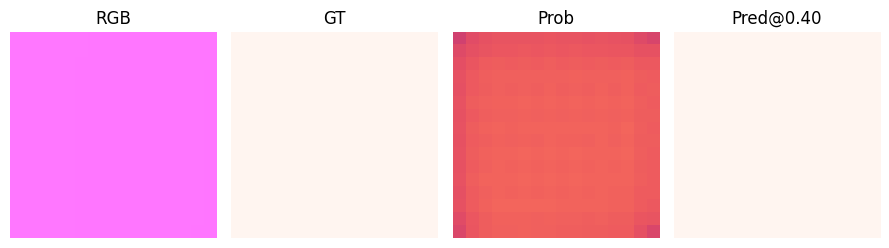

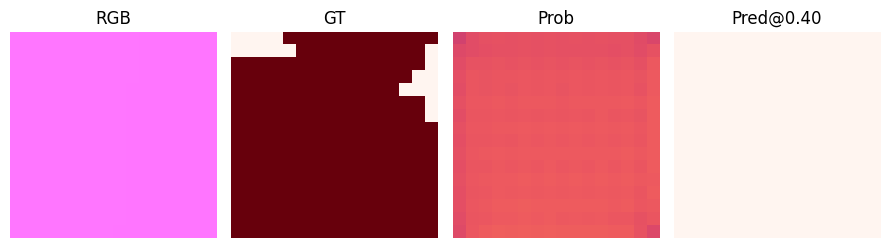

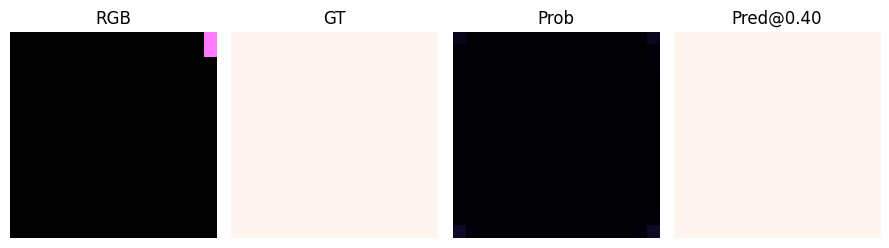

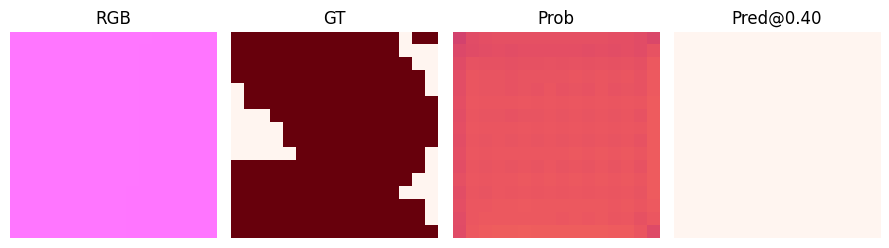


TEST samples:


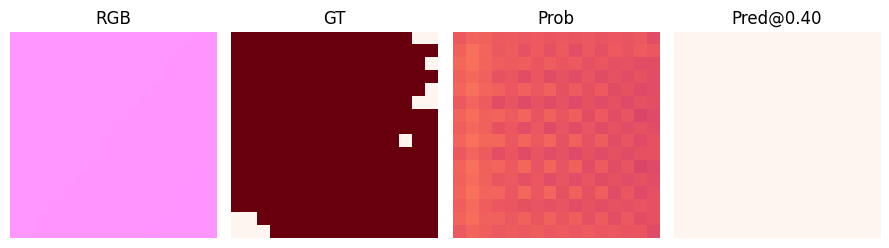

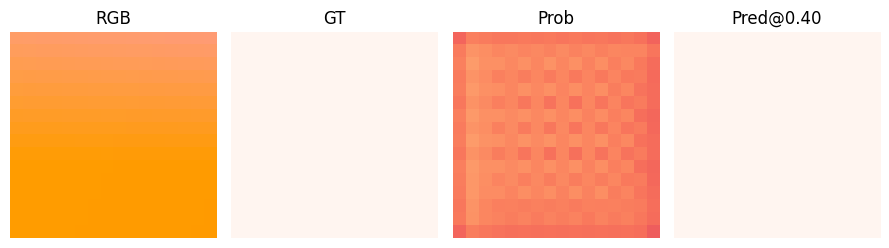

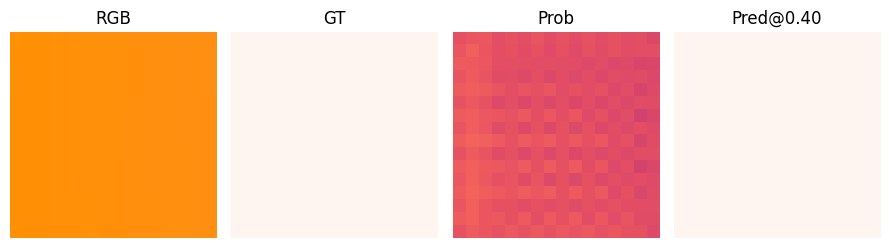

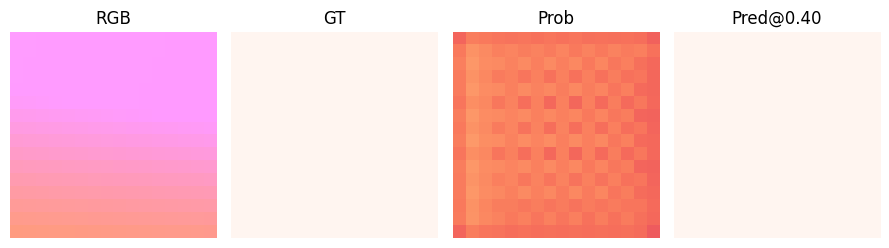

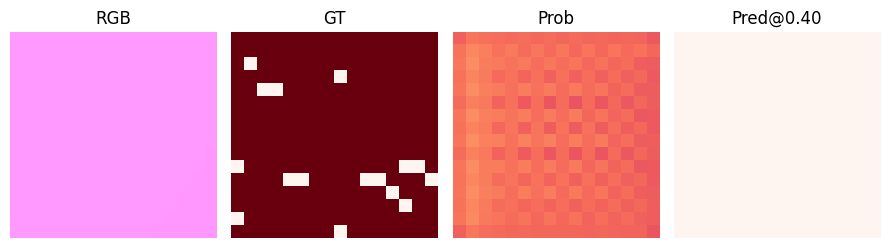

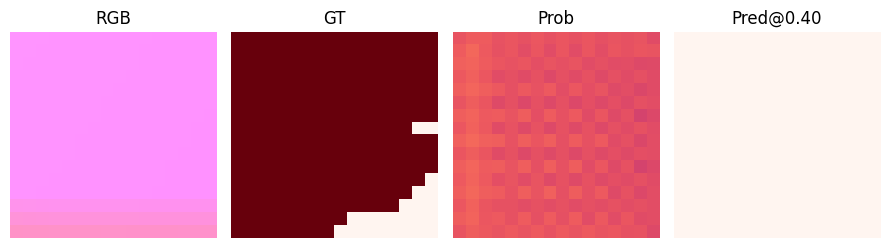

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(loader, nshow=6, threshold=0.5):
    model.eval()
    shown = 0
    for batch in loader:
        x = batch["x"].to(DEVICE)
        y = batch["y"].to(DEVICE)
        with torch.no_grad():
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
        x = x.cpu().numpy(); y = y.cpu().numpy(); preds = preds.cpu().numpy(); probs = probs.cpu().numpy()
        for i in range(min(nshow, x.shape[0])):
            m, s = train_mean, train_std
            rgb = np.stack([
                np.clip((x[i,0]*s[0] + m[0]), 0, 1),
                np.clip((x[i,7]*s[7] + m[7]), 0, 1),
                np.clip((x[i,2]*s[2] + m[2]), 0, 1),
            ], axis=-1)
            fig, axs = plt.subplots(1,4, figsize=(9,3))
            axs[0].imshow(rgb); axs[0].set_title("RGB"); axs[0].axis('off')
            axs[1].imshow(y[i,0], cmap='Reds'); axs[1].set_title("GT"); axs[1].axis('off')
            axs[2].imshow(probs[i,0], vmin=0, vmax=1, cmap='magma'); axs[2].set_title("Prob"); axs[2].axis('off')
            axs[3].imshow(preds[i,0], cmap='Reds'); axs[3].set_title(f"Pred@{threshold:.2f}"); axs[3].axis('off')
            plt.tight_layout(); plt.show()
            shown += 1
        if shown >= nshow: break

print("\nVAL samples:")
show_batch(val_loader, nshow=6, threshold=best_t)
print("\nTEST samples:")
show_batch(test_loader, nshow=6, threshold=best_t)


Copying:
  gs://california-fire-model/burned_events/Carr_2018_07/Burned_Carr_2018_07_2018-07.tif → /content/data/Burned_Carr_2018_07_2018-07.tif 
  gs://california-fire-model/evms_events/Carr_2018_07/EVM_Carr_2018_07_2018-07.tif → /content/data/EVM_Carr_2018_07_2018-07.tif


/tmp/ipython-input-2353408995.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")



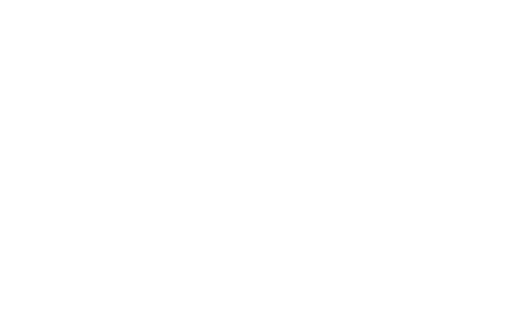

✓ Map saved: /content/model_maps/model_vs_modis_Carr_2018_07_2018-07.html
Copying:
  gs://california-fire-model/burned_events/Nuns_2017_10/Burned_Nuns_2017_10_2017-10.tif → /content/data/Burned_Nuns_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Nuns_2017_10/EVM_Nuns_2017_10_2017-10.tif → /content/data/EVM_Nuns_2017_10_2017-10.tif


/tmp/ipython-input-2353408995.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")



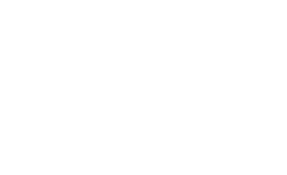

✓ Map saved: /content/model_maps/model_vs_modis_Nuns_2017_10_2017-10.html
Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif


/tmp/ipython-input-2353408995.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")



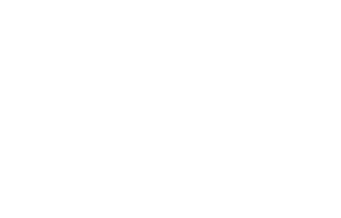

✓ Map saved: /content/model_maps/model_vs_modis_Cedar_2003_10_2003-10.html


In [ ]:
# ==============================
# Event-level prediction maps (TEST events only)
# ==============================
import folium, rasterio, numpy as np, os
from folium.raster_layers import ImageOverlay
from IPython.display import display, HTML

RENDER_SPLIT = "test"   # can set "val" or "train" if you want to explore others
MAP_DIR = "/content/model_maps"
os.makedirs(MAP_DIR, exist_ok=True)

def render_event_map(event_key):
    event_base, year_month = event_key.split("|")
    patch_dir = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    gj_path   = f"{patch_dir}/patch_footprints.geojson"
    if not os.path.exists(gj_path):
        print(f"!! No footprints for {event_key}")
        return None

    # load georeference from EVM tif
    try:
        _, evm_tif = copy_pair(event_base, year_month)
    except Exception as e:
        print(f"!! Could not find EVM pair for {event_key}: {e}")
        return None

    with rasterio.open(evm_tif) as src:
        H, W = src.height, src.width
        bounds = src.bounds
        transform = src.transform

    # predict probabilities over all patches
    prob_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    # loop patches
    for npz in glob.glob(os.path.join(patch_dir, "*.npz")):
        arr = np.load(npz)
        x = arr["x"].astype(np.float32)
        x = np.nan_to_num(x, nan=0.0)
        x = (x - train_mean) / (train_std + 1e-6)
        x = torch.from_numpy(x.transpose(2,0,1)).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x)
            p = torch.sigmoid(logits)[0,0].cpu().numpy()

        # where this patch belongs
        pid = os.path.basename(npz).split(".")[0]
        coords = arr["coords"] if "coords" in arr else None
        if coords is None:
            continue  # your extractor must save coords (row,col)
        row, col = coords
        prob_map[row:row+EXPECTED_HW, col:col+EXPECTED_HW] += p
        count_map[row:row+EXPECTED_HW, col:col+EXPECTED_HW] += 1

    # average overlapping patches
    count_map[count_map == 0] = 1
    prob_map /= count_map

    # normalize for overlay
    rgba = np.zeros((H, W, 4), dtype=np.uint8)
    from matplotlib import cm
    cmap = cm.get_cmap("magma")
    colored = (cmap(prob_map) * 255).astype(np.uint8)
    rgba[:,:,:3] = colored[:,:,:3]
    rgba[:,:,3]  = (prob_map*255).astype(np.uint8)

    # folium map
    m = folium.Map(location=[(bounds.top+bounds.bottom)/2, (bounds.left+bounds.right)/2],
                   zoom_start=9, tiles=None)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Tiles © Esri"
    ).add_to(m)

    ImageOverlay(
        image=rgba,
        bounds=[[bounds.bottom, bounds.left],[bounds.top, bounds.right]],
        opacity=0.6, name="Model Burn Prob"
    ).add_to(m)

    folium.LayerControl().add_to(m)

    out_html = f"{MAP_DIR}/model_vs_modis_{event_base}_{year_month}.html"
    m.save(out_html)
    display(HTML(f"<h4>{event_key}</h4>"))
    display(m)
    print("✓ Map saved:", out_html)
    return out_html

# Run for test events only
for ev in events_test:
    render_event_map(ev)



=== Carr_2018_07|2018-07 ===
Copying:
  gs://california-fire-model/burned_events/Carr_2018_07/Burned_Carr_2018_07_2018-07.tif → /content/data/Burned_Carr_2018_07_2018-07.tif 
  gs://california-fire-model/evms_events/Carr_2018_07/EVM_Carr_2018_07_2018-07.tif → /content/data/EVM_Carr_2018_07_2018-07.tif
Copying:
  gs://california-fire-model/burned_events/Carr_2018_07/Burned_Carr_2018_07_2018-07.tif → /content/data/Burned_Carr_2018_07_2018-07.tif 
  gs://california-fire-model/evms_events/Carr_2018_07/EVM_Carr_2018_07_2018-07.tif → /content/data/EVM_Carr_2018_07_2018-07.tif
Pixels evaluated: 4,096
TP=1,437  FP=2,659  FN=0  TN=0
IoU=0.3508  F1=0.5194  P=0.3508  R=1.0000
TP crops:


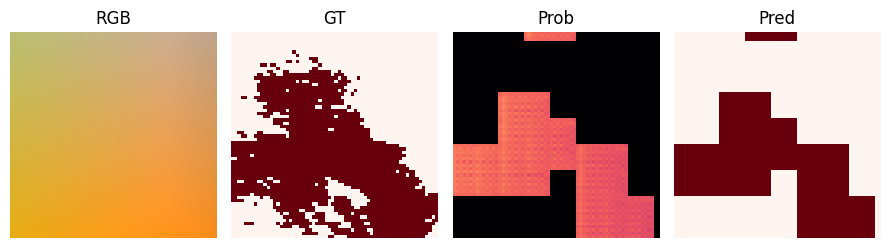

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/TP_00.png


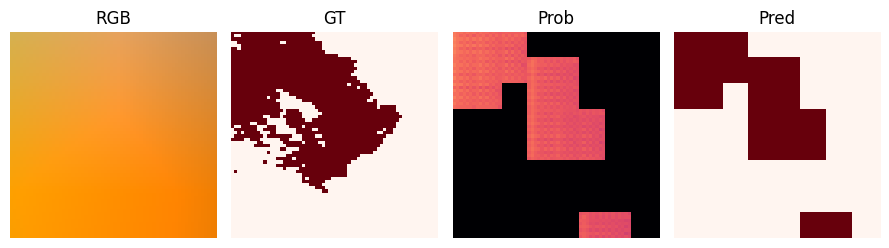

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/TP_01.png


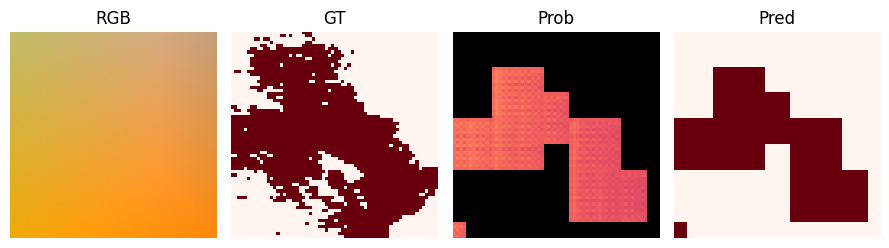

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/TP_02.png


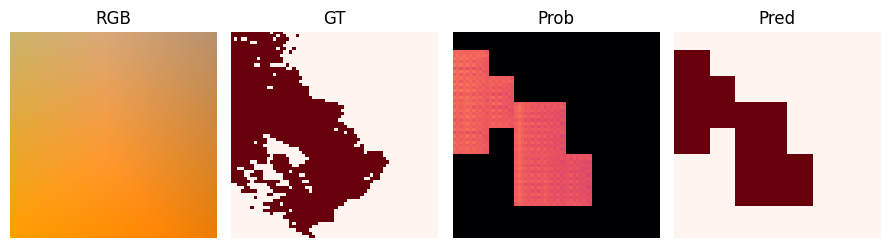

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/TP_03.png
FP crops:


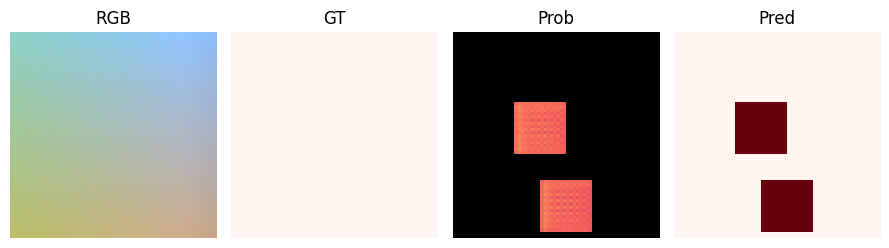

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/FP_00.png


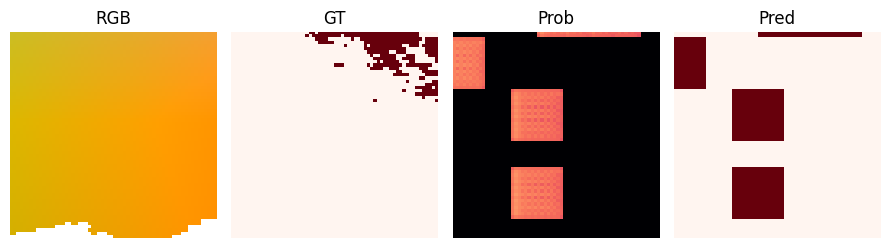

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/FP_01.png


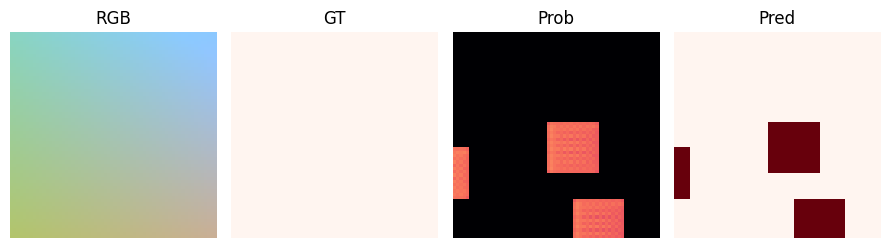

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/FP_02.png


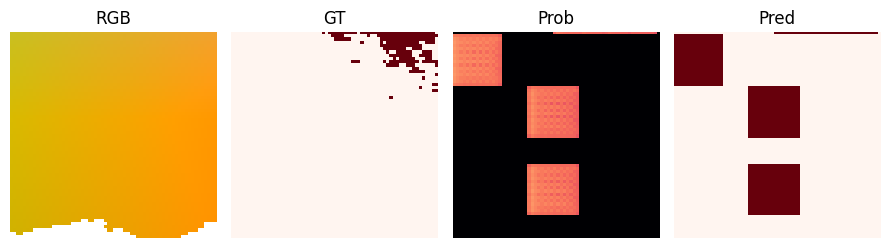

  saved: /content/unet_runs/eval_crops/Carr_2018_07_2018-07/FP_03.png

=== Nuns_2017_10|2017-10 ===
Copying:
  gs://california-fire-model/burned_events/Nuns_2017_10/Burned_Nuns_2017_10_2017-10.tif → /content/data/Burned_Nuns_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Nuns_2017_10/EVM_Nuns_2017_10_2017-10.tif → /content/data/EVM_Nuns_2017_10_2017-10.tif
Copying:
  gs://california-fire-model/burned_events/Nuns_2017_10/Burned_Nuns_2017_10_2017-10.tif → /content/data/Burned_Nuns_2017_10_2017-10.tif 
  gs://california-fire-model/evms_events/Nuns_2017_10/EVM_Nuns_2017_10_2017-10.tif → /content/data/EVM_Nuns_2017_10_2017-10.tif
Pixels evaluated: 896
TP=277  FP=397  FN=0  TN=222
IoU=0.4110  F1=0.5825  P=0.4110  R=1.0000
TP crops:


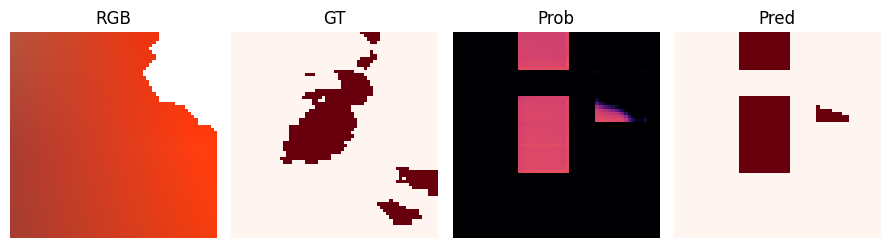

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/TP_00.png


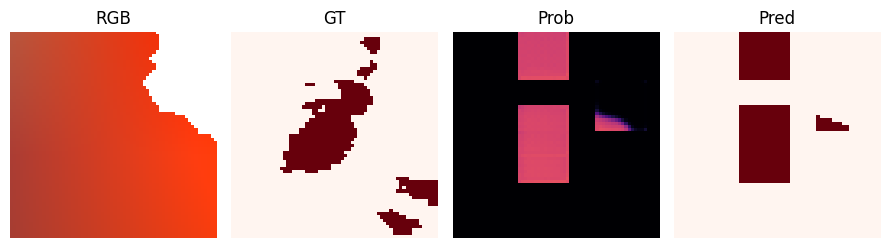

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/TP_01.png


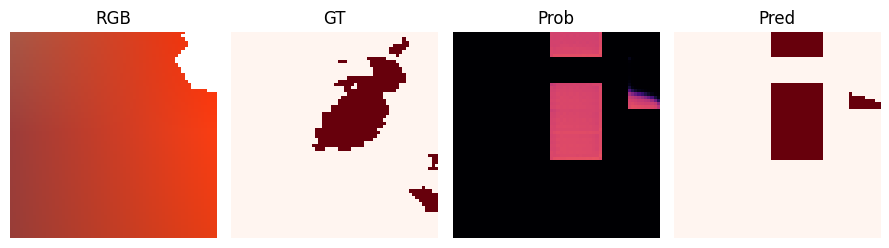

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/TP_02.png


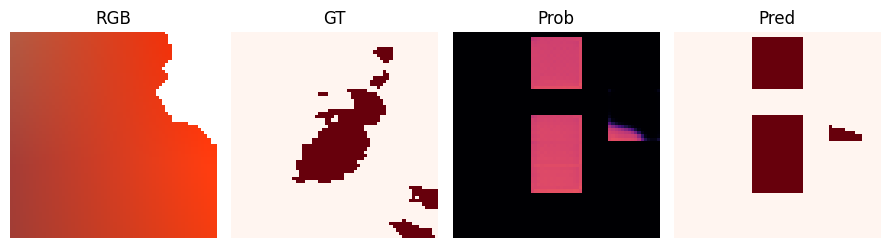

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/TP_03.png
FP crops:


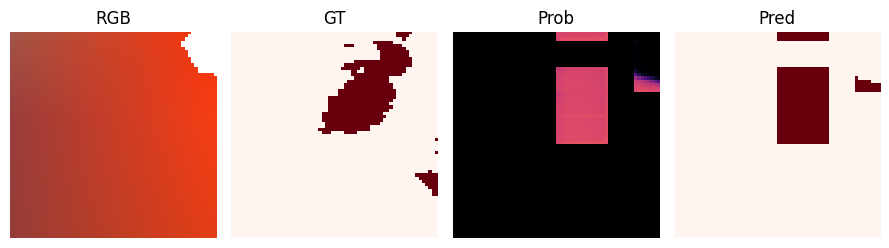

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/FP_00.png


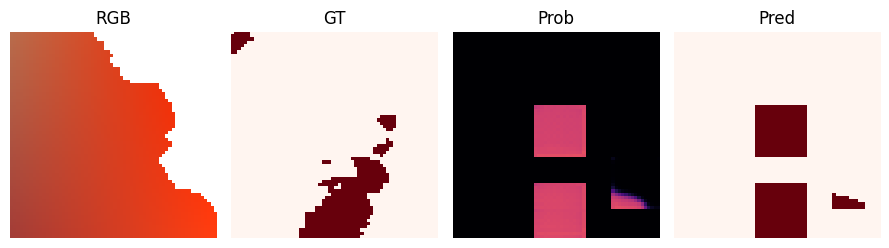

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/FP_01.png


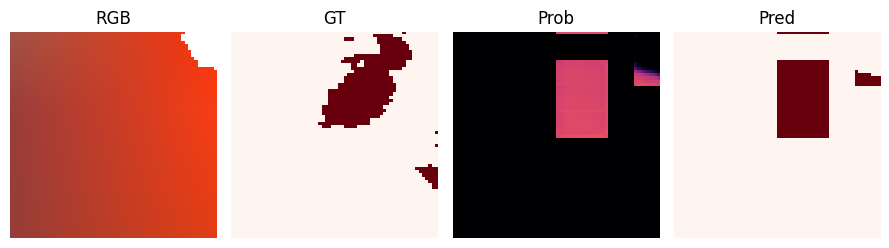

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/FP_02.png


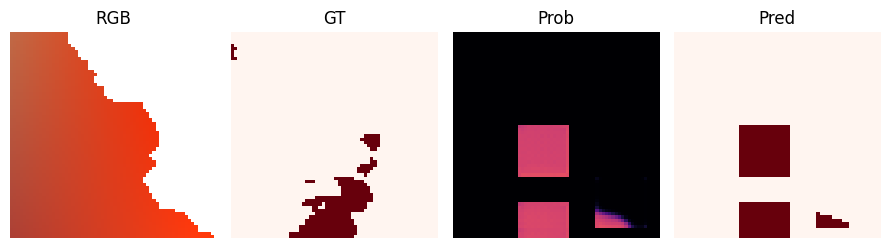

  saved: /content/unet_runs/eval_crops/Nuns_2017_10_2017-10/FP_03.png

=== Cedar_2003_10|2003-10 ===
Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif
Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif
Pixels evaluated: 13,056
TP=2,958  FP=3,620  FN=1,090  TN=5,388
IoU=0.3858  F1=0.5567  P=0.4497  R=0.7307
TP crops:


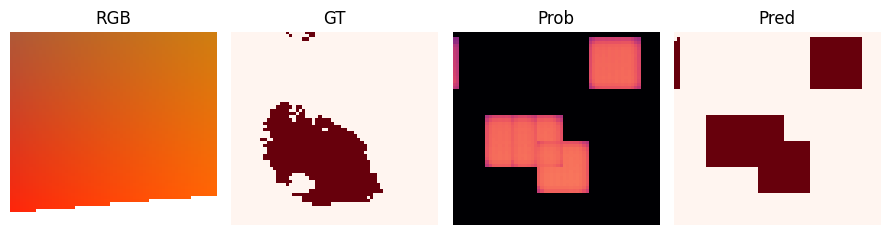

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/TP_00.png


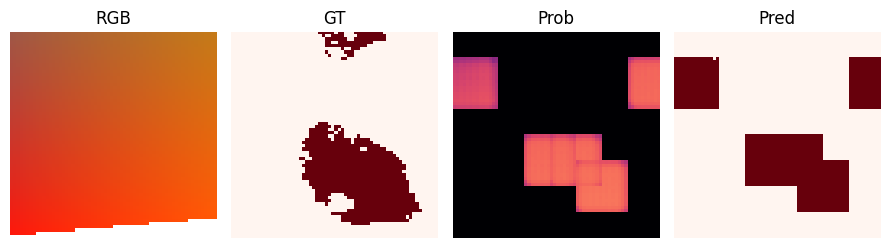

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/TP_01.png


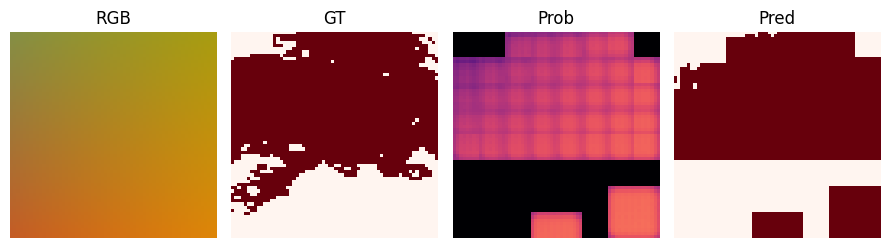

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/TP_02.png


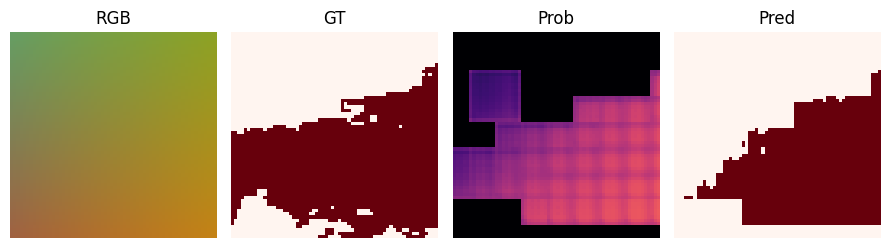

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/TP_03.png
FP crops:


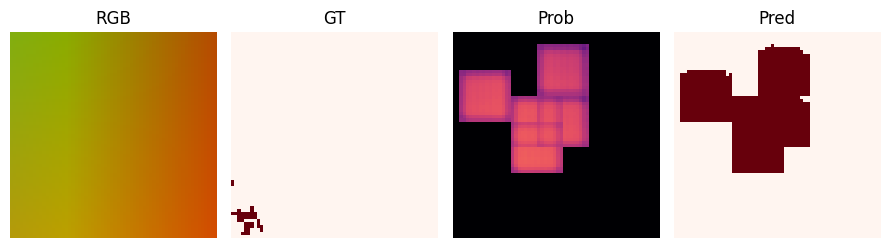

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FP_00.png


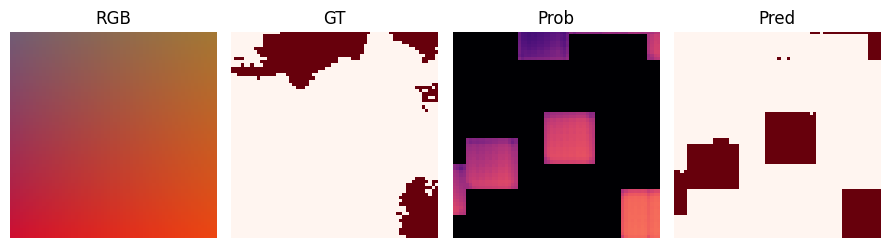

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FP_01.png


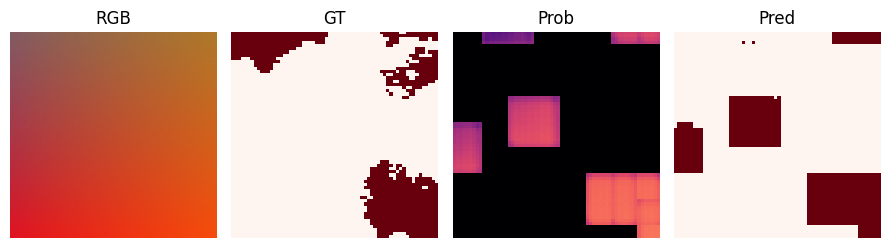

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FP_02.png


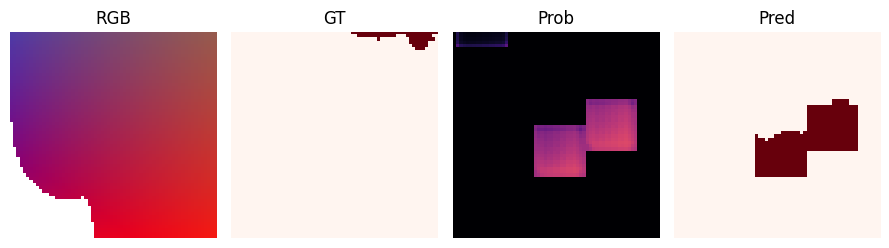

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FP_03.png
FN crops:


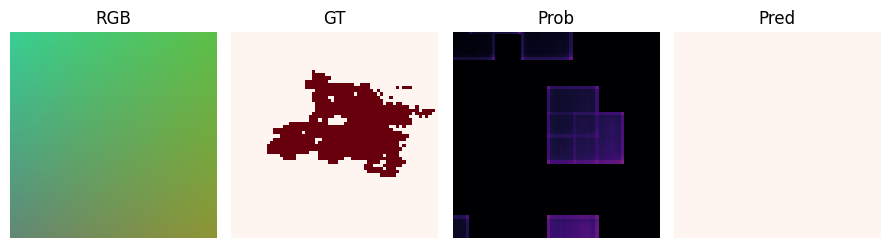

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FN_00.png


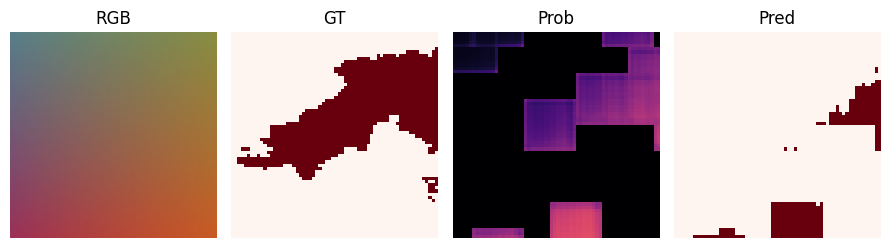

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FN_01.png


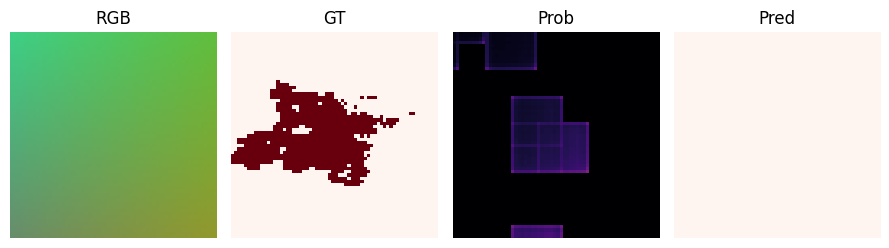

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FN_02.png


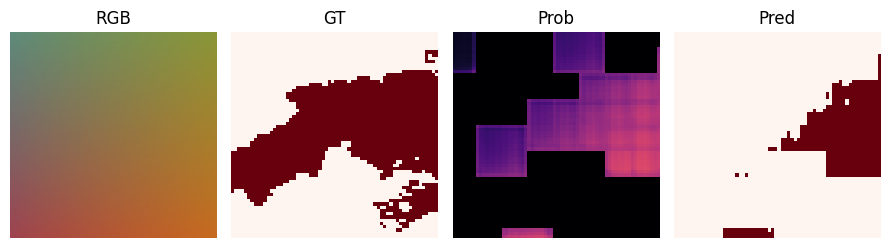

  saved: /content/unet_runs/eval_crops/Cedar_2003_10_2003-10/FN_03.png

=== Summary over TEST events ===
Carr_2018_07|2018-07: IoU=0.3508  F1=0.5194  P=0.3508  R=1.0000  pixels=4,096
Nuns_2017_10|2017-10: IoU=0.4110  F1=0.5825  P=0.4110  R=1.0000  pixels=896
Cedar_2003_10|2003-10: IoU=0.3858  F1=0.5567  P=0.4497  R=0.7307  pixels=13,056


In [ ]:
# ============================================
# Pixel-wise evaluation on UNSEEN TEST events
# (no gigantic maps; prints metrics and small crops)
# ============================================
import os, csv, glob, json, math, random, numpy as np
import torch, rasterio
import matplotlib.pyplot as plt
from pathlib import Path

# --- knobs ---
EXPECTED_HW = 16     # patch size you used in extraction
TOP_N_CROPS = 4      # how many TP/FP/FN crops to show per event
CROP_HW     = 64     # crop window in pixels for visualization (H=W=CROP_HW)

SAVE_DIR = Path("/content/unet_runs/eval_crops")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# quick RGB from full EVM (for crops)
def p_stretch(a, p1=2, p2=98):
    a = a.astype(np.float32)
    lo, hi = np.nanpercentile(a, [p1, p2])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        mn, mx = np.nanmin(a), np.nanmax(a)
        return np.clip((a - mn)/(mx - mn + 1e-6), 0, 1)
    return np.clip((a - lo)/(hi - lo), 0, 1)

def rgb_from_evm_cube(x9_full):
    # x9_full: (9, H, W)
    R = p_stretch(x9_full[0])
    G = p_stretch(x9_full[7])
    B = p_stretch(x9_full[2])
    return np.stack([R, G, B], axis=-1)

@torch.no_grad()
def predict_event_prob_map(event_key, model, best_t, device="cpu"):
    """Reconstruct full-scene probability map by running model on all patches
       using their (y0,x0) from manifest.csv and averaging overlaps."""
    event_base, year_month = event_key.split("|")
    patch_dir = f"{PATCH_ROOT}/patches_{event_base}_{year_month}"
    man_csv   = Path(patch_dir)/"manifest.csv"
    assert man_csv.exists(), f"Missing manifest: {man_csv}"

    # read EVM shape from evm_tif
    _, evm_tif = copy_pair(event_base, year_month)
    with rasterio.open(evm_tif) as eds:
        H, W = eds.height, eds.width

    prob_sum  = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    # iterate manifest rows
    with open(man_csv) as f:
        r = csv.DictReader(f)
        for row in r:
            base = row["id"]           # e.g., pos_00012
            y0   = int(row["y0"]); x0  = int(row["x0"])
            npz_path = Path(patch_dir)/f"{base}.npz"
            if not npz_path.exists():
                continue
            arr = np.load(npz_path)
            x = arr["x"].astype(np.float32)          # (H,W,9)
            x = np.nan_to_num(x, nan=0.0)
            # normalize with train stats
            x = (x - train_mean) / (train_std + 1e-6)
            xt = torch.from_numpy(x.transpose(2,0,1)).unsqueeze(0).to(device)

            logits = model(xt)
            p = torch.sigmoid(logits)[0,0].cpu().numpy()  # (16,16)

            prob_sum[y0:y0+EXPECTED_HW, x0:x0+EXPECTED_HW]  += p
            count_map[y0:y0+EXPECTED_HW, x0:x0+EXPECTED_HW] += 1.0

    # average overlaps; keep only pixels we covered with patches
    covered = count_map > 0
    count_map[~covered] = 1.0
    prob_map = prob_sum / count_map
    return prob_map, covered

def event_gt_burn_mask(event_key):
    event_base, year_month = event_key.split("|")
    burn_tif, evm_tif = copy_pair(event_base, year_month)
    burn = reproject_to_match(burn_tif, evm_tif)       # (H,W) on EVM grid
    gt = (burn > 0).astype(np.uint8)
    # we’ll also fetch EVM to build RGB once per event
    with rasterio.open(evm_tif) as eds:
        x9 = eds.read(out_dtype="float32")             # (9,H,W)
    return gt, x9, evm_tif

def confusion_counts(pred, gt, valid):
    # valid = covered (and optionally land) mask
    P = (pred > 0).astype(np.uint8)
    G = (gt   > 0).astype(np.uint8)
    V = valid.astype(np.uint8)

    TP = np.sum((P==1) & (G==1) & (V==1))
    TN = np.sum((P==0) & (G==0) & (V==1))
    FP = np.sum((P==1) & (G==0) & (V==1))
    FN = np.sum((P==0) & (G==1) & (V==1))

    eps = 1e-6
    prec = TP / max(TP+FP, eps)
    rec  = TP / max(TP+FN, eps)
    f1   = 2*prec*rec / max(prec+rec, eps)
    iou  = TP / max(TP+FP+FN, eps)
    return dict(TP=TP, TN=TN, FP=FP, FN=FN, precision=prec, recall=rec, f1=f1, iou=iou)

def pick_points(mask, k=TOP_N_CROPS, rng=None):
    ys, xs = np.where(mask)
    if len(ys) == 0: return []
    idx = np.arange(len(ys))
    if rng is None: rng = np.random.default_rng(1337)
    rng.shuffle(idx)
    idx = idx[:min(k, len(idx))]
    return list(zip(ys[idx], xs[idx]))

def show_crop(rgb, prob, pred, gt, cy, cx, size=CROP_HW):
    h, w = prob.shape
    r0 = max(0, cy - size//2); r1 = min(h, r0 + size)
    c0 = max(0, cx - size//2); c1 = min(w, c0 + size)

    fig, axs = plt.subplots(1,4, figsize=(9,3))
    axs[0].imshow(rgb[r0:r1, c0:c1]); axs[0].set_title("RGB"); axs[0].axis('off')
    axs[1].imshow(gt[r0:r1, c0:c1], cmap='Reds'); axs[1].set_title("GT"); axs[1].axis('off')
    axs[2].imshow(prob[r0:r1, c0:c1], vmin=0, vmax=1, cmap='magma'); axs[2].set_title("Prob"); axs[2].axis('off')
    axs[3].imshow(pred[r0:r1, c0:c1], cmap='Reds'); axs[3].set_title("Pred"); axs[3].axis('off')
    plt.tight_layout(); plt.show()

def evaluate_test_events(events_test, model, best_t, device=DEVICE):
    model.eval()
    rng = np.random.default_rng(2025)
    summary = []
    for ev in events_test:
        print(f"\n=== {ev} ===")
        prob_map, covered = predict_event_prob_map(ev, model, best_t, device=device)
        gt_mask, x9_full, evm_tif = event_gt_burn_mask(ev)

        # optional: constrain evaluation to covered pixels only
        valid = covered.astype(np.uint8)

        pred_bin = (prob_map >= best_t).astype(np.uint8)
        stats = confusion_counts(pred_bin, gt_mask, valid)
        total_valid = int(valid.sum())

        print(f"Pixels evaluated: {total_valid:,}")
        print(f"TP={stats['TP']:,}  FP={stats['FP']:,}  FN={stats['FN']:,}  TN={stats['TN']:,}")
        print(f"IoU={stats['iou']:.4f}  F1={stats['f1']:.4f}  P={stats['precision']:.4f}  R={stats['recall']:.4f}")

        # make a few small crops for TP / FP / FN
        rgb = rgb_from_evm_cube(x9_full)
        tp_pts = pick_points((pred_bin==1)&(gt_mask==1)&(valid==1), k=TOP_N_CROPS, rng=rng)
        fp_pts = pick_points((pred_bin==1)&(gt_mask==0)&(valid==1), k=TOP_N_CROPS, rng=rng)
        fn_pts = pick_points((pred_bin==0)&(gt_mask==1)&(valid==1), k=TOP_N_CROPS, rng=rng)

        out_ev = SAVE_DIR/ev.replace("|","_")
        out_ev.mkdir(parents=True, exist_ok=True)

        def save_and_show(tag, pts):
            for i,(yy,xx) in enumerate(pts):
                # show inline
                show_crop(rgb, prob_map, pred_bin, gt_mask, yy, xx, size=CROP_HW)
                # also save a figure
                h, w = prob_map.shape
                r0 = max(0, yy - CROP_HW//2); r1 = min(h, r0 + CROP_HW)
                c0 = max(0, xx - CROP_HW//2); c1 = min(w, c0 + CROP_HW)
                fig, axs = plt.subplots(1,4, figsize=(9,3))
                axs[0].imshow(rgb[r0:r1, c0:c1]); axs[0].set_title("RGB"); axs[0].axis('off')
                axs[1].imshow(gt_mask[r0:r1, c0:c1], cmap='Reds'); axs[1].set_title("GT"); axs[1].axis('off')
                axs[2].imshow(prob_map[r0:r1, c0:c1], vmin=0, vmax=1, cmap='magma'); axs[2].set_title("Prob"); axs[2].axis('off')
                axs[3].imshow(pred_bin[r0:r1, c0:c1], cmap='Reds'); axs[3].set_title(f"Pred@{best_t:.2f}"); axs[3].axis('off')
                plt.tight_layout()
                fpath = out_ev/f"{tag}_{i:02d}.png"
                plt.savefig(fpath, dpi=160); plt.close()
                print("  saved:", fpath)

        if tp_pts:
            print("TP crops:")
            save_and_show("TP", tp_pts)
        if fp_pts:
            print("FP crops:")
            save_and_show("FP", fp_pts)
        if fn_pts:
            print("FN crops:")
            save_and_show("FN", fn_pts)

        summary.append({"event": ev, **stats, "pixels": total_valid})

    # small summary table
    if summary:
        print("\n=== Summary over TEST events ===")
        for s in summary:
            print(f"{s['event']}: IoU={s['iou']:.4f}  F1={s['f1']:.4f}  "
                  f"P={s['precision']:.4f}  R={s['recall']:.4f}  "
                  f"pixels={s['pixels']:,}")

# ---- run on your unseen TEST events ----
evaluate_test_events(events_test, model, best_t, device=DEVICE)


Copying:
  gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif → /content/data/Burned_Cedar_2003_10_2003-10.tif 
  gs://california-fire-model/evms_events/Cedar_2003_10/EVM_Cedar_2003_10_2003-10.tif → /content/data/EVM_Cedar_2003_10_2003-10.tif
EVM: /content/data/EVM_Cedar_2003_10_2003-10.tif
MODIS: /content/data/Burned_Cedar_2003_10_2003-10.tif

=== Cedar_2003_10|2003-10 ===
tile shape: (218, 341, 9)  pixels: 74,338
TP=3824  FP=25164  FN=2026  TN=43324
IoU=0.1233  F1=0.2195  P=0.1319  R=0.6537  @thr=0.40


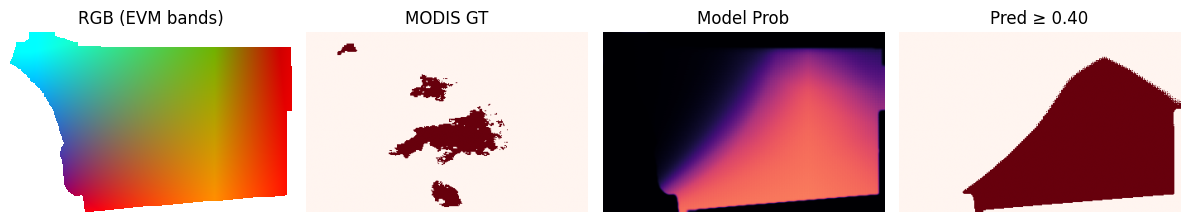


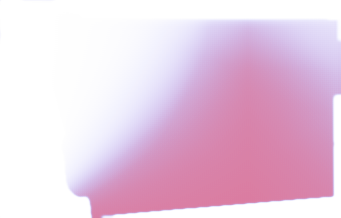
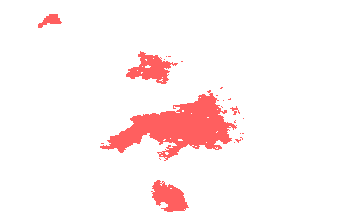

In [ ]:
# ==== Full-tile inference + side-by-side visuals (run me) ====
import os, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn.functional as F
import rasterio
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display, HTML
from torch.serialization import add_safe_globals

# ---- choose a test event-month (unseen) ----
TARGET_EVENT = "Cedar_2003_10"   # e.g. "Atlas_2017_10"
TARGET_YM    = "2003-10"         # e.g. "2017-10"
THRESH       = float(globals().get("best_t", 0.40))  # use your tuned threshold if defined

# ---- tiny helpers ----
def pad_to_mult4(t):
    _, _, h, w = t.shape
    ph = (4 - (h % 4)) % 4
    pw = (4 - (w % 4)) % 4
    t2 = F.pad(t, (0, pw, 0, ph), mode='reflect')
    return t2, ph, pw

def p_stretch(a, p1=2, p2=98):
    a = a.astype(np.float32)
    lo, hi = np.nanpercentile(a, [p1, p2])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        mn, mx = np.nanmin(a), np.nanmax(a)
        return np.clip((a - mn)/(mx - mn + 1e-6), 0, 1)
    return np.clip((a - lo)/(hi - lo), 0, 1)

def rgb_preview(x9):
    # x9 is raw (H,W,9) before normalization
    return np.stack([p_stretch(x9[...,0]), p_stretch(x9[...,7]), p_stretch(x9[...,2])], axis=-1)

# ---- 1) get paths (uses your earlier helper) ----
burn_tif, evm_tif = copy_pair(TARGET_EVENT, TARGET_YM)
print("EVM:", evm_tif)
print("MODIS:", burn_tif)

# ---- 2) load raw EVM and MODIS-on-EVM grid ----
with rasterio.open(evm_tif) as src:
    evm_raw = src.read().transpose(1,2,0)     # (H,W,9)
    bounds = src.bounds
H, W, C = evm_raw.shape
burn_aligned = reproject_to_match(burn_tif, evm_tif)  # (H,W) float32
gt = (burn_aligned > 0).astype(np.float32)            # 1=burned, 0=not

# ---- 3) load model + normalization stats ----
# try safe weights first
safe_weights = os.path.join("/content/unet_runs", "unet_best_weights.pt")
if os.path.exists(safe_weights):
    state = torch.load(safe_weights, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state)
    stats_fp = os.path.join("/content/unet_runs", "norm_stats.npz")
    if os.path.exists(stats_fp):
        stats = np.load(stats_fp)
        train_mean = stats["mean"].astype(np.float32)
        train_std  = stats["std"].astype(np.float32)
else:
    # fall back to mixed-object checkpoint (allowlist numpy reconstruct), if present
    best_path = os.path.join("/content/unet_runs","unet_best.pt")
    if os.path.exists(best_path):
        add_safe_globals([np._core.multiarray._reconstruct])  # trust your own ckpt
        ckpt = torch.load(best_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(ckpt["state_dict"])
        train_mean = ckpt["mean"].astype(np.float32)
        train_std  = ckpt["std"].astype(np.float32)

mean = train_mean; std = train_std

# ---- 4) predict full tile (pad → run → crop) ----
x_np = (np.nan_to_num(evm_raw) - mean) / (std + 1e-6)
x    = torch.from_numpy(x_np.transpose(2,0,1)).unsqueeze(0).float().to(DEVICE)  # (1,9,H,W)
x_pad, ph, pw = pad_to_mult4(x)
model.eval()
with torch.no_grad():
    logits_pad = model(x_pad)
    probs_pad = torch.sigmoid(logits_pad)
probs = probs_pad[:, :, :H, :W] if (ph or pw) else probs_pad
probs = probs[0,0].detach().cpu().numpy()   # (H,W) 0..1
pred  = (probs >= THRESH).astype(np.float32)

# ---- 5) metrics on all pixels ----
TP = float(((pred==1) & (gt==1)).sum())
FP = float(((pred==1) & (gt==0)).sum())
FN = float(((pred==0) & (gt==1)).sum())
TN = float(((pred==0) & (gt==0)).sum())
eps = 1e-6
IoU = TP / (TP + FP + FN + eps)
P   = TP / (TP + FP + eps)
R   = TP / (TP + FN + eps)
F1  = 2*P*R / (P+R+eps)

print(f"\n=== {TARGET_EVENT}|{TARGET_YM} ===")
print(f"tile shape: {evm_raw.shape}  pixels: {H*W:,}")
print(f"TP={TP:.0f}  FP={FP:.0f}  FN={FN:.0f}  TN={TN:.0f}")
print(f"IoU={IoU:.4f}  F1={F1:.4f}  P={P:.4f}  R={R:.4f}  @thr={THRESH:.2f}")

# ---- 6) quick inline panels (RGB, GT, Prob, Pred) ----
fig, axs = plt.subplots(1,4, figsize=(12,3.2))
axs[0].imshow(rgb_preview(evm_raw)); axs[0].set_title("RGB (EVM bands)"); axs[0].axis('off')
axs[1].imshow(gt, cmap='Reds'); axs[1].set_title("MODIS GT"); axs[1].axis('off')
axs[2].imshow(probs, vmin=0, vmax=1, cmap='magma'); axs[2].set_title("Model Prob"); axs[2].axis('off')
axs[3].imshow(pred, cmap='Reds'); axs[3].set_title(f"Pred ≥ {THRESH:.2f}"); axs[3].axis('off')
plt.tight_layout(); plt.show()

# ---- 7) Folium overlay (satellite basemap + both layers) ----
def array_to_rgba(img, vmax=1.0):
    """map 0..1 to 8-bit grayscale RGBA (alpha from value)."""
    g = np.clip(img / vmax, 0, 1)
    g8 = (g*255).astype(np.uint8)
    rgba = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    rgba[...,0] = g8; rgba[...,1] = 0; rgba[...,2] = 255 - g8  # purple-ish
    rgba[...,3] = (g*180).astype(np.uint8)
    return rgba

prob_rgba  = array_to_rgba(probs, vmax=1.0)
gt_rgba    = np.zeros((*gt.shape,4), dtype=np.uint8)
gt_rgba[...,0] = 255; gt_rgba[...,3] = (gt*160).astype(np.uint8)

center_lat = (bounds.top + bounds.bottom)/2
center_lon = (bounds.left + bounds.right)/2

m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles=None)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles © Esri — Source: Esri, Maxar, Earthstar Geographics, GIS User Community",
    name="Esri World Imagery",
).add_to(m)
folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)

ImageOverlay(image=prob_rgba,
             bounds=[[bounds.bottom, bounds.left],[bounds.top, bounds.right]],
             name="Model probability", opacity=1.0, zindex=500).add_to(m)
ImageOverlay(image=gt_rgba,
             bounds=[[bounds.bottom, bounds.left],[bounds.top, bounds.right]],
             name="MODIS burned (GT)", opacity=1.0, zindex=600).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

display(HTML(f"<h4 style='font-family:system-ui'>{TARGET_EVENT} — {TARGET_YM} (IoU={IoU:.3f}, F1={F1:.3f}, thr={THRESH:.2f})</h4>"))
display(m)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p "/content/drive/MyDrive/fire_patches_extracted"


In [ ]:
!cp -r /content/patches_*_* "/content/drive/MyDrive/fire_patches_extracted/"


In [ ]:
!zip -r /content/patches_all.zip /content/patches_*_*
!mv /content/patches_all.zip "/content/drive/MyDrive/fire_patches_extracted/"


Streaming output truncated to the last 5000 lines.
  adding: content/patches_Camp_2018_11_2018-11/neg_00009.npz (deflated 2%)
  adding: content/patches_Camp_2018_11_2018-11/neg_00033.npz (deflated 0%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00027_burn.png (deflated 2%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00004_burn.png (deflated 8%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00049_burn.png (deflated 4%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00045_burn.png (deflated 6%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00001_burn.png (deflated 7%)
  adding: content/patches_Camp_2018_11_2018-11/neg_00046.npz (deflated 0%)
  adding: content/patches_Camp_2018_11_2018-11/pos_00018_rgb.png (deflated 2%)
  adding: content/patches_Camp_2018_11_2018-11/neg_00021.npz (deflated 1%)
  adding: content/patches_Camp_2018_11_2018-11/neg_00003.npz (deflated 1%)
  adding: content/patches_Camp_2018_11_2018-11/neg_00038.npz (deflated 1%)
  adding: content/pa

In [ ]:
import pathlib, csv, pandas as pd

rows=[]
for p in sorted(pathlib.Path("/content").glob("patches_*_*")):
    mf = p/"manifest.csv"
    if not mf.exists():
        continue
    pos=neg=0
    with mf.open() as f:
        next(f, None)  # skip header
        for ln in f:
            _, kind, *_ = ln.strip().split(",")
            if kind=="pos": pos+=1
            elif kind=="neg": neg+=1
    rows.append({"event_month": p.name.replace("patches_",""),
                 "pos":pos, "neg":neg, "total":pos+neg})

df = pd.DataFrame(rows).sort_values("event_month")
print(df.to_string(index=False))
print("\nTOTAL patches:", df["total"].sum())


             event_month  pos  neg  total
   Atlas_2017_10_2017-10    5    5     10
    Camp_2018_11_2018-11   24   18     42
    Camp_2018_11_2018-12   14   14     28
    Carr_2018_07_2018-07   19   11     30
    Carr_2018_07_2018-08   19   19     38
   Cedar_2003_10_2003-10   52   39     91
   Cedar_2003_10_2003-11    1    1      2
FallFire_2007_10_2007-10   66   66    132
FallFire_2007_10_2007-11   12   12     24
  LaBrea_2009_08_2009-08   19   14     33
  LaBrea_2009_08_2009-09    6    6     12
 MendoCx_2018_08_2018-08   75   26    101
 MendoCx_2018_08_2018-09   20   20     40
    Nuns_2017_10_2017-10    2    2      4
 Station_2009_08_2009-08   12   12     24
 Station_2009_08_2009-09    2    2      4
  Thomas_2017_12_2017-12   57   17     74
   Tubbs_2017_10_2017-10    7    7     14

TOTAL patches: 703


In [ ]:
import pathlib, csv, re

ROOT = pathlib.Path("/content")
rows = []
for d in sorted(ROOT.glob("patches_*_*")):
    event, ym = re.match(r"patches_(.+)_(\d{4}-\d{2})", d.name).groups()
    pos = len(list(d.glob("pos_*.npz")))
    neg = len(list(d.glob("neg_*.npz")))
    rows.append([event, ym, pos, neg, str(d)])

print("Event-month summary:")
for r in rows:
    print(f"{r[0]} {r[1]} → pos={r[2]} neg={r[3]} dir={r[4]}")

with open("/content/patches_summary.csv", "w", newline="") as f:
    w = csv.writer(f); w.writerow(["event","year_month","pos","neg","dir"]); w.writerows(rows)

print("\nSaved: /content/patches_summary.csv")


Event-month summary:
Atlas_2017_10 2017-10 → pos=29 neg=26 dir=/content/patches_Atlas_2017_10_2017-10
Camp_2018_11 2018-11 → pos=50 neg=50 dir=/content/patches_Camp_2018_11_2018-11
Camp_2018_11 2018-12 → pos=14 neg=14 dir=/content/patches_Camp_2018_11_2018-12
Carr_2018_07 2018-07 → pos=34 neg=34 dir=/content/patches_Carr_2018_07_2018-07
Carr_2018_07 2018-08 → pos=68 neg=67 dir=/content/patches_Carr_2018_07_2018-08
Cedar_2003_10 2003-10 → pos=80 neg=80 dir=/content/patches_Cedar_2003_10_2003-10
Cedar_2003_10 2003-11 → pos=77 neg=77 dir=/content/patches_Cedar_2003_10_2003-11
FallFire_2007_10 2007-10 → pos=170 neg=169 dir=/content/patches_FallFire_2007_10_2007-10
FallFire_2007_10 2007-11 → pos=12 neg=12 dir=/content/patches_FallFire_2007_10_2007-11
LaBrea_2009_08 2009-08 → pos=23 neg=23 dir=/content/patches_LaBrea_2009_08_2009-08
LaBrea_2009_08 2009-09 → pos=6 neg=6 dir=/content/patches_LaBrea_2009_08_2009-09
MendoCx_2018_08 2018-08 → pos=82 neg=80 dir=/content/patches_MendoCx_2018_08_201

2) sanity-check a few random patches (RGB + mask overlay)

In [ ]:
# 1) Log this Colab runtime into Google Cloud (for gsutil & gcloud)
from google.colab import auth
auth.authenticate_user()

# 2) Set your project (replace if needed)
!gcloud config set project california-fire-model

# 3) Quick sanity check: can we list the folder?
!gsutil ls gs://california-fire-model/evms/Oct_2003/
!gsutil ls gs://california-fire-model/burned_area/Oct_2003/


Updated property [core/project].
gs://california-fire-model/evms/Oct_2003/EVM_Oct_2003.tif
gs://california-fire-model/burned_area/Oct_2003/Burned_Area_Oct_2003.tif


In [ ]:
!gs://california-fire-model/evms/Oct_2003/EVM_Oct_2003.tif
!gs://california-fire-model/burned_area/Oct_2003/Burned_Area_Oct_2003.tif


/bin/bash: line 1: gs://california-fire-model/evms/Oct_2003/EVM_Oct_2003.tif: No such file or directory
/bin/bash: line 1: gs://california-fire-model/burned_area/Oct_2003/Burned_Area_Oct_2003.tif: No such file or directory


In [ ]:
# =========================
# Install & Initialize
# =========================
!pip -q install earthengine-api geemap requests

import ee, geemap, requests, pathlib, time
ee.Authenticate()                     # follow link → paste code
ee.Initialize(project='california-fire-model')

# =========================
# Events (name, [counties], (year, month))
# =========================
events = [
    ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
]

INCLUDE_NEXT_MONTH = True   # set False if you don't want the extra month

# =========================
# AOI helpers (counties via TIGER in Earth Engine)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', STATE_CA))

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    return ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')   # exclusive end
    return start, end

# =========================
# Burned image builder (FIXED DTYPES)
# =========================
def burned_image_u16(start, end, region):
    """Return 2-band image with consistent UInt16 dtypes:
       - BurnDate (UInt16): 0 = not burned in month, >0 = DOY
       - BurnMask (UInt16): 0/1 mask
    """
    col = (ee.ImageCollection("MODIS/061/MCD64A1")
           .filterDate(start, end)
           .filterBounds(region)
           .select('BurnDate'))
    bd = col.max()                               # 0..366 or 0 if none
    bd_u16   = bd.toUint16().rename('BurnDate')
    mask_u16 = bd.gt(0).toUint16().rename('BurnMask')
    return bd_u16.addBands(mask_u16).clip(region)

# =========================
# Optional MODIS true-color for PNG previews
# =========================
def modis_rgb(start, end, region):
    sr = (ee.ImageCollection("MODIS/061/MOD09A1")
            .filterDate(start, end)
            .filterBounds(region)
            .select(['sur_refl_b01','sur_refl_b04','sur_refl_b03'], ['R','G','B']))
    return sr.median().multiply(0.0001).clamp(0,1).clip(region)

rgb_vis  = dict(bands=['R','G','B'], min=0.02, max=0.30, gamma=1.2)
burn_vis = dict(palette=['ff0000'], min=0, max=1, opacity=0.5)

# =========================
# Export params
# =========================
BUCKET = 'california-fire-model'
SCALE  = 500
CRS    = 'EPSG:4326'

tasks = []
thumb_dir = pathlib.Path("/content/burned_event_pngs")
thumb_dir.mkdir(parents=True, exist_ok=True)

def export_burned(name, year, month, region):
    start, end = month_range(year, month)
    img = burned_image_u16(start, end, region)  # <- FIXED: both bands UInt16

    prefix = f"burned_events/{name}/Burned_{name}_{year}-{month:02d}"
    desc   = f"Burned_{name}_{year}-{month:02d}"

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,      # gs://BUCKET/burned_events/<name>/Burned_<name>_YYYY-MM.tif
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started: {desc} → gs://{BUCKET}/{prefix}.tif")
    tasks.append(task)

    # --- lightweight PNG preview (no export; uses getThumbURL) ---
    rgb  = modis_rgb(start, end, region)
    burn = img.select('BurnMask')
    pretty = rgb.visualize(**rgb_vis).blend(burn.visualize(**burn_vis))
    url = pretty.getThumbURL({'region': region, 'scale': 500, 'format': 'png'})
    try:
        png = requests.get(url, timeout=60).content
        fp = thumb_dir / f"{name}_{year}-{month:02d}_RGB_burn.png"
        fp.write_bytes(png)
        print("   • Preview saved:", fp)
    except Exception as e:
        print("   • Preview failed:", e)

# =========================
# Kick off exports
# =========================
for name, counties, (yr, mo) in events:
    region = aoi_from_counties(counties)
    export_burned(name, yr, mo, region)
    if INCLUDE_NEXT_MONTH:
        mo2 = 1 if mo == 12 else mo + 1
        yr2 = yr + 1 if mo == 12 else yr
        export_burned(name + "_next", yr2, mo2, region)

print(f"\nSubmitted {len(tasks)} burned-area export tasks to Cloud Storage.")
print("PNG previews are in:", thumb_dir)
print("Tip: use geemap.TaskManager() to watch task status.")


🚀 Started: Burned_Cedar_2003_10_2003-10 → gs://california-fire-model/burned_events/Cedar_2003_10/Burned_Cedar_2003_10_2003-10.tif
   • Preview saved: /content/burned_event_pngs/Cedar_2003_10_2003-10_RGB_burn.png
🚀 Started: Burned_Cedar_2003_10_next_2003-11 → gs://california-fire-model/burned_events/Cedar_2003_10_next/Burned_Cedar_2003_10_next_2003-11.tif
   • Preview saved: /content/burned_event_pngs/Cedar_2003_10_next_2003-11_RGB_burn.png
🚀 Started: Burned_FallFire_2007_10_2007-10 → gs://california-fire-model/burned_events/FallFire_2007_10/Burned_FallFire_2007_10_2007-10.tif
   • Preview saved: /content/burned_event_pngs/FallFire_2007_10_2007-10_RGB_burn.png
🚀 Started: Burned_FallFire_2007_10_next_2007-11 → gs://california-fire-model/burned_events/FallFire_2007_10_next/Burned_FallFire_2007_10_next_2007-11.tif
   • Preview saved: /content/burned_event_pngs/FallFire_2007_10_next_2007-11_RGB_burn.png
🚀 Started: Burned_Station_2009_08_2009-08 → gs://california-fire-model/burned_events/Sta

In [ ]:
# list what's in the folder you think has the file
!gsutil ls gs://california-fire-model/burned_area/Nov_2018/
# if you’re not sure of the month folder name, list all months for 2018:
!gsutil ls gs://california-fire-model/burned_area/*_2018/


ServiceException: 401 Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).


In [ ]:
burned = ee.ImageCollection("MODIS/061/MCD64A1") \
            .filterDate(start, end) \
            .select("BurnDate").max().gt(0).selfMask().clip(butte)

Map.addLayer(burned, {"palette":["red"]}, "Burned Area")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/fire-patches/


In [ ]:
!cp -r ./patches32_balanced_unet /content/drive/MyDrive/fire-patches/


In [ ]:
ROOT = "/content/drive/MyDrive/fire-patches/patches32_balanced_unet"  # your copy
FOOTPRINTS = f"{ROOT}/patch_footprints.geojsonl"
ALLOW_TXT  = f"{ROOT}/allowed_files.txt"
CA_GEOJSON = "/content/drive/MyDrive/california_fire/boundaries/california.geojson"  # <- put your real CA polygon here (EPSG:4326)

import os
for p in [ROOT, FOOTPRINTS]:
    assert os.path.exists(p), f"Missing: {p}"
print("OK. Files in ROOT:", len([f for f in os.listdir(ROOT) if f.endswith(".npz")]))


OK. Files in ROOT: 16471


In [ ]:
# Path in Colab
LOCAL_PATH = "./patches32_balanced_unet"

# Path in Google Drive
DRIVE_PATH = "/content/drive/MyDrive/fire-patches/patches32_balanced_unet"

!mkdir -p "$DRIVE_PATH"
!cp -r $LOCAL_PATH/* $DRIVE_PATH/


In [ ]:
# ==== Paths (edit if your Drive path differs) ====
DRIVE_PATH = "/content/drive/MyDrive/fire-patches/patches32_balanced_unet"
FOOT = f"{DRIVE_PATH}/patch_footprints.geojsonl"
ALLOWED_TXT = f"{DRIVE_PATH}/allowed_files.txt"

# ==== Quick bbox fallback (strict filter) ====
# If you already have allowed_files.txt, we'll just use it.
# Otherwise we create it from footprints using the CA bbox.
import os, json
from shapely.geometry import shape, box

CA_BBOX = (-125.0, 32.0, -113.5, 42.2)  # lon/lat bbox
MIN_OVERLAP = 0.50  # require >=50% overlap with the box
bbox_poly = box(*CA_BBOX)

if not os.path.exists(ALLOWED_TXT):
    assert os.path.exists(FOOT), f"Missing footprints file: {FOOT}"
    allowed = []
    with open(FOOT, "r") as f:
        for line in f:
            feat = json.loads(line)
            poly = shape(feat["geometry"])
            inter_area = poly.intersection(bbox_poly).area
            frac = inter_area / max(poly.area, 1e-9)
            if frac >= MIN_OVERLAP:
                p = feat["properties"]
                fname = f'{p["sub"]}_{p["y_off"]}_{p["x_off"]}.npz'
                allowed.append(fname)
    with open(ALLOWED_TXT, "w") as w:
        for a in allowed:
            w.write(a + "\n")
    print(f"Created {ALLOWED_TXT} with {len(allowed)} files.")
else:
    print(f"Using existing whitelist: {ALLOWED_TXT}")

# Small peek
!wc -l "$ALLOWED_TXT"
!head "$ALLOWED_TXT"


Using existing whitelist: /content/drive/MyDrive/fire-patches/patches32_balanced_unet/allowed_files.txt
16575 /content/drive/MyDrive/fire-patches/patches32_balanced_unet/allowed_files.txt
Aug_2015_0_640.npz
Aug_2015_0_656.npz
Aug_2015_0_672.npz
Aug_2015_0_688.npz
Aug_2015_0_704.npz
Aug_2015_0_720.npz
Aug_2015_0_736.npz
Aug_2015_0_752.npz
Aug_2015_0_768.npz
Aug_2015_0_784.npz


epoch  train_loss  train_bce  train_dice  val_loss  val_bce  val_dice  \
0      1      0.5904     0.6027      0.5781    0.5215   0.4789    0.5642   
1      2      0.5132     0.4607      0.5656    0.5443   0.4921    0.5966   
2      3      0.4996     0.4343      0.5650    0.5623   0.5553    0.5694   
3      4      0.4743     0.3871      0.5614    0.4512   0.3459    0.5564   
4      5      0.4573     0.3544      0.5603    0.4631   0.3668    0.5594   
5      6      0.4629     0.3642      0.5616    0.6293   0.6090    0.6497   
6      7      0.4481     0.3375      0.5588    0.6684   0.6809    0.6559   
7      8      0.4314     0.3045      0.5583    0.4582   0.3529    0.5635   
8      9      0.4277     0.2982      0.5572    0.5026   0.4065    0.5986   
9     10      0.4189     0.2817      0.5561    0.4828   0.4153    0.5503   

   val_miou  
0    0.7021  
1    0.6573  
2    0.6056  
3    0.7423  
4    0.7258  
5    0.5515  
6    0.5694  
7    0.7585  
8    0.7185  
9    0.7317

Saved CSV: /content/training_metrics.csv


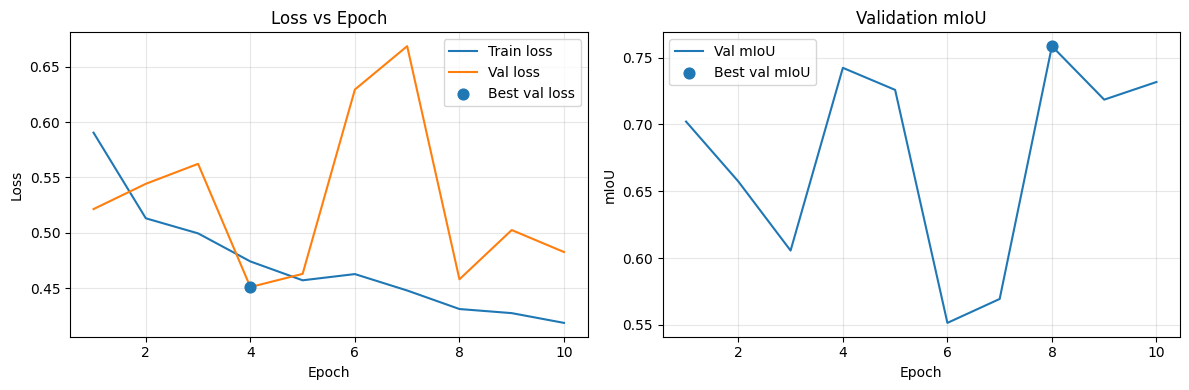

Saved figure: /content/loss_iou_curves.png

=== Training summary ===
Pos pixel rate ≈ 0.428  |  BCE pos_weight ≈ 1.34
Early stopped at epoch 4 (best val loss 0.451)
Best val mIoU 0.758 at epoch 8
Test: mIoU 0.836, Precision 0.837, Recall 0.999


from matplotlib import pyplot as plt
df['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['train_bce'].plot(kind='hist', bins=20, title='train_bce')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['train_dice'].plot(kind='hist', bins=20, title='train_dice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='epoch', y='train_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='train_loss', y='train_bce', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='train_bce', y='train_dice', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='train_dice', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_bce']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train_bce')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_dice']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train_dice')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
df['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['train_bce'].plot(kind='line', figsize=(8, 4), title='train_bce')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['train_dice'].plot(kind='line', figsize=(8, 4), title='train_dice')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ===== Parse your training log, make plots, and save CSVs =====
import re, io, pandas as pd, numpy as np, matplotlib.pyplot as plt

LOG = """
Estimated pixel pos_rate=0.427705 -> pos_weight=1.34
Epoch 01 | train loss=0.5904 (bce=0.6027, dice=0.5781)  val loss=0.5215 (bce=0.4789, dice=0.5642)  val mIoU=0.7021
Epoch 02 | train loss=0.5132 (bce=0.4607, dice=0.5656)  val loss=0.5443 (bce=0.4921, dice=0.5966)  val mIoU=0.6573
Epoch 03 | train loss=0.4996 (bce=0.4343, dice=0.5650)  val loss=0.5623 (bce=0.5553, dice=0.5694)  val mIoU=0.6056
Epoch 04 | train loss=0.4743 (bce=0.3871, dice=0.5614)  val loss=0.4512 (bce=0.3459, dice=0.5564)  val mIoU=0.7423
Epoch 05 | train loss=0.4573 (bce=0.3544, dice=0.5603)  val loss=0.4631 (bce=0.3668, dice=0.5594)  val mIoU=0.7258
Epoch 06 | train loss=0.4629 (bce=0.3642, dice=0.5616)  val loss=0.6293 (bce=0.6090, dice=0.6497)  val mIoU=0.5515
Epoch 07 | train loss=0.4481 (bce=0.3375, dice=0.5588)  val loss=0.6684 (bce=0.6809, dice=0.6559)  val mIoU=0.5694
Epoch 08 | train loss=0.4314 (bce=0.3045, dice=0.5583)  val loss=0.4582 (bce=0.3529, dice=0.5635)  val mIoU=0.7585
Epoch 09 | train loss=0.4277 (bce=0.2982, dice=0.5572)  val loss=0.5026 (bce=0.4065, dice=0.5986)  val mIoU=0.7185
Epoch 10 | train loss=0.4189 (bce=0.2817, dice=0.5561)  val loss=0.4828 (bce=0.4153, dice=0.5503)  val mIoU=0.7317
Early stopping.
Loaded best checkpoint: /content/unet_best_wts.pt
TEST → mIoU=0.8362  Precision=0.8372  Recall=0.9985
Saved best pure weights to: /content/unet_best_wts.pt
""".strip()

# --- parse pos_weight line
m = re.search(r"pos_rate=([\d\.e+-]+)\s*->\s*pos_weight=([\d\.e+-]+)", LOG)
pos_rate = float(m.group(1)) if m else None
pos_weight = float(m.group(2)) if m else None

# --- parse epoch lines
pat = re.compile(
 r"Epoch\s+(\d+)\s+\|\s+train loss=([\d\.e+-]+)\s+\(bce=([\d\.e+-]+), dice=([\d\.e+-]+)\)\s+"
 r"val loss=([\d\.e+-]+)\s+\(bce=([\d\.e+-]+), dice=([\d\.e+-]+)\)\s+val mIoU=([\d\.e+-]+)"
)
rows = []
for ep, tr, trb, trd, vl, vlb, vld, viou in pat.findall(LOG):
    rows.append(dict(
        epoch=int(ep),
        train_loss=float(tr), train_bce=float(trb), train_dice=float(trd),
        val_loss=float(vl),   val_bce=float(vlb),  val_dice=float(vld),
        val_miou=float(viou)
    ))
df = pd.DataFrame(rows).sort_values("epoch").reset_index(drop=True)

# --- parse test line
m2 = re.search(r"TEST\s*→\s*mIoU=([\d\.e+-]+)\s+Precision=([\d\.e+-]+)\s+Recall=([\d\.e+-]+)", LOG)
test_stats = dict(mIoU=float(m2.group(1)), Precision=float(m2.group(2)), Recall=float(m2.group(3))) if m2 else {}

display(df)

# Save CSV for your slides
csv_path = "/content/training_metrics.csv"
df.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)

# --- plots
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

# Loss curves
plt.subplot(1,2,1)
plt.plot(df["epoch"], df["train_loss"], label="Train loss")
plt.plot(df["epoch"], df["val_loss"],   label="Val loss")
best_idx = int(df["val_loss"].idxmin())
plt.scatter(df.loc[best_idx,"epoch"], df.loc[best_idx,"val_loss"], s=60, zorder=5, label="Best val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch"); plt.grid(alpha=0.3); plt.legend()

# IoU curve
plt.subplot(1,2,2)
plt.plot(df["epoch"], df["val_miou"], label="Val mIoU")
best_iou_idx = int(df["val_miou"].idxmax())
plt.scatter(df.loc[best_iou_idx,"epoch"], df.loc[best_iou_idx,"val_miou"], s=60, zorder=5, label="Best val mIoU")
plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.title("Validation mIoU"); plt.grid(alpha=0.3); plt.legend()

plt.tight_layout()
fig_path = "/content/loss_iou_curves.png"
plt.savefig(fig_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# --- print a clean summary block for your slide notes
print("\n=== Training summary ===")
if pos_rate is not None:
    print(f"Pos pixel rate ≈ {pos_rate:.3f}  |  BCE pos_weight ≈ {pos_weight:.2f}")
print(f"Early stopped at epoch {int(df.loc[best_idx,'epoch'])} (best val loss {df.loc[best_idx,'val_loss']:.3f})")
print(f"Best val mIoU {df['val_miou'].max():.3f} at epoch {int(df.loc[best_iou_idx,'epoch'])}")
if test_stats:
    print(f"Test: mIoU {test_stats['mIoU']:.3f}, Precision {test_stats['Precision']:.3f}, Recall {test_stats['Recall']:.3f}")


UNET


In [ ]:
!pip install rasterio gcsfs fsspec tqdm
!gcloud auth application-default login
# or ensure GOOGLE_APPLICATION_CREDENTIALS points to your service account key



You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  

Command killed by keyboard interrupt

^C


In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install albumentations==1.4.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 9.9 MB/s eta 0:00:00


In [3]:
import nbformat as nbf
from pathlib import Path

# change this to your notebook filename
nb_path = Path("Copy of wildfire_model.ipynb")
nb = nbf.read(nb_path, as_version=4)

# Remove the problematic widgets metadata if present
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# Optionally clear noisy stuff to make diffs small
for c in nb.cells:
    c["outputs"] = []
    c["execution_count"] = None

nbf.write(nb, nb_path)  # overwrite in place
print("New Notebook", nb_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Copy of wildfire_model.ipynb'

In [4]:
import os
print(os.listdir())


['.config', 'drive', 'sample_data']


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls /content/drive/MyDrive


'ALGOVERSEVIDEO (1).mp4'
 Budget.gdoc
'Colab Notebooks'
'Copy of [Template] WEB101 Milestone #3.gdoc'
'Copy of [Template] WEB101 Milestone #4 (Sp25) (1).gdoc'
'Copy of [Template] WEB101 Milestone #4 (Sp25).gdoc'
'Copy of wildfire_model.ipynb'
 ESSAY.gdoc
'Extra Credit Assignment: Dice & Coin Game.gdoc'
 fire_data
 fire-patches
 fire_patches_extracted
 MODIS_Fire_Events
 MODIS_FireEvents
 patches32
 patches32_subset25k.zip
'Samrakshyan Adhikari.gdoc'
'Samrakshyan Adhikari.pdf'
 samrakshyan.jpeg
 Timeline.gdoc
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).gdoc'
'Untitled document (4).gdoc'
'Untitled document (5).gdoc'
'Untitled document (6).gdoc'
'Untitled document (7).gdoc'
'Untitled document (8).gdoc'
'Untitled document.gdoc'
'URF Proposal.gdoc'


In [7]:
# 1) If not already done, mount Drive
from google.colab import drive, files
drive.mount('/content/drive')

# 2) Point to your notebook path in Drive
nb_path = "/content/drive/MyDrive/Copy of wildfire_model.ipynb"

# 3) Fix GitHub render issue: ensure metadata.widgets.state exists
import nbformat as nbf
from pathlib import Path
p = Path(nb_path)
assert p.exists(), f"Notebook not found: {p}"

# Read, back up, and clean
nb = nbf.read(str(p), as_version=4)  # use str() to avoid PosixPath read error

# Ensure top-level metadata.widgets.state is present
widgets = nb.metadata.get("widgets", {})
if "state" not in widgets or not isinstance(widgets.get("state"), dict):
    widgets["state"] = {}            # GitHub requires a dict here
nb.metadata["widgets"] = widgets

# (Optional) Also make sure per-cell widget metadata won't break rendering
# and strip any stale execution state that sometimes confuses renderers
for cell in nb.cells:
    if isinstance(cell.get("metadata"), dict):
        # Remove transient Colab execution metadata (optional cleanup)
        for k in ["execution", "colab"]:
            cell.metadata.pop(k, None)

# Save to a *new* file so your original stays intact
fixed_path = p.with_name(p.stem + "_fixed.ipynb")
nbf.write(nb, str(fixed_path))
print(f"✅ Wrote cleaned notebook: {fixed_path}")

# 4) (Optional) Download the cleaned copy to your machine
# files.download(str(fixed_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Wrote cleaned notebook: /content/drive/MyDrive/Copy of wildfire_model_fixed.ipynb
